# PPO training

## GAN and RaGAN setup

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# --- Local File Imports ---
from DataLoading import MultiChannelLazyDataset, MultiChannelEagerDataset
from GAN import Generator, Discriminator
from JazzClassifier import JazzClassifierCNN
from TransformerVAE import TransformerVAE
from Utils import reconstruct_and_save_midi

# --- Environment Setup ---
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.empty_cache()

print(f"--- Running with fixed random seed: {SEED} ---")


# ==============================================================================
# SECTION 2: PPO-SPECIFIC CONFIGURATION
# ==============================================================================
class PPOConfig:
    def __init__(self, model_to_train, use_curriculum=True):
        # ***** CURRICULUM TOGGLE START *****
        self.USE_CURRICULUM = use_curriculum
        self.CURRICULUM_PHASE_1_EPOCHS =10
        self.MODEL_TYPE = model_to_train
        
        # --- Core Paths ---
        self.BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
        self.MASTER_LABEL_MAP_FILE = os.path.join(self.BASE_MATRIX_DIR, "master_label_map.json")
        self.PPO_SAVE_DIR = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", f"PPO_Tuned_{self.MODEL_TYPE}")
        self.SAMPLES_DIR = os.path.join(self.PPO_SAVE_DIR, "samples")
        self.PRETRAINED_CLASSIFIER_PATH = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced.pth"
        self.USED_NON_JAZZ_FOR_PPO_CSV = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", "used_non_jazz_for_ppo_training.csv")
        self.BEST_MODEL_SAVE_PATH = os.path.join(self.PPO_SAVE_DIR, f"ppo_tuned_{self.MODEL_TYPE}_best.pth")

        # --- Model-Specific Pre-trained Paths ---
        if self.MODEL_TYPE == 'GAN':
            self.PRETRAINED_GAN_CHECKPOINT_PATH = r"C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_100.pth"
        elif self.MODEL_TYPE == 'RaGAN':
            self.PRETRAINED_GAN_CHECKPOINT_PATH = r"C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_100.pth"
        elif self.MODEL_TYPE == 'VAE':
            self.PRETRAINED_POLICY_PATH = r"C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_75.pth"
        else:
            raise ValueError("MODEL_TYPE must be 'GAN', 'RaGAN', or 'VAE'")

        # --- Data & Training Parameters ---
        self.PATIENCE_EARLY_STOPPING = 15
        
        self.NUM_JAZZ_FILES_FOR_RAGAN = 100 
        self.NUM_NON_JAZZ_FILES_FOR_PPO = 100
        self.BATCH_SIZE = 128
        self.NUM_WORKERS = 0
        self.PPO_EPOCHS = 50
        self.SAVE_SAMPLE_EVERY_N_EPOCHS = 5
        self.SAVE_MODEL_EVERY_N_EPOCHS = 5
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.CHANNELS = 3

        # --- PPO Hyperparameters ---
        self.PPO_UPDATE_EPOCHS = 4
        self.LR = 2e-6
        self.GAMMA = 0.99
        self.EPS_CLIP = 0.2
        
        # --- Reward Function Weights ---
        self.REWARD_WEIGHT_GENRE = 0.7
        self.REWARD_WEIGHT_CHROMA = 0.2
        self.REWARD_WEIGHT_DISCRIMINATOR = 0.1

        # --- ARCHITECTURAL HYPERPARAMETERS FOR ALL MODELS ---
        # General
        self.PITCHES = 88
        self.TIMESTEPS = 128
        
        # For GAN/RaGAN Generator & Musicality
        self.NOISE_DIM = 100
        
        # For Transformer-VAE
        self.LATENT_DIM = 256
        self.EMBED_DIM = 512
        self.NHEAD = 8
        self.NUM_ENCODER_LAYERS = 6
        self.NUM_DECODER_LAYERS = 6
        self.DROPOUT = 0.1
        
        os.makedirs(self.PPO_SAVE_DIR, exist_ok=True)
        os.makedirs(self.SAMPLES_DIR, exist_ok=True)

# ==============================================================================
# SECTION 3: DATA HANDLING
# ==============================================================================
class PPODataHandler:
    def __init__(self, config):
        self.config = config

    def get_unseen_non_jazz_dataloader(self):
        if os.path.exists(self.config.USED_NON_JAZZ_FOR_PPO_CSV):
            print(f"Found existing PPO file list at: {self.config.USED_NON_JAZZ_FOR_PPO_CSV}")
            ppo_files_df = pd.read_csv(self.config.USED_NON_JAZZ_FOR_PPO_CSV)
            ppo_files_relative = ppo_files_df['filepath'].tolist()
        else:
            print("No existing PPO file list found. Creating a new one...")
            with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
                label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
            
            used_gan_files_path = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", "used_non_jazz_for_gan_training.csv")
            if not os.path.exists(used_gan_files_path):
                 raise FileNotFoundError(f"Could not find the list of GAN-used files at {used_gan_files_path}")
            
            used_gan_df = pd.read_csv(used_gan_files_path)
            used_gan_files = set(used_gan_df['filepath'])

            all_non_jazz_relative = {p for p, l in label_map.items() if l == 0}
            unseen_non_jazz_relative = list(all_non_jazz_relative - used_gan_files)
            
            if not unseen_non_jazz_relative:
                raise ValueError("No unseen non-jazz files are available for PPO training!")

            random.shuffle(unseen_non_jazz_relative)
            num_to_use = min(self.config.NUM_NON_JAZZ_FILES_FOR_PPO, len(unseen_non_jazz_relative))
            ppo_files_relative = unseen_non_jazz_relative[:num_to_use]
            
            pd.DataFrame(ppo_files_relative, columns=['filepath']).to_csv(self.config.USED_NON_JAZZ_FOR_PPO_CSV, index=False)
            print(f"Created and saved a PPO dataset of {len(ppo_files_relative)} unseen non-jazz files.")

        ppo_full_paths = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in ppo_files_relative]
        dataset = MultiChannelEagerDataset(ppo_full_paths, [0]*len(ppo_full_paths), dataset_name="PPO Non-Jazz Content")
        
        if len(dataset) == 0:
            raise ValueError("The created PPO dataset has 0 valid segments.")
        
        dataloader = DataLoader(dataset, batch_size=self.config.BATCH_SIZE, shuffle=True, num_workers=self.config.NUM_WORKERS)
        return dataloader
    
    def get_real_jazz_dataloader(self):
        """
        Creates an EAGER dataloader with a fixed subset of real jazz samples,
        to be used for RaGAN reward calculation.
        """
        print(f"--- Creating an EAGER dataloader with {self.config.NUM_JAZZ_FILES_FOR_RAGAN} real jazz samples ---")
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        
        all_jazz_relative = [p for p, l in label_map.items() if l == 1]
        
        # Shuffle the list and take a subset
        random.shuffle(all_jazz_relative)
        num_to_use = min(self.config.NUM_JAZZ_FILES_FOR_RAGAN, len(all_jazz_relative))
        jazz_subset_relative = all_jazz_relative[:num_to_use]
        
        all_jazz_full_paths = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in jazz_subset_relative]

        # Use the EAGER dataset to load everything into RAM for speed
        dataset = MultiChannelEagerDataset(
            all_jazz_full_paths, 
            [1]*len(all_jazz_full_paths), 
            dataset_name="Real Jazz for RaGAN"
        )
        
        if len(dataset) == 0:
            raise ValueError("The created Real Jazz dataset for RaGAN has 0 valid segments.")

        dataloader = DataLoader(
            dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True, # Shuffle every epoch
            num_workers=self.config.NUM_WORKERS # Can be 0 for eager datasets
        )
        return dataloader

# ==============================================================================
# SECTION 4: REWARD EVALUATOR
# ==============================================================================
class StyleTransferEvaluator:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        
        self.classifier = JazzClassifierCNN(in_channels=4).to(self.device)
        self.classifier.load_state_dict(torch.load(config.PRETRAINED_CLASSIFIER_PATH, map_location=self.device))
        self.classifier.eval()
        
        self.discriminator = None
        if self.config.MODEL_TYPE in ['GAN', 'RaGAN']:
            # The Discriminator is initialized to accept 3 CHANNELS, as per the config
            self.discriminator = Discriminator(config).to(self.device)
            checkpoint = torch.load(config.PRETRAINED_GAN_CHECKPOINT_PATH, map_location=self.device)
            self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            self.discriminator.eval()
            print("Successfully loaded frozen 3-channel Discriminator for reward calculation.")

        self.pitch_to_chroma_map = self._create_pitch_to_chroma_map().to(self.device)

    def _pad_to_4_channels(self, tensor_3_channels):
        dummy_channel = torch.zeros_like(tensor_3_channels[:, 0:1, :, :])
        return torch.cat([tensor_3_channels, dummy_channel], dim=1)

    def _create_pitch_to_chroma_map(self):
        midi_pitches = torch.arange(21, 21 + self.config.PITCHES)
        chroma_indices = midi_pitches % 12
        pitch_to_chroma_map = torch.zeros(12, self.config.PITCHES)
        for i in range(self.config.PITCHES):
            pitch_to_chroma_map[chroma_indices[i], i] = 1.0
        return pitch_to_chroma_map

    def compute_chroma_similarity(self, original_batch, generated_batch):
        original_onsets = (original_batch[:, 0, :, :] > 0.5).float()
        generated_onsets = generated_batch[:, 0, :, :]
        original_onset_chroma = F.normalize(torch.matmul(self.pitch_to_chroma_map, original_onsets), p=1, dim=1)
        generated_onset_chroma = F.normalize(torch.matmul(self.pitch_to_chroma_map, generated_onsets), p=1, dim=1)
        onset_similarity = F.cosine_similarity(original_onset_chroma.flatten(1), generated_onset_chroma.flatten(1), dim=1)
        original_sustains = (original_batch[:, 1, :, :] > 0.5).float()
        generated_sustains = generated_batch[:, 1, :, :]
        original_sustain_chroma = F.normalize(torch.matmul(self.pitch_to_chroma_map, original_sustains), p=1, dim=1)
        generated_sustain_chroma = F.normalize(torch.matmul(self.pitch_to_chroma_map, generated_sustains), p=1, dim=1)
        sustain_similarity = F.cosine_similarity(original_sustain_chroma.flatten(1), generated_sustain_chroma.flatten(1), dim=1)
        return (onset_similarity + sustain_similarity) / 2.0

    def _get_current_reward_weights(self, epoch):
        """
        Calculates and normalizes reward weights.
        If config.USE_CURRICULUM is False, it returns the final weights immediately.
        Otherwise, it applies the curriculum logic.
        """
        weights = {
            'genre': self.config.REWARD_WEIGHT_GENRE,
            'chroma': self.config.REWARD_WEIGHT_CHROMA,
            'discriminator': self.config.REWARD_WEIGHT_DISCRIMINATOR
        }
        
        # If curriculum is turned off, just return the final, fixed weights.
        if not self.config.USE_CURRICULUM:
            if self.discriminator is not None:
                return weights
            else:
                total_style_weight = self.config.REWARD_WEIGHT_GENRE + self.config.REWARD_WEIGHT_CHROMA
                weights['genre'] = self.config.REWARD_WEIGHT_GENRE/total_style_weight
                weights['chroma'] = self.config.REWARD_WEIGHT_CHROMA/total_style_weight
                weights['discriminator'] = 0
                return weights

        # --- If curriculum IS enabled, proceed with the dynamic logic ---
        
        # Reset weights to be filled by curriculum logic
        weights = {'genre': 0.0, 'chroma': 0.0, 'discriminator': 0.0}

        # --- LOGIC FOR GAN/RaGAN (2-Phase Curriculum) ---
        if self.config.MODEL_TYPE in ['GAN', 'RaGAN']:
            if epoch <= self.config.CURRICULUM_PHASE_1_EPOCHS:
                # Phase 1: Style Only (Genre + Discriminator)
                total_style_weight = self.config.REWARD_WEIGHT_GENRE # + self.config.REWARD_WEIGHT_DISCRIMINATOR
                if total_style_weight > 0:
                    weights['genre'] = self.config.REWARD_WEIGHT_GENRE / total_style_weight
                    # weights['discriminator'] = self.config.REWARD_WEIGHT_DISCRIMINATOR / total_style_weight
            else:
                # Phase 2: Full Objective
                weights['genre'] = self.config.REWARD_WEIGHT_GENRE
                weights['chroma'] = self.config.REWARD_WEIGHT_CHROMA
                weights['discriminator'] = self.config.REWARD_WEIGHT_DISCRIMINATOR
        
        # --- LOGIC FOR VAE (2-Phase Curriculum) ---
        elif self.config.MODEL_TYPE == 'VAE':
            if epoch <= self.config.CURRICULUM_PHASE_1_EPOCHS: 
                # Phase 1 (for VAE): Genre Only
                weights['genre'] = 1.0
            else:
                # Phase 2 (for VAE): Genre + Chroma
                total_weight = self.config.REWARD_WEIGHT_GENRE + self.config.REWARD_WEIGHT_CHROMA
                if total_weight > 0:
                    weights['genre'] = self.config.REWARD_WEIGHT_GENRE / total_weight
                    weights['chroma'] = self.config.REWARD_WEIGHT_CHROMA / total_weight
        
        return weights

    def compute_rewards(self, original_content, generated_style, epoch,  real_samples=None):
        """Computes rewards using dynamically adjusted curriculum weights."""
        individual_rewards = {}
        current_weights = self._get_current_reward_weights(epoch)
        
        with torch.no_grad():
            # 1. Isolate the channels from the generator's output
            onset_probs = generated_style[:, 0:1, :, :]
            sustain_probs = generated_style[:, 1:2, :, :]
            velocity_probs = generated_style[:, 2:3, :, :]

            # 2. Binarize only the onset and sustain channels
            binary_onsets = (onset_probs > 0.5).float()
            binary_sustains = (sustain_probs > 0.5).float()

            # 3. Reconstruct the 3-channel tensor for the classifier
            #    [Binary Onset, Binary Sustain, Probabilistic Velocity]
            classifier_input_style = torch.cat([binary_onsets, binary_sustains, velocity_probs], dim=1)

            generated_style_4_chan = self._pad_to_4_channels(classifier_input_style)
            
            genre_reward = torch.sigmoid(self.classifier(generated_style_4_chan)).squeeze(-1)
            individual_rewards['genre'] = genre_reward
            
            chroma_reward = (self.compute_chroma_similarity(original_content, generated_style) + 1) / 2.0
            individual_rewards['chroma'] = chroma_reward
            
            total_reward = (current_weights['genre'] * genre_reward + 
                            current_weights['chroma'] * chroma_reward)
            
            if self.discriminator is not None:
                fake_logits = self.discriminator(generated_style)

                if self.config.MODEL_TYPE == 'RaGAN' and real_samples is not None:
                    # RaGAN Logic: Compare fake to the average of real
                    real_logits = self.discriminator(real_samples)
                    relativistic_logits = fake_logits - real_logits.mean()
                    discriminator_reward = torch.sigmoid(relativistic_logits).squeeze(-1)
                else:
                    # Standard GAN Logic
                    discriminator_reward = torch.sigmoid(fake_logits).squeeze(-1)

                softened_discriminator_reward = torch.sqrt(discriminator_reward) 
                individual_rewards['discriminator'] = softened_discriminator_reward
                total_reward += current_weights['discriminator'] * softened_discriminator_reward
            
        return total_reward, individual_rewards, current_weights
    
# ==============================================================================
# SECTION 5: THE PPO AGENT
# ==============================================================================
def plot_original_content_matrices(content_tensor, title="Original Content Matrices"):
    """
    Visualizes the three input channels of a single content item.
    """
    print(f"--- Visualizing: {title} ---")
    if content_tensor.is_cuda:
        content_tensor = content_tensor.cpu()
        
    # Convert to numpy and get individual channels
    content_np = content_tensor.numpy()
    onset_matrix = content_np[0].T
    sustain_matrix = content_np[1].T
    velocity_matrix = content_np[2].T
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(title, fontsize=18)

    # --- Plot Onset ---
    im1 = axs[0].imshow(onset_matrix, aspect='auto', origin='lower', cmap='plasma', vmin=0, vmax=1)
    axs[0].set_title('Channel 0: Original Onsets')
    axs[0].set_ylabel('Pitch')
    axs[0].set_xlabel('Time Steps')
    fig.colorbar(im1, ax=axs[0])

    # --- Plot Sustain ---
    im2 = axs[1].imshow(sustain_matrix, aspect='auto', origin='lower', cmap='plasma', vmin=0, vmax=1)
    axs[1].set_title('Channel 1: Original Sustains')
    axs[1].set_xlabel('Time Steps')
    fig.colorbar(im2, ax=axs[1])

    # --- Plot Velocity ---
    im3 = axs[2].imshow(velocity_matrix, aspect='auto', origin='lower', cmap='plasma', vmin=0, vmax=1)
    axs[2].set_title('Channel 2: Original Velocities')
    axs[2].set_xlabel('Time Steps')
    fig.colorbar(im3, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

class PPOAgent:
    def __init__(self, policy_network, config, evaluator):
        self.policy = policy_network
        self.optimizer = optim.Adam(self.policy.parameters(), lr=config.LR)
        self.config = config
        self.evaluator = evaluator
        self.mse_loss = nn.MSELoss()

    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward in reversed(memory['rewards']):
            discounted_reward = reward + (self.config.GAMMA * discounted_reward)
            rewards.insert(0, discounted_reward)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.config.DEVICE)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.cat(memory['states'], dim=0).detach().to(self.config.DEVICE)
        old_logprobs = torch.cat(memory['logprobs'], dim=0).detach().to(self.config.DEVICE)

        for _ in range(self.config.PPO_UPDATE_EPOCHS):
            logprobs, state_values, dist_entropy, current_actions = self.evaluate(old_states)

            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.config.EPS_CLIP, 1 + self.config.EPS_CLIP) * advantages

            ppo_loss = -torch.min(surr1, surr2) + 0.5 * self.mse_loss(state_values, rewards) - 0.01 * dist_entropy
            total_loss = ppo_loss.mean()
            
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
    
    def evaluate(self, state):
        if self.config.MODEL_TYPE == 'VAE':
            # 1. Encode the state to get its content representation (mu, logvar)
            mu, logvar = self.policy.encode(state)
            
            # 2. This is our "action distribution" in the latent space
            z_dist = Normal(mu, torch.exp(0.5 * logvar))
            
            # 3. Sample a z from this distribution to encourage exploration
            z = z_dist.sample()
            
            # 4. The "action" is the decoded music from this sampled z
            action = self.policy.decode(z)
            
            # The value is a prediction of the reward from this state
            # A simple way is to use the mean of the latent space
            state_value = torch.mean(mu, dim=1)
            
            # Log probability is calculated based on the latent action `z`
            action_logprobs = z_dist.log_prob(z).sum(dim=1)
            dist_entropy = z_dist.entropy().sum(dim=1)
            
        else: # GAN and RaGAN logic remains the same
            noise = torch.randn(state.size(0), self.config.NOISE_DIM).to(self.config.DEVICE)
            action = self.policy(state, noise)
            state_value = torch.mean(action.flatten(1), dim=1)
            dist = Normal(action, 0.1)
            action_logprobs = dist.log_prob(action).flatten(1).sum(1)
            dist_entropy = dist.entropy().flatten(1).sum(1)
        
        return action_logprobs, state_value, dist_entropy, action
    
# ==============================================================================
# SECTION 6: THE PPO TRAINER CLASS
# ==============================================================================
class PPOTrainer:
    def __init__(self, model_to_train, use_curriculum=False): 
        print(f"--- INITIALIZING PPO TRAINER FOR: {model_to_train} ---")
        self.model_type = model_to_train
        
        # Pass the curriculum flag to the config
        self.config = PPOConfig(self.model_type, use_curriculum=use_curriculum) 
        
        # Initialize all components
        self.data_handler = PPODataHandler(self.config)
        self.content_loader = self.data_handler.get_unseen_non_jazz_dataloader()
        self.evaluator = StyleTransferEvaluator(self.config)
        self.device = self.config.DEVICE

        # Create a second dataloader for real jazz samples if training RaGAN
        self.real_jazz_loader = None
        if self.model_type == 'RaGAN':
            self.real_jazz_loader = self.data_handler.get_real_jazz_dataloader()

        # Instantiate the correct policy network
        if self.model_type == 'VAE':
            self.policy_net = TransformerVAE(self.config).to(self.config.DEVICE)
            checkpoint = torch.load(self.config.PRETRAINED_POLICY_PATH, map_location=self.config.DEVICE)
            self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        else: # GAN or RaGAN
            self.policy_net = Generator(self.config).to(self.config.DEVICE)
            checkpoint = torch.load(self.config.PRETRAINED_GAN_CHECKPOINT_PATH, map_location=self.config.DEVICE)
            self.policy_net.load_state_dict(checkpoint['generator_state_dict'])

        print(f"Successfully loaded pre-trained {self.model_type} model as PPO policy.")
        
        self.agent = PPOAgent(self.policy_net, self.config, self.evaluator)
        
        # Prepare for training loop
        self.memory = {'states': [], 'logprobs': [], 'rewards': []}
        
        self.history = {
            'total_reward': [],
            'genre_reward': [],
            'chroma_reward': [],
            'discriminator_reward': []
        }

        print(f"\n--- Starting PPO Fine-Tuning on device: {self.config.DEVICE} ---")
        
        # Grab a fixed batch for consistent sampling across epochs
        self.fixed_content_batch = self._find_musically_active_batch()

    def plot_training_progress(self):
        """
        Plots the training rewards (total and individual components) over epochs.
        """
        print("\n--- Generating Training Plots ---")
        
        epochs = range(1, len(self.history['total_reward']) + 1)
        
        # --- Plot 1: Total Average Reward ---
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, self.history['total_reward'], 'o-', label='Total Average Reward', color='blue')
        plt.title(f'PPO Total Average Reward vs. Epochs ({self.model_type})', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Average Reward', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()
        
        # --- Plot 2: Individual Reward Components ---
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, self.history['genre_reward'], 's-', label='Genre Reward', color='green')
        plt.plot(epochs, self.history['chroma_reward'], '^-', label='Chroma Reward', color='red')
        
        # Only plot discriminator reward if it was used
        if self.history['discriminator_reward']:
            plt.plot(epochs, self.history['discriminator_reward'], 'd-', label='Discriminator Reward', color='purple')
            
        plt.title(f'PPO Individual Reward Components vs. Epochs ({self.model_type})', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Average Reward Component', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

    def _find_musically_active_batch(self):
        """Helper to find a batch with significant musical content for consistent sampling."""
        print("Searching for a non-silent batch to use for sample generation...")
        for i, (batch_data, _) in enumerate(self.content_loader):
            if torch.sum(batch_data[:, 0, :, :]) > 10:
                print(f"Found a suitable batch for sampling at index {i}.")
                return batch_data[:, :3, :, :].to(self.config.DEVICE)
        
        print("Warning: Could not find a musically active batch. Using the first batch for sampling.")
        return next(iter(self.content_loader))[0][:, :3, :, :].to(self.config.DEVICE)

    def train(self):
        if self.real_jazz_loader:
            real_jazz_iter = iter(self.real_jazz_loader)

        best_avg_reward = -float('inf')
        epochs_no_improve = 0
            
        for epoch in range(self.config.PPO_EPOCHS):
            epoch_total_rewards, epoch_genre_rewards = [], []
            epoch_chroma_rewards, epoch_discriminator_rewards = [], []
            
            pbar = tqdm(self.content_loader, desc=f"PPO Epoch {epoch+1}/{self.config.PPO_EPOCHS}")
            
            for content_batch_4_chan, _ in pbar:
                # ... (inner loop for batch processing is unchanged) ...
                states = content_batch_4_chan[:, :3, :, :].to(self.config.DEVICE)
                
                with torch.no_grad():
                    log_probs, _, _, actions = self.agent.evaluate(states)
                    real_samples_batch = None
                    if self.real_jazz_loader:
                        try:
                            real_samples_batch = next(real_jazz_iter)[0][:, :3, :, :].to(self.device)
                        except StopIteration:
                            real_jazz_iter = iter(self.real_jazz_loader)
                            real_samples_batch = next(real_jazz_iter)[0][:, :3, :, :].to(self.device)
                    
                    total_rewards, individual_rewards, current_weights = self.evaluator.compute_rewards(
                        states, actions, epoch + 1, real_samples=real_samples_batch
                    )
                
                epoch_total_rewards.extend(total_rewards.cpu().tolist())
                epoch_genre_rewards.extend(individual_rewards['genre'].cpu().tolist())
                epoch_chroma_rewards.extend(individual_rewards['chroma'].cpu().tolist())
                if 'discriminator' in individual_rewards:
                    epoch_discriminator_rewards.extend(individual_rewards['discriminator'].cpu().tolist())

                self.memory['states'].append(states.cpu())
                self.memory['rewards'].extend(total_rewards.cpu().tolist())
                self.memory['logprobs'].append(log_probs.cpu())

                if len(self.memory['states']) * self.config.BATCH_SIZE >= self.config.BATCH_SIZE:
                    self.agent.update(self.memory)
                    self.memory = {'states': [], 'logprobs': [], 'rewards': []}

                postfix_dict = {
                    "R_total": f"{total_rewards.mean().item():.3f}",
                    f"G(w={current_weights['genre']:.2f})": f"{individual_rewards['genre'].mean().item():.3f}",
                    f"C(w={current_weights['chroma']:.2f})": f"{individual_rewards['chroma'].mean().item():.3f}",
                }
                if 'discriminator' in individual_rewards:
                    postfix_dict[f"D(w={current_weights['discriminator']:.2f})"] = f"{individual_rewards['discriminator'].mean().item():.3f}"
                pbar.set_postfix(**postfix_dict)

            # --- End-of-epoch summary logging ---
            avg_epoch_total_reward = np.mean(epoch_total_rewards) if epoch_total_rewards else 0
            avg_epoch_genre = np.mean(epoch_genre_rewards) if epoch_genre_rewards else 0
            avg_epoch_chroma = np.mean(epoch_chroma_rewards) if epoch_chroma_rewards else 0
            avg_epoch_discrim = np.mean(epoch_discriminator_rewards) if epoch_discriminator_rewards else 0
            
            # ***** APPEND TO HISTORY FOR PLOTTING START *****
            self.history['total_reward'].append(avg_epoch_total_reward)
            self.history['genre_reward'].append(avg_epoch_genre)
            self.history['chroma_reward'].append(avg_epoch_chroma)
            if epoch_discriminator_rewards:
                self.history['discriminator_reward'].append(avg_epoch_discrim)
            # ***** APPEND TO HISTORY FOR PLOTTING END *****

            final_weights_for_epoch = self.evaluator._get_current_reward_weights(epoch + 1)
            
            summary_str = (
                f"Epoch {epoch+1} Summary: "
                f"Avg Reward: {avg_epoch_total_reward:.4f} | "
                f"Genre: {avg_epoch_genre:.4f} (w={final_weights_for_epoch['genre']:.2f}), "
                f"Chroma: {avg_epoch_chroma:.4f} (w={final_weights_for_epoch['chroma']:.2f})"
            )
            if epoch_discriminator_rewards:
                summary_str += f", Discrim: {avg_epoch_discrim:.4f} (w={final_weights_for_epoch['discriminator']:.2f})"
            print(summary_str)

            is_in_phase_1 = self.config.USE_CURRICULUM and (epoch + 1) <= self.config.CURRICULUM_PHASE_1_EPOCHS

            if is_in_phase_1:
                # During Phase 1, we don't check for the best model or count patience.
                print(f"  In Curriculum Phase 1. Early stopping is paused until Epoch {self.config.CURRICULUM_PHASE_1_EPOCHS + 1}.")
                # On the very last epoch of phase 1, reset the trackers for a fresh start in phase 2.
                if (epoch + 1) == self.config.CURRICULUM_PHASE_1_EPOCHS:
                    print("  End of Phase 1. Resetting best reward and patience for Phase 2.")
                    best_avg_reward = -float('inf')
                    epochs_no_improve = 0
            else:
                # This block runs if curriculum is OFF, or if it's ON and we are in Phase 2.
                if avg_epoch_total_reward > best_avg_reward:
                    best_avg_reward = avg_epoch_total_reward
                    epochs_no_improve = 0
                    print(f"  New best average reward: {best_avg_reward:.4f}. Saving model...")
                    self.save_checkpoint() 
                else:
                    epochs_no_improve += 1
                    print(f"  Avg reward did not improve. Patience: {epochs_no_improve}/{self.config.PATIENCE_EARLY_STOPPING}")

                if epochs_no_improve >= self.config.PATIENCE_EARLY_STOPPING:
                    print(f"\n--- Early stopping triggered after {self.config.PATIENCE_EARLY_STOPPING} epochs with no improvement. ---")
                    break
            # ***** MODIFIED EARLY STOPPING LOGIC END *****

            # --- Saving logic (unchanged) ---
            if (epoch + 1) % self.config.SAVE_SAMPLE_EVERY_N_EPOCHS == 0:
                self.save_sample(epoch + 1)

        print("\n--- PPO Training Complete ---")
        
        # ***** CALL PLOTTING FUNCTION AT THE END OF TRAINING *****
        self.plot_training_progress()

    def save_sample(self, epoch):
        print(f"\n--- Saving sample for epoch {epoch} ---")
        
        plot_original_content_matrices(
            self.fixed_content_batch[0],
            title=f"Original Content for Epoch {epoch} Sample"
        )
        
        self.policy_net.eval()
        with torch.no_grad():
            if self.model_type == 'VAE':
                sample_action, _, _ = self.policy_net(self.fixed_content_batch)
            else:
                noise = torch.randn(self.fixed_content_batch.size(0), self.config.NOISE_DIM).to(self.config.DEVICE)
                sample_action = self.policy_net(self.fixed_content_batch, noise)
        
        sample_path_prefix = os.path.join(self.config.SAMPLES_DIR, f"sample_epoch_{epoch}_generated")
        sample_to_save = sample_action[0].unsqueeze(0).cpu()
        
        reconstruct_and_save_midi(sample_to_save, sample_path_prefix, config=self.config)
        
        self.policy_net.train()

    def save_checkpoint(self):
        """Saves the current model state to the path specified in the config."""
        print(f"--- Saving checkpoint to {self.config.BEST_MODEL_SAVE_PATH} ---")
        torch.save(self.policy_net.state_dict(), self.config.BEST_MODEL_SAVE_PATH)

--- Running with fixed random seed: 123 ---


### GAN Training

--- INITIALIZING PPO TRAINER FOR: GAN ---
Found existing PPO file list at: C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_ppo_training.csv
EAGERLY loading all multi-channel segments for 'PPO Non-Jazz Content' into RAM...


Loading files: 100%|██████████| 100/100 [00:00<00:00, 114.48it/s]


Eager loading complete. Total segments: 6181. Shape: (6181, 4, 88, 128)


C:\Users\User\AppData\Local\Temp\ipykernel_18248\3643325903.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.classifier.load_state_dict(torch.load(config.PRETRAINE

Successfully loaded frozen 3-channel Discriminator for reward calculation.


C:\Users\User\AppData\Local\Temp\ipykernel_18248\3643325903.py:486: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.config.PRETRAINED_GAN_CHECKPOI

Successfully loaded pre-trained GAN model as PPO policy.

--- Starting PPO Fine-Tuning on device: cuda ---
Searching for a non-silent batch to use for sample generation...
Found a suitable batch for sampling at index 0.


PPO Epoch 1/50: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s, C(w=0.00)=0.720, D(w=0.00)=0.492, G(w=1.00)=0.568, R_total=0.568]


Epoch 1 Summary: Avg Reward: 0.4839 | Genre: 0.4839 (w=1.00), Chroma: 0.7238 (w=0.00), Discrim: 0.5387 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 2/50: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s, C(w=0.00)=0.726, D(w=0.00)=0.577, G(w=1.00)=0.499, R_total=0.499]


Epoch 2 Summary: Avg Reward: 0.4868 | Genre: 0.4868 (w=1.00), Chroma: 0.7237 (w=0.00), Discrim: 0.5383 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 3/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.00)=0.718, D(w=0.00)=0.530, G(w=1.00)=0.429, R_total=0.429]


Epoch 3 Summary: Avg Reward: 0.4844 | Genre: 0.4844 (w=1.00), Chroma: 0.7237 (w=0.00), Discrim: 0.5383 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 4/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.00)=0.712, D(w=0.00)=0.557, G(w=1.00)=0.446, R_total=0.446]


Epoch 4 Summary: Avg Reward: 0.4889 | Genre: 0.4889 (w=1.00), Chroma: 0.7236 (w=0.00), Discrim: 0.5383 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 5/50: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s, C(w=0.00)=0.737, D(w=0.00)=0.530, G(w=1.00)=0.536, R_total=0.536]


Epoch 5 Summary: Avg Reward: 0.4881 | Genre: 0.4881 (w=1.00), Chroma: 0.7236 (w=0.00), Discrim: 0.5380 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.

--- Saving sample for epoch 5 ---
--- Visualizing: Original Content for Epoch 5 Sample ---


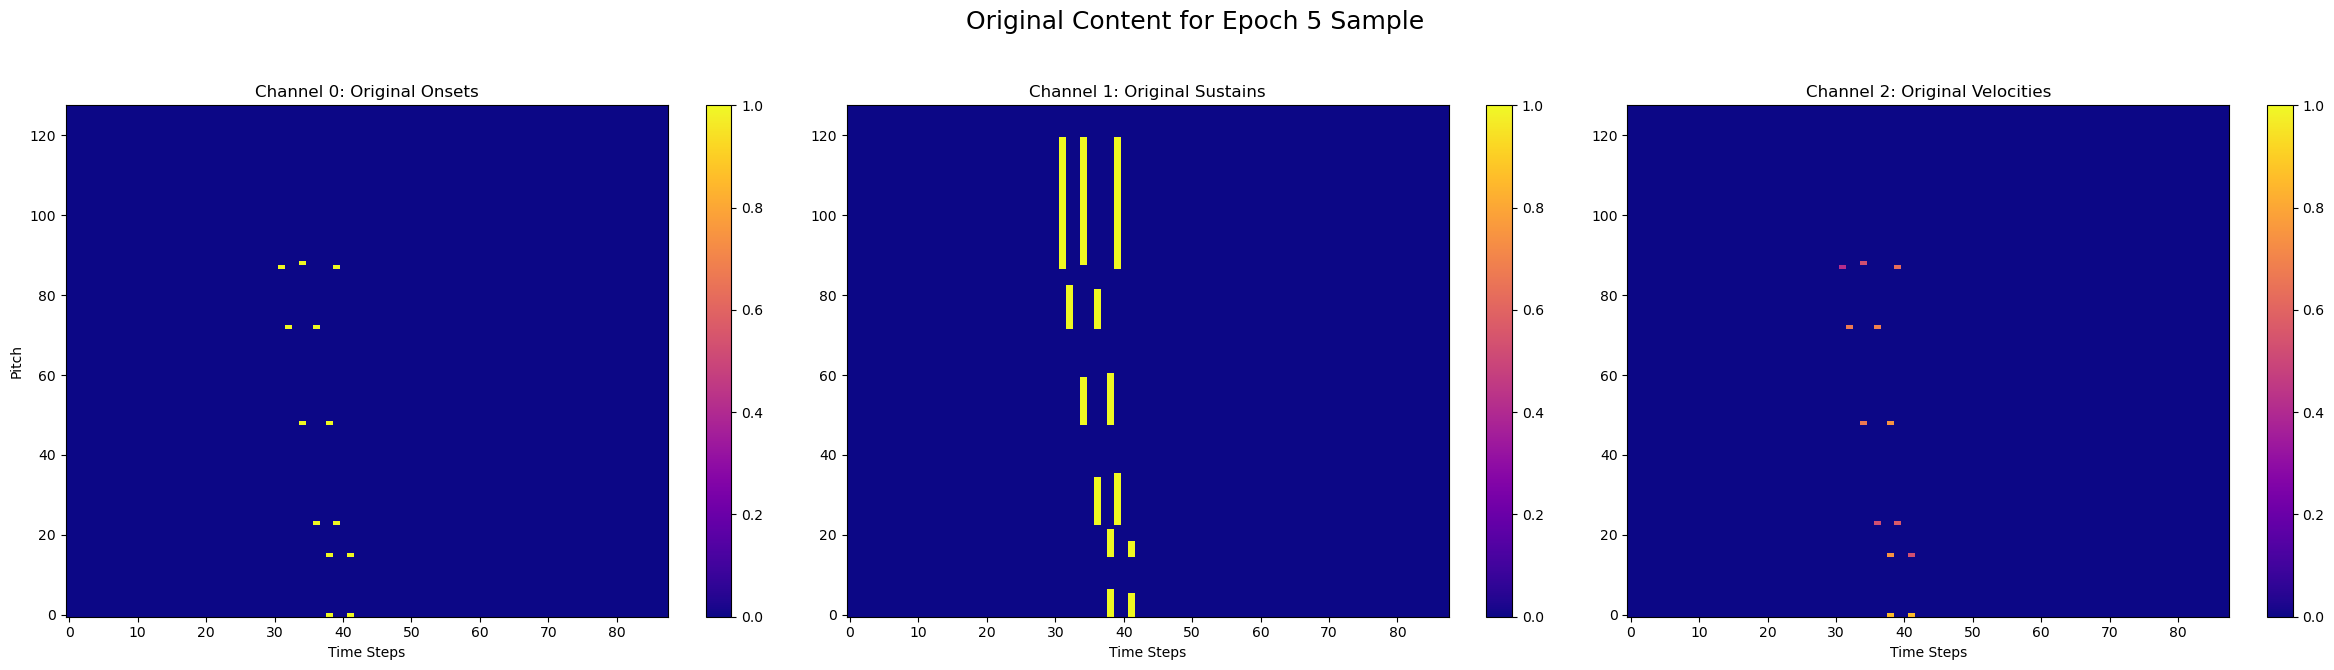

--- Visualizing: Generator Raw Output for Sample: sample_epoch_5_generated ---


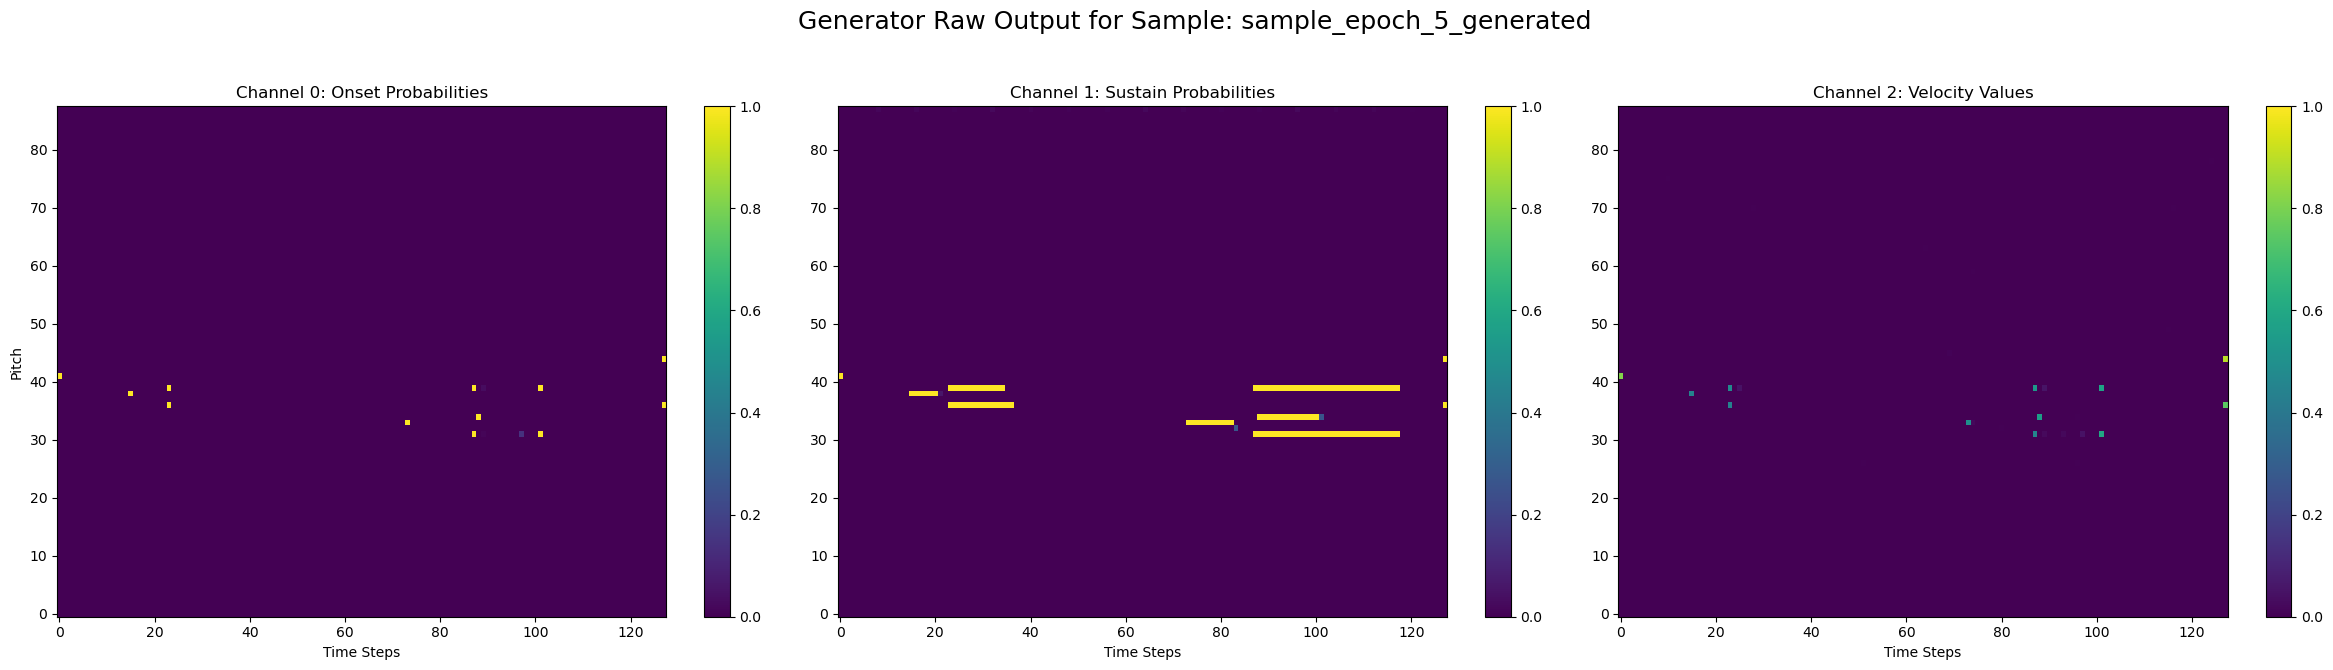

PPO Epoch 6/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.00)=0.718, D(w=0.00)=0.525, G(w=1.00)=0.510, R_total=0.510]


Epoch 6 Summary: Avg Reward: 0.4888 | Genre: 0.4888 (w=1.00), Chroma: 0.7237 (w=0.00), Discrim: 0.5384 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 7/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.00)=0.719, D(w=0.00)=0.532, G(w=1.00)=0.459, R_total=0.459]


Epoch 7 Summary: Avg Reward: 0.4897 | Genre: 0.4897 (w=1.00), Chroma: 0.7236 (w=0.00), Discrim: 0.5380 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 8/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.00)=0.712, D(w=0.00)=0.482, G(w=1.00)=0.418, R_total=0.418]


Epoch 8 Summary: Avg Reward: 0.4887 | Genre: 0.4887 (w=1.00), Chroma: 0.7236 (w=0.00), Discrim: 0.5383 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 9/50: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s, C(w=0.00)=0.713, D(w=0.00)=0.529, G(w=1.00)=0.424, R_total=0.424]


Epoch 9 Summary: Avg Reward: 0.4897 | Genre: 0.4897 (w=1.00), Chroma: 0.7236 (w=0.00), Discrim: 0.5382 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.


PPO Epoch 10/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.00)=0.686, D(w=0.00)=0.512, G(w=1.00)=0.454, R_total=0.454]


Epoch 10 Summary: Avg Reward: 0.4893 | Genre: 0.4893 (w=1.00), Chroma: 0.7236 (w=0.00), Discrim: 0.5387 (w=0.00)
  In Curriculum Phase 1. Early stopping is paused until Epoch 11.
  End of Phase 1. Resetting best reward and patience for Phase 2.

--- Saving sample for epoch 10 ---
--- Visualizing: Original Content for Epoch 10 Sample ---


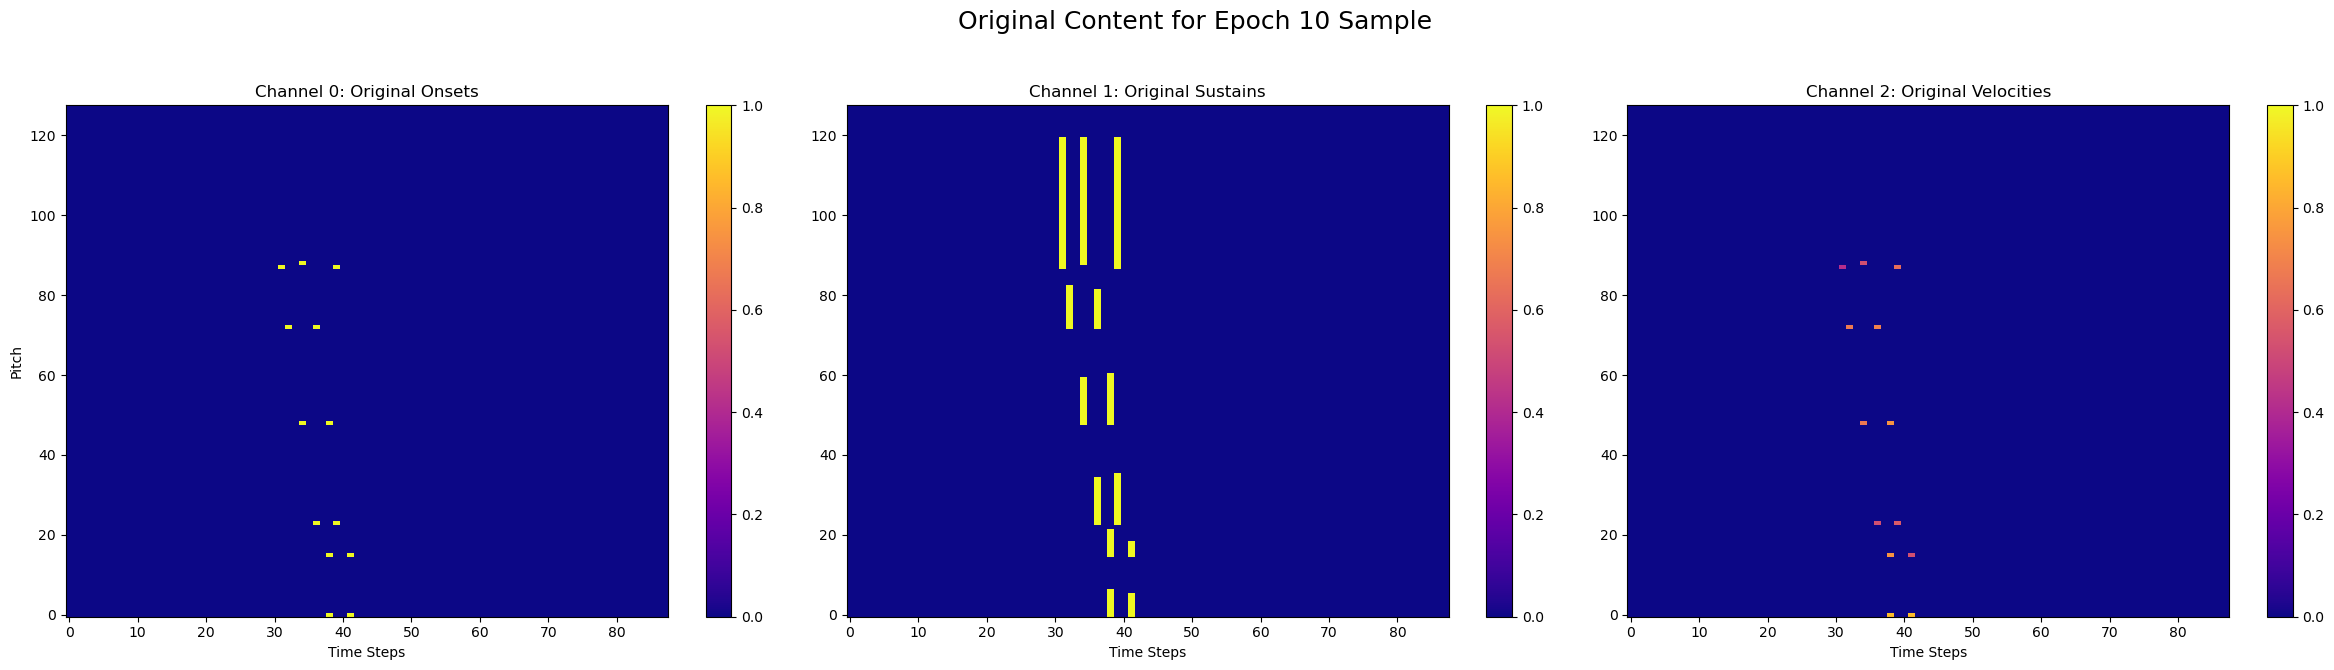

--- Visualizing: Generator Raw Output for Sample: sample_epoch_10_generated ---


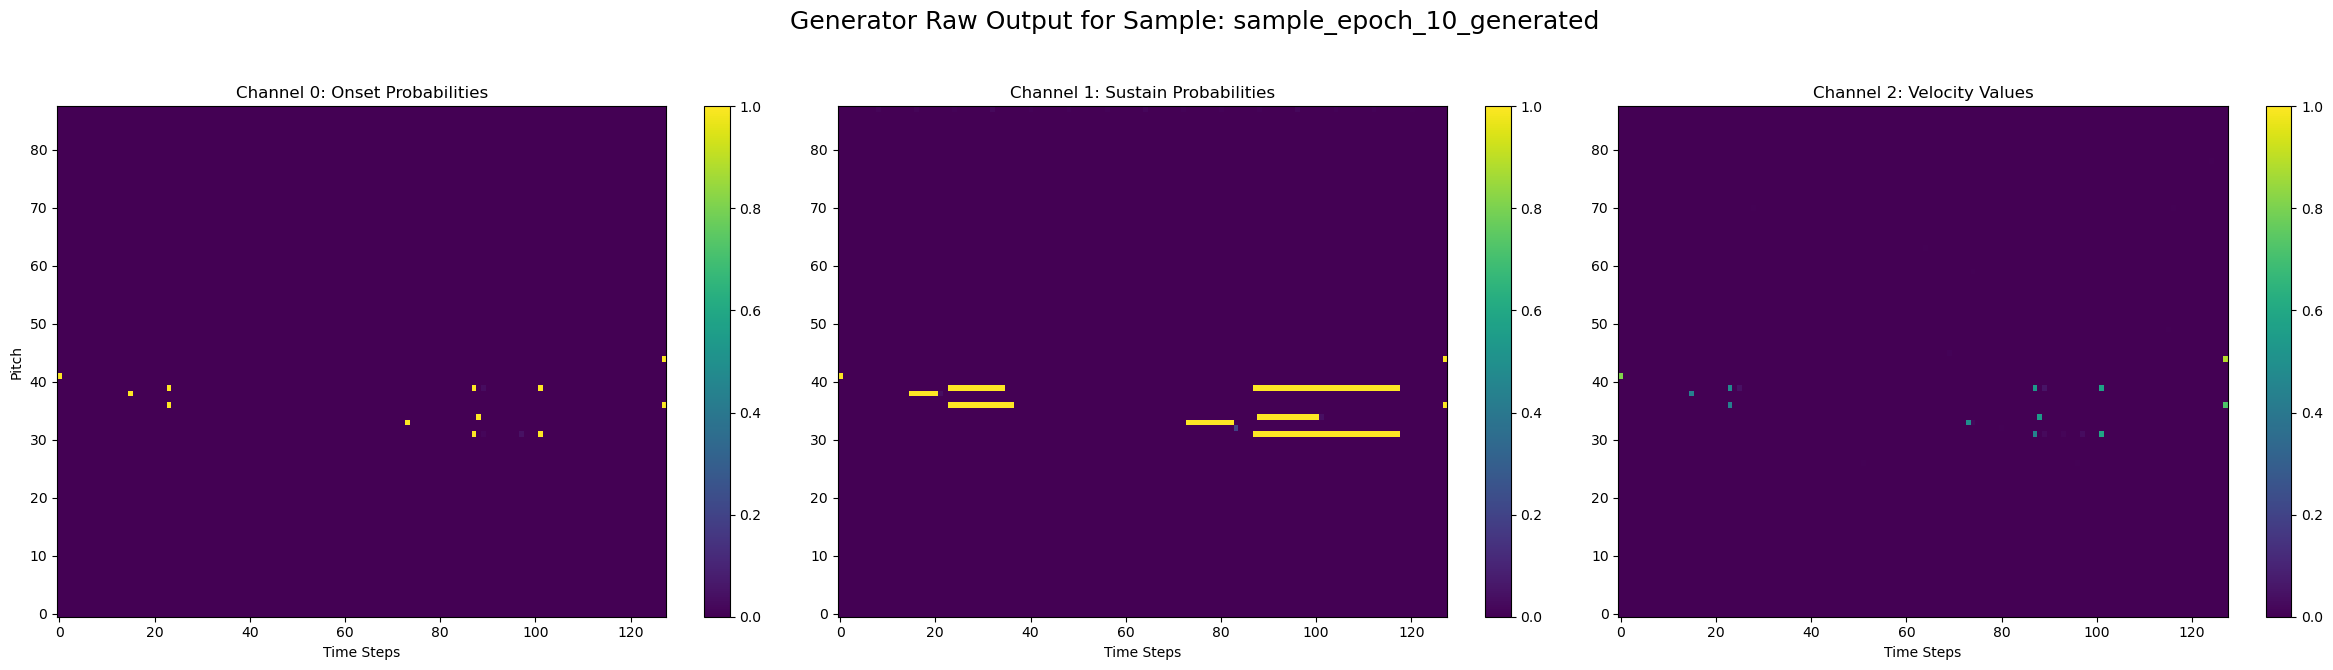

PPO Epoch 11/50: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s, C(w=0.20)=0.761, D(w=0.10)=0.548, G(w=0.70)=0.453, R_total=0.524]


Epoch 11 Summary: Avg Reward: 0.5428 | Genre: 0.4919 (w=0.70), Chroma: 0.7236 (w=0.20), Discrim: 0.5381 (w=0.10)
  New best average reward: 0.5428. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---


PPO Epoch 12/50: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s, C(w=0.20)=0.752, D(w=0.10)=0.608, G(w=0.70)=0.548, R_total=0.595]


Epoch 12 Summary: Avg Reward: 0.5418 | Genre: 0.4904 (w=0.70), Chroma: 0.7235 (w=0.20), Discrim: 0.5380 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 13/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.20)=0.725, D(w=0.10)=0.516, G(w=0.70)=0.490, R_total=0.540]


Epoch 13 Summary: Avg Reward: 0.5433 | Genre: 0.4926 (w=0.70), Chroma: 0.7235 (w=0.20), Discrim: 0.5377 (w=0.10)
  New best average reward: 0.5433. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---


PPO Epoch 14/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.20)=0.721, D(w=0.10)=0.510, G(w=0.70)=0.474, R_total=0.527]


Epoch 14 Summary: Avg Reward: 0.5429 | Genre: 0.4919 (w=0.70), Chroma: 0.7235 (w=0.20), Discrim: 0.5383 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 15/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.20)=0.713, D(w=0.10)=0.541, G(w=0.70)=0.462, R_total=0.520]


Epoch 15 Summary: Avg Reward: 0.5437 | Genre: 0.4931 (w=0.70), Chroma: 0.7234 (w=0.20), Discrim: 0.5382 (w=0.10)
  New best average reward: 0.5437. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---

--- Saving sample for epoch 15 ---
--- Visualizing: Original Content for Epoch 15 Sample ---


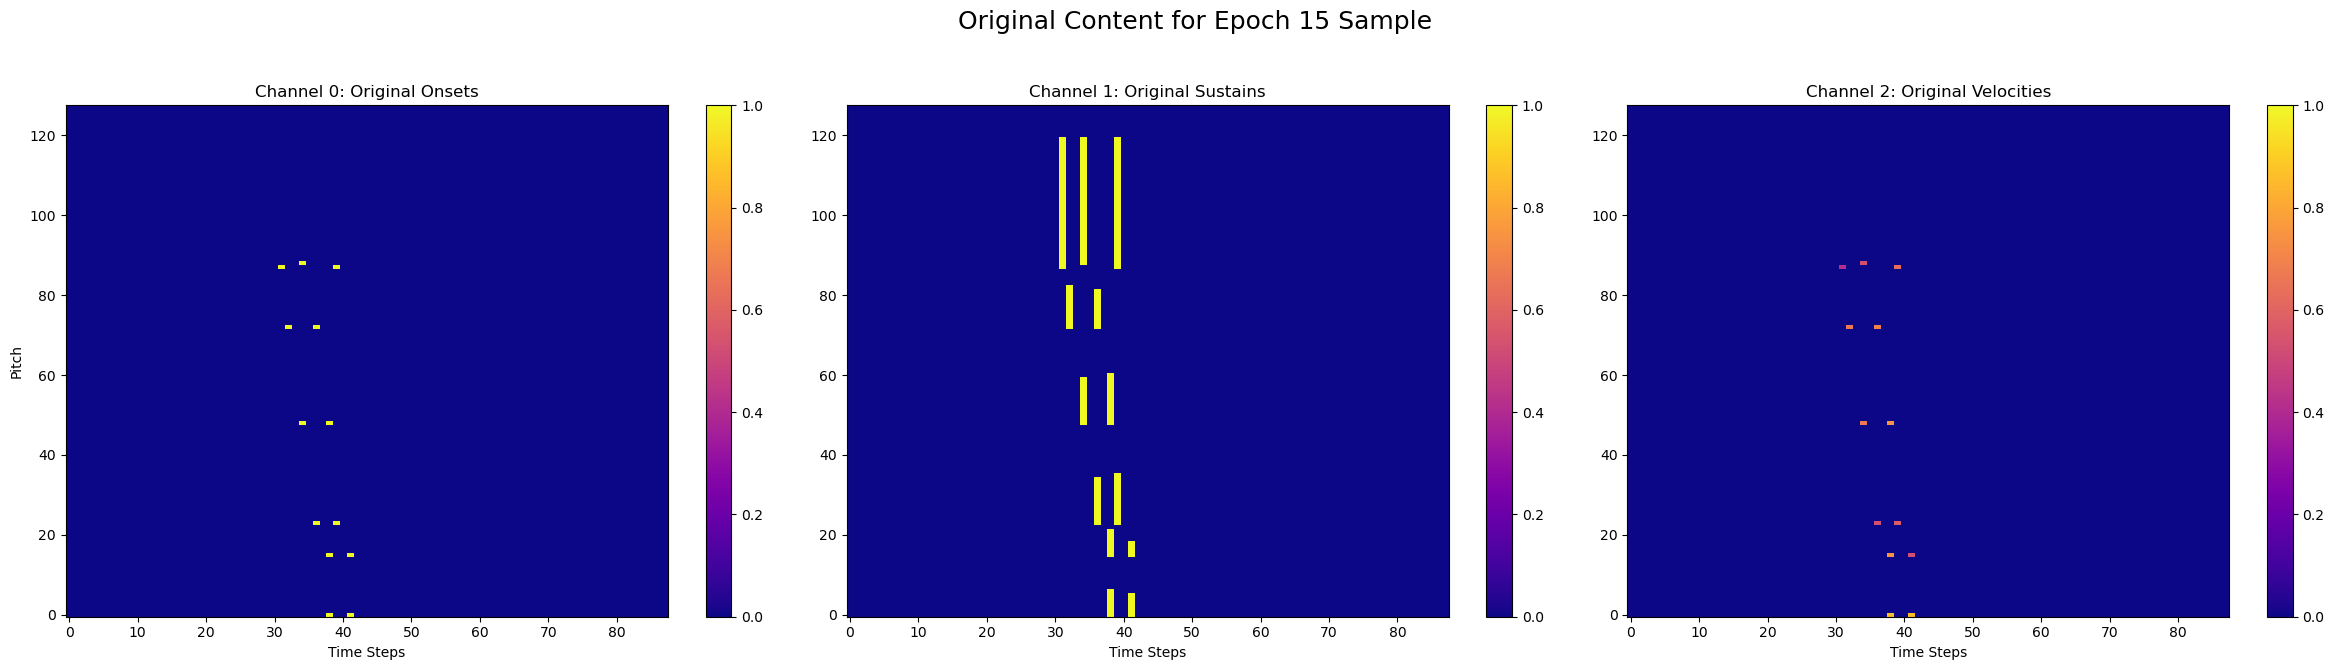

--- Visualizing: Generator Raw Output for Sample: sample_epoch_15_generated ---


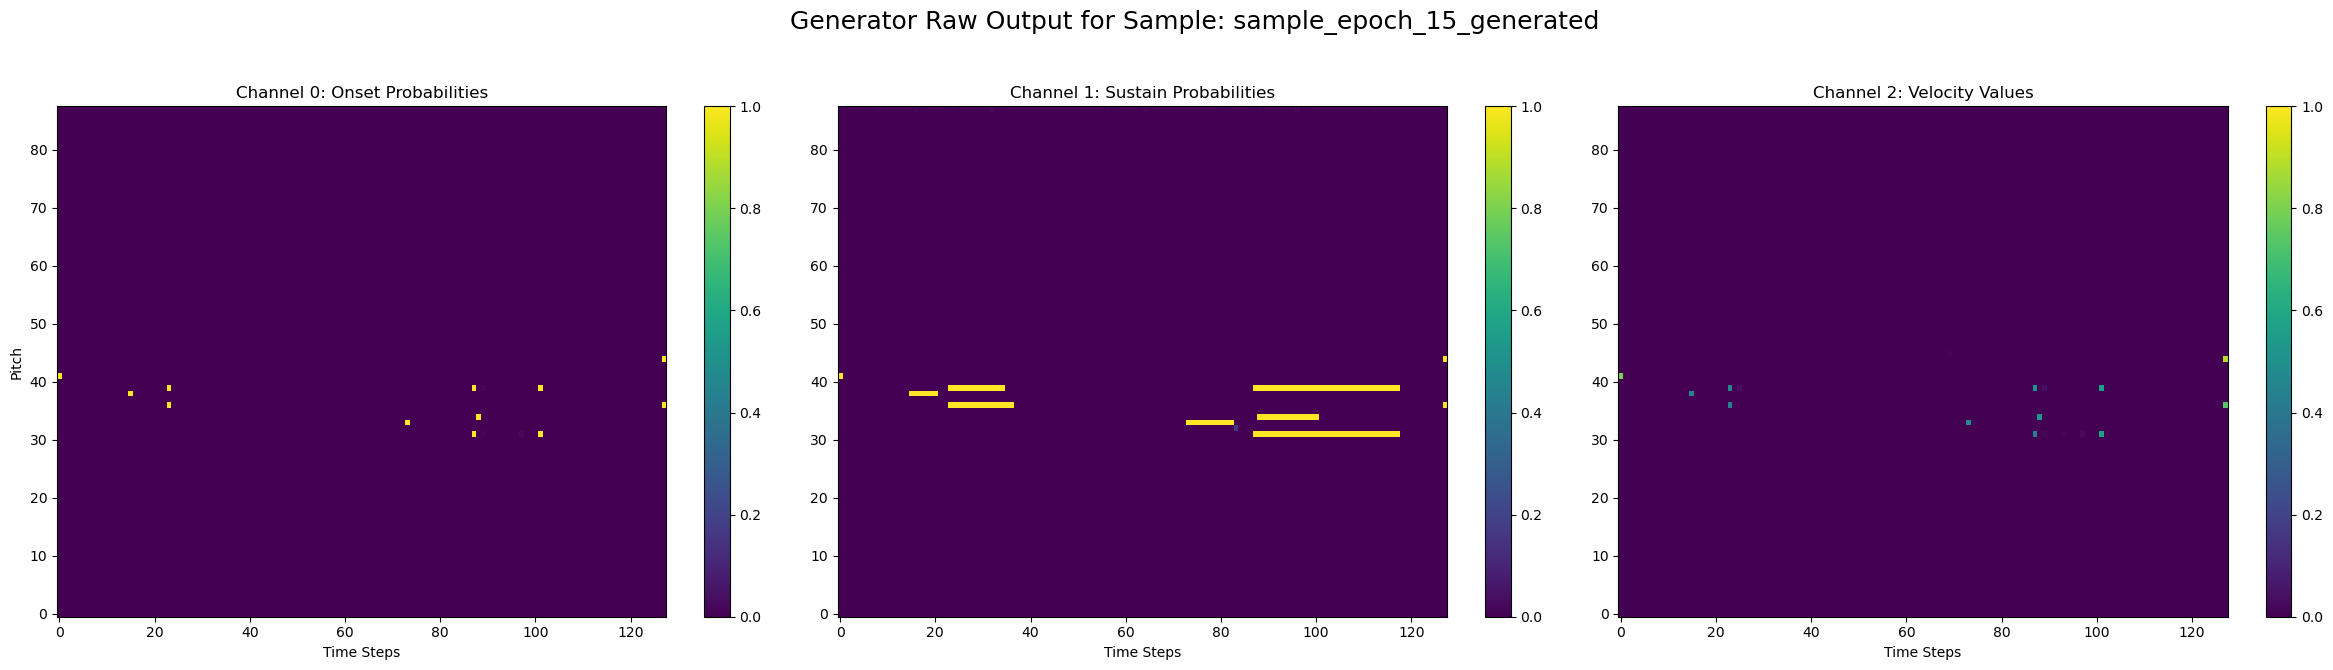

PPO Epoch 16/50: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s, C(w=0.20)=0.724, D(w=0.10)=0.527, G(w=0.70)=0.429, R_total=0.498]


Epoch 16 Summary: Avg Reward: 0.5443 | Genre: 0.4940 (w=0.70), Chroma: 0.7234 (w=0.20), Discrim: 0.5379 (w=0.10)
  New best average reward: 0.5443. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---


PPO Epoch 17/50: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s, C(w=0.20)=0.704, D(w=0.10)=0.565, G(w=0.70)=0.542, R_total=0.577]


Epoch 17 Summary: Avg Reward: 0.5434 | Genre: 0.4928 (w=0.70), Chroma: 0.7233 (w=0.20), Discrim: 0.5377 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 18/50: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s, C(w=0.20)=0.701, D(w=0.10)=0.548, G(w=0.70)=0.485, R_total=0.535]


Epoch 18 Summary: Avg Reward: 0.5442 | Genre: 0.4940 (w=0.70), Chroma: 0.7233 (w=0.20), Discrim: 0.5379 (w=0.10)
  Avg reward did not improve. Patience: 2/15


PPO Epoch 19/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.20)=0.739, D(w=0.10)=0.518, G(w=0.70)=0.504, R_total=0.552]


Epoch 19 Summary: Avg Reward: 0.5438 | Genre: 0.4934 (w=0.70), Chroma: 0.7233 (w=0.20), Discrim: 0.5382 (w=0.10)
  Avg reward did not improve. Patience: 3/15


PPO Epoch 20/50: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s, C(w=0.20)=0.734, D(w=0.10)=0.543, G(w=0.70)=0.496, R_total=0.548]


Epoch 20 Summary: Avg Reward: 0.5437 | Genre: 0.4934 (w=0.70), Chroma: 0.7232 (w=0.20), Discrim: 0.5375 (w=0.10)
  Avg reward did not improve. Patience: 4/15

--- Saving sample for epoch 20 ---
--- Visualizing: Original Content for Epoch 20 Sample ---


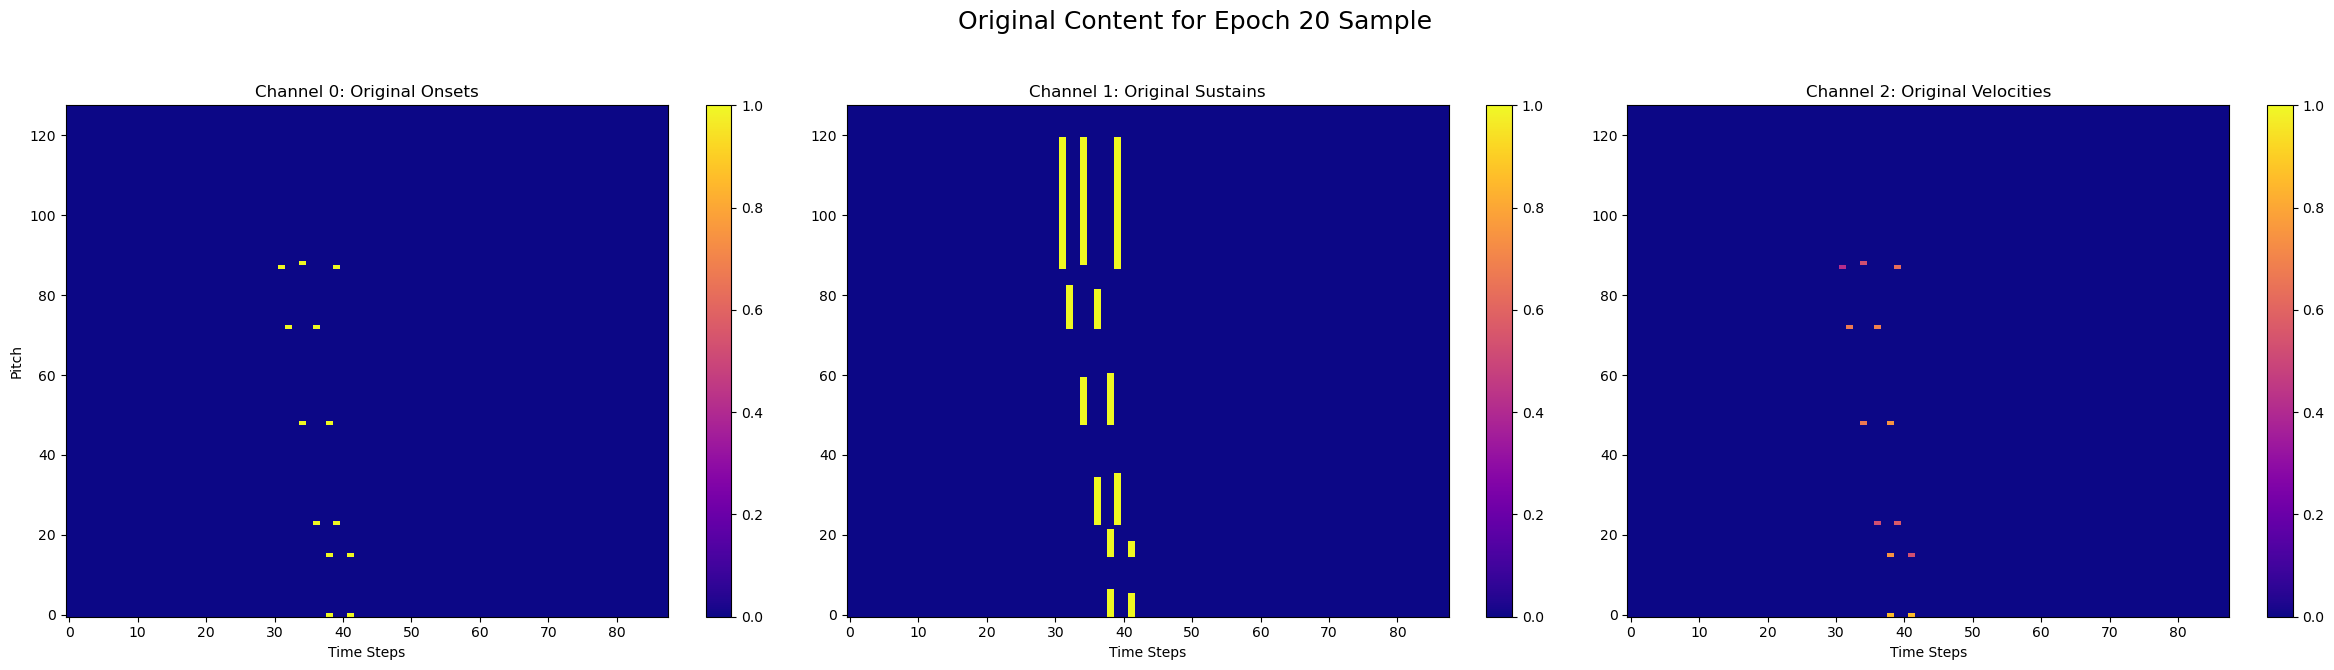

--- Visualizing: Generator Raw Output for Sample: sample_epoch_20_generated ---


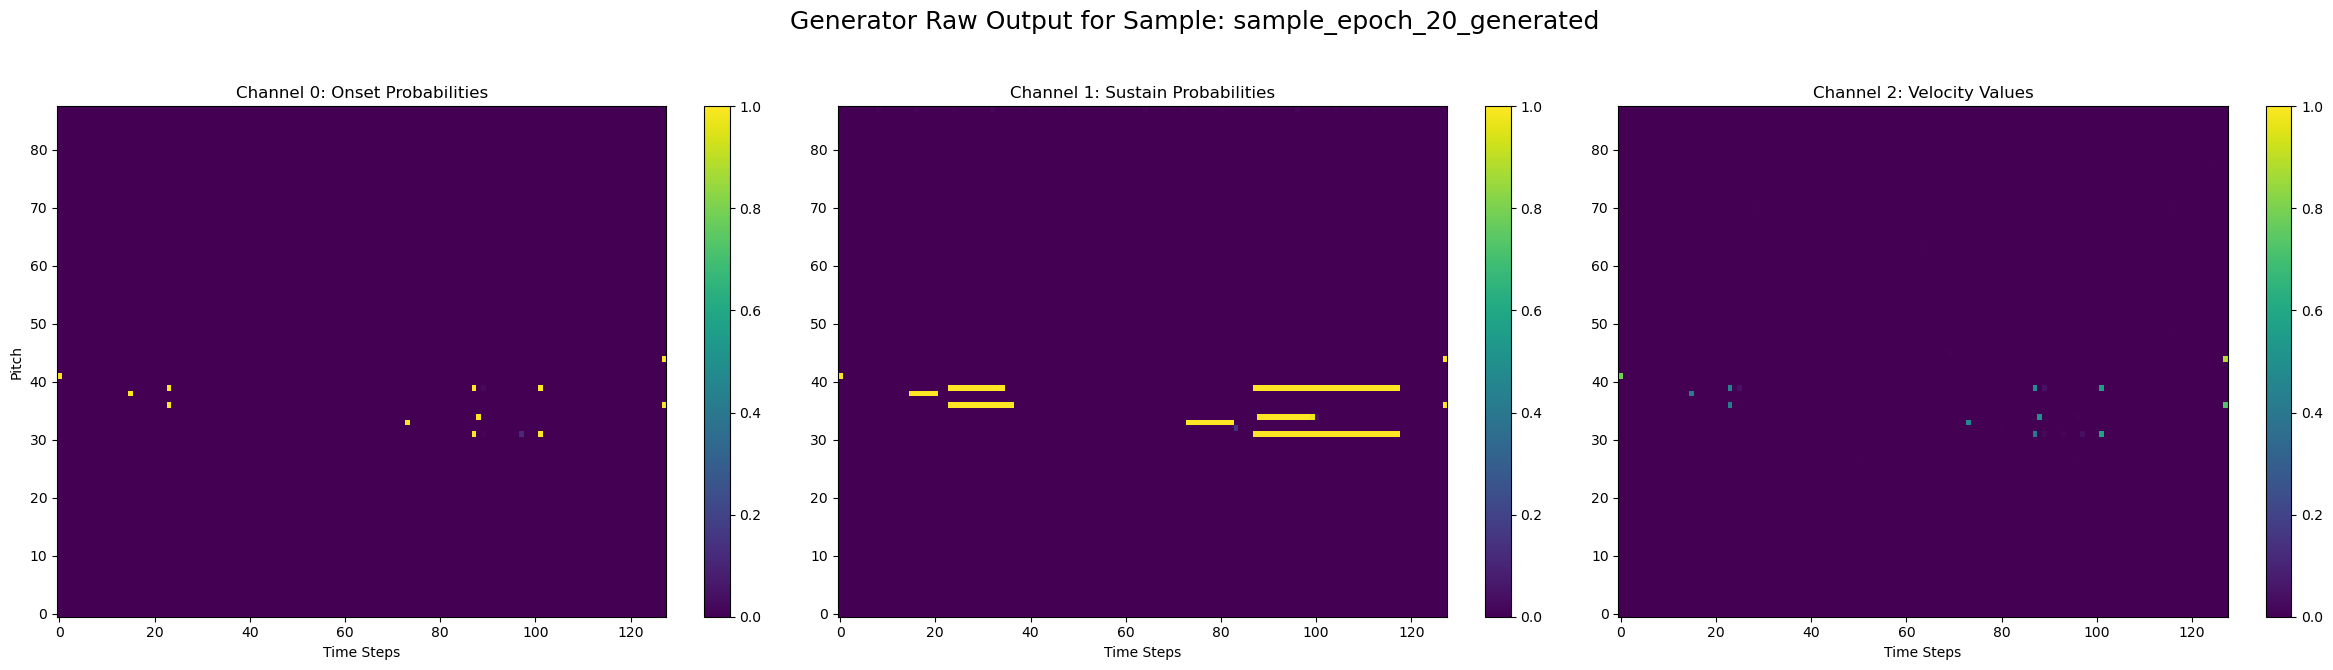

PPO Epoch 21/50: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s, C(w=0.20)=0.724, D(w=0.10)=0.535, G(w=0.70)=0.503, R_total=0.550]


Epoch 21 Summary: Avg Reward: 0.5445 | Genre: 0.4944 (w=0.70), Chroma: 0.7232 (w=0.20), Discrim: 0.5383 (w=0.10)
  New best average reward: 0.5445. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---


PPO Epoch 22/50: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s, C(w=0.20)=0.721, D(w=0.10)=0.520, G(w=0.70)=0.458, R_total=0.517]


Epoch 22 Summary: Avg Reward: 0.5442 | Genre: 0.4941 (w=0.70), Chroma: 0.7231 (w=0.20), Discrim: 0.5375 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 23/50: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s, C(w=0.20)=0.722, D(w=0.10)=0.537, G(w=0.70)=0.503, R_total=0.551]


Epoch 23 Summary: Avg Reward: 0.5449 | Genre: 0.4951 (w=0.70), Chroma: 0.7230 (w=0.20), Discrim: 0.5378 (w=0.10)
  New best average reward: 0.5449. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---


PPO Epoch 24/50: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s, C(w=0.20)=0.728, D(w=0.10)=0.587, G(w=0.70)=0.492, R_total=0.548]


Epoch 24 Summary: Avg Reward: 0.5448 | Genre: 0.4949 (w=0.70), Chroma: 0.7229 (w=0.20), Discrim: 0.5378 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 25/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.20)=0.683, D(w=0.10)=0.560, G(w=0.70)=0.538, R_total=0.569]


Epoch 25 Summary: Avg Reward: 0.5446 | Genre: 0.4947 (w=0.70), Chroma: 0.7228 (w=0.20), Discrim: 0.5378 (w=0.10)
  Avg reward did not improve. Patience: 2/15

--- Saving sample for epoch 25 ---
--- Visualizing: Original Content for Epoch 25 Sample ---


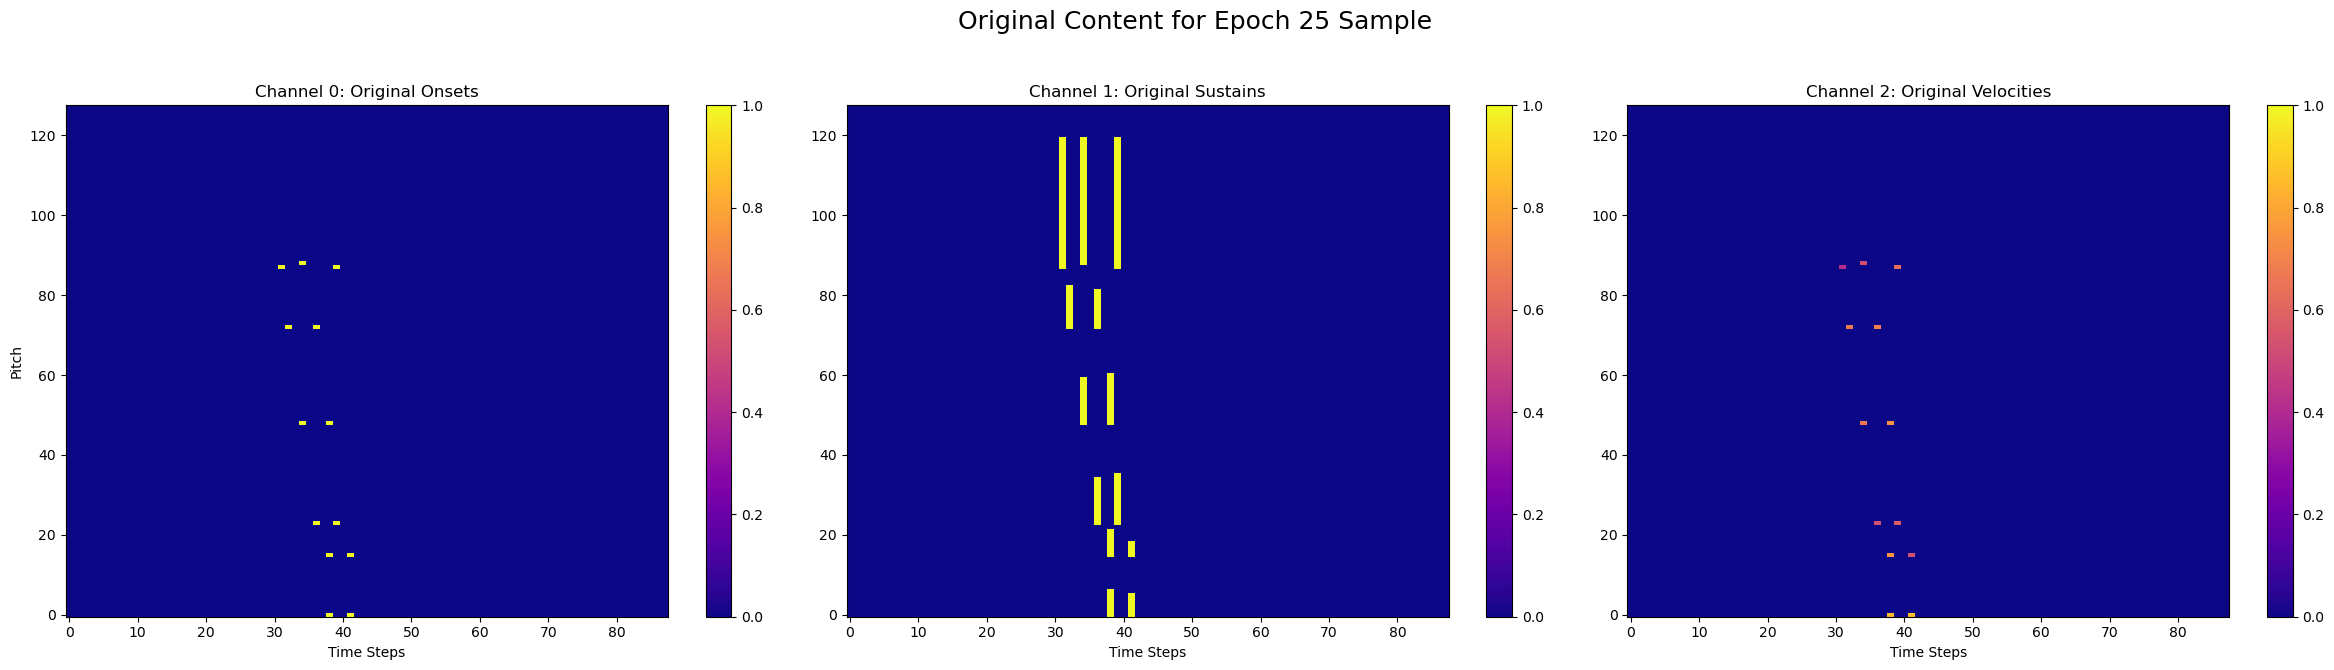

--- Visualizing: Generator Raw Output for Sample: sample_epoch_25_generated ---


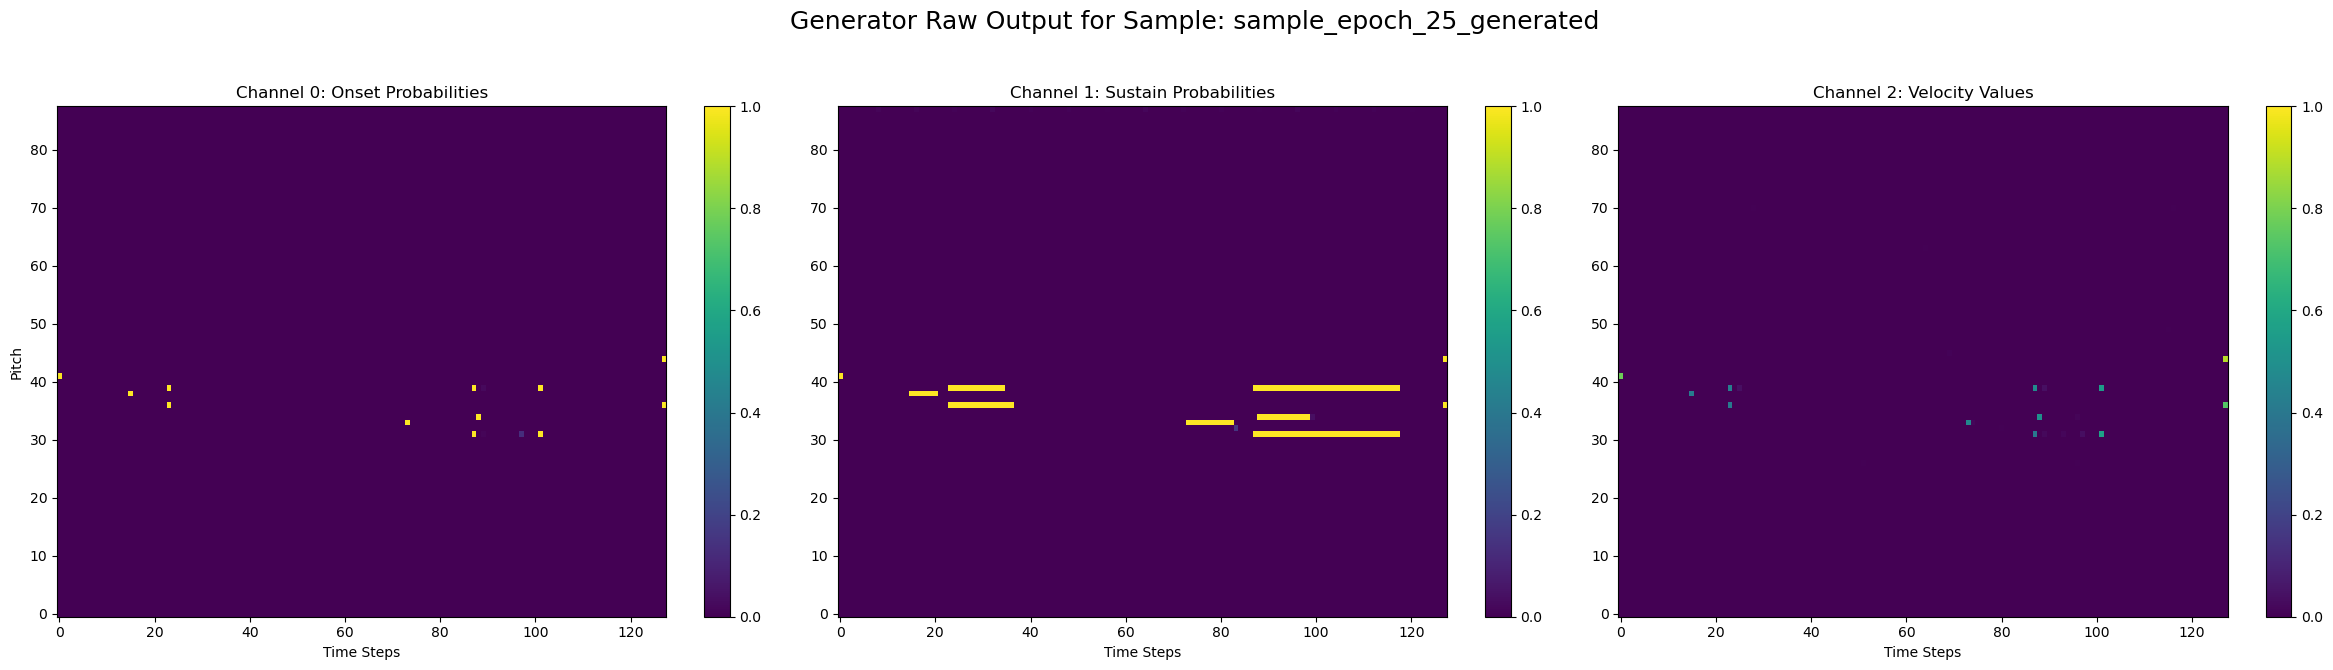

PPO Epoch 26/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.20)=0.727, D(w=0.10)=0.509, G(w=0.70)=0.436, R_total=0.501]


Epoch 26 Summary: Avg Reward: 0.5452 | Genre: 0.4956 (w=0.70), Chroma: 0.7227 (w=0.20), Discrim: 0.5374 (w=0.10)
  New best average reward: 0.5452. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---


PPO Epoch 27/50: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s, C(w=0.20)=0.741, D(w=0.10)=0.580, G(w=0.70)=0.543, R_total=0.586]


Epoch 27 Summary: Avg Reward: 0.5453 | Genre: 0.4958 (w=0.70), Chroma: 0.7226 (w=0.20), Discrim: 0.5373 (w=0.10)
  New best average reward: 0.5453. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth ---


PPO Epoch 28/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.712, D(w=0.10)=0.576, G(w=0.70)=0.508, R_total=0.555]


Epoch 28 Summary: Avg Reward: 0.5447 | Genre: 0.4950 (w=0.70), Chroma: 0.7225 (w=0.20), Discrim: 0.5371 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 29/50: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s, C(w=0.20)=0.734, D(w=0.10)=0.535, G(w=0.70)=0.526, R_total=0.568]


Epoch 29 Summary: Avg Reward: 0.5441 | Genre: 0.4942 (w=0.70), Chroma: 0.7225 (w=0.20), Discrim: 0.5367 (w=0.10)
  Avg reward did not improve. Patience: 2/15


PPO Epoch 30/50: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s, C(w=0.20)=0.726, D(w=0.10)=0.593, G(w=0.70)=0.516, R_total=0.566]


Epoch 30 Summary: Avg Reward: 0.5435 | Genre: 0.4934 (w=0.70), Chroma: 0.7224 (w=0.20), Discrim: 0.5368 (w=0.10)
  Avg reward did not improve. Patience: 3/15

--- Saving sample for epoch 30 ---
--- Visualizing: Original Content for Epoch 30 Sample ---


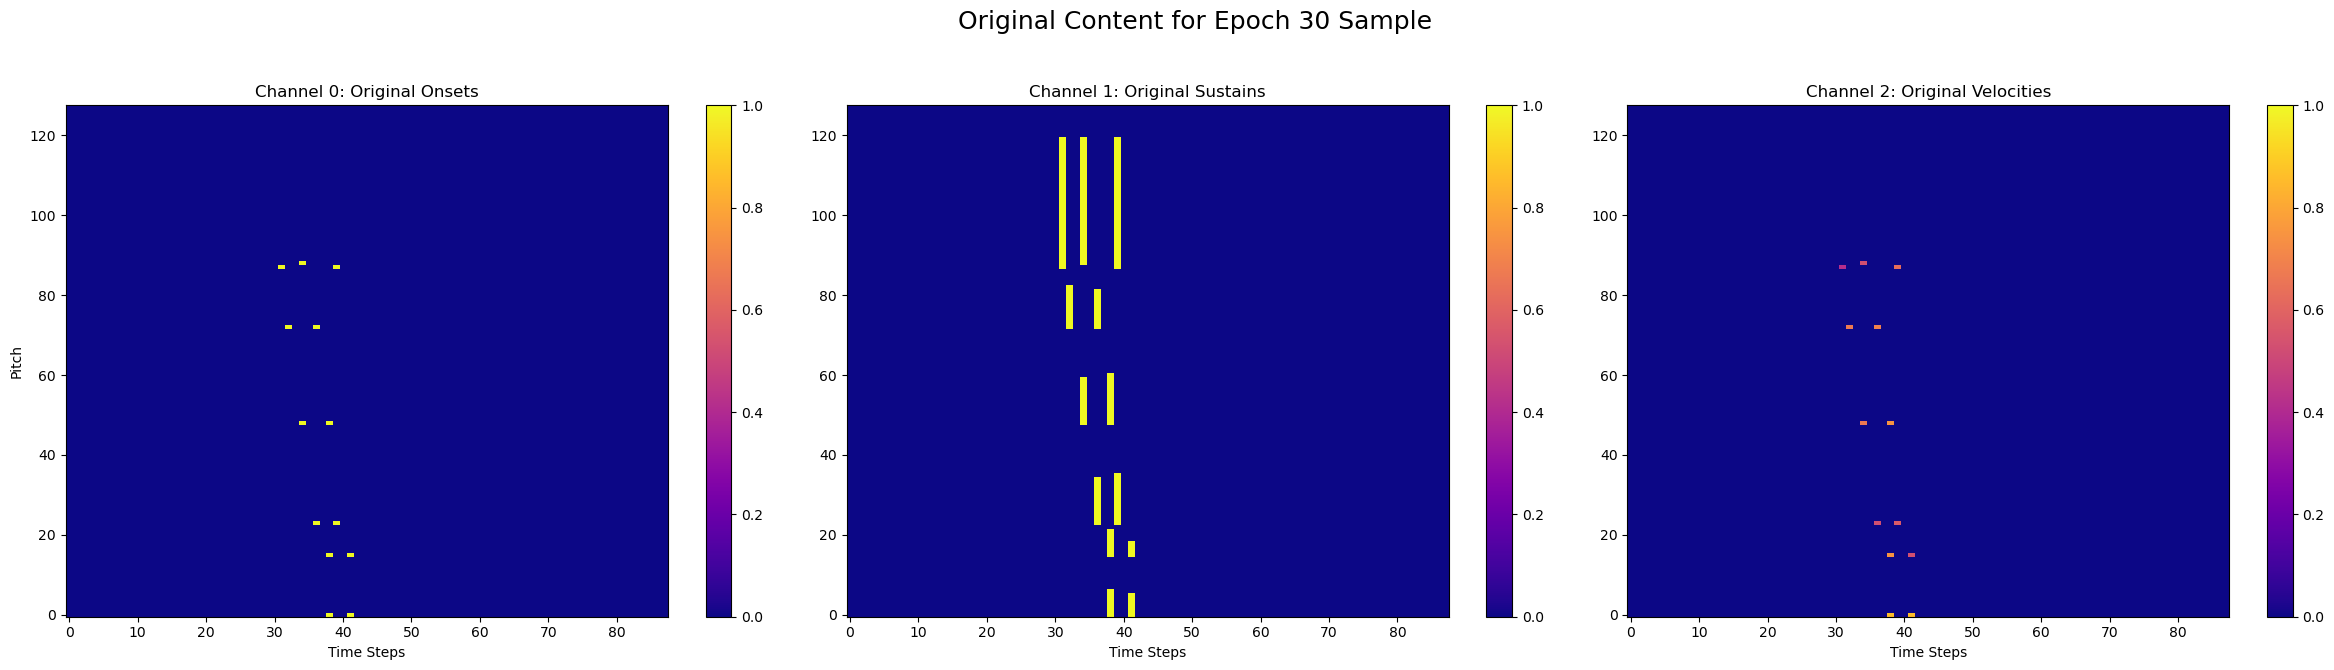

--- Visualizing: Generator Raw Output for Sample: sample_epoch_30_generated ---


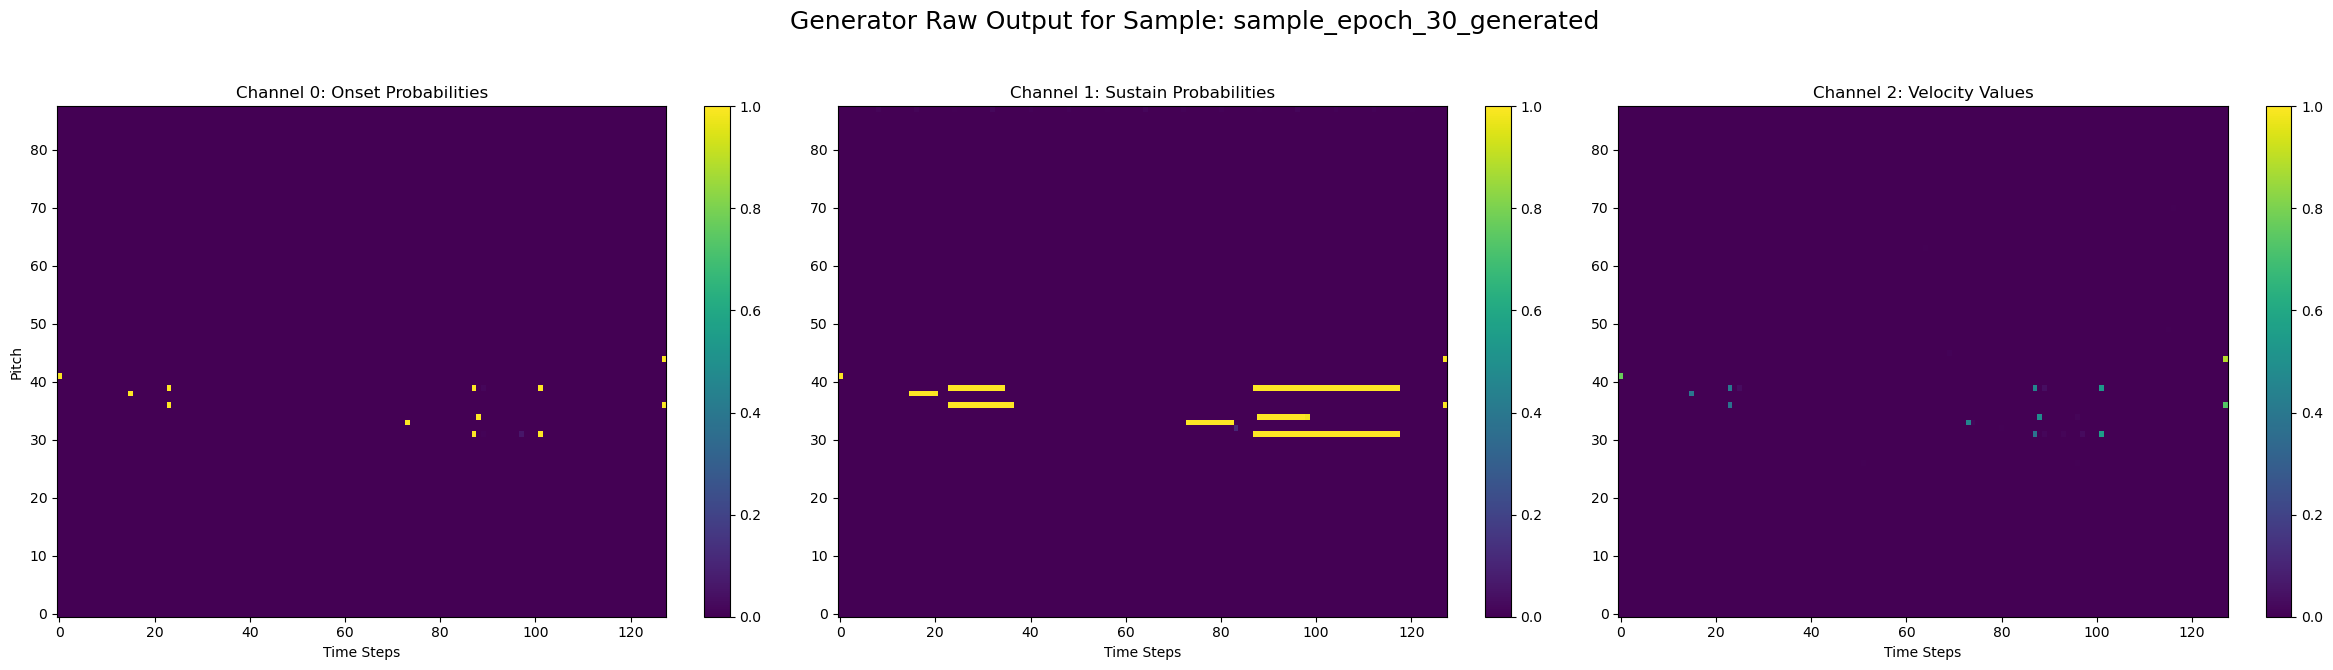

PPO Epoch 31/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.701, D(w=0.10)=0.507, G(w=0.70)=0.485, R_total=0.531]


Epoch 31 Summary: Avg Reward: 0.5419 | Genre: 0.4911 (w=0.70), Chroma: 0.7224 (w=0.20), Discrim: 0.5361 (w=0.10)
  Avg reward did not improve. Patience: 4/15


PPO Epoch 32/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.740, D(w=0.10)=0.545, G(w=0.70)=0.459, R_total=0.524]


Epoch 32 Summary: Avg Reward: 0.5415 | Genre: 0.4906 (w=0.70), Chroma: 0.7223 (w=0.20), Discrim: 0.5363 (w=0.10)
  Avg reward did not improve. Patience: 5/15


PPO Epoch 33/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.706, D(w=0.10)=0.510, G(w=0.70)=0.481, R_total=0.529]


Epoch 33 Summary: Avg Reward: 0.5420 | Genre: 0.4913 (w=0.70), Chroma: 0.7223 (w=0.20), Discrim: 0.5362 (w=0.10)
  Avg reward did not improve. Patience: 6/15


PPO Epoch 34/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.703, D(w=0.10)=0.568, G(w=0.70)=0.469, R_total=0.526]


Epoch 34 Summary: Avg Reward: 0.5419 | Genre: 0.4912 (w=0.70), Chroma: 0.7223 (w=0.20), Discrim: 0.5363 (w=0.10)
  Avg reward did not improve. Patience: 7/15


PPO Epoch 35/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.697, D(w=0.10)=0.519, G(w=0.70)=0.525, R_total=0.559]


Epoch 35 Summary: Avg Reward: 0.5416 | Genre: 0.4908 (w=0.70), Chroma: 0.7223 (w=0.20), Discrim: 0.5361 (w=0.10)
  Avg reward did not improve. Patience: 8/15

--- Saving sample for epoch 35 ---
--- Visualizing: Original Content for Epoch 35 Sample ---


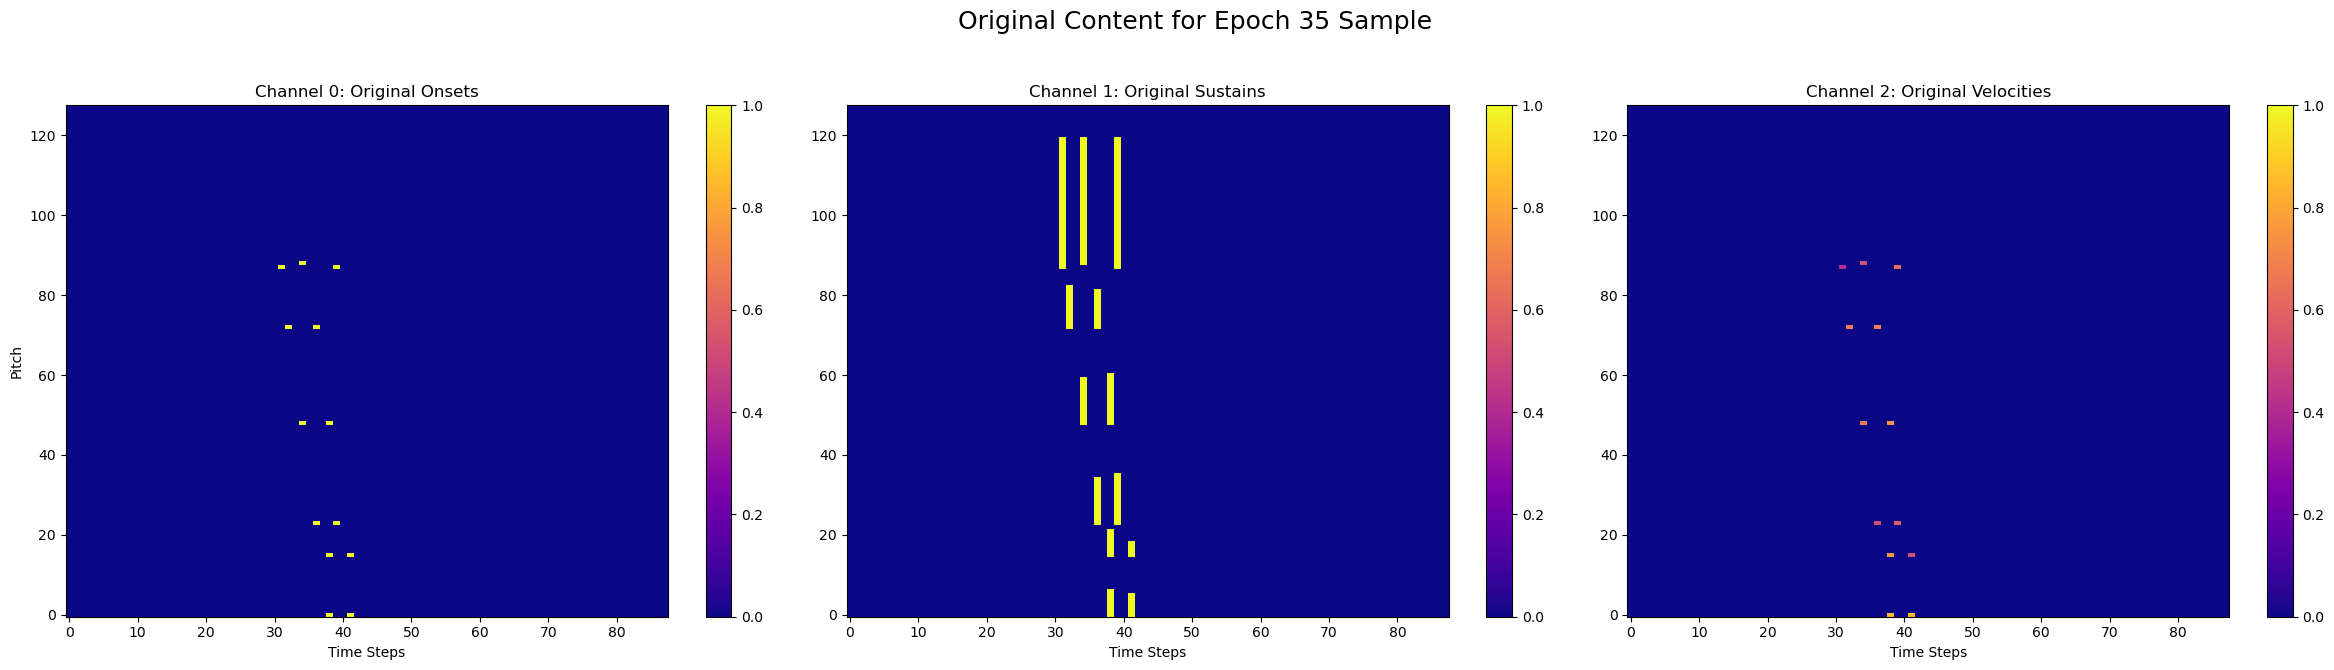

--- Visualizing: Generator Raw Output for Sample: sample_epoch_35_generated ---


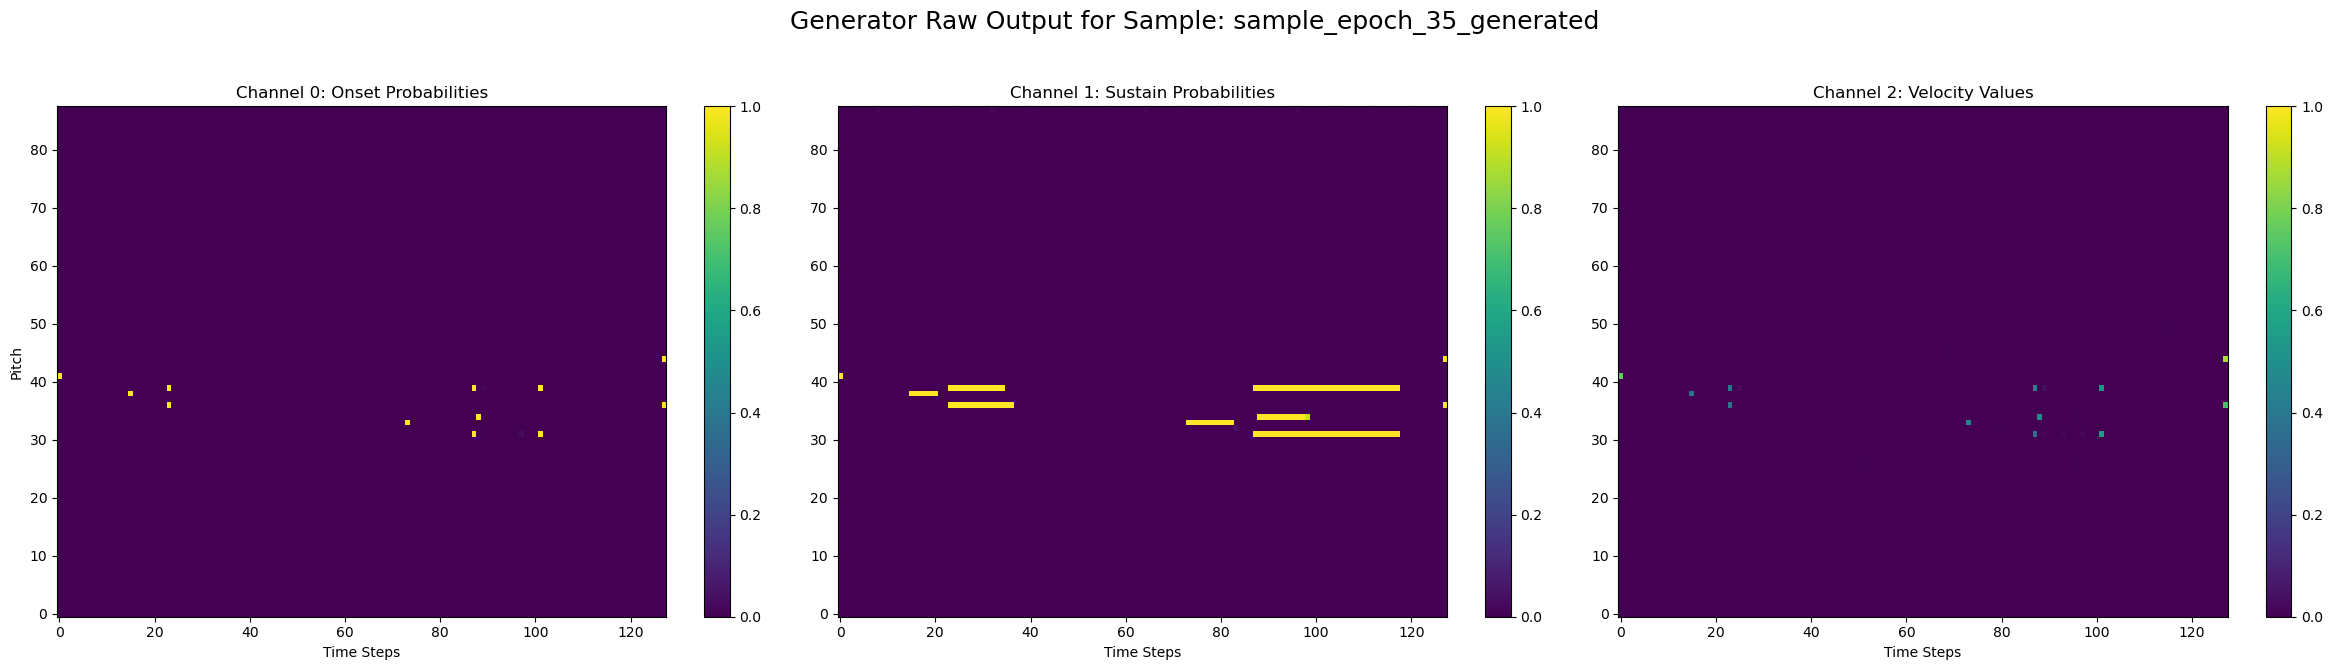

PPO Epoch 36/50: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s, C(w=0.20)=0.697, D(w=0.10)=0.495, G(w=0.70)=0.479, R_total=0.524]


Epoch 36 Summary: Avg Reward: 0.5395 | Genre: 0.4878 (w=0.70), Chroma: 0.7223 (w=0.20), Discrim: 0.5354 (w=0.10)
  Avg reward did not improve. Patience: 9/15


PPO Epoch 37/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.704, D(w=0.10)=0.536, G(w=0.70)=0.500, R_total=0.544]


Epoch 37 Summary: Avg Reward: 0.5394 | Genre: 0.4877 (w=0.70), Chroma: 0.7222 (w=0.20), Discrim: 0.5358 (w=0.10)
  Avg reward did not improve. Patience: 10/15


PPO Epoch 38/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.723, D(w=0.10)=0.550, G(w=0.70)=0.493, R_total=0.545]


Epoch 38 Summary: Avg Reward: 0.5410 | Genre: 0.4899 (w=0.70), Chroma: 0.7222 (w=0.20), Discrim: 0.5362 (w=0.10)
  Avg reward did not improve. Patience: 11/15


PPO Epoch 39/50: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s, C(w=0.20)=0.713, D(w=0.10)=0.568, G(w=0.70)=0.502, R_total=0.551]


Epoch 39 Summary: Avg Reward: 0.5410 | Genre: 0.4900 (w=0.70), Chroma: 0.7222 (w=0.20), Discrim: 0.5361 (w=0.10)
  Avg reward did not improve. Patience: 12/15


PPO Epoch 40/50: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, C(w=0.20)=0.678, D(w=0.10)=0.516, G(w=0.70)=0.459, R_total=0.509]


Epoch 40 Summary: Avg Reward: 0.5397 | Genre: 0.4881 (w=0.70), Chroma: 0.7222 (w=0.20), Discrim: 0.5359 (w=0.10)
  Avg reward did not improve. Patience: 13/15

--- Saving sample for epoch 40 ---
--- Visualizing: Original Content for Epoch 40 Sample ---


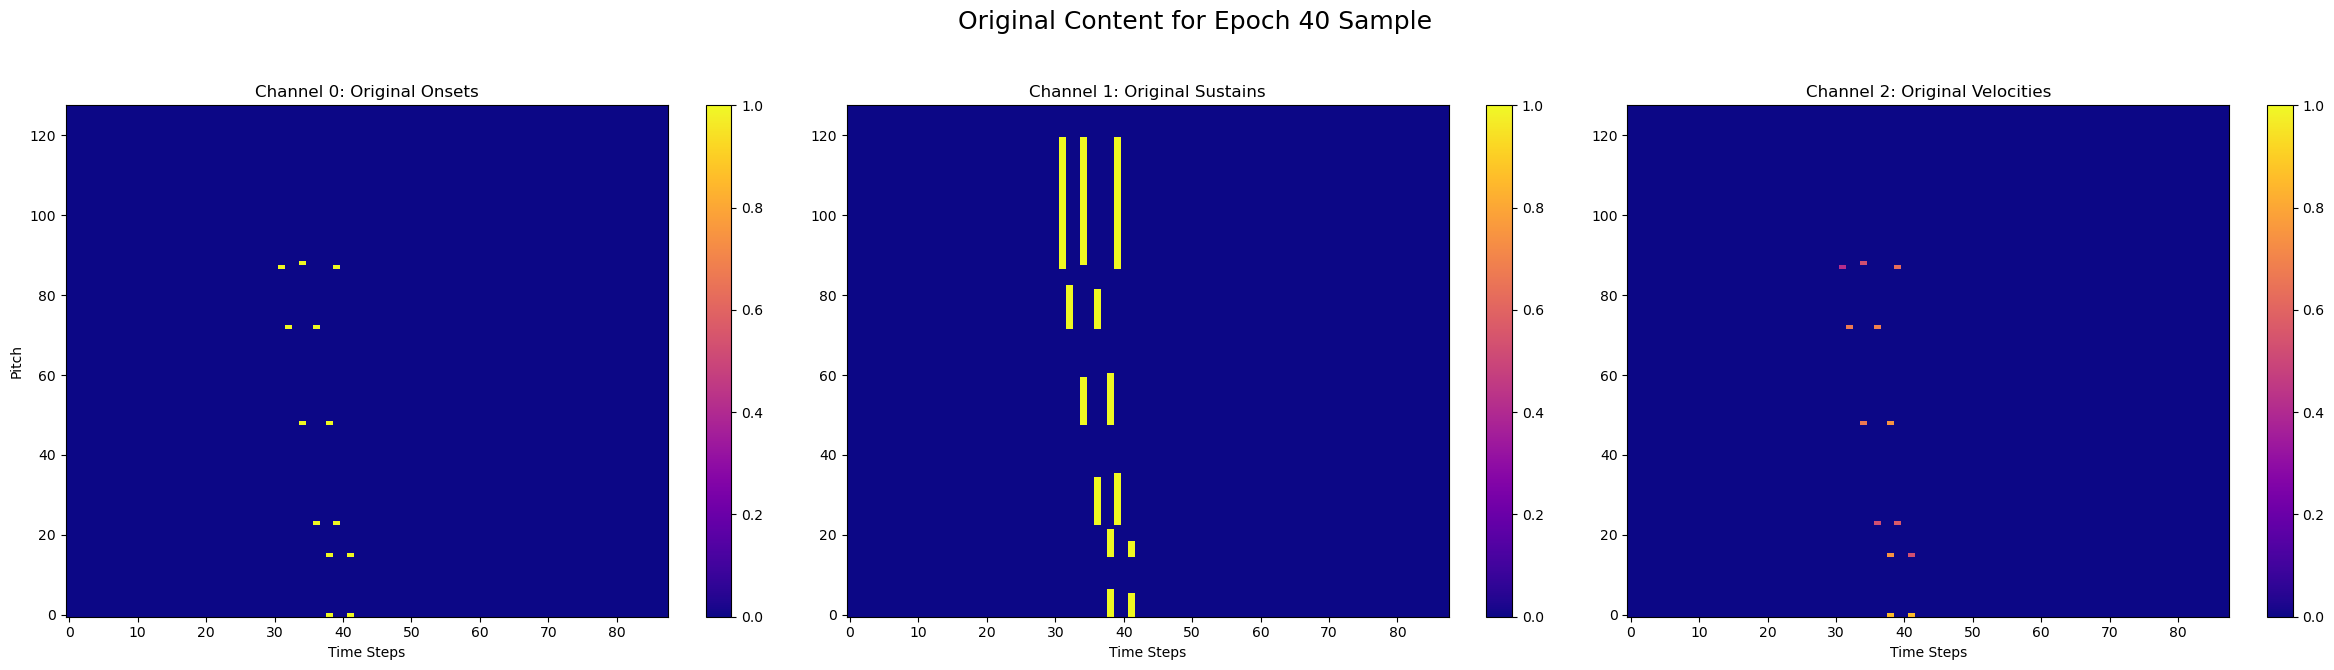

--- Visualizing: Generator Raw Output for Sample: sample_epoch_40_generated ---


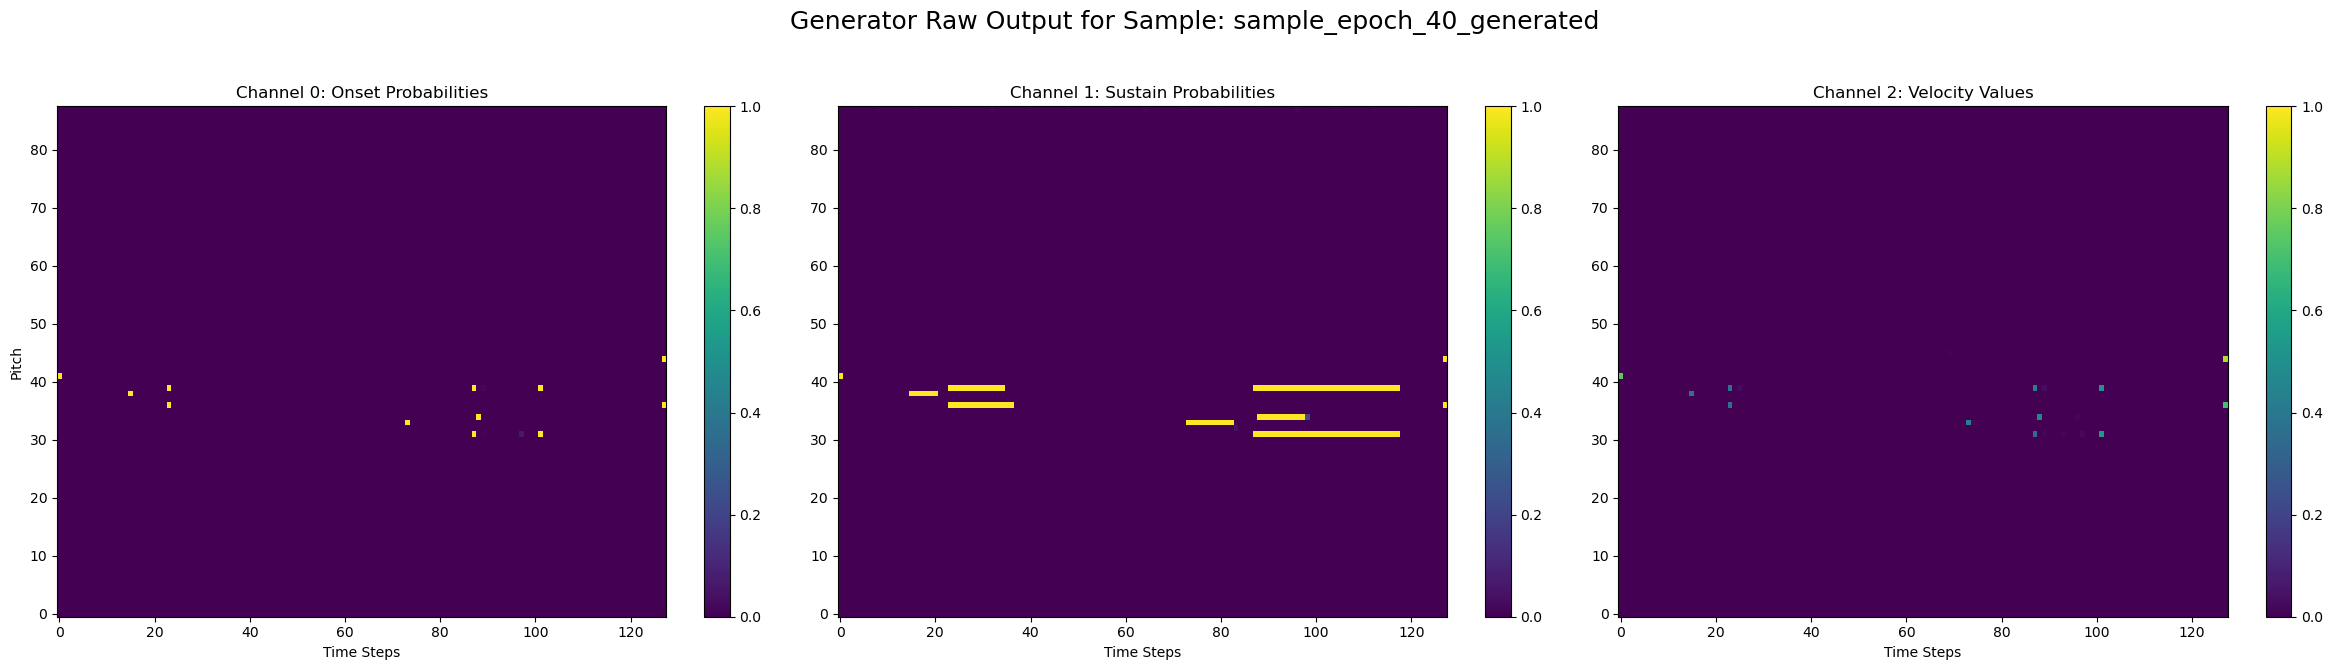

PPO Epoch 41/50: 100%|██████████| 49/49 [00:38<00:00,  1.28it/s, C(w=0.20)=0.739, D(w=0.10)=0.563, G(w=0.70)=0.467, R_total=0.531]


Epoch 41 Summary: Avg Reward: 0.5385 | Genre: 0.4865 (w=0.70), Chroma: 0.7222 (w=0.20), Discrim: 0.5352 (w=0.10)
  Avg reward did not improve. Patience: 14/15


PPO Epoch 42/50: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s, C(w=0.20)=0.730, D(w=0.10)=0.512, G(w=0.70)=0.452, R_total=0.513]

Epoch 42 Summary: Avg Reward: 0.5380 | Genre: 0.4857 (w=0.70), Chroma: 0.7222 (w=0.20), Discrim: 0.5359 (w=0.10)
  Avg reward did not improve. Patience: 15/15

--- Early stopping triggered after 15 epochs with no improvement. ---

--- PPO Training Complete ---

--- Generating Training Plots ---


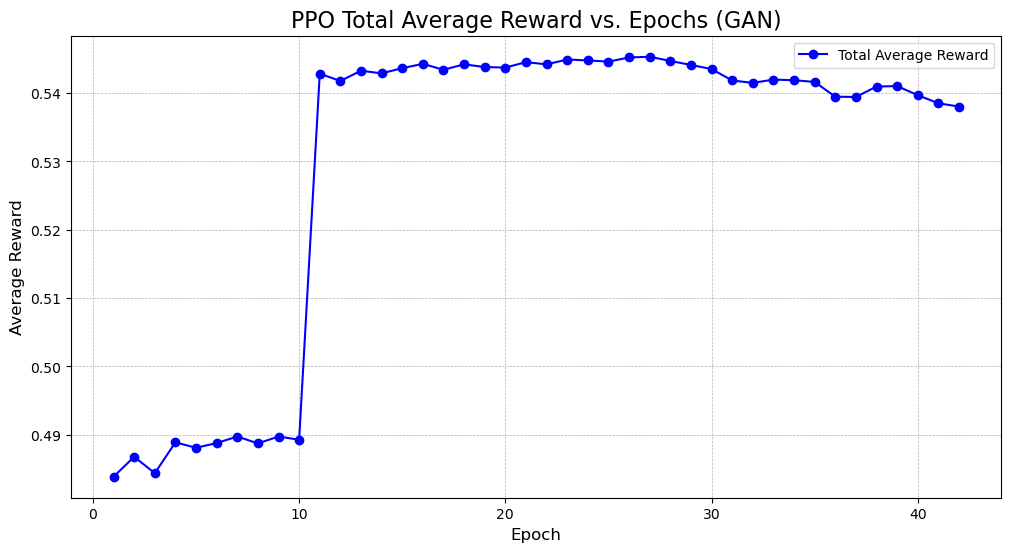

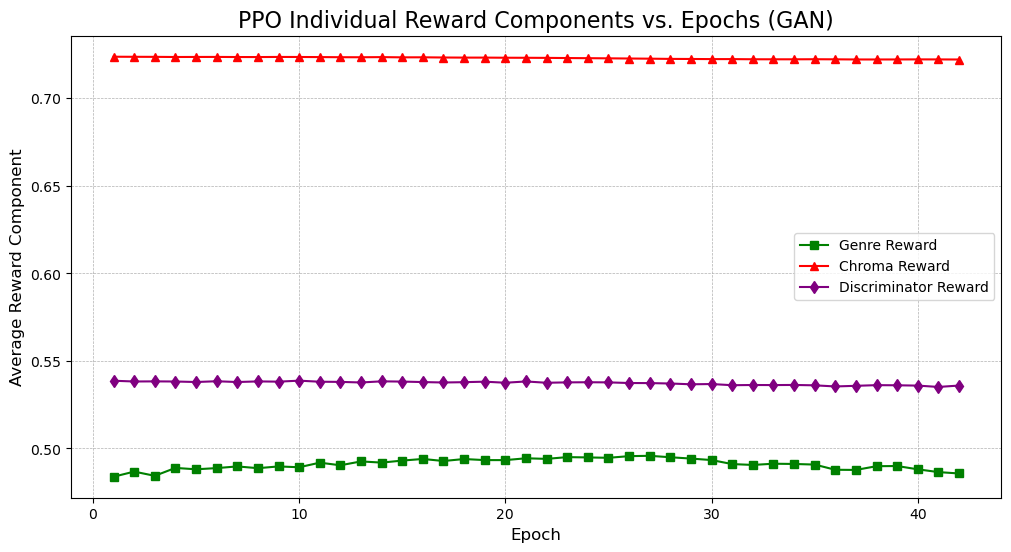

In [ ]:
if __name__ == '__main__':
    # --- CHOOSE THE MODEL TO FINE-TUNE ---
    MODEL_TO_TRAIN = 'GAN' 
    
    # --- Instantiate the trainer and run the training ---
    ppo_trainer = PPOTrainer(model_to_train=MODEL_TO_TRAIN, use_curriculum=True)
    ppo_trainer.train()

### RaGAN Training

--- Starting training for RaGAN ---
--- INITIALIZING PPO TRAINER FOR: RaGAN ---
Found existing PPO file list at: C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_ppo_training.csv
EAGERLY loading all multi-channel segments for 'PPO Non-Jazz Content' into RAM...


Loading files: 100%|██████████| 100/100 [00:00<00:00, 112.90it/s]


Eager loading complete. Total segments: 6181. Shape: (6181, 4, 88, 128)


C:\Users\User\AppData\Local\Temp\ipykernel_22476\3643325903.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.classifier.load_state_dict(torch.load(config.PRETRAINE

Successfully loaded frozen 3-channel Discriminator for reward calculation.
--- Creating an EAGER dataloader with 100 real jazz samples ---
EAGERLY loading all multi-channel segments for 'Real Jazz for RaGAN' into RAM...


Loading files: 100%|██████████| 100/100 [00:01<00:00, 56.85it/s]


Eager loading complete. Total segments: 7053. Shape: (7053, 4, 88, 128)


C:\Users\User\AppData\Local\Temp\ipykernel_22476\3643325903.py:486: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.config.PRETRAINED_GAN_CHECKPOI

Successfully loaded pre-trained RaGAN model as PPO policy.

--- Starting PPO Fine-Tuning on device: cuda ---
Searching for a non-silent batch to use for sample generation...
Found a suitable batch for sampling at index 0.


PPO Epoch 1/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.683, D(w=0.10)=0.540, G(w=0.70)=0.674, R_total=0.662]


Epoch 1 Summary: Avg Reward: 0.5771 | Genre: 0.5422 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5430 (w=0.10)
  New best average reward: 0.5771. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 2/50: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s, C(w=0.20)=0.689, D(w=0.10)=0.515, G(w=0.70)=0.491, R_total=0.533]


Epoch 2 Summary: Avg Reward: 0.5797 | Genre: 0.5458 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5439 (w=0.10)
  New best average reward: 0.5797. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 3/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.740, D(w=0.10)=0.561, G(w=0.70)=0.542, R_total=0.583]


Epoch 3 Summary: Avg Reward: 0.5786 | Genre: 0.5443 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5432 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 4/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.724, D(w=0.10)=0.523, G(w=0.70)=0.554, R_total=0.585]


Epoch 4 Summary: Avg Reward: 0.5804 | Genre: 0.5466 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5454 (w=0.10)
  New best average reward: 0.5804. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 5/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.725, D(w=0.10)=0.563, G(w=0.70)=0.543, R_total=0.581]


Epoch 5 Summary: Avg Reward: 0.5815 | Genre: 0.5485 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5433 (w=0.10)
  New best average reward: 0.5815. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---

--- Saving sample for epoch 5 ---
--- Visualizing: Original Content for Epoch 5 Sample ---


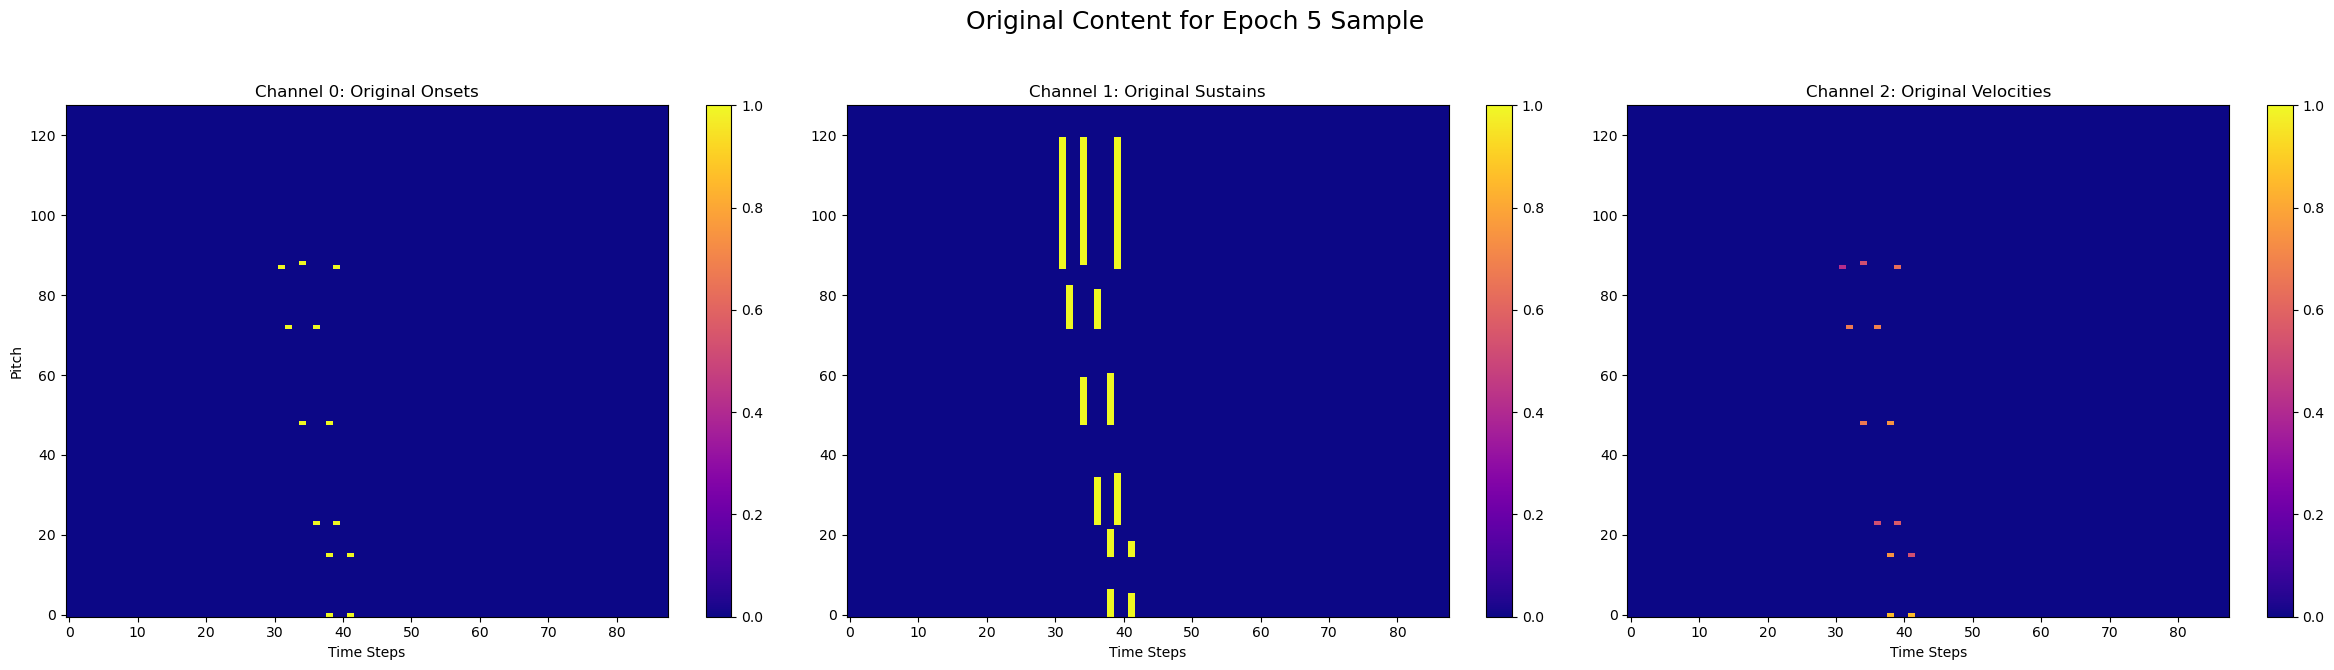

--- Visualizing: Generator Raw Output for Sample: sample_epoch_5_generated ---


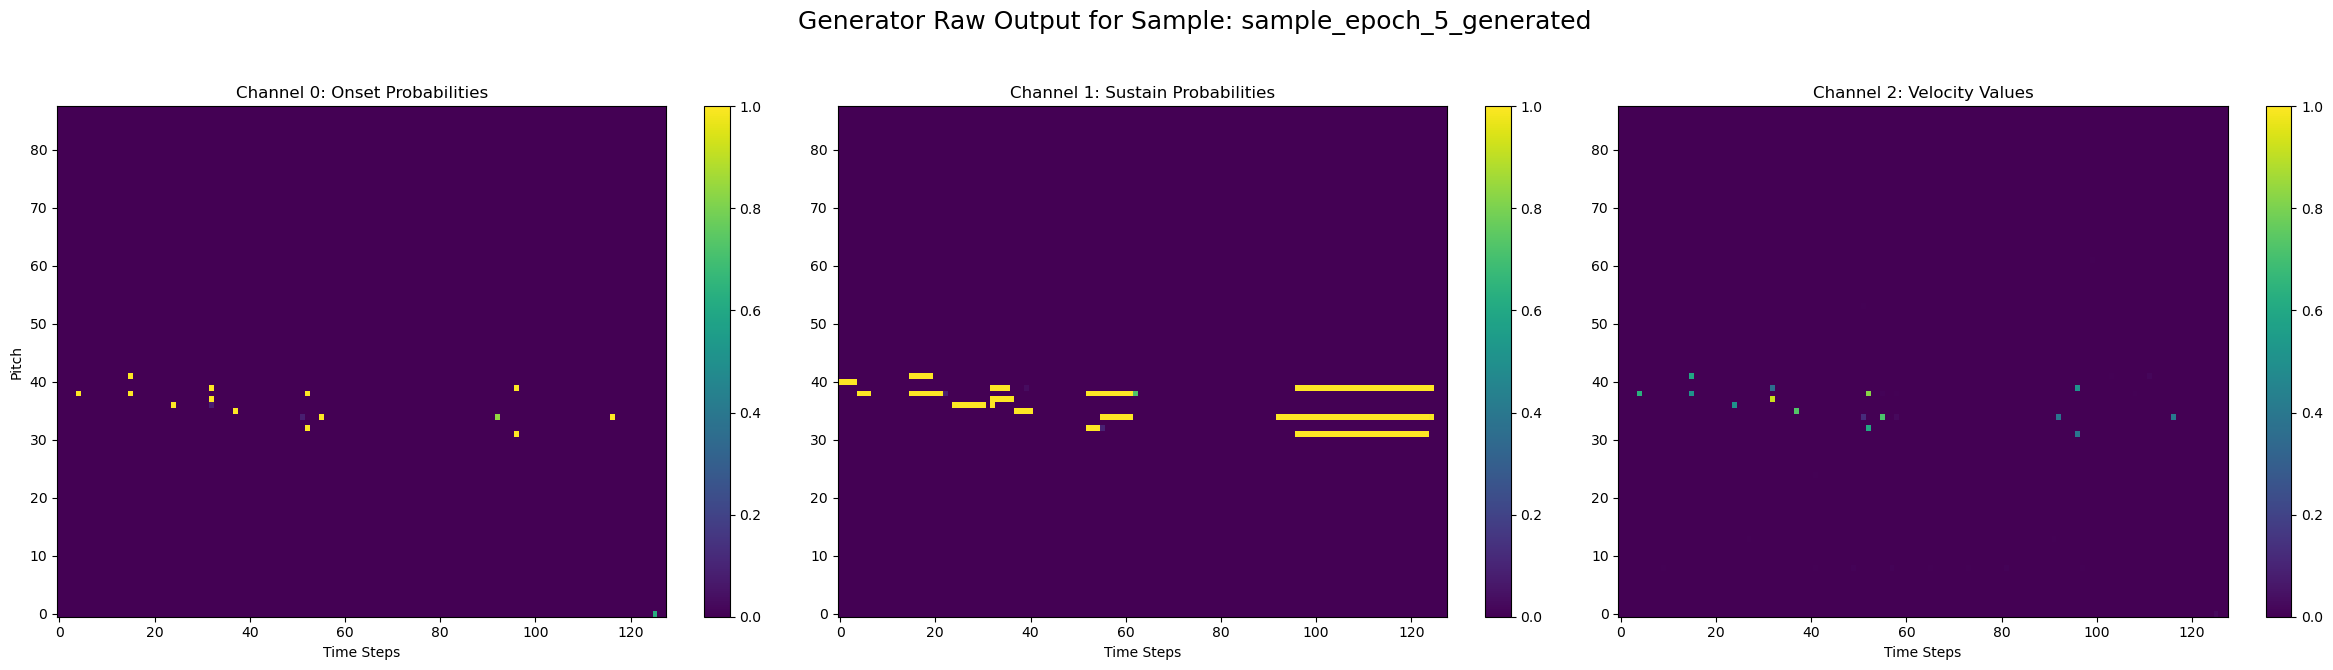

PPO Epoch 6/50: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s, C(w=0.20)=0.741, D(w=0.10)=0.555, G(w=0.70)=0.446, R_total=0.516]


Epoch 6 Summary: Avg Reward: 0.5831 | Genre: 0.5506 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5434 (w=0.10)
  New best average reward: 0.5831. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 7/50: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s, C(w=0.20)=0.710, D(w=0.10)=0.569, G(w=0.70)=0.527, R_total=0.568]


Epoch 7 Summary: Avg Reward: 0.5840 | Genre: 0.5519 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5443 (w=0.10)
  New best average reward: 0.5840. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 8/50: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s, C(w=0.20)=0.714, D(w=0.10)=0.542, G(w=0.70)=0.583, R_total=0.605]


Epoch 8 Summary: Avg Reward: 0.5872 | Genre: 0.5565 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5440 (w=0.10)
  New best average reward: 0.5872. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 9/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.691, D(w=0.10)=0.532, G(w=0.70)=0.497, R_total=0.539]


Epoch 9 Summary: Avg Reward: 0.5873 | Genre: 0.5566 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5441 (w=0.10)
  New best average reward: 0.5873. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 10/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.20)=0.728, D(w=0.10)=0.546, G(w=0.70)=0.567, R_total=0.597]


Epoch 10 Summary: Avg Reward: 0.5882 | Genre: 0.5579 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5438 (w=0.10)
  New best average reward: 0.5882. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---

--- Saving sample for epoch 10 ---
--- Visualizing: Original Content for Epoch 10 Sample ---


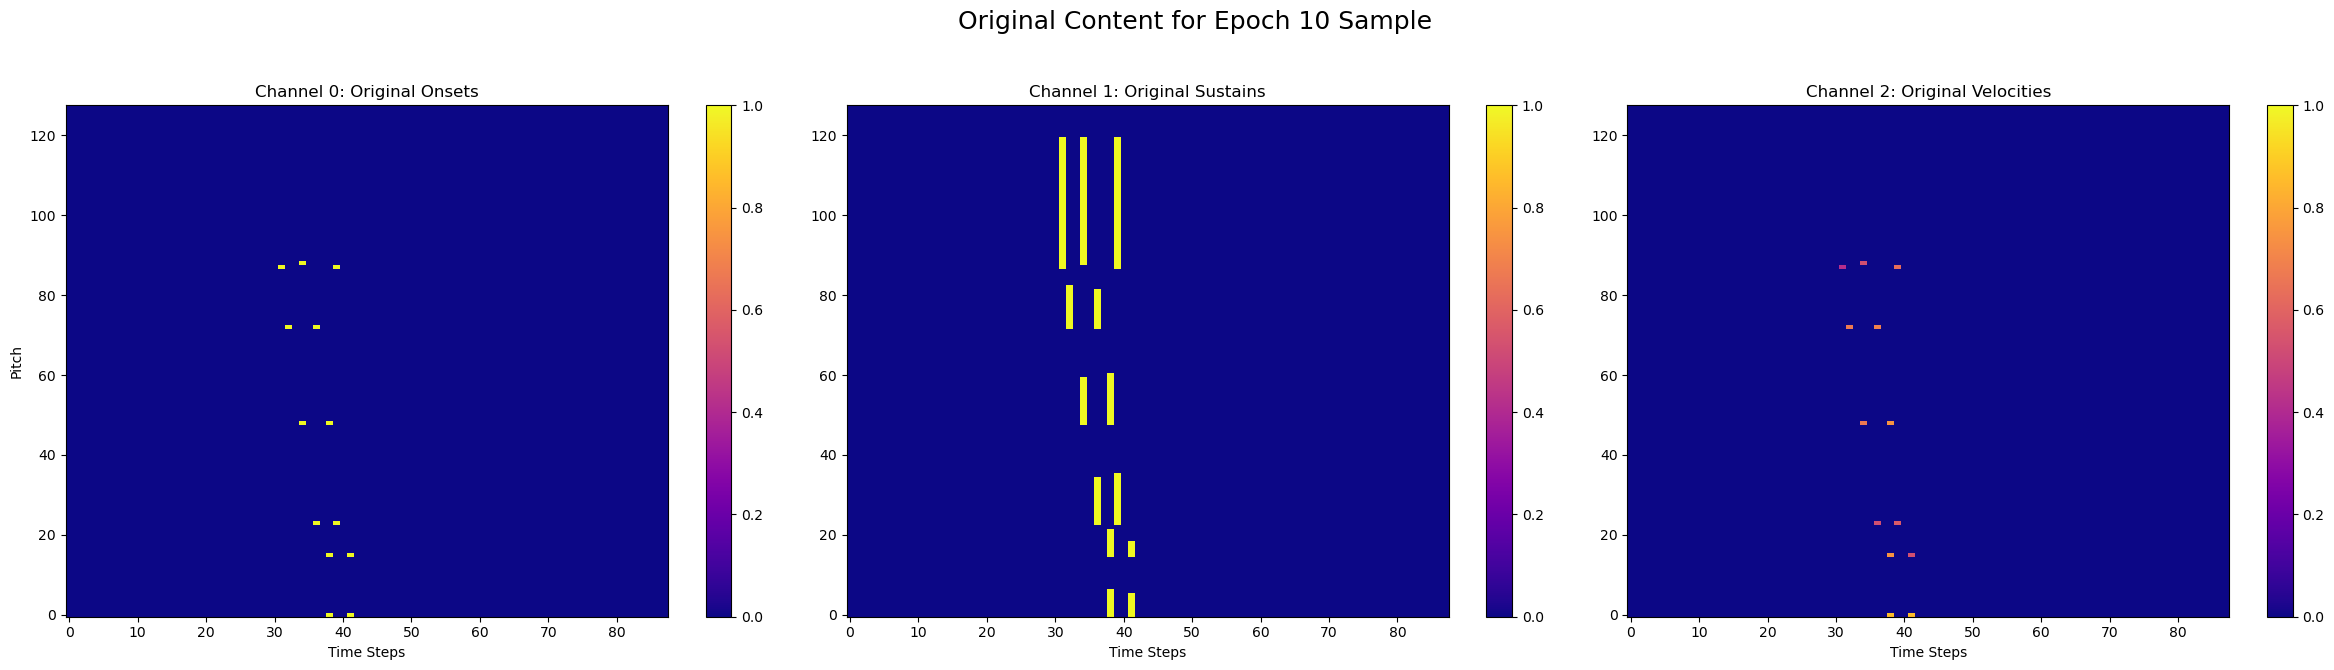

--- Visualizing: Generator Raw Output for Sample: sample_epoch_10_generated ---


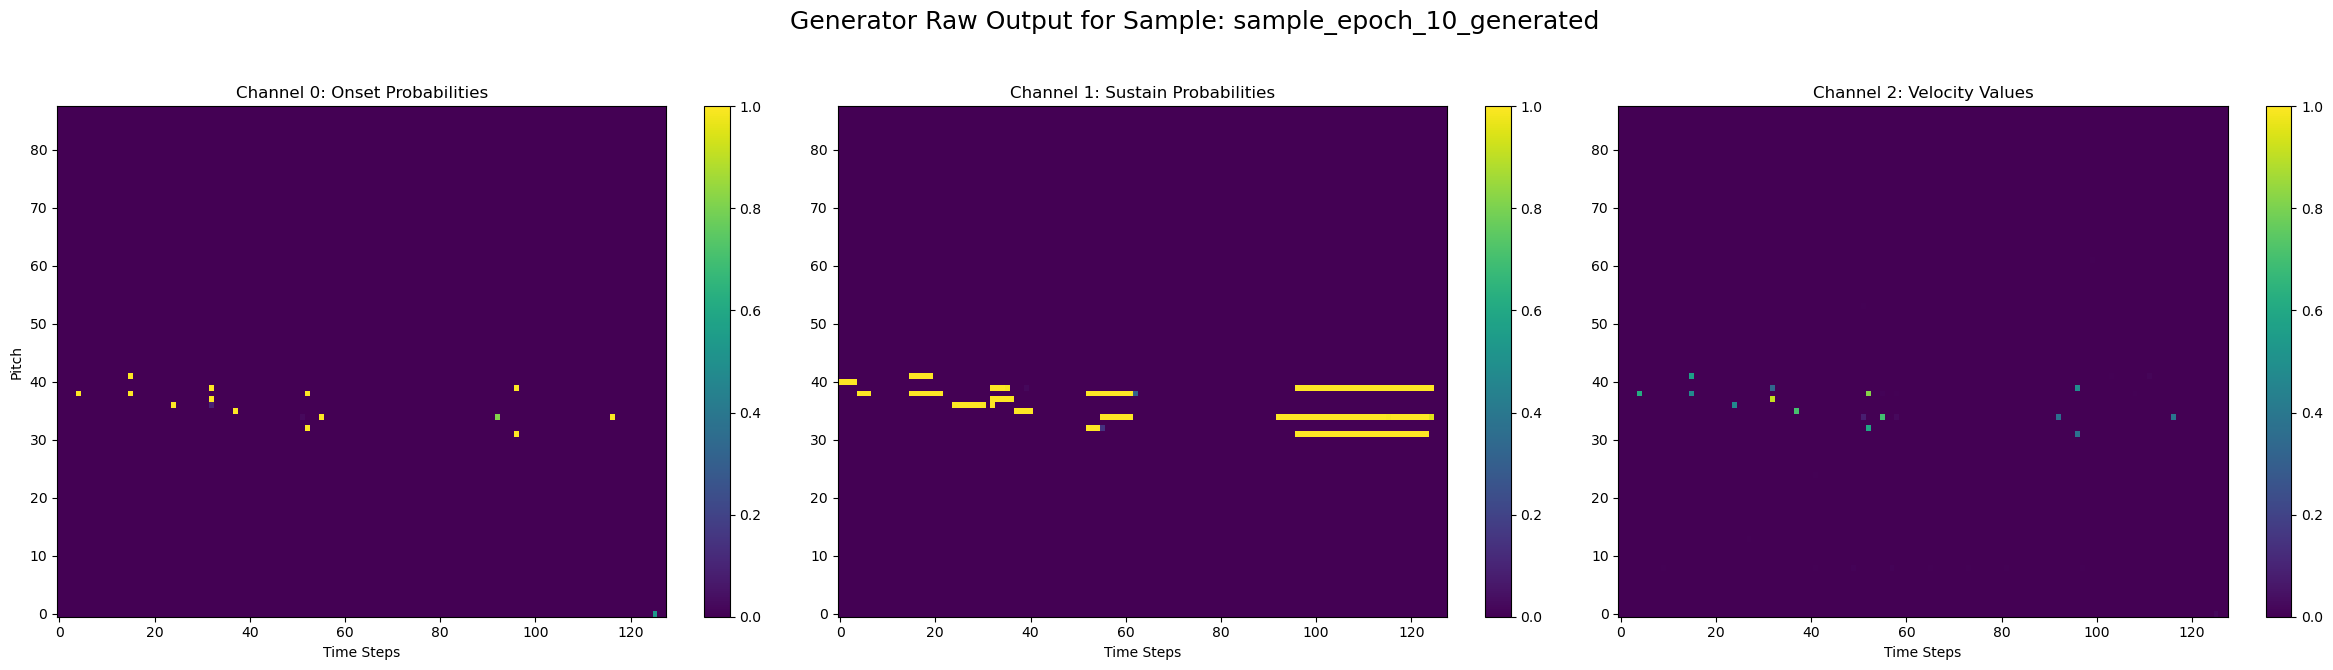

PPO Epoch 11/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.722, D(w=0.10)=0.530, G(w=0.70)=0.578, R_total=0.602]


Epoch 11 Summary: Avg Reward: 0.5897 | Genre: 0.5600 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5448 (w=0.10)
  New best average reward: 0.5897. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 12/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.706, D(w=0.10)=0.538, G(w=0.70)=0.583, R_total=0.603]


Epoch 12 Summary: Avg Reward: 0.5907 | Genre: 0.5615 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5442 (w=0.10)
  New best average reward: 0.5907. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 13/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.723, D(w=0.10)=0.546, G(w=0.70)=0.582, R_total=0.607]


Epoch 13 Summary: Avg Reward: 0.5915 | Genre: 0.5627 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5443 (w=0.10)
  New best average reward: 0.5915. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 14/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.720, D(w=0.10)=0.537, G(w=0.70)=0.570, R_total=0.597]


Epoch 14 Summary: Avg Reward: 0.5925 | Genre: 0.5639 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5457 (w=0.10)
  New best average reward: 0.5925. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 15/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.715, D(w=0.10)=0.542, G(w=0.70)=0.539, R_total=0.575]


Epoch 15 Summary: Avg Reward: 0.5942 | Genre: 0.5665 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5436 (w=0.10)
  New best average reward: 0.5942. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---

--- Saving sample for epoch 15 ---
--- Visualizing: Original Content for Epoch 15 Sample ---


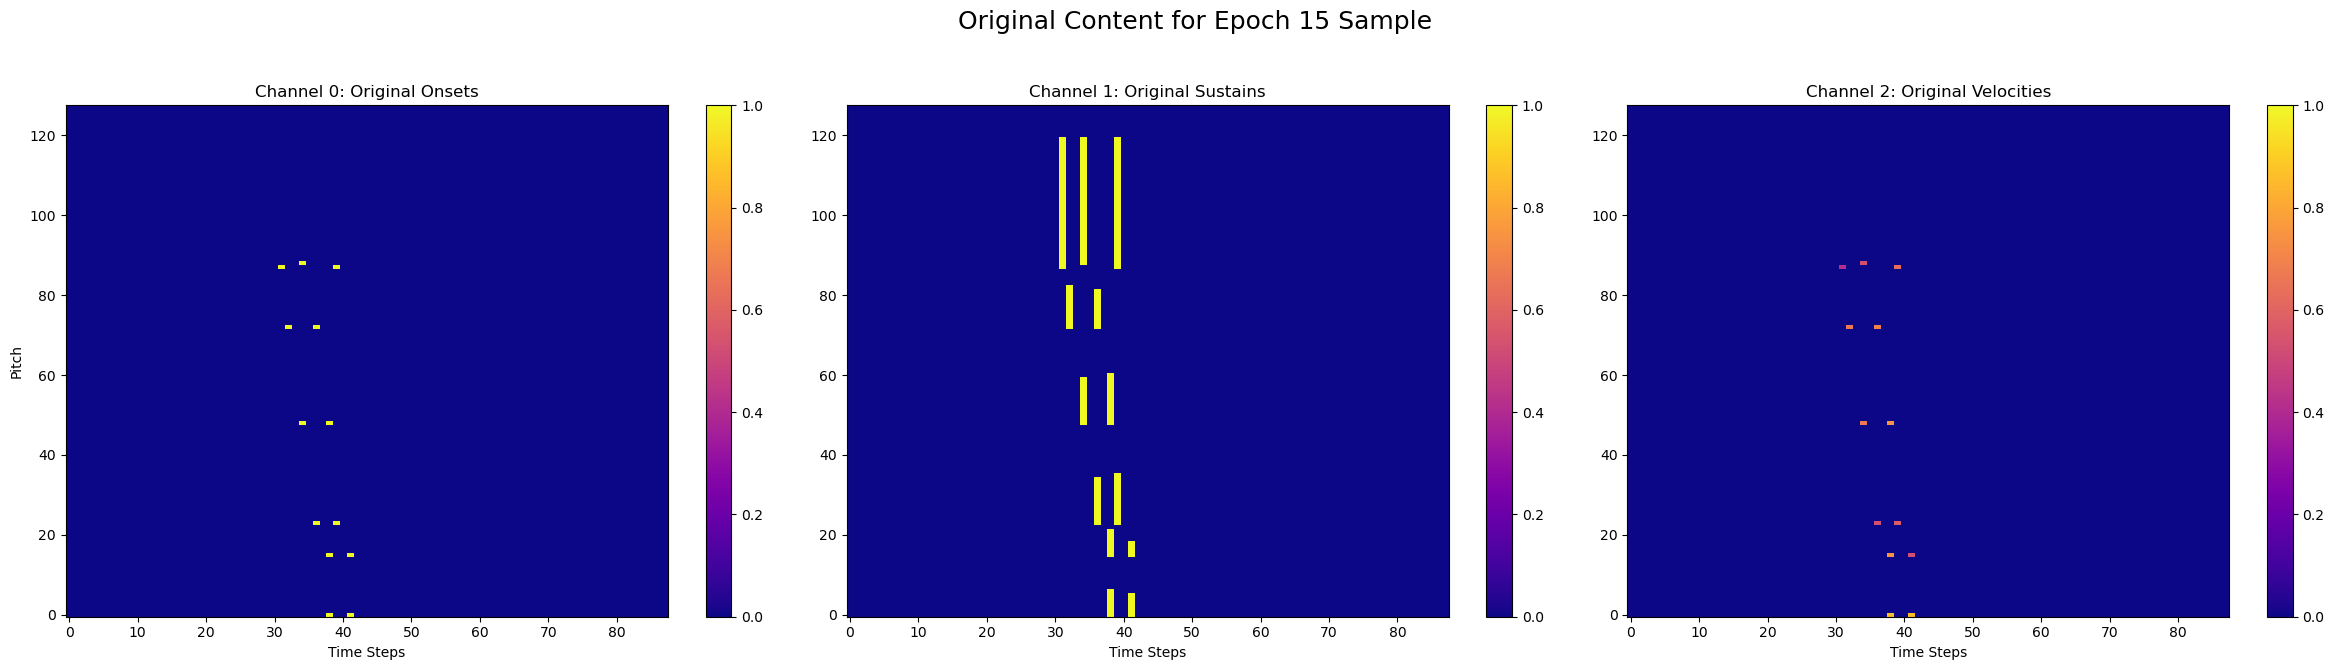

--- Visualizing: Generator Raw Output for Sample: sample_epoch_15_generated ---


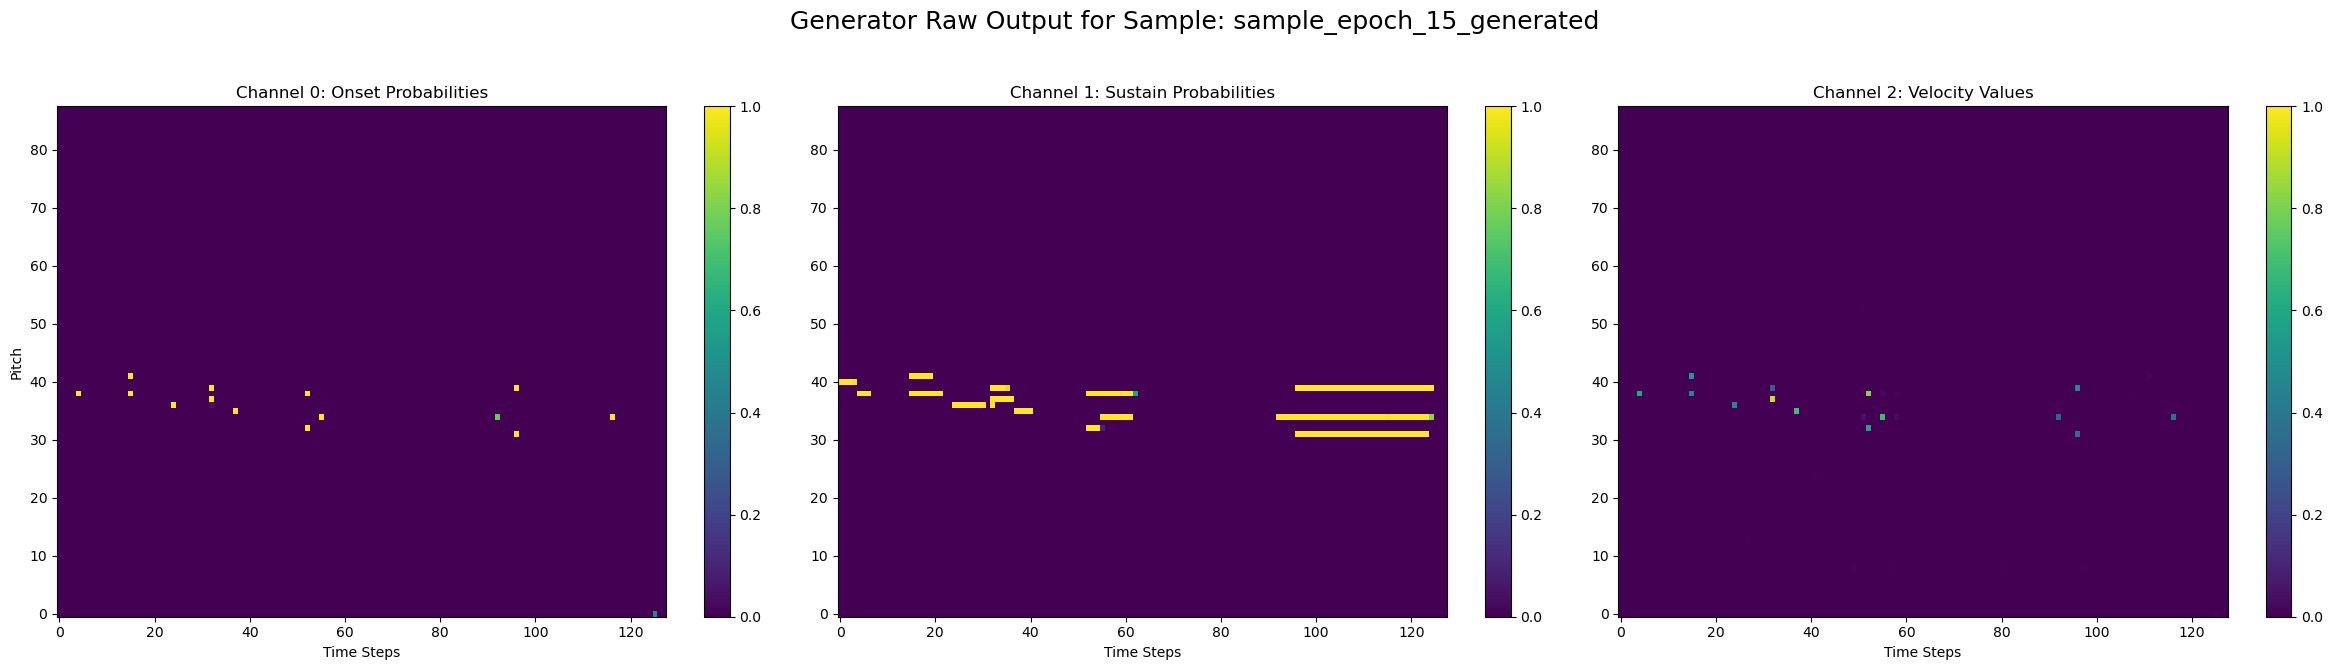

PPO Epoch 16/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.704, D(w=0.10)=0.501, G(w=0.70)=0.580, R_total=0.597]


Epoch 16 Summary: Avg Reward: 0.5955 | Genre: 0.5683 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5439 (w=0.10)
  New best average reward: 0.5955. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 17/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.729, D(w=0.10)=0.545, G(w=0.70)=0.576, R_total=0.604]


Epoch 17 Summary: Avg Reward: 0.5959 | Genre: 0.5689 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5442 (w=0.10)
  New best average reward: 0.5959. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 18/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.721, D(w=0.10)=0.537, G(w=0.70)=0.608, R_total=0.623]


Epoch 18 Summary: Avg Reward: 0.5977 | Genre: 0.5713 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5449 (w=0.10)
  New best average reward: 0.5977. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 19/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.689, D(w=0.10)=0.522, G(w=0.70)=0.498, R_total=0.538]


Epoch 19 Summary: Avg Reward: 0.5982 | Genre: 0.5721 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5445 (w=0.10)
  New best average reward: 0.5982. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 20/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.722, D(w=0.10)=0.536, G(w=0.70)=0.533, R_total=0.571]


Epoch 20 Summary: Avg Reward: 0.5982 | Genre: 0.5721 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5445 (w=0.10)
  Avg reward did not improve. Patience: 1/15

--- Saving sample for epoch 20 ---
--- Visualizing: Original Content for Epoch 20 Sample ---


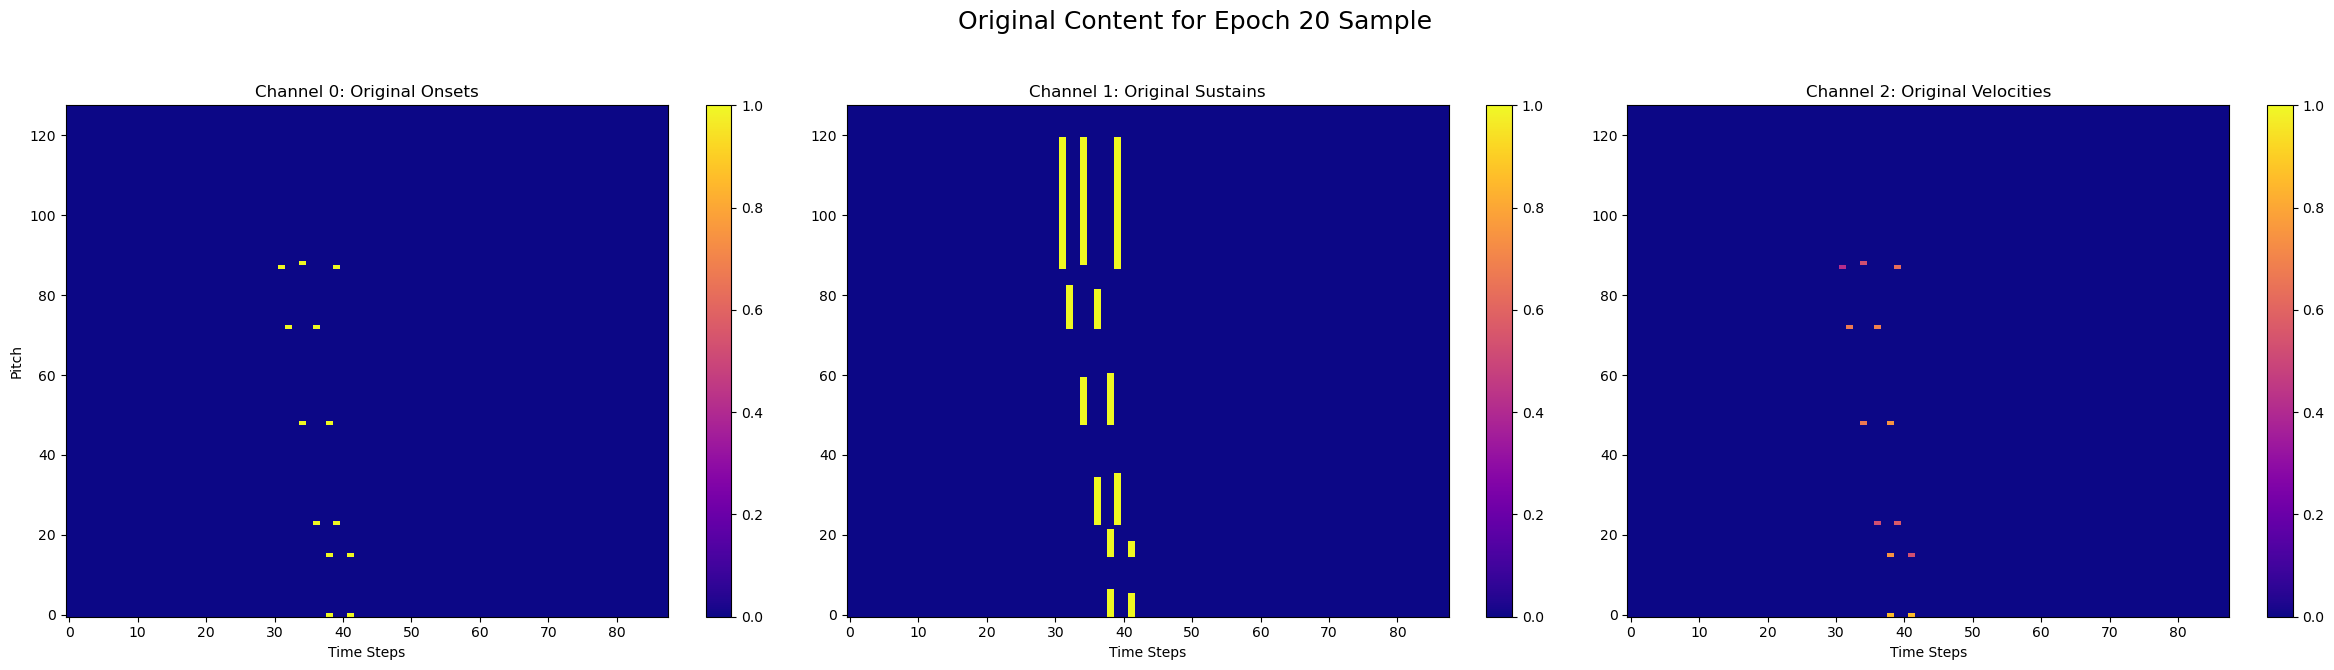

--- Visualizing: Generator Raw Output for Sample: sample_epoch_20_generated ---


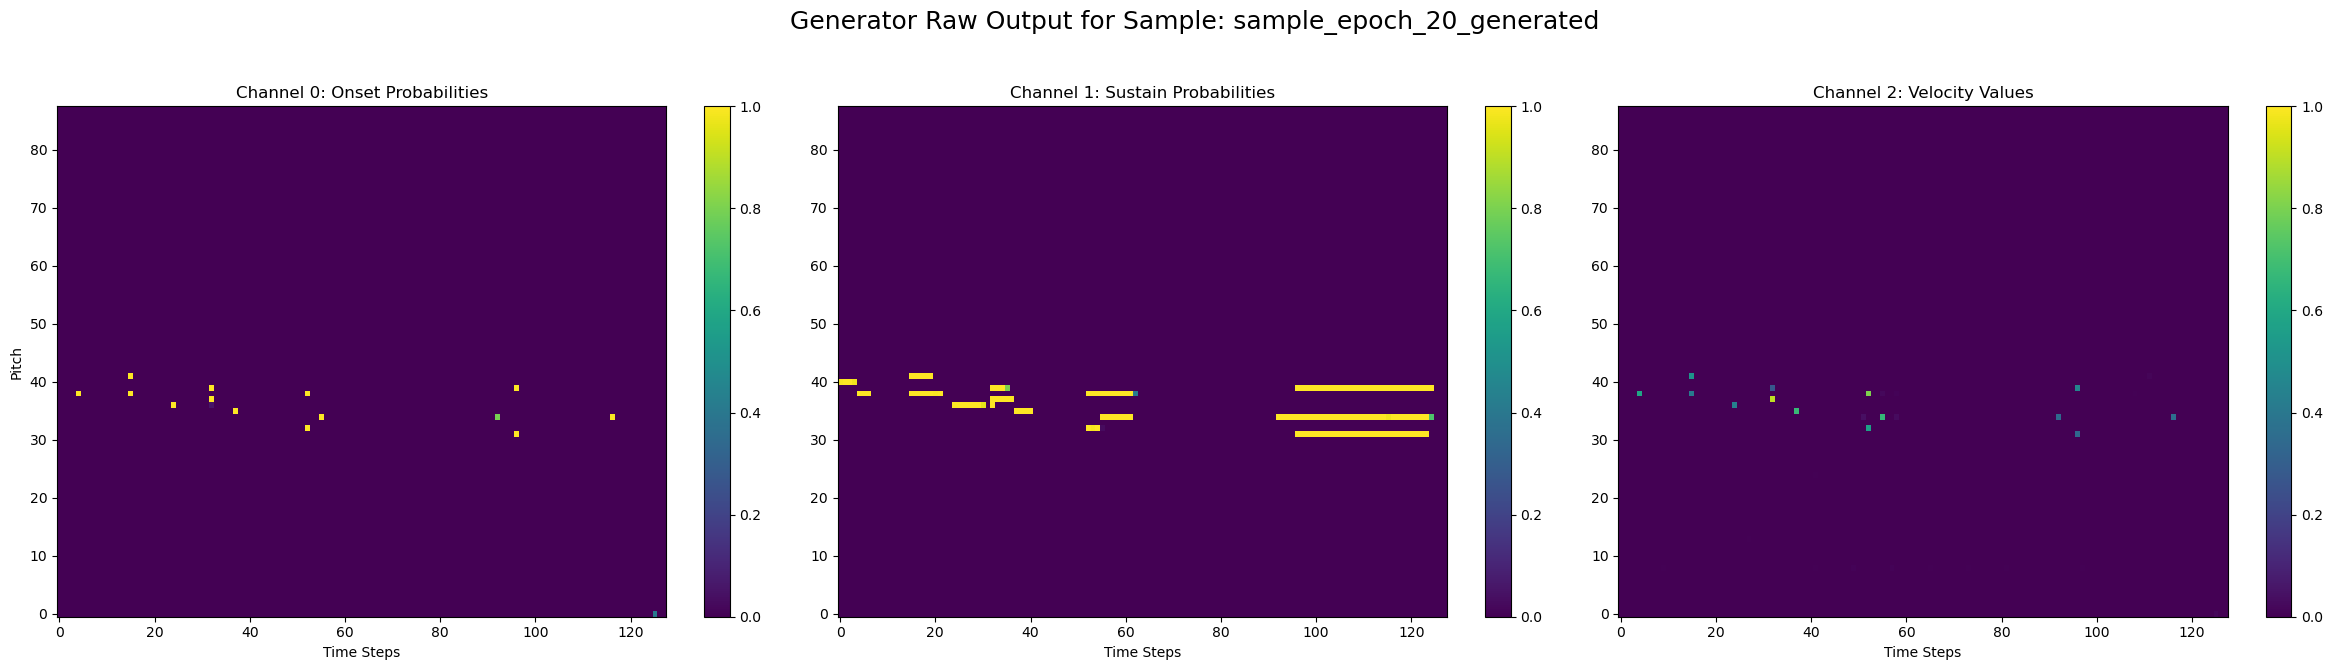

PPO Epoch 21/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.742, D(w=0.10)=0.569, G(w=0.70)=0.600, R_total=0.625]


Epoch 21 Summary: Avg Reward: 0.5985 | Genre: 0.5726 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5447 (w=0.10)
  New best average reward: 0.5985. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 22/50: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s, C(w=0.20)=0.733, D(w=0.10)=0.581, G(w=0.70)=0.542, R_total=0.584]


Epoch 22 Summary: Avg Reward: 0.5988 | Genre: 0.5732 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5431 (w=0.10)
  New best average reward: 0.5988. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 23/50: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s, C(w=0.20)=0.705, D(w=0.10)=0.571, G(w=0.70)=0.576, R_total=0.601]


Epoch 23 Summary: Avg Reward: 0.6009 | Genre: 0.5760 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5447 (w=0.10)
  New best average reward: 0.6009. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 24/50: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s, C(w=0.20)=0.714, D(w=0.10)=0.579, G(w=0.70)=0.620, R_total=0.635]


Epoch 24 Summary: Avg Reward: 0.6014 | Genre: 0.5769 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5439 (w=0.10)
  New best average reward: 0.6014. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 25/50: 100%|██████████| 49/49 [00:47<00:00,  1.02it/s, C(w=0.20)=0.710, D(w=0.10)=0.538, G(w=0.70)=0.513, R_total=0.555]


Epoch 25 Summary: Avg Reward: 0.6032 | Genre: 0.5794 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5440 (w=0.10)
  New best average reward: 0.6032. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---

--- Saving sample for epoch 25 ---
--- Visualizing: Original Content for Epoch 25 Sample ---


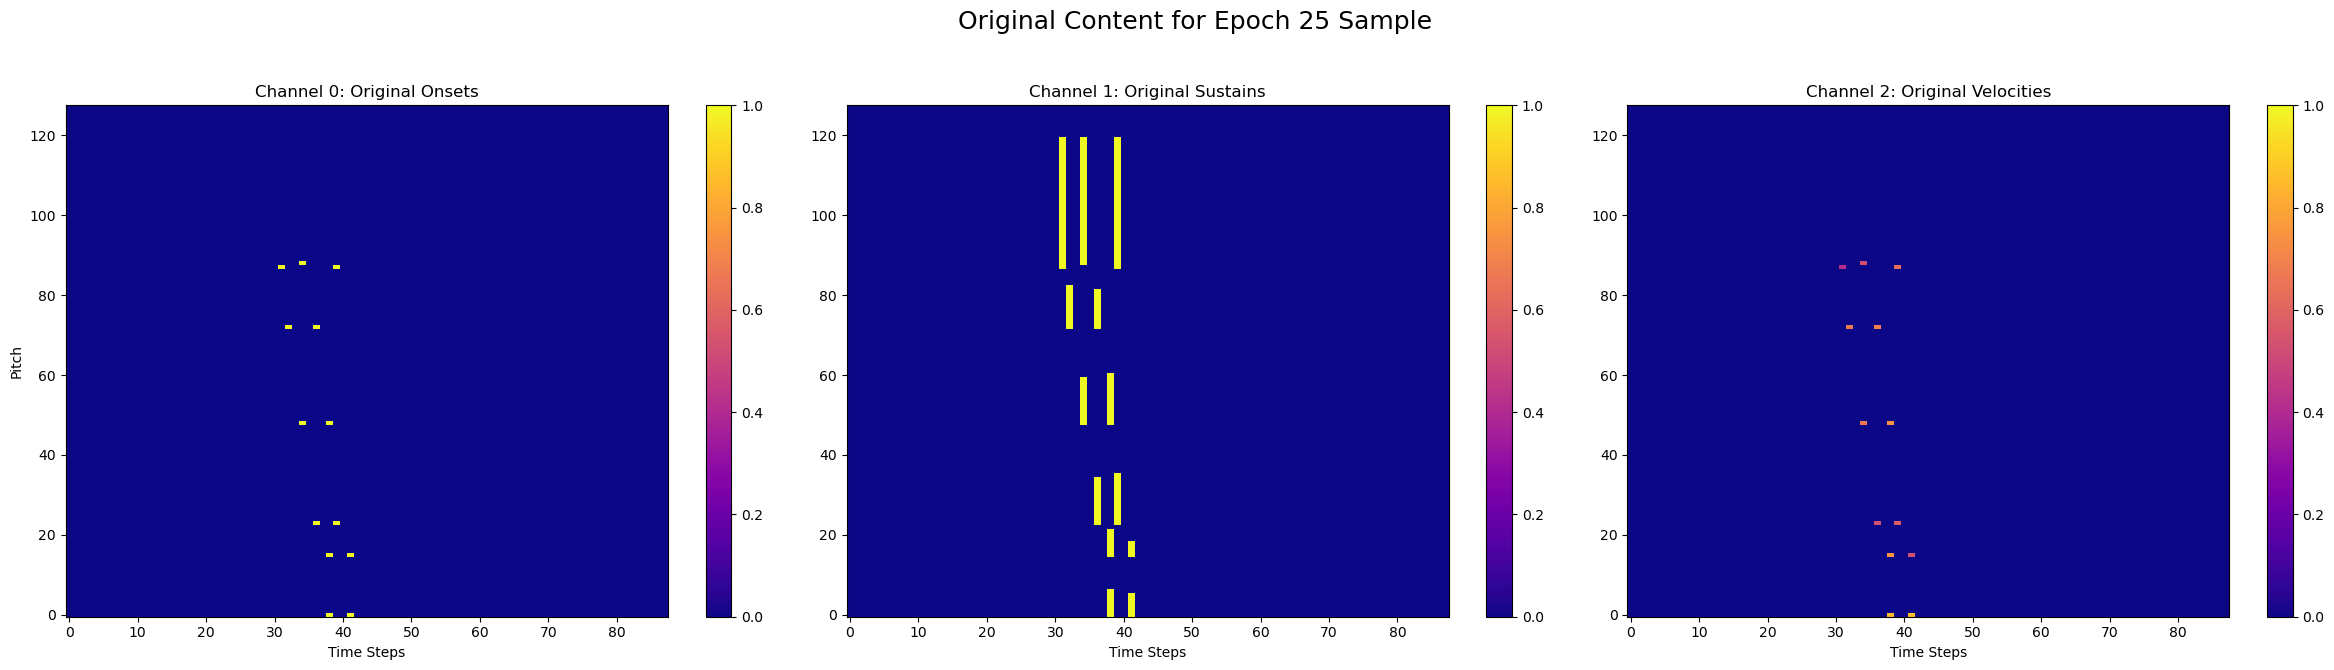

--- Visualizing: Generator Raw Output for Sample: sample_epoch_25_generated ---


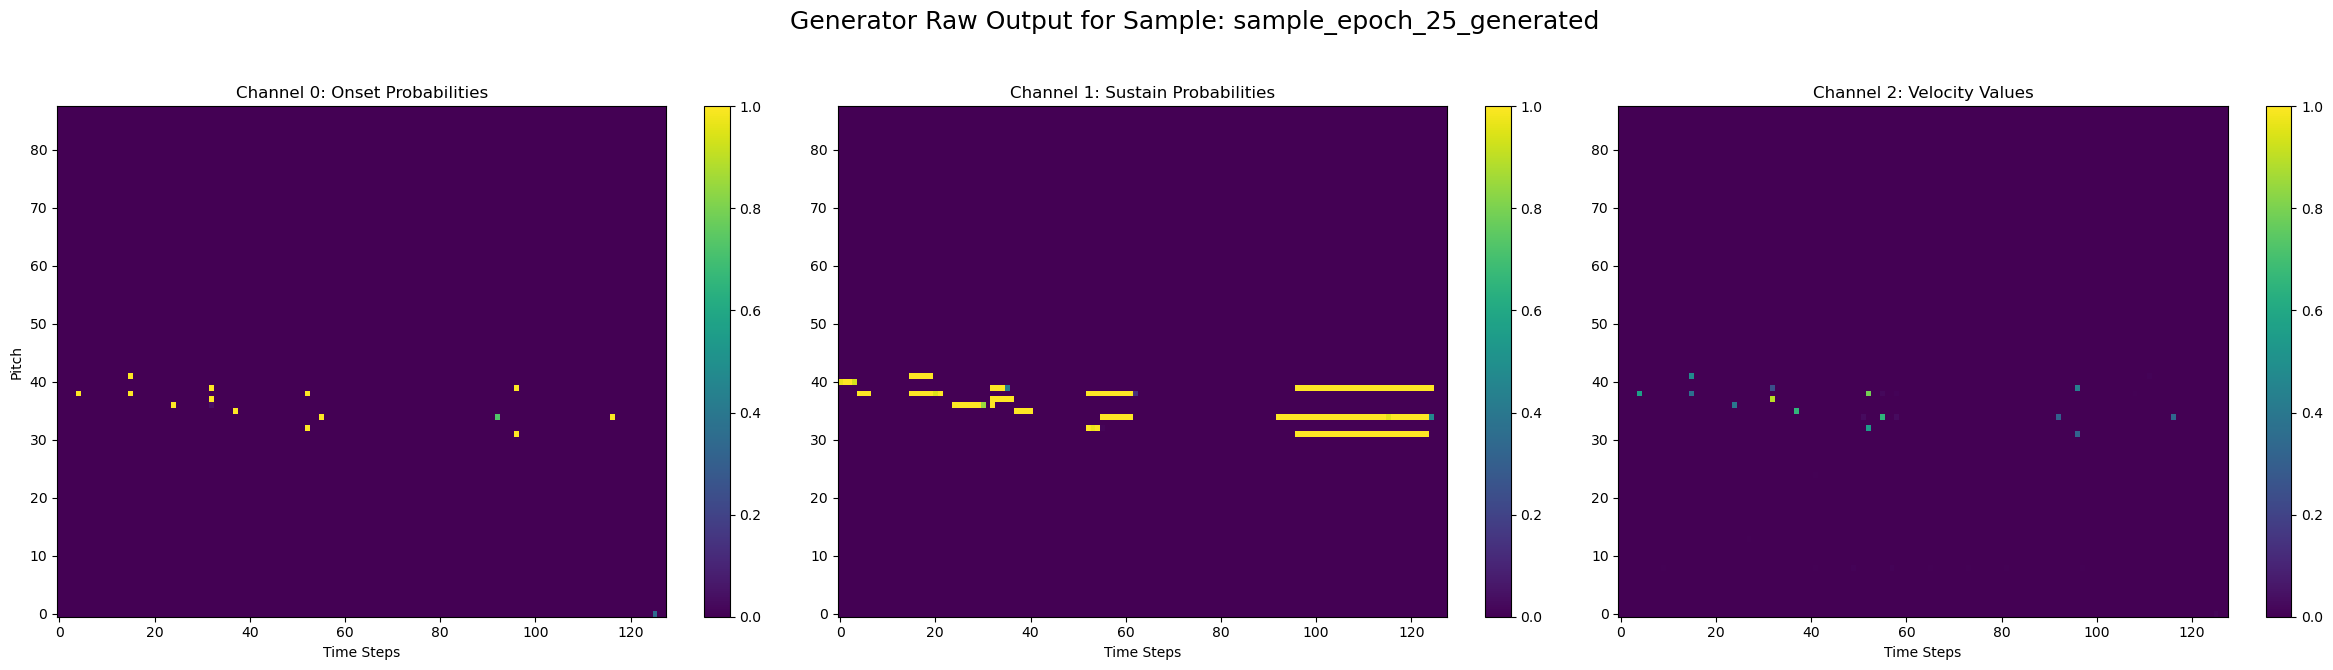

PPO Epoch 26/50: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s, C(w=0.20)=0.724, D(w=0.10)=0.561, G(w=0.70)=0.623, R_total=0.637]


Epoch 26 Summary: Avg Reward: 0.6030 | Genre: 0.5791 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5439 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 27/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.20)=0.728, D(w=0.10)=0.555, G(w=0.70)=0.602, R_total=0.622]


Epoch 27 Summary: Avg Reward: 0.6049 | Genre: 0.5819 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5440 (w=0.10)
  New best average reward: 0.6049. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 28/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.20)=0.715, D(w=0.10)=0.584, G(w=0.70)=0.609, R_total=0.627]


Epoch 28 Summary: Avg Reward: 0.6042 | Genre: 0.5807 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5442 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 29/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.20)=0.694, D(w=0.10)=0.530, G(w=0.70)=0.563, R_total=0.586]


Epoch 29 Summary: Avg Reward: 0.6050 | Genre: 0.5820 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5433 (w=0.10)
  New best average reward: 0.6050. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 30/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.20)=0.723, D(w=0.10)=0.568, G(w=0.70)=0.683, R_total=0.680]


Epoch 30 Summary: Avg Reward: 0.6054 | Genre: 0.5825 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5443 (w=0.10)
  New best average reward: 0.6054. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---

--- Saving sample for epoch 30 ---
--- Visualizing: Original Content for Epoch 30 Sample ---


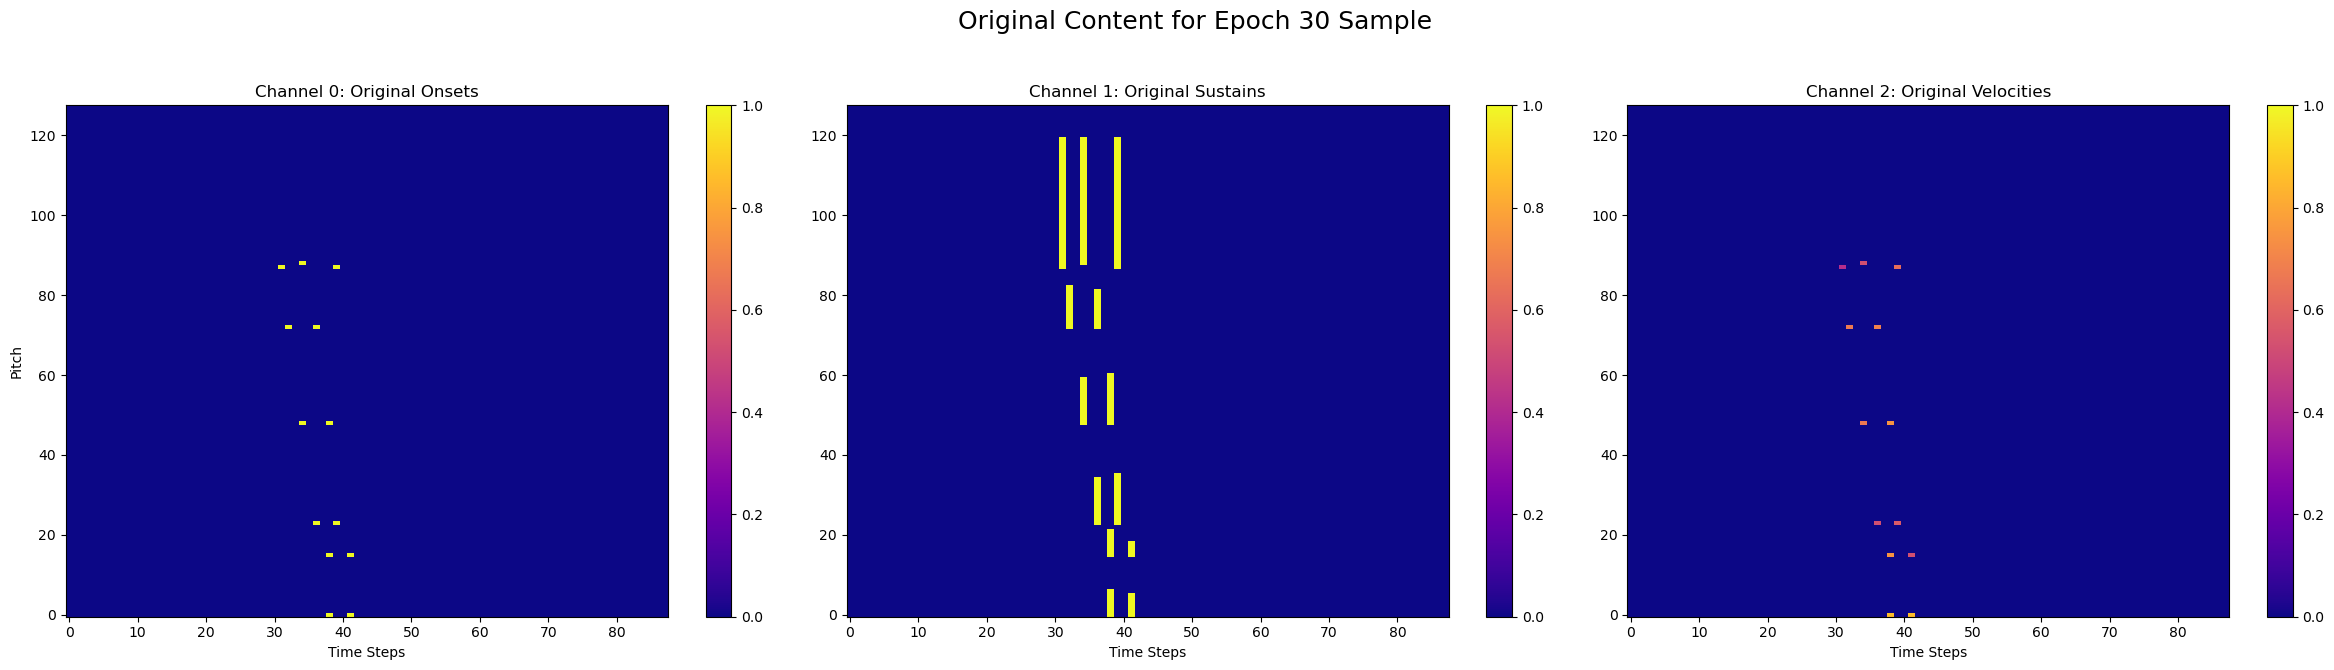

--- Visualizing: Generator Raw Output for Sample: sample_epoch_30_generated ---


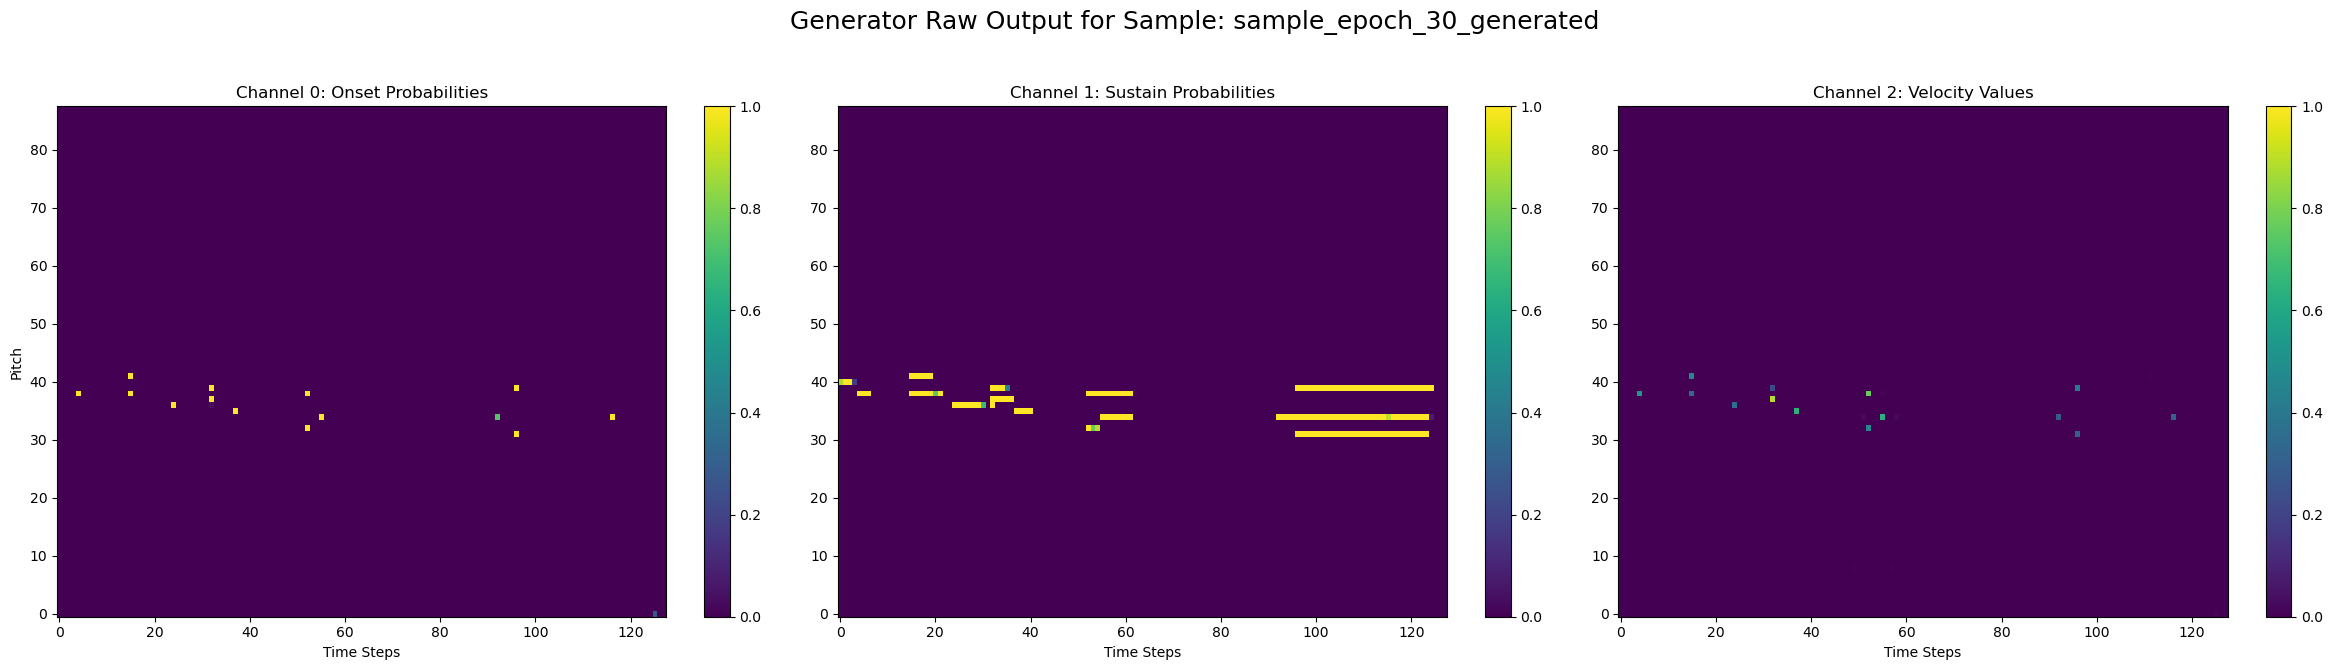

PPO Epoch 31/50: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s, C(w=0.20)=0.728, D(w=0.10)=0.561, G(w=0.70)=0.555, R_total=0.590]


Epoch 31 Summary: Avg Reward: 0.6049 | Genre: 0.5820 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5430 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 32/50: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s, C(w=0.20)=0.720, D(w=0.10)=0.543, G(w=0.70)=0.579, R_total=0.604]


Epoch 32 Summary: Avg Reward: 0.6058 | Genre: 0.5831 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5440 (w=0.10)
  New best average reward: 0.6058. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 33/50: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s, C(w=0.20)=0.727, D(w=0.10)=0.557, G(w=0.70)=0.539, R_total=0.579]


Epoch 33 Summary: Avg Reward: 0.6064 | Genre: 0.5840 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5431 (w=0.10)
  New best average reward: 0.6064. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 34/50: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s, C(w=0.20)=0.735, D(w=0.10)=0.553, G(w=0.70)=0.575, R_total=0.604]


Epoch 34 Summary: Avg Reward: 0.6067 | Genre: 0.5843 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5447 (w=0.10)
  New best average reward: 0.6067. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 35/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.723, D(w=0.10)=0.528, G(w=0.70)=0.610, R_total=0.624]


Epoch 35 Summary: Avg Reward: 0.6059 | Genre: 0.5833 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5433 (w=0.10)
  Avg reward did not improve. Patience: 1/15

--- Saving sample for epoch 35 ---
--- Visualizing: Original Content for Epoch 35 Sample ---


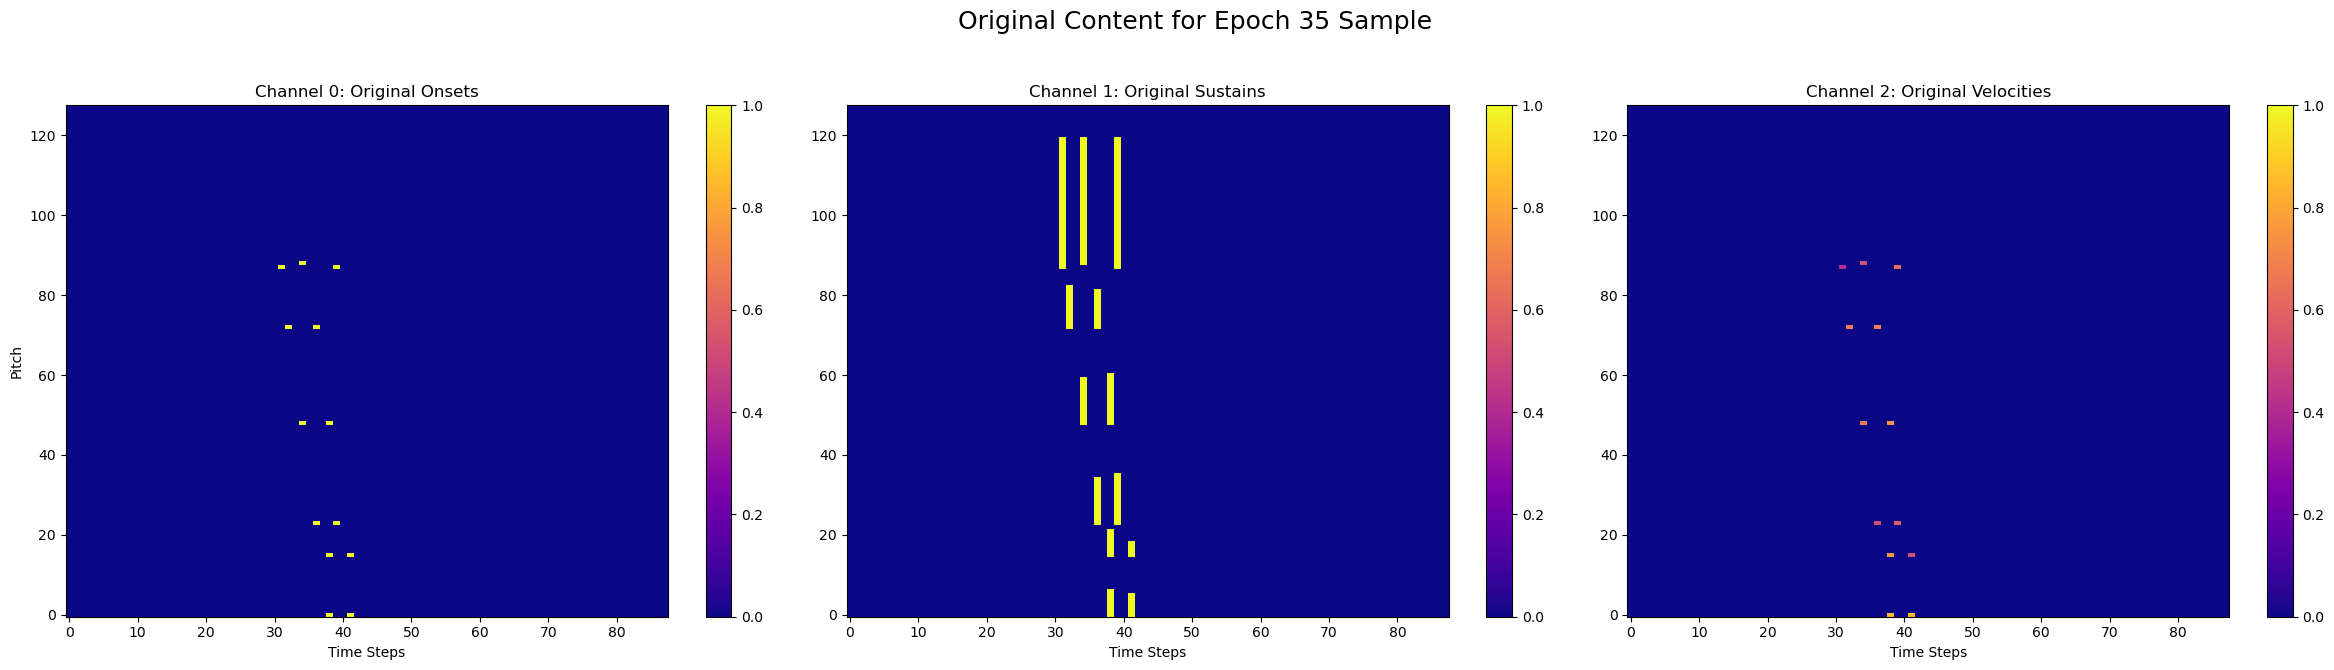

--- Visualizing: Generator Raw Output for Sample: sample_epoch_35_generated ---


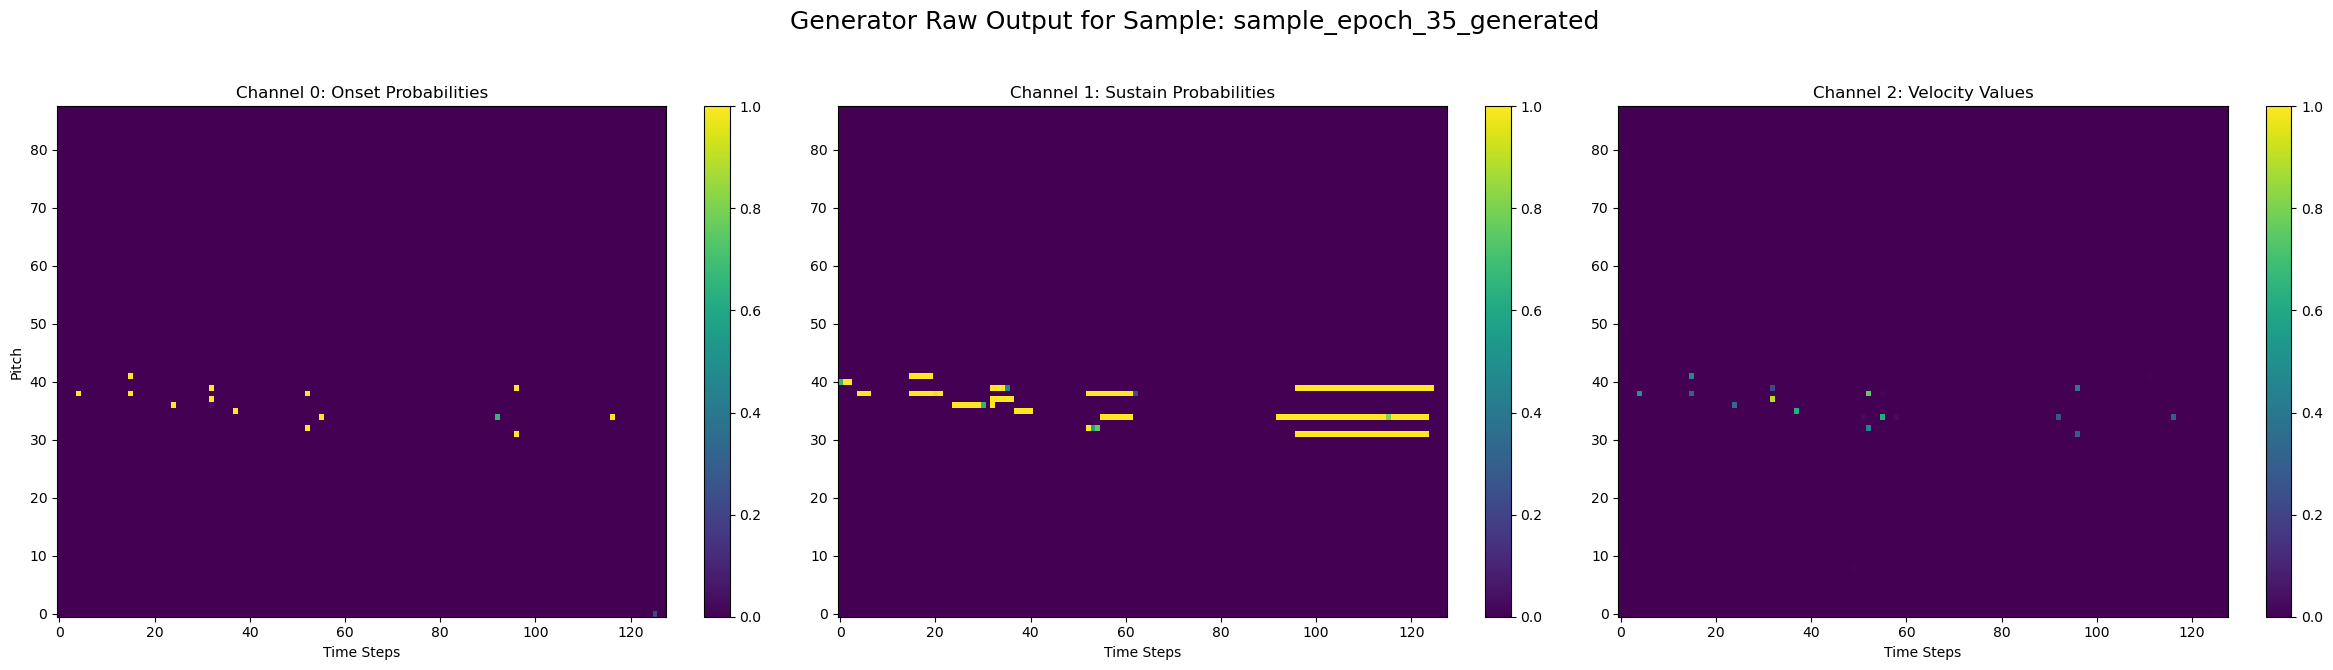

PPO Epoch 36/50: 100%|██████████| 49/49 [00:47<00:00,  1.02it/s, C(w=0.20)=0.718, D(w=0.10)=0.546, G(w=0.70)=0.537, R_total=0.574]


Epoch 36 Summary: Avg Reward: 0.6084 | Genre: 0.5869 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5436 (w=0.10)
  New best average reward: 0.6084. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 37/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.734, D(w=0.10)=0.548, G(w=0.70)=0.628, R_total=0.641]


Epoch 37 Summary: Avg Reward: 0.6070 | Genre: 0.5850 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5430 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 38/50: 100%|██████████| 49/49 [00:47<00:00,  1.02it/s, C(w=0.20)=0.718, D(w=0.10)=0.569, G(w=0.70)=0.607, R_total=0.626]


Epoch 38 Summary: Avg Reward: 0.6077 | Genre: 0.5861 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5421 (w=0.10)
  Avg reward did not improve. Patience: 2/15


PPO Epoch 39/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.714, D(w=0.10)=0.535, G(w=0.70)=0.520, R_total=0.560]


Epoch 39 Summary: Avg Reward: 0.6085 | Genre: 0.5871 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5432 (w=0.10)
  New best average reward: 0.6085. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 40/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.709, D(w=0.10)=0.514, G(w=0.70)=0.599, R_total=0.613]


Epoch 40 Summary: Avg Reward: 0.6079 | Genre: 0.5862 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5431 (w=0.10)
  Avg reward did not improve. Patience: 1/15

--- Saving sample for epoch 40 ---
--- Visualizing: Original Content for Epoch 40 Sample ---


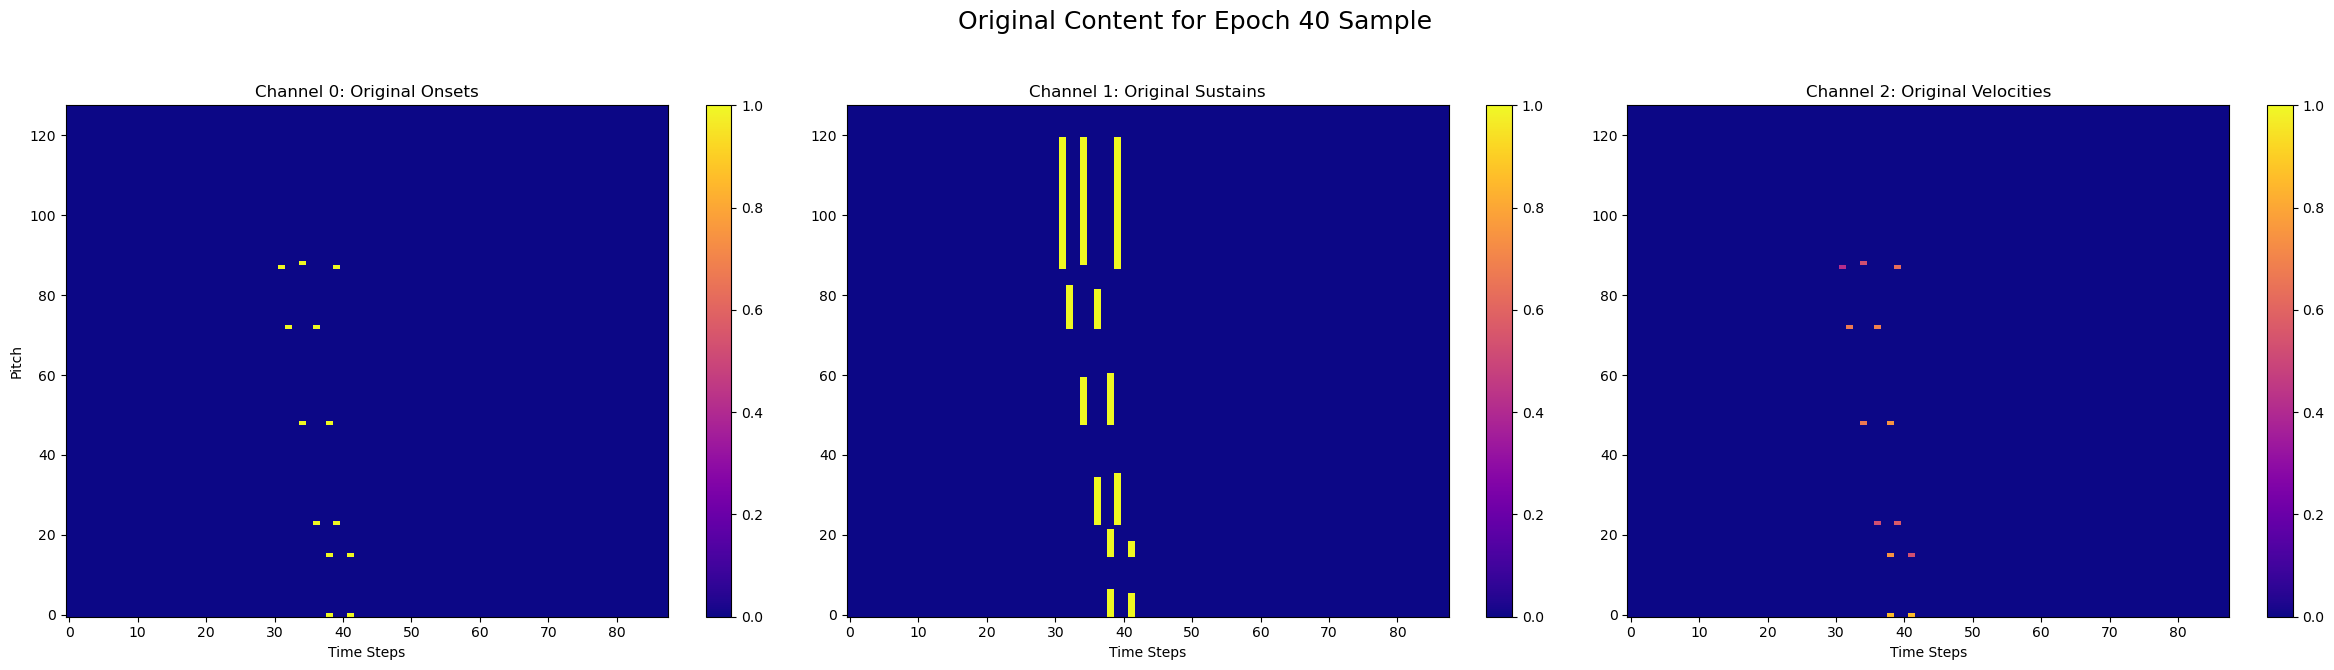

--- Visualizing: Generator Raw Output for Sample: sample_epoch_40_generated ---


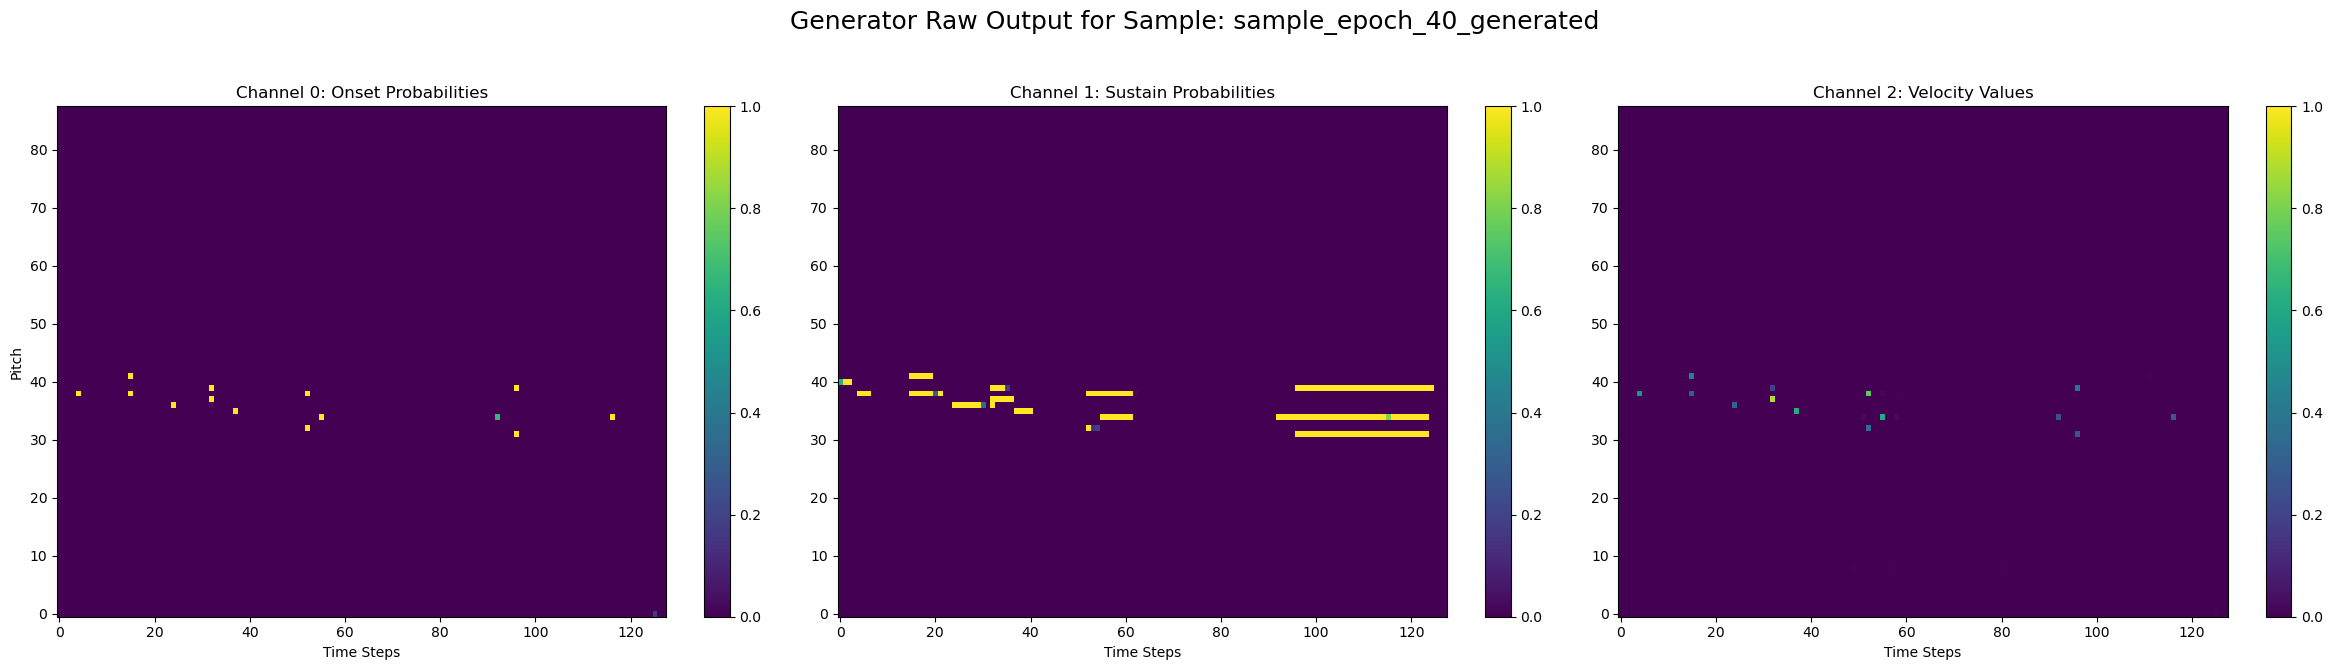

PPO Epoch 41/50: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s, C(w=0.20)=0.711, D(w=0.10)=0.515, G(w=0.70)=0.476, R_total=0.527]


Epoch 41 Summary: Avg Reward: 0.6071 | Genre: 0.5850 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5428 (w=0.10)
  Avg reward did not improve. Patience: 2/15


PPO Epoch 42/50: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s, C(w=0.20)=0.738, D(w=0.10)=0.571, G(w=0.70)=0.620, R_total=0.639]


Epoch 42 Summary: Avg Reward: 0.6096 | Genre: 0.5887 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5428 (w=0.10)
  New best average reward: 0.6096. Saving model...
--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth ---


PPO Epoch 43/50: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s, C(w=0.20)=0.707, D(w=0.10)=0.557, G(w=0.70)=0.573, R_total=0.598]


Epoch 43 Summary: Avg Reward: 0.6077 | Genre: 0.5859 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5432 (w=0.10)
  Avg reward did not improve. Patience: 1/15


PPO Epoch 44/50: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s, C(w=0.20)=0.728, D(w=0.10)=0.516, G(w=0.70)=0.547, R_total=0.580]


Epoch 44 Summary: Avg Reward: 0.6081 | Genre: 0.5866 (w=0.70), Chroma: 0.7163 (w=0.20), Discrim: 0.5426 (w=0.10)
  Avg reward did not improve. Patience: 2/15


PPO Epoch 45/50: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s, C(w=0.20)=0.733, D(w=0.10)=0.551, G(w=0.70)=0.618, R_total=0.635]


Epoch 45 Summary: Avg Reward: 0.6091 | Genre: 0.5879 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5431 (w=0.10)
  Avg reward did not improve. Patience: 3/15

--- Saving sample for epoch 45 ---
--- Visualizing: Original Content for Epoch 45 Sample ---


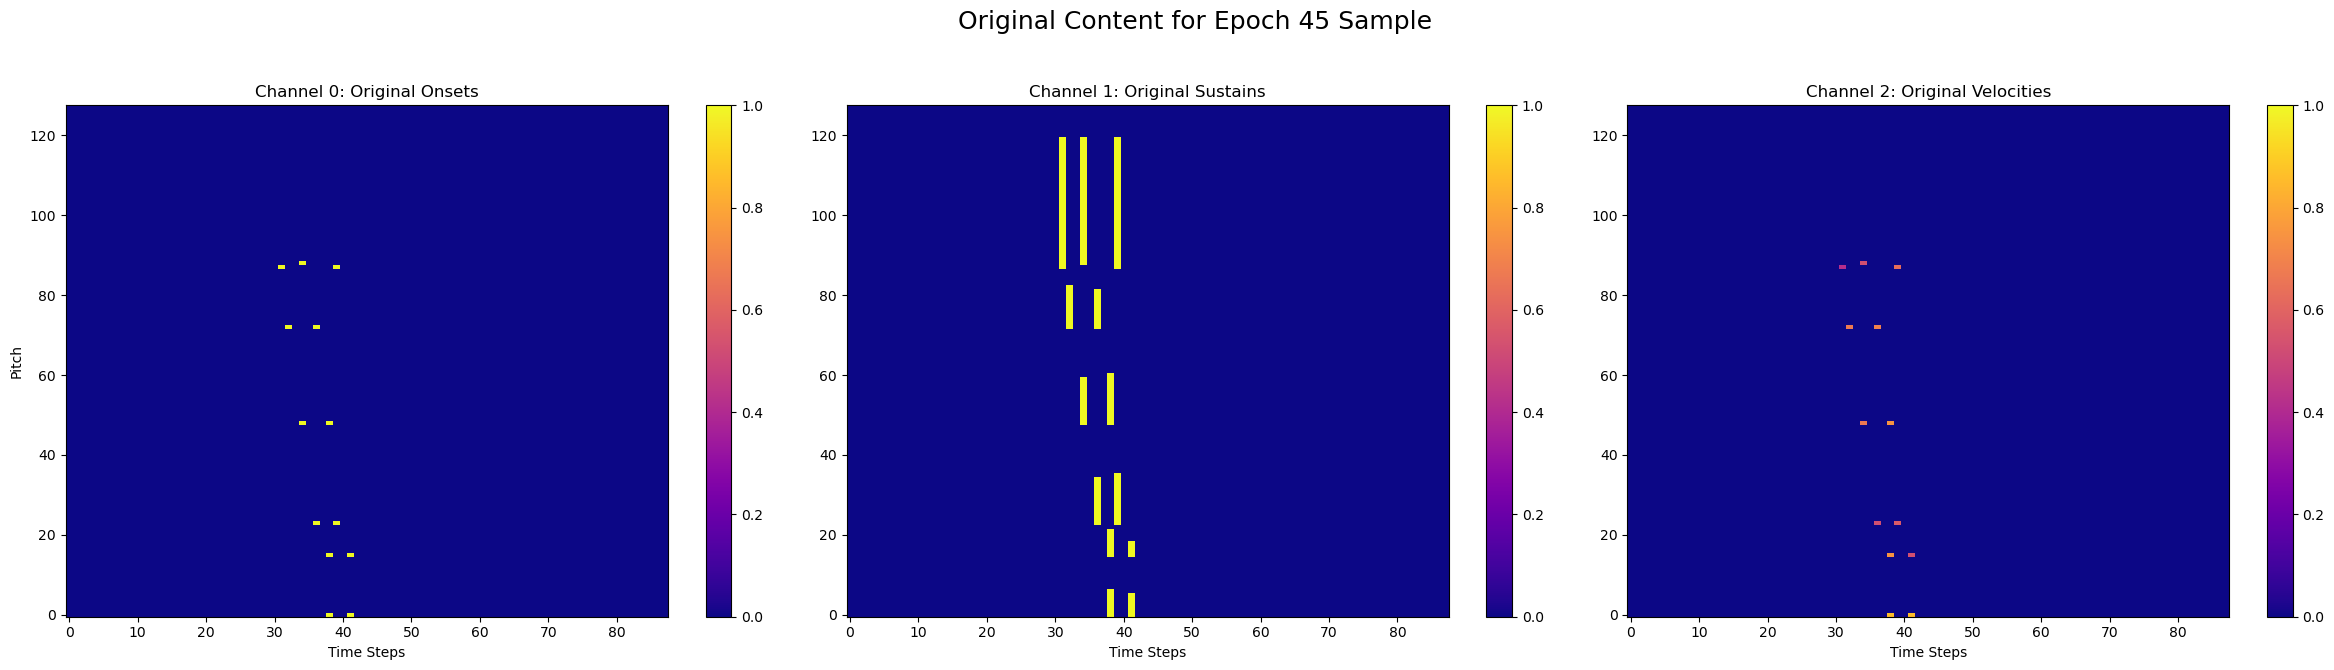

--- Visualizing: Generator Raw Output for Sample: sample_epoch_45_generated ---


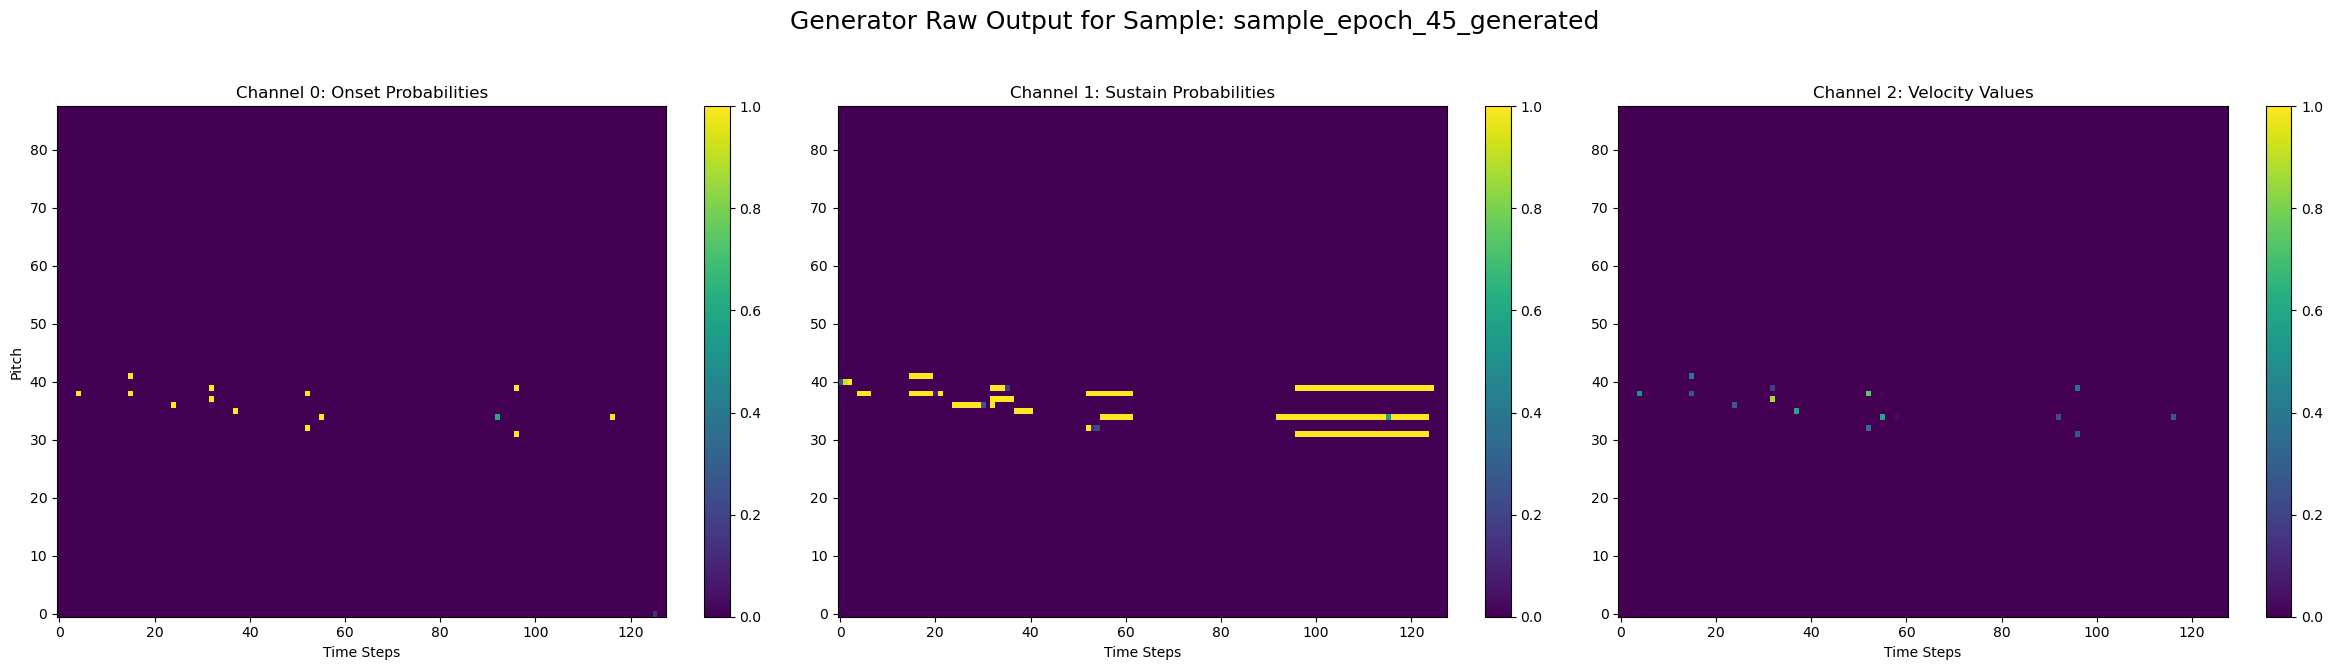

PPO Epoch 46/50: 100%|██████████| 49/49 [00:43<00:00,  1.14it/s, C(w=0.20)=0.718, D(w=0.10)=0.545, G(w=0.70)=0.528, R_total=0.567]


Epoch 46 Summary: Avg Reward: 0.6087 | Genre: 0.5875 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5420 (w=0.10)
  Avg reward did not improve. Patience: 4/15


PPO Epoch 47/50: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s, C(w=0.20)=0.706, D(w=0.10)=0.528, G(w=0.70)=0.591, R_total=0.608]


Epoch 47 Summary: Avg Reward: 0.6087 | Genre: 0.5875 (w=0.70), Chroma: 0.7162 (w=0.20), Discrim: 0.5424 (w=0.10)
  Avg reward did not improve. Patience: 5/15


PPO Epoch 48/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.726, D(w=0.10)=0.489, G(w=0.70)=0.598, R_total=0.612]


Epoch 48 Summary: Avg Reward: 0.6083 | Genre: 0.5871 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5415 (w=0.10)
  Avg reward did not improve. Patience: 6/15


PPO Epoch 49/50: 100%|██████████| 49/49 [00:48<00:00,  1.02it/s, C(w=0.20)=0.731, D(w=0.10)=0.535, G(w=0.70)=0.560, R_total=0.591]


Epoch 49 Summary: Avg Reward: 0.6081 | Genre: 0.5868 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5416 (w=0.10)
  Avg reward did not improve. Patience: 7/15


PPO Epoch 50/50: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s, C(w=0.20)=0.703, D(w=0.10)=0.540, G(w=0.70)=0.588, R_total=0.606]


Epoch 50 Summary: Avg Reward: 0.6096 | Genre: 0.5890 (w=0.70), Chroma: 0.7161 (w=0.20), Discrim: 0.5409 (w=0.10)
  Avg reward did not improve. Patience: 8/15

--- Saving sample for epoch 50 ---
--- Visualizing: Original Content for Epoch 50 Sample ---


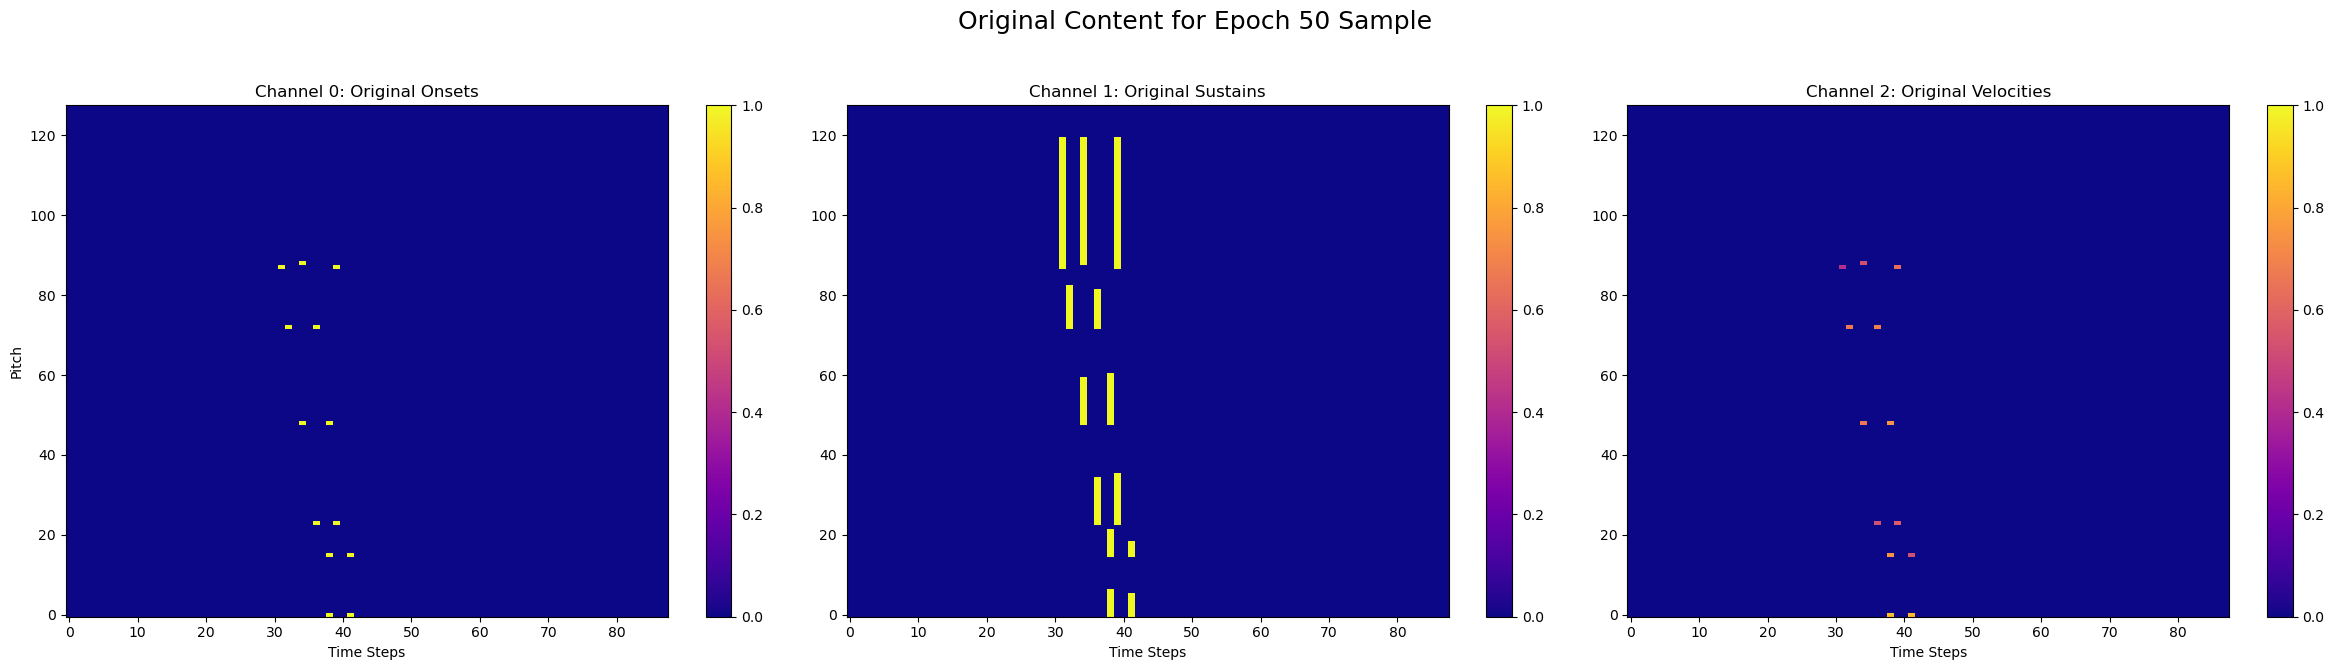

--- Visualizing: Generator Raw Output for Sample: sample_epoch_50_generated ---


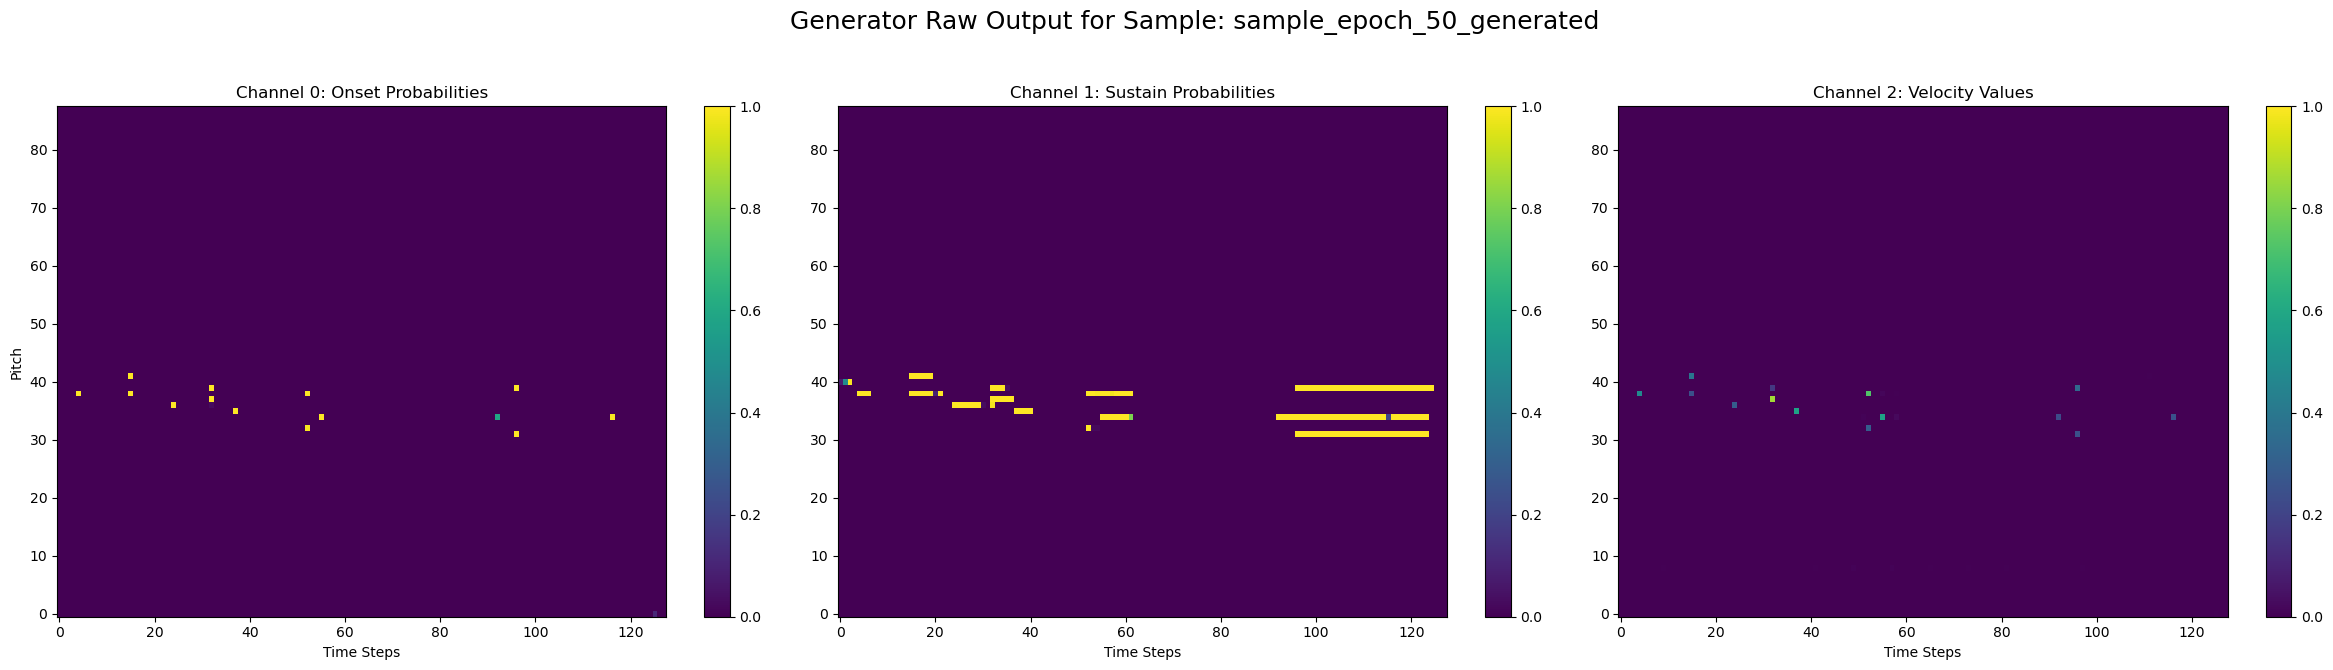


--- PPO Training Complete ---

--- Generating Training Plots ---


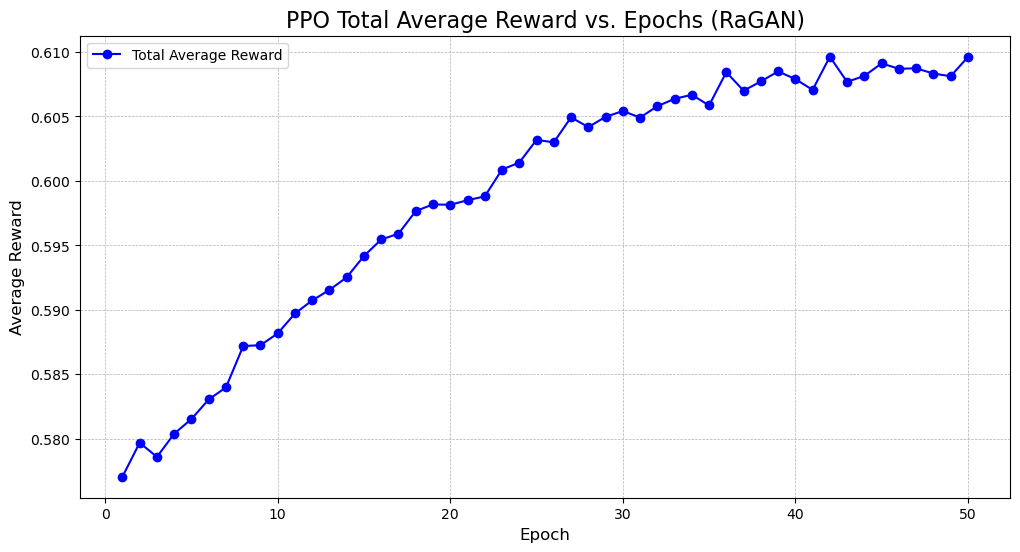

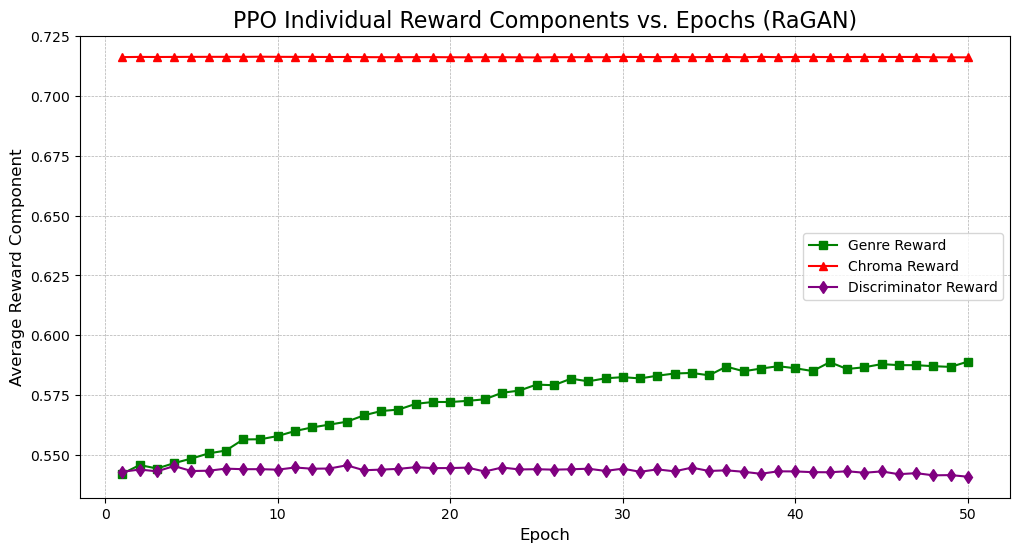

In [ ]:
if __name__ == '__main__':
    # --- CHOOSE THE MODEL TO FINE-TUNE ---
    MODEL_TO_TRAIN = 'RaGAN'
    
    print(f"--- Starting training for {MODEL_TO_TRAIN} ---")
    
    # --- Instantiate the trainer and pass the setting ---
    ppo_trainer = PPOTrainer(model_to_train=MODEL_TO_TRAIN, use_curriculum=False)
    ppo_trainer.train()

## Transformer-VAE setup and training process

--- Running with fixed random seed: 123 ---
--- INITIALIZING PPO TRAINER FOR: Transformer-VAE ---
Found existing PPO file list at: C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_ppo_training.csv
EAGERLY loading all multi-channel segments for 'PPO Non-Jazz Content' into RAM...


Loading files: 100%|██████████| 100/100 [00:01<00:00, 61.78it/s]


Eager loading complete. Total segments: 6181. Shape: (6181, 4, 88, 128)
Successfully loaded frozen 4-channel Jazz Classifier.


C:\Users\User\AppData\Local\Temp\ipykernel_11632\702103331.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.classifier.load_state_dict(torch.load(config.PRETRAINED

Successfully loaded pre-trained Transformer-VAE as PPO policy.

--- Starting PPO Fine-Tuning on device: cuda ---
Searching for a non-silent batch to use for sample generation...
Found a suitable batch for sampling at index 0.


PPO Epoch 1/100: 100%|██████████| 194/194 [01:40<00:00,  1.92it/s, R_total=0.652, R_genre(w=0.03)=0.397, R_recon(w=0.97)=0.661]


Epoch 1 Summary: Avg Reward: 0.7428 | Avg Genre: 0.2905, Avg Recon: 0.7580


PPO Epoch 2/100: 100%|██████████| 194/194 [01:38<00:00,  1.96it/s, R_total=0.545, R_genre(w=0.07)=0.515, R_recon(w=0.94)=0.547]


Epoch 2 Summary: Avg Reward: 0.5610 | Avg Genre: 0.4512, Avg Recon: 0.5686


PPO Epoch 3/100: 100%|██████████| 194/194 [01:39<00:00,  1.95it/s, R_total=0.503, R_genre(w=0.10)=0.618, R_recon(w=0.90)=0.491]


Epoch 3 Summary: Avg Reward: 0.5552 | Avg Genre: 0.5076, Avg Recon: 0.5604


PPO Epoch 4/100: 100%|██████████| 194/194 [01:39<00:00,  1.95it/s, R_total=0.600, R_genre(w=0.13)=0.652, R_recon(w=0.87)=0.592]


Epoch 4 Summary: Avg Reward: 0.5494 | Avg Genre: 0.5227, Avg Recon: 0.5534


PPO Epoch 5/100: 100%|██████████| 194/194 [01:38<00:00,  1.96it/s, R_total=0.543, R_genre(w=0.16)=0.542, R_recon(w=0.84)=0.543]


Epoch 5 Summary: Avg Reward: 0.5448 | Avg Genre: 0.5206, Avg Recon: 0.5495

--- Saving sample for epoch 5 ---
--- Visualizing: Original Content for Epoch 5 Sample ---


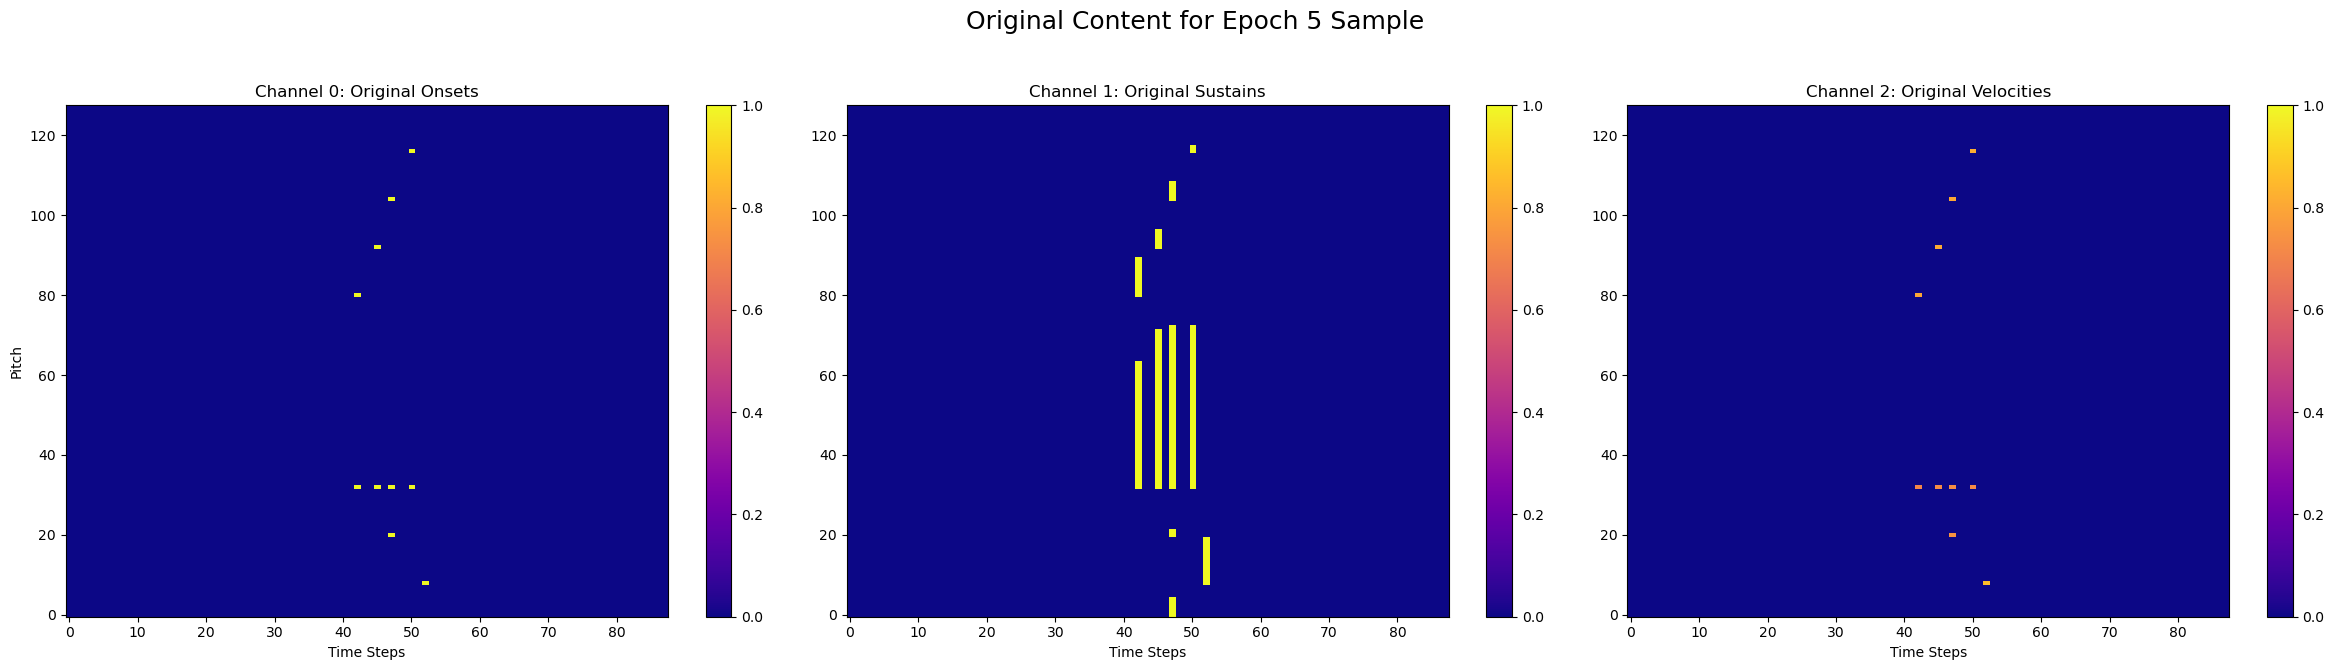

--- Visualizing: Generator Raw Output for Sample: sample_epoch_5_generated ---


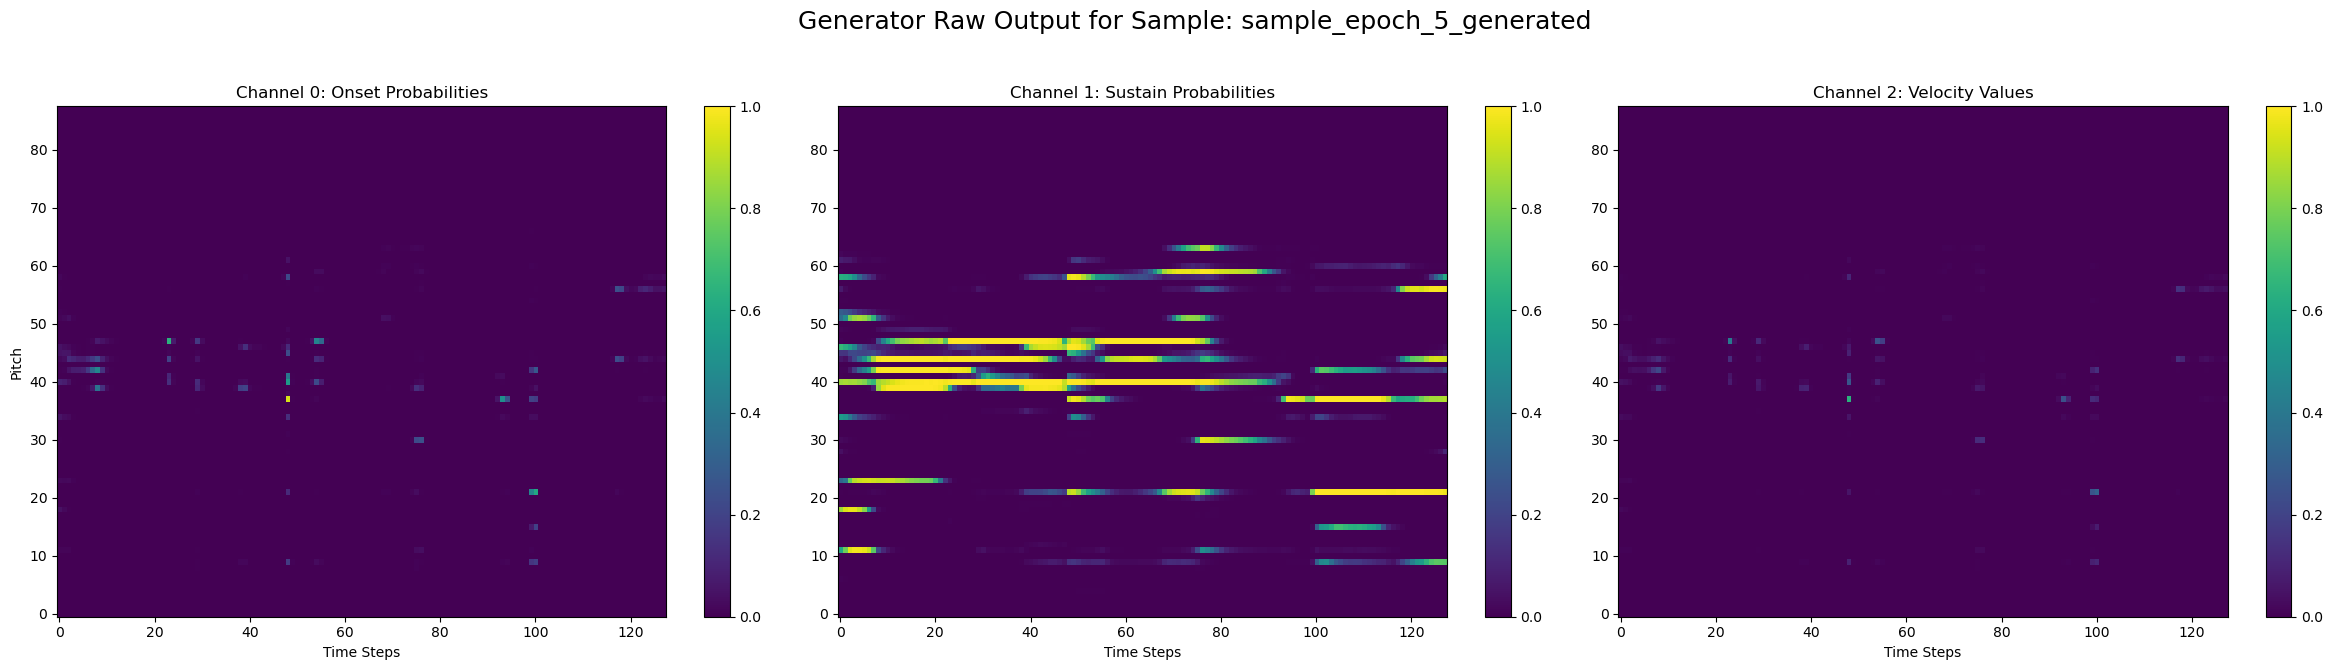

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_5.pth ---


PPO Epoch 6/100: 100%|██████████| 194/194 [01:38<00:00,  1.96it/s, R_total=0.530, R_genre(w=0.20)=0.470, R_recon(w=0.80)=0.545]


Epoch 6 Summary: Avg Reward: 0.5448 | Avg Genre: 0.5279, Avg Recon: 0.5489


PPO Epoch 7/100: 100%|██████████| 194/194 [01:39<00:00,  1.96it/s, R_total=0.594, R_genre(w=0.23)=0.748, R_recon(w=0.77)=0.548]


Epoch 7 Summary: Avg Reward: 0.5418 | Avg Genre: 0.5239, Avg Recon: 0.5470


PPO Epoch 8/100: 100%|██████████| 194/194 [01:39<00:00,  1.96it/s, R_total=0.560, R_genre(w=0.26)=0.448, R_recon(w=0.74)=0.599]


Epoch 8 Summary: Avg Reward: 0.5413 | Avg Genre: 0.5237, Avg Recon: 0.5475


PPO Epoch 9/100: 100%|██████████| 194/194 [01:38<00:00,  1.96it/s, R_total=0.589, R_genre(w=0.29)=0.634, R_recon(w=0.71)=0.571]


Epoch 9 Summary: Avg Reward: 0.5394 | Avg Genre: 0.5217, Avg Recon: 0.5467


PPO Epoch 10/100: 100%|██████████| 194/194 [01:38<00:00,  1.96it/s, R_total=0.551, R_genre(w=0.33)=0.524, R_recon(w=0.68)=0.564]


Epoch 10 Summary: Avg Reward: 0.5397 | Avg Genre: 0.5281, Avg Recon: 0.5453

--- Saving sample for epoch 10 ---
--- Visualizing: Original Content for Epoch 10 Sample ---


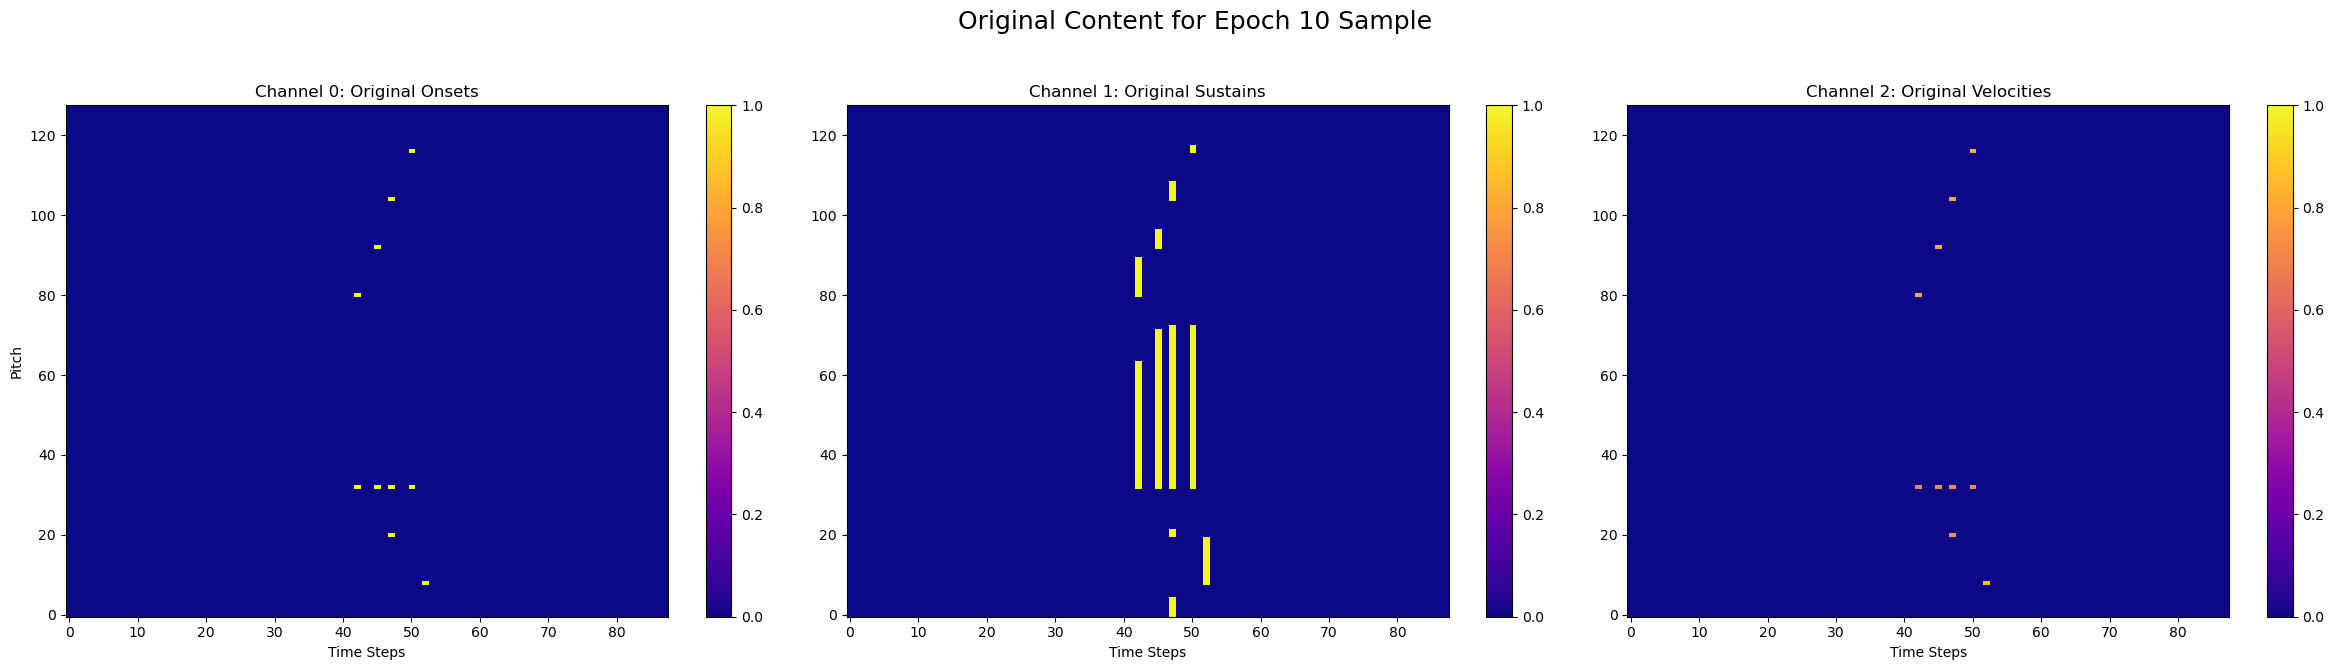

--- Visualizing: Generator Raw Output for Sample: sample_epoch_10_generated ---


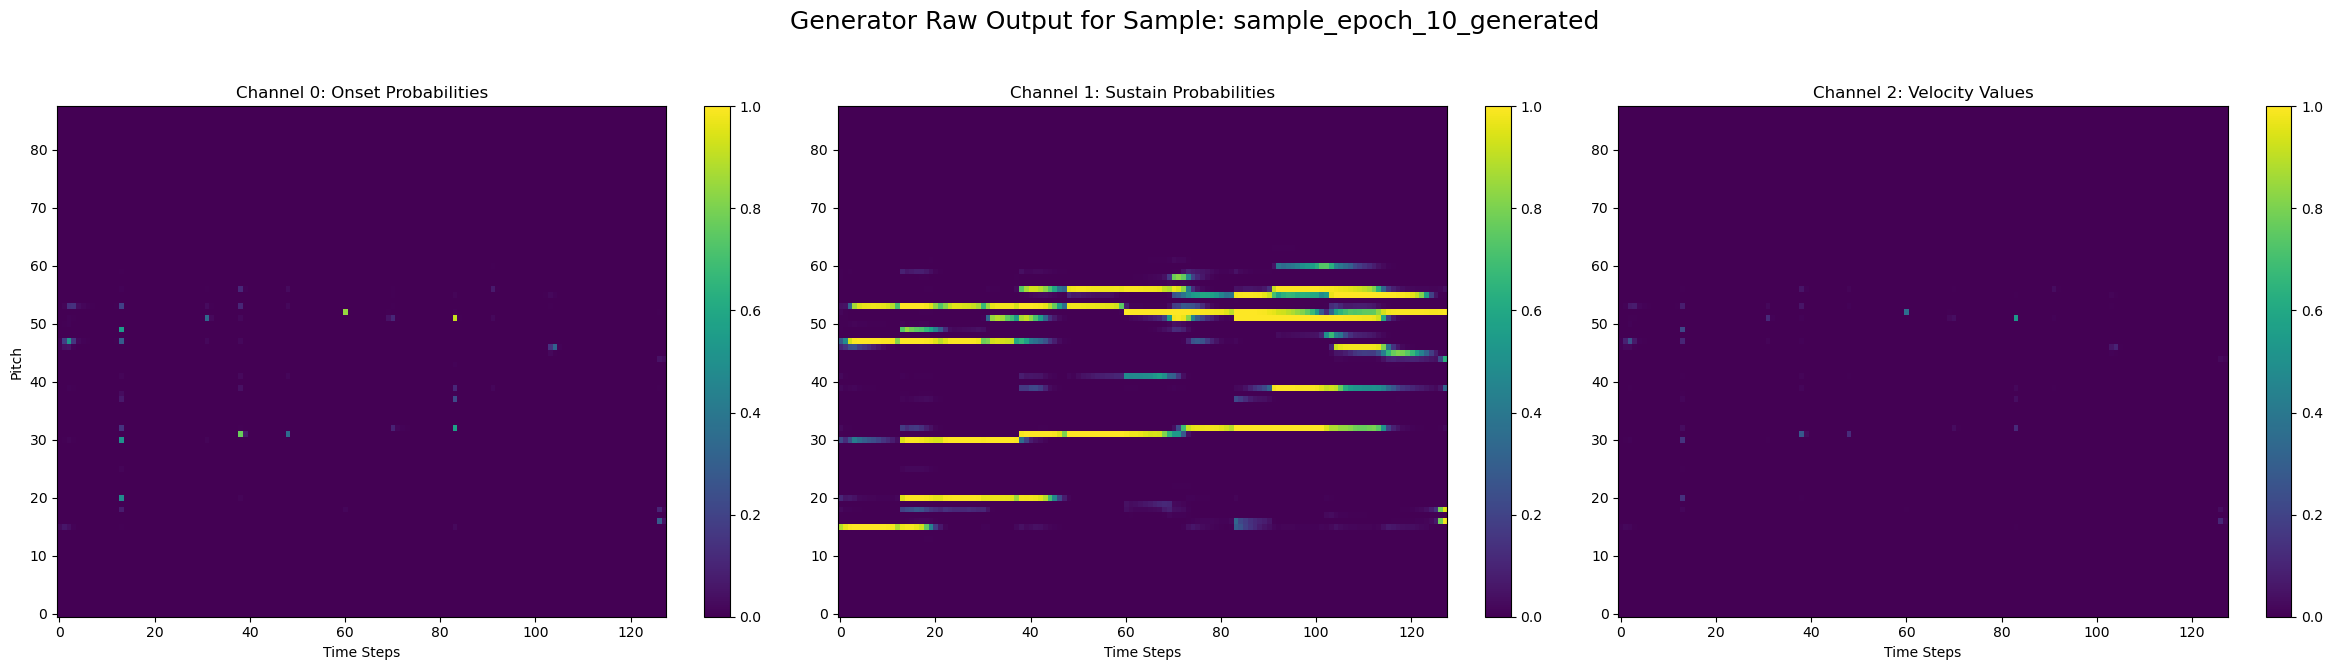

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_10.pth ---


PPO Epoch 11/100: 100%|██████████| 194/194 [01:39<00:00,  1.95it/s, R_total=0.489, R_genre(w=0.36)=0.526, R_recon(w=0.64)=0.468]


Epoch 11 Summary: Avg Reward: 0.5380 | Avg Genre: 0.5230, Avg Recon: 0.5464


PPO Epoch 12/100: 100%|██████████| 194/194 [01:38<00:00,  1.97it/s, R_total=0.588, R_genre(w=0.39)=0.565, R_recon(w=0.61)=0.604]


Epoch 12 Summary: Avg Reward: 0.5364 | Avg Genre: 0.5227, Avg Recon: 0.5452


PPO Epoch 13/100: 100%|██████████| 194/194 [01:38<00:00,  1.98it/s, R_total=0.560, R_genre(w=0.42)=0.497, R_recon(w=0.58)=0.607]


Epoch 13 Summary: Avg Reward: 0.5359 | Avg Genre: 0.5207, Avg Recon: 0.5471


PPO Epoch 14/100: 100%|██████████| 194/194 [01:38<00:00,  1.97it/s, R_total=0.745, R_genre(w=0.45)=0.706, R_recon(w=0.55)=0.778]


Epoch 14 Summary: Avg Reward: 0.5341 | Avg Genre: 0.5217, Avg Recon: 0.5445


PPO Epoch 15/100: 100%|██████████| 194/194 [01:38<00:00,  1.97it/s, R_total=0.477, R_genre(w=0.49)=0.544, R_recon(w=0.51)=0.413]


Epoch 15 Summary: Avg Reward: 0.5358 | Avg Genre: 0.5272, Avg Recon: 0.5441

--- Saving sample for epoch 15 ---
--- Visualizing: Original Content for Epoch 15 Sample ---


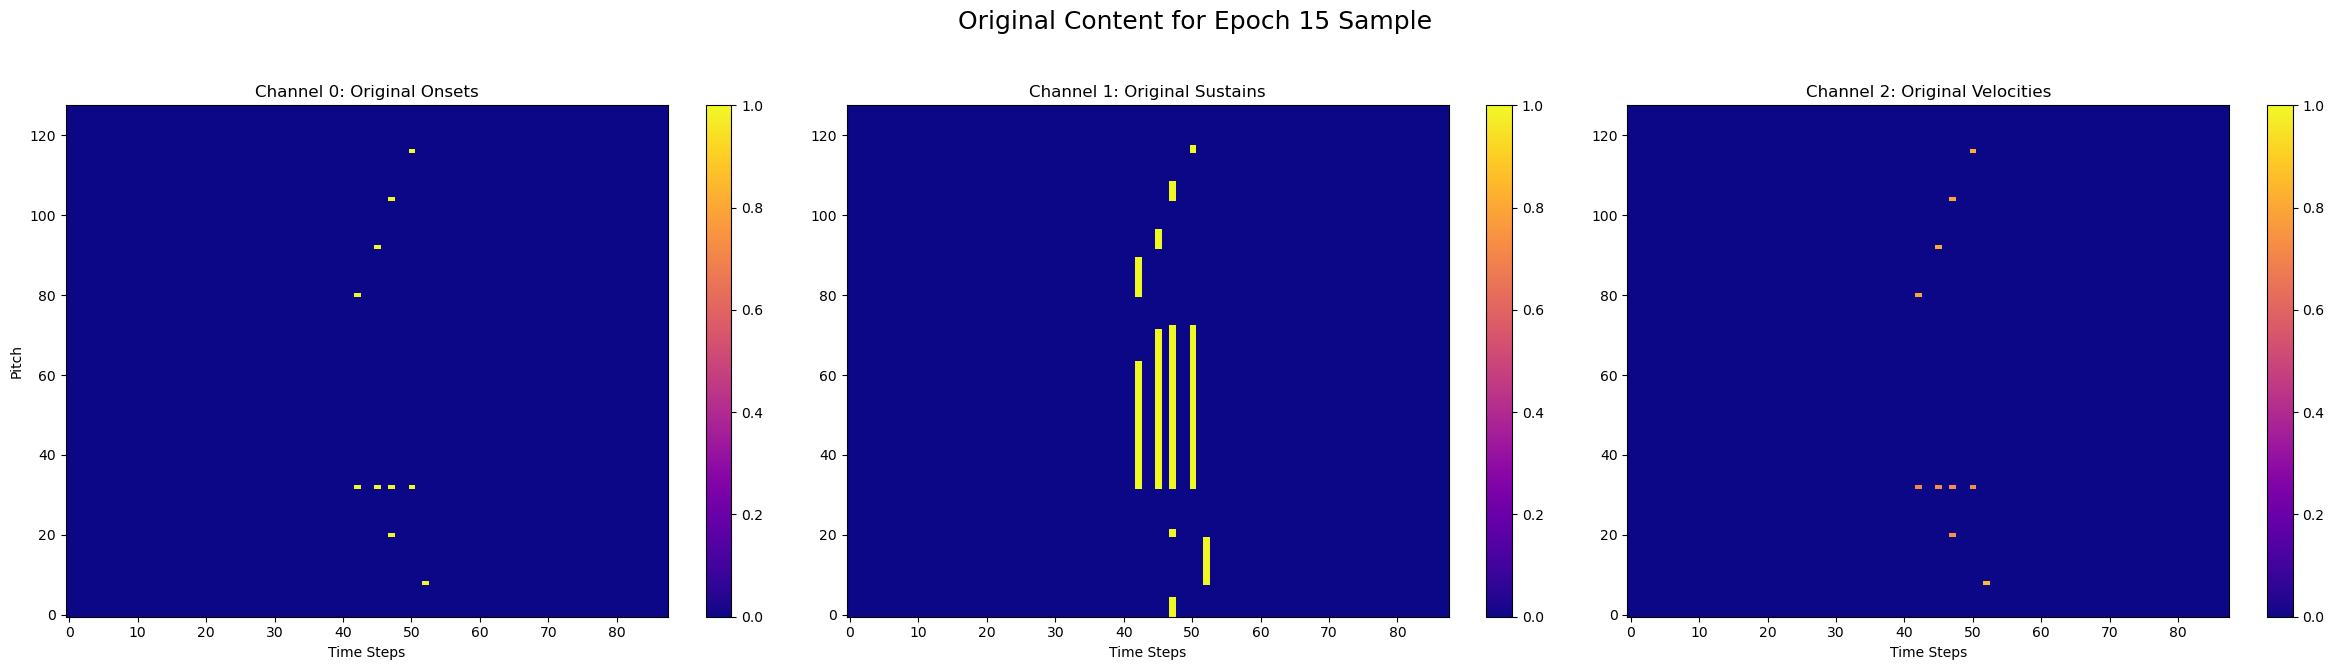

--- Visualizing: Generator Raw Output for Sample: sample_epoch_15_generated ---


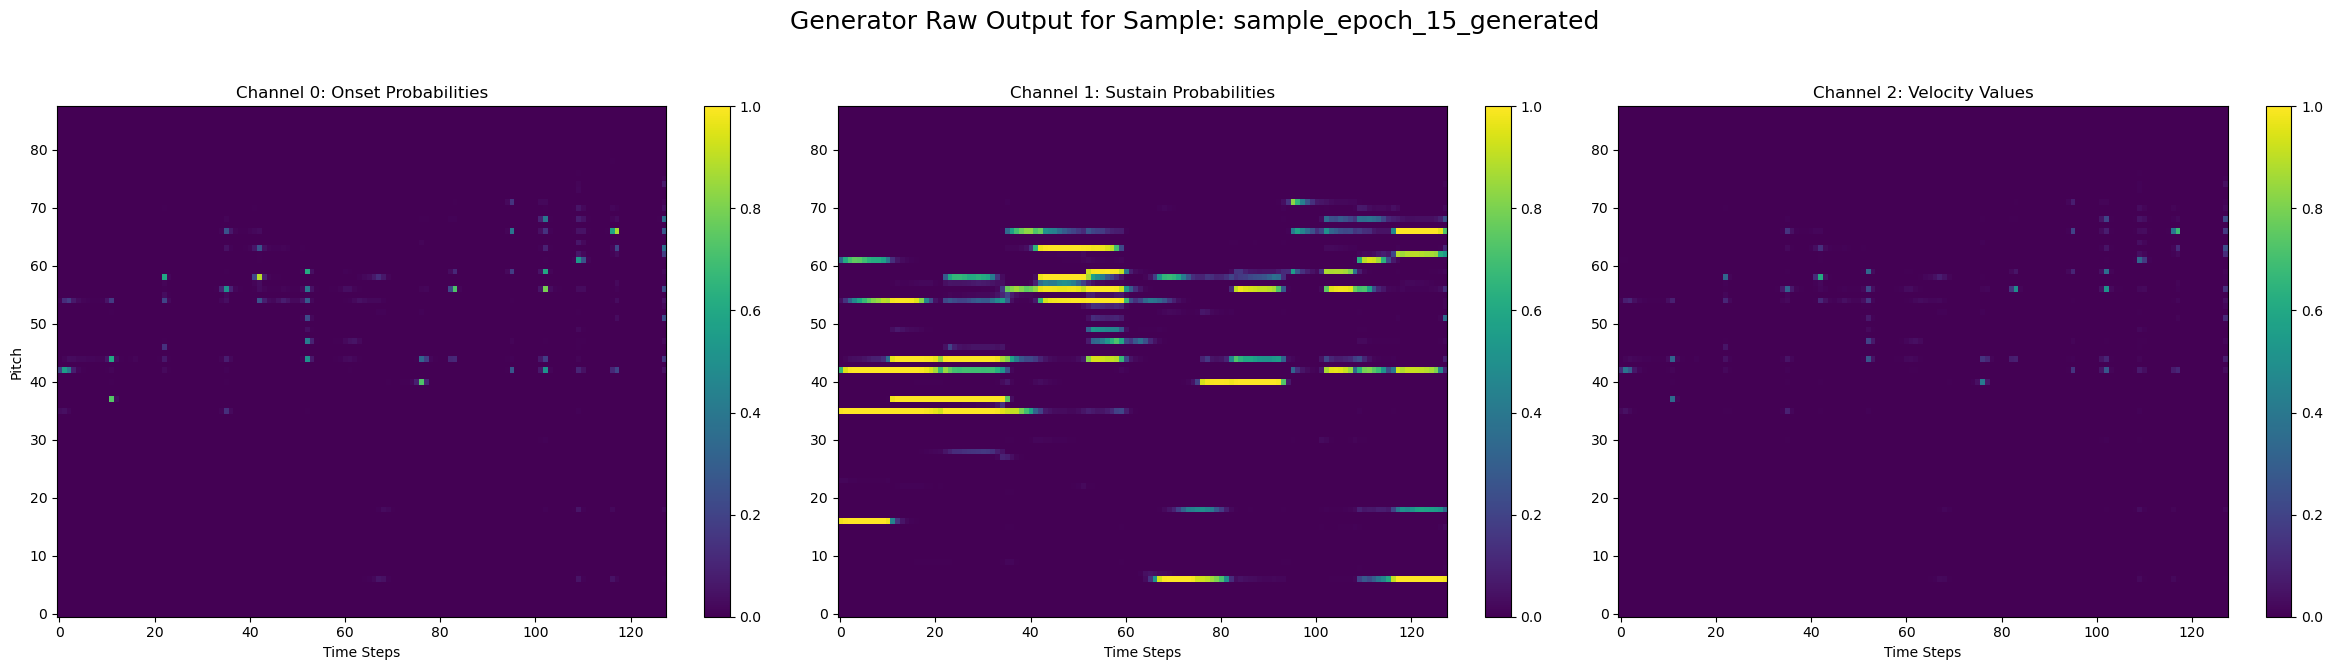

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_15.pth ---


PPO Epoch 16/100: 100%|██████████| 194/194 [01:38<00:00,  1.97it/s, R_total=0.610, R_genre(w=0.52)=0.519, R_recon(w=0.48)=0.708]


Epoch 16 Summary: Avg Reward: 0.5346 | Avg Genre: 0.5257, Avg Recon: 0.5443


PPO Epoch 17/100: 100%|██████████| 194/194 [01:38<00:00,  1.98it/s, R_total=0.434, R_genre(w=0.55)=0.455, R_recon(w=0.45)=0.409]


Epoch 17 Summary: Avg Reward: 0.5329 | Avg Genre: 0.5241, Avg Recon: 0.5438


PPO Epoch 18/100: 100%|██████████| 194/194 [01:38<00:00,  1.96it/s, R_total=0.554, R_genre(w=0.59)=0.498, R_recon(w=0.41)=0.633]


Epoch 18 Summary: Avg Reward: 0.5322 | Avg Genre: 0.5228, Avg Recon: 0.5454


PPO Epoch 19/100: 100%|██████████| 194/194 [01:38<00:00,  1.98it/s, R_total=0.551, R_genre(w=0.62)=0.496, R_recon(w=0.38)=0.639]


Epoch 19 Summary: Avg Reward: 0.5318 | Avg Genre: 0.5246, Avg Recon: 0.5434


PPO Epoch 20/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.552, R_genre(w=0.65)=0.529, R_recon(w=0.35)=0.594]


Epoch 20 Summary: Avg Reward: 0.5339 | Avg Genre: 0.5278, Avg Recon: 0.5453

--- Saving sample for epoch 20 ---
--- Visualizing: Original Content for Epoch 20 Sample ---


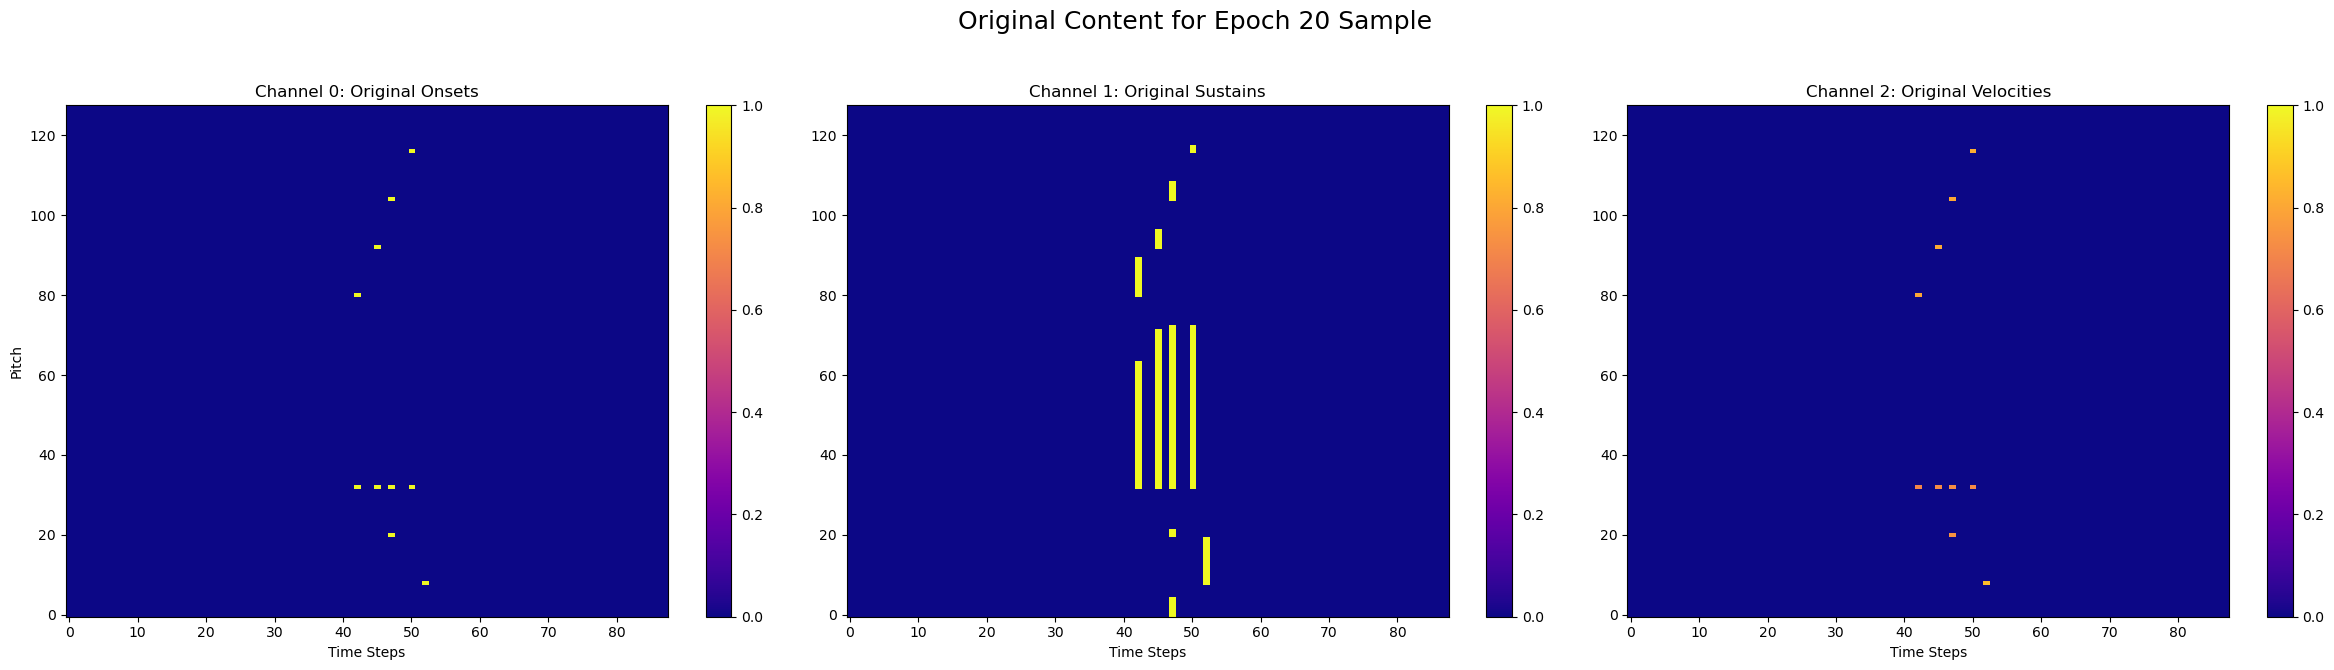

--- Visualizing: Generator Raw Output for Sample: sample_epoch_20_generated ---


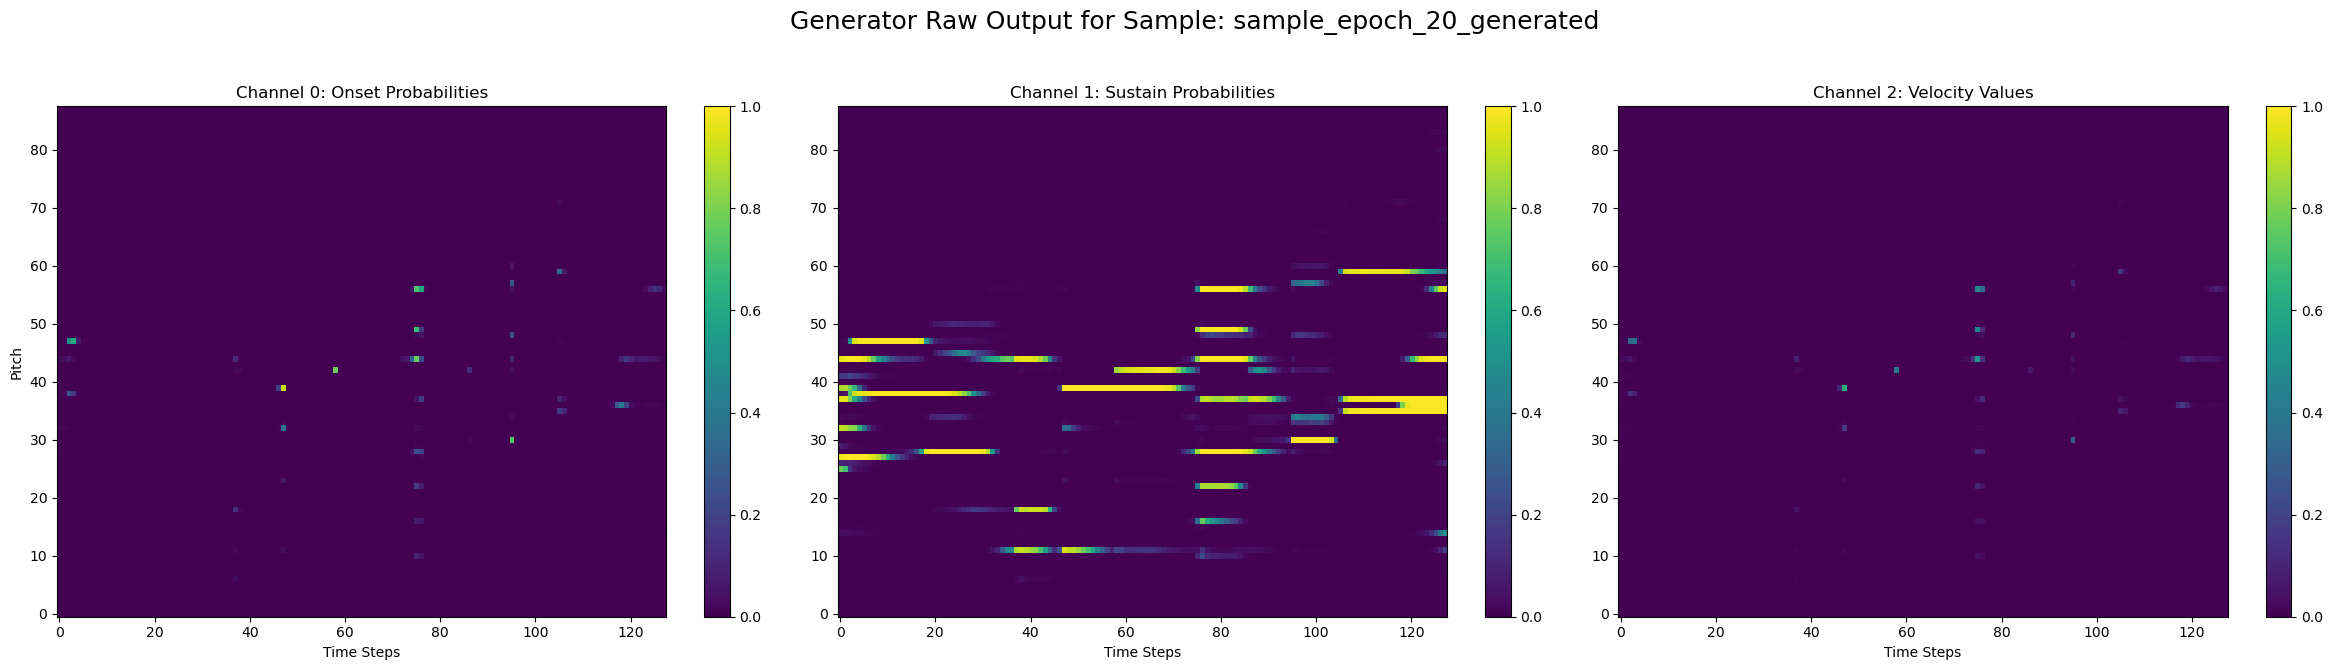

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_20.pth ---


PPO Epoch 21/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.530, R_genre(w=0.65)=0.490, R_recon(w=0.35)=0.604]


Epoch 21 Summary: Avg Reward: 0.5293 | Avg Genre: 0.5217, Avg Recon: 0.5434


PPO Epoch 22/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.459, R_genre(w=0.65)=0.405, R_recon(w=0.35)=0.560]


Epoch 22 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5250, Avg Recon: 0.5449


PPO Epoch 23/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.459, R_genre(w=0.65)=0.495, R_recon(w=0.35)=0.392]


Epoch 23 Summary: Avg Reward: 0.5303 | Avg Genre: 0.5230, Avg Recon: 0.5438


PPO Epoch 24/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.554, R_genre(w=0.65)=0.552, R_recon(w=0.35)=0.559]


Epoch 24 Summary: Avg Reward: 0.5268 | Avg Genre: 0.5172, Avg Recon: 0.5448


PPO Epoch 25/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.529, R_genre(w=0.65)=0.477, R_recon(w=0.35)=0.626]


Epoch 25 Summary: Avg Reward: 0.5316 | Avg Genre: 0.5246, Avg Recon: 0.5447

--- Saving sample for epoch 25 ---
--- Visualizing: Original Content for Epoch 25 Sample ---


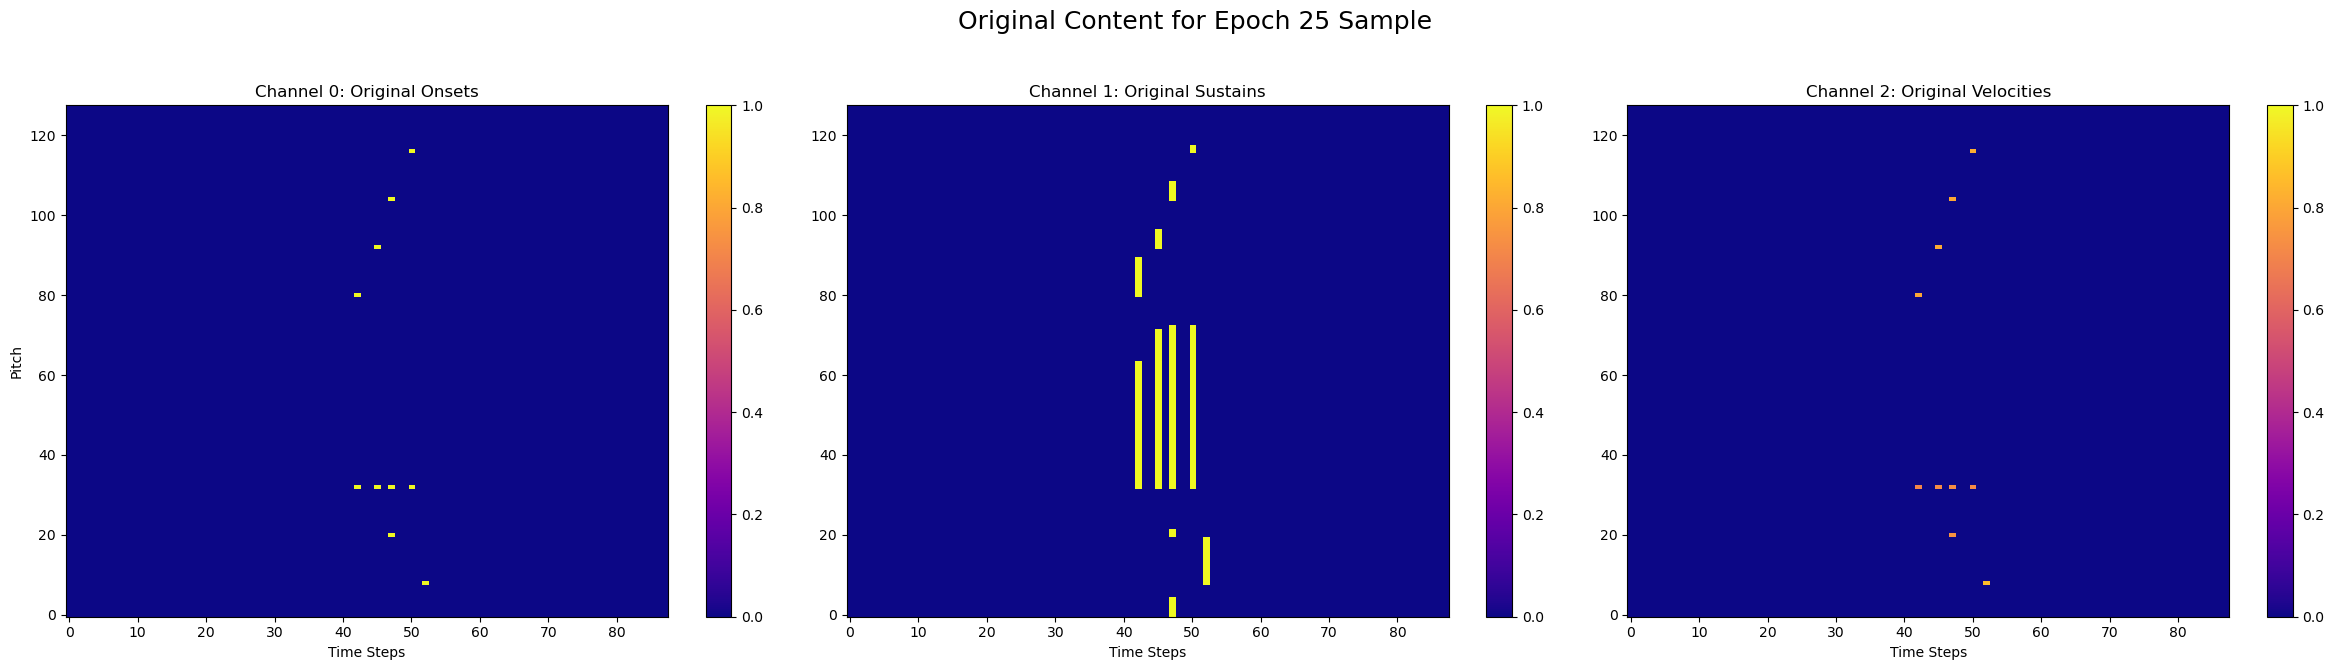

--- Visualizing: Generator Raw Output for Sample: sample_epoch_25_generated ---


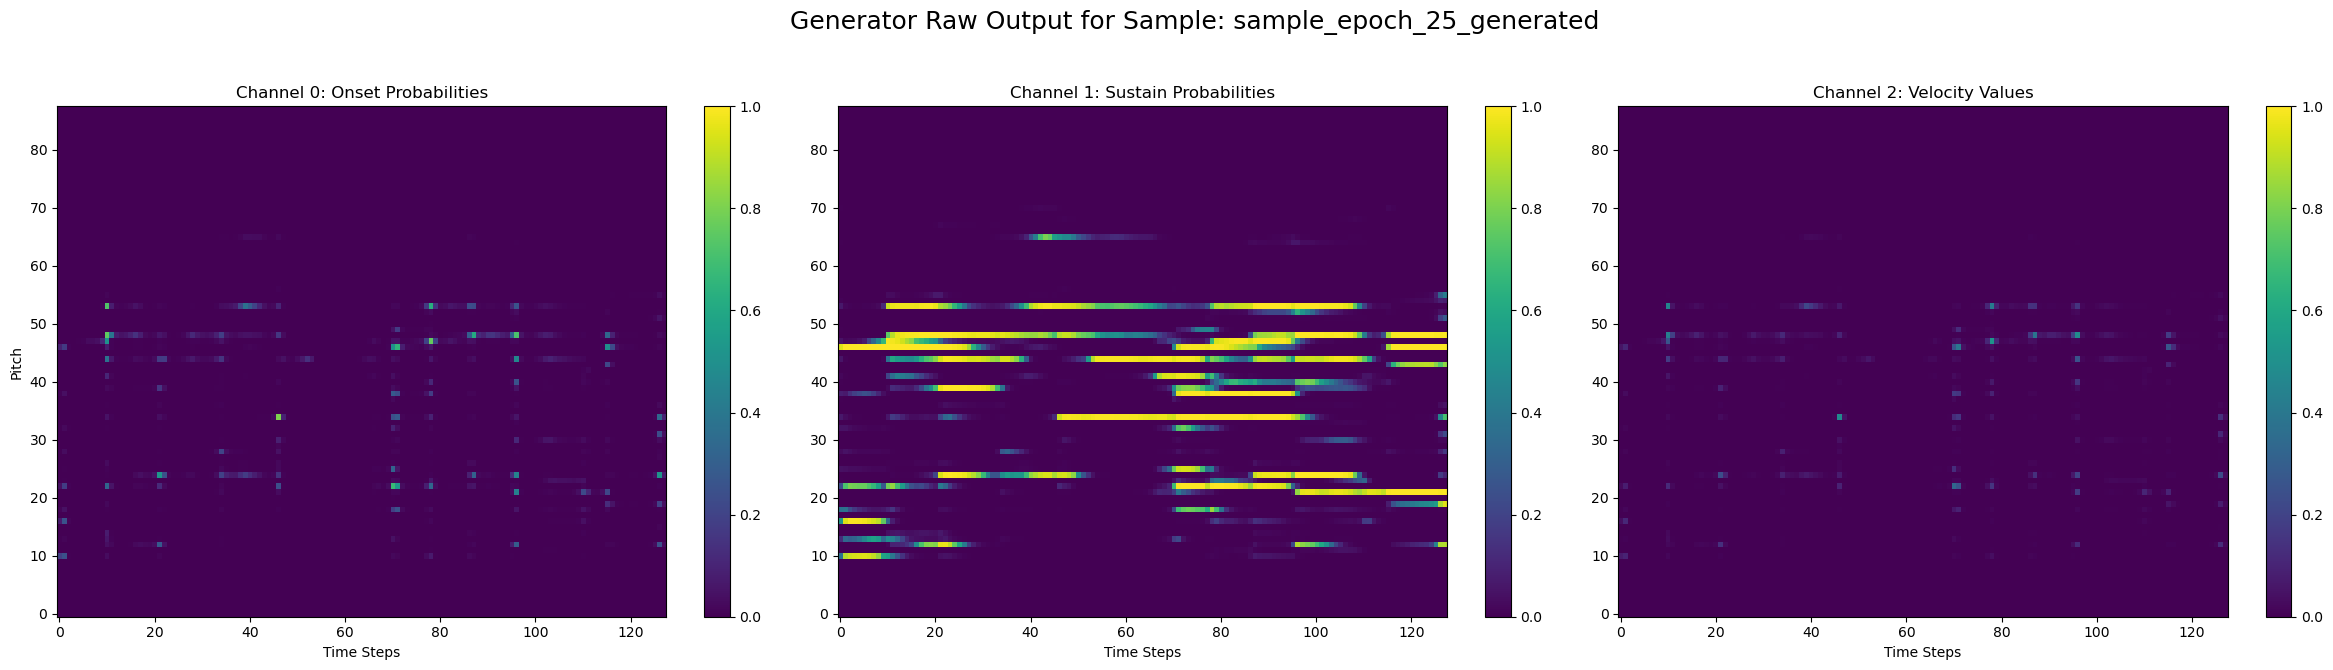

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_25.pth ---


PPO Epoch 26/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.495, R_genre(w=0.65)=0.486, R_recon(w=0.35)=0.510]


Epoch 26 Summary: Avg Reward: 0.5331 | Avg Genre: 0.5277, Avg Recon: 0.5433


PPO Epoch 27/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.651, R_genre(w=0.65)=0.629, R_recon(w=0.35)=0.693]


Epoch 27 Summary: Avg Reward: 0.5312 | Avg Genre: 0.5236, Avg Recon: 0.5453


PPO Epoch 28/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.525, R_genre(w=0.65)=0.473, R_recon(w=0.35)=0.622]


Epoch 28 Summary: Avg Reward: 0.5316 | Avg Genre: 0.5246, Avg Recon: 0.5447


PPO Epoch 29/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.504, R_genre(w=0.65)=0.483, R_recon(w=0.35)=0.543]


Epoch 29 Summary: Avg Reward: 0.5338 | Avg Genre: 0.5277, Avg Recon: 0.5453


PPO Epoch 30/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.574, R_genre(w=0.65)=0.499, R_recon(w=0.35)=0.714]


Epoch 30 Summary: Avg Reward: 0.5261 | Avg Genre: 0.5165, Avg Recon: 0.5441

--- Saving sample for epoch 30 ---
--- Visualizing: Original Content for Epoch 30 Sample ---


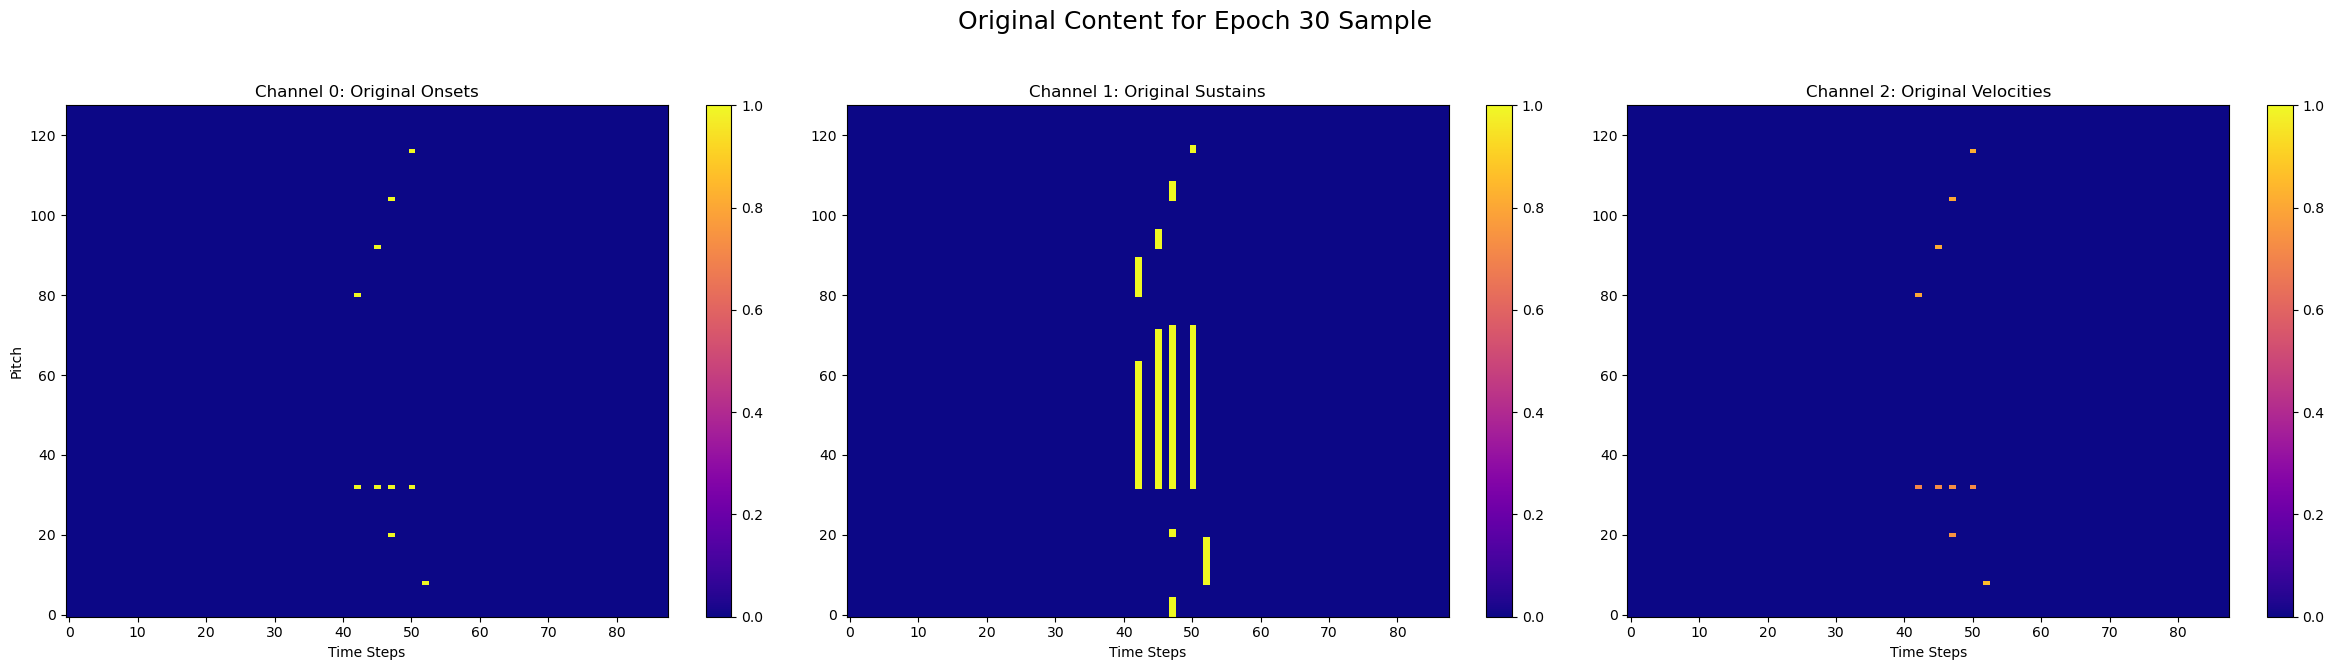

--- Visualizing: Generator Raw Output for Sample: sample_epoch_30_generated ---


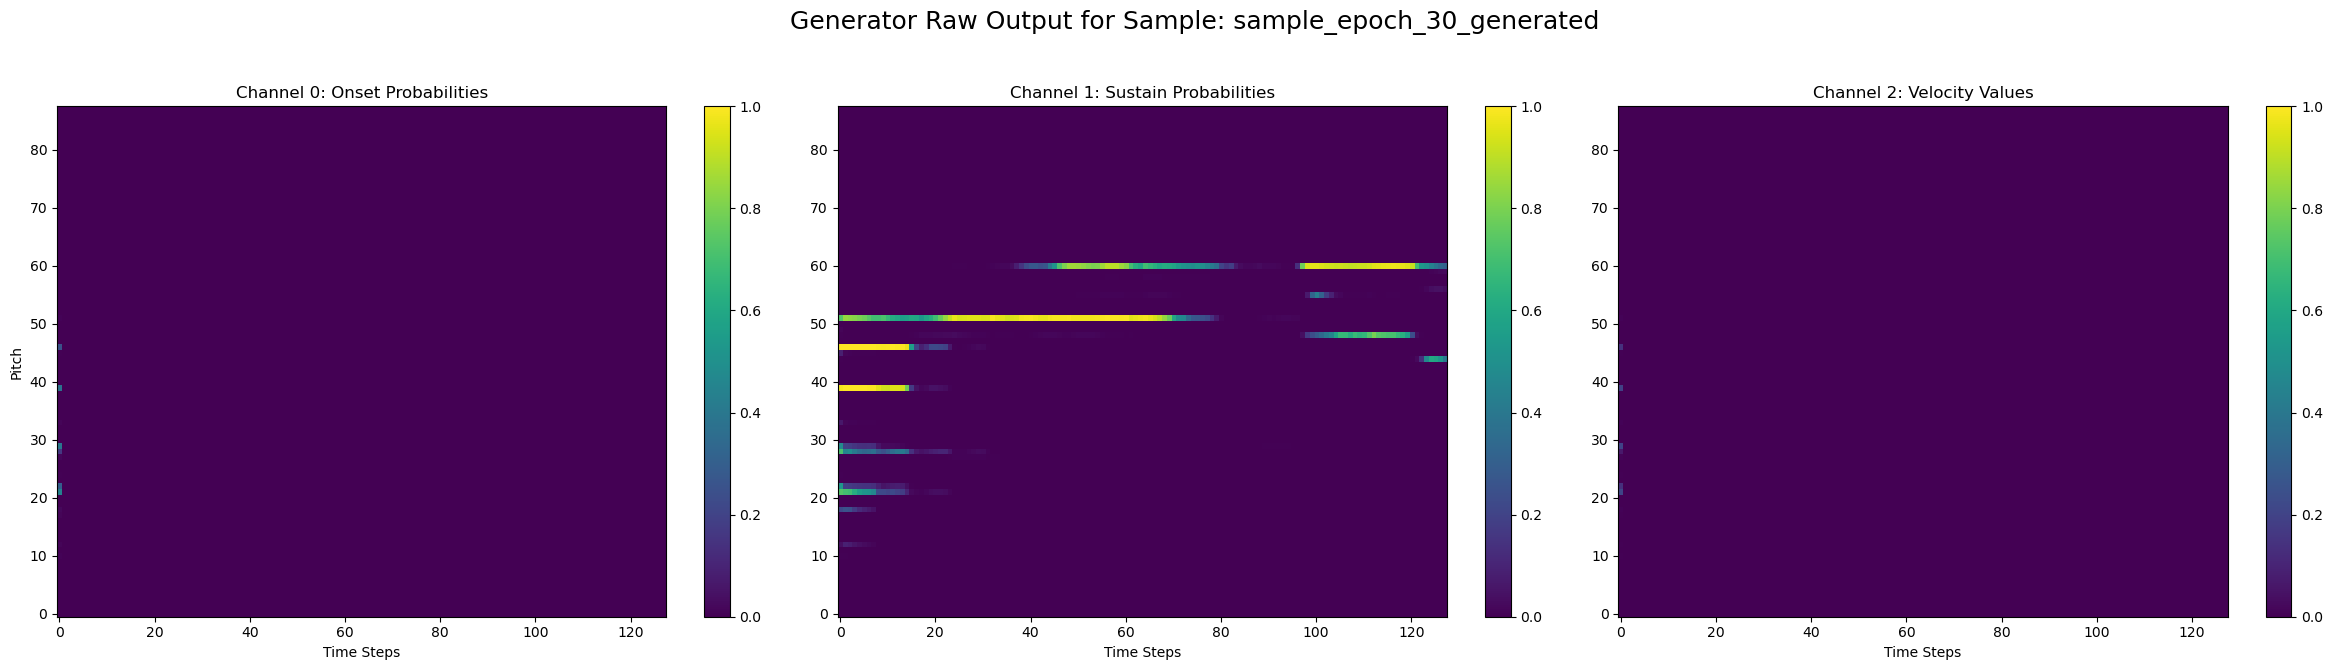

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_30.pth ---


PPO Epoch 31/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.491, R_genre(w=0.65)=0.432, R_recon(w=0.35)=0.599]


Epoch 31 Summary: Avg Reward: 0.5326 | Avg Genre: 0.5267, Avg Recon: 0.5436


PPO Epoch 32/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.629, R_genre(w=0.65)=0.678, R_recon(w=0.35)=0.536]


Epoch 32 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5256, Avg Recon: 0.5441


PPO Epoch 33/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.674, R_genre(w=0.65)=0.711, R_recon(w=0.35)=0.607]


Epoch 33 Summary: Avg Reward: 0.5298 | Avg Genre: 0.5222, Avg Recon: 0.5439


PPO Epoch 34/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.507, R_genre(w=0.65)=0.487, R_recon(w=0.35)=0.545]


Epoch 34 Summary: Avg Reward: 0.5295 | Avg Genre: 0.5225, Avg Recon: 0.5426


PPO Epoch 35/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.366, R_genre(w=0.65)=0.261, R_recon(w=0.35)=0.562]


Epoch 35 Summary: Avg Reward: 0.5285 | Avg Genre: 0.5201, Avg Recon: 0.5441

--- Saving sample for epoch 35 ---
--- Visualizing: Original Content for Epoch 35 Sample ---


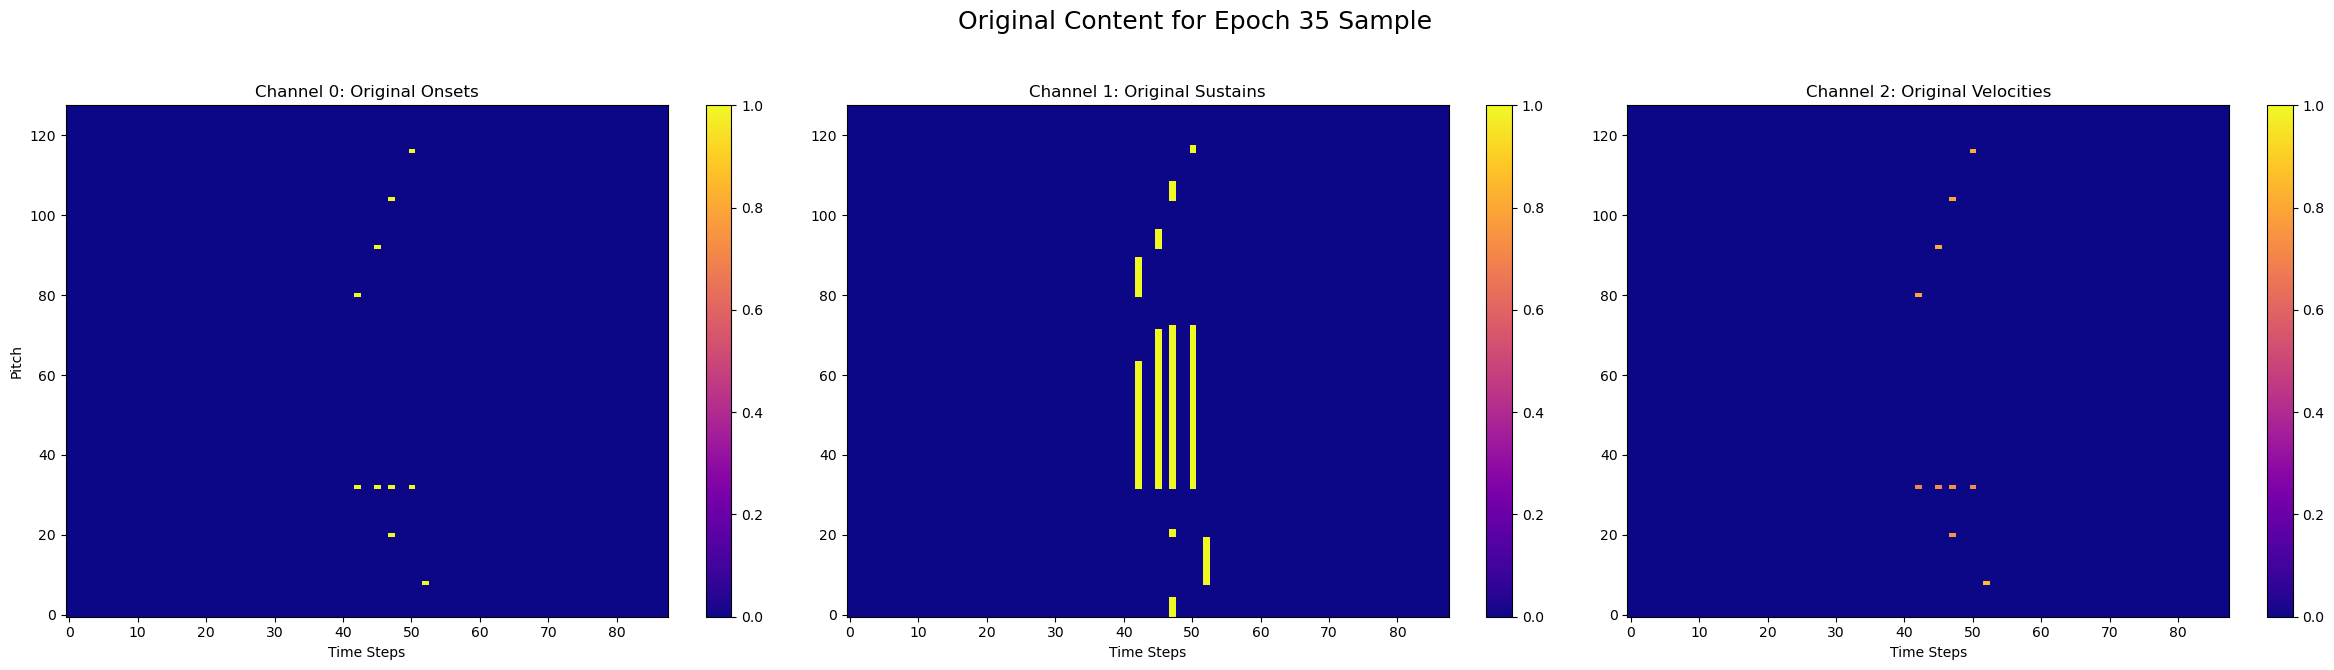

--- Visualizing: Generator Raw Output for Sample: sample_epoch_35_generated ---


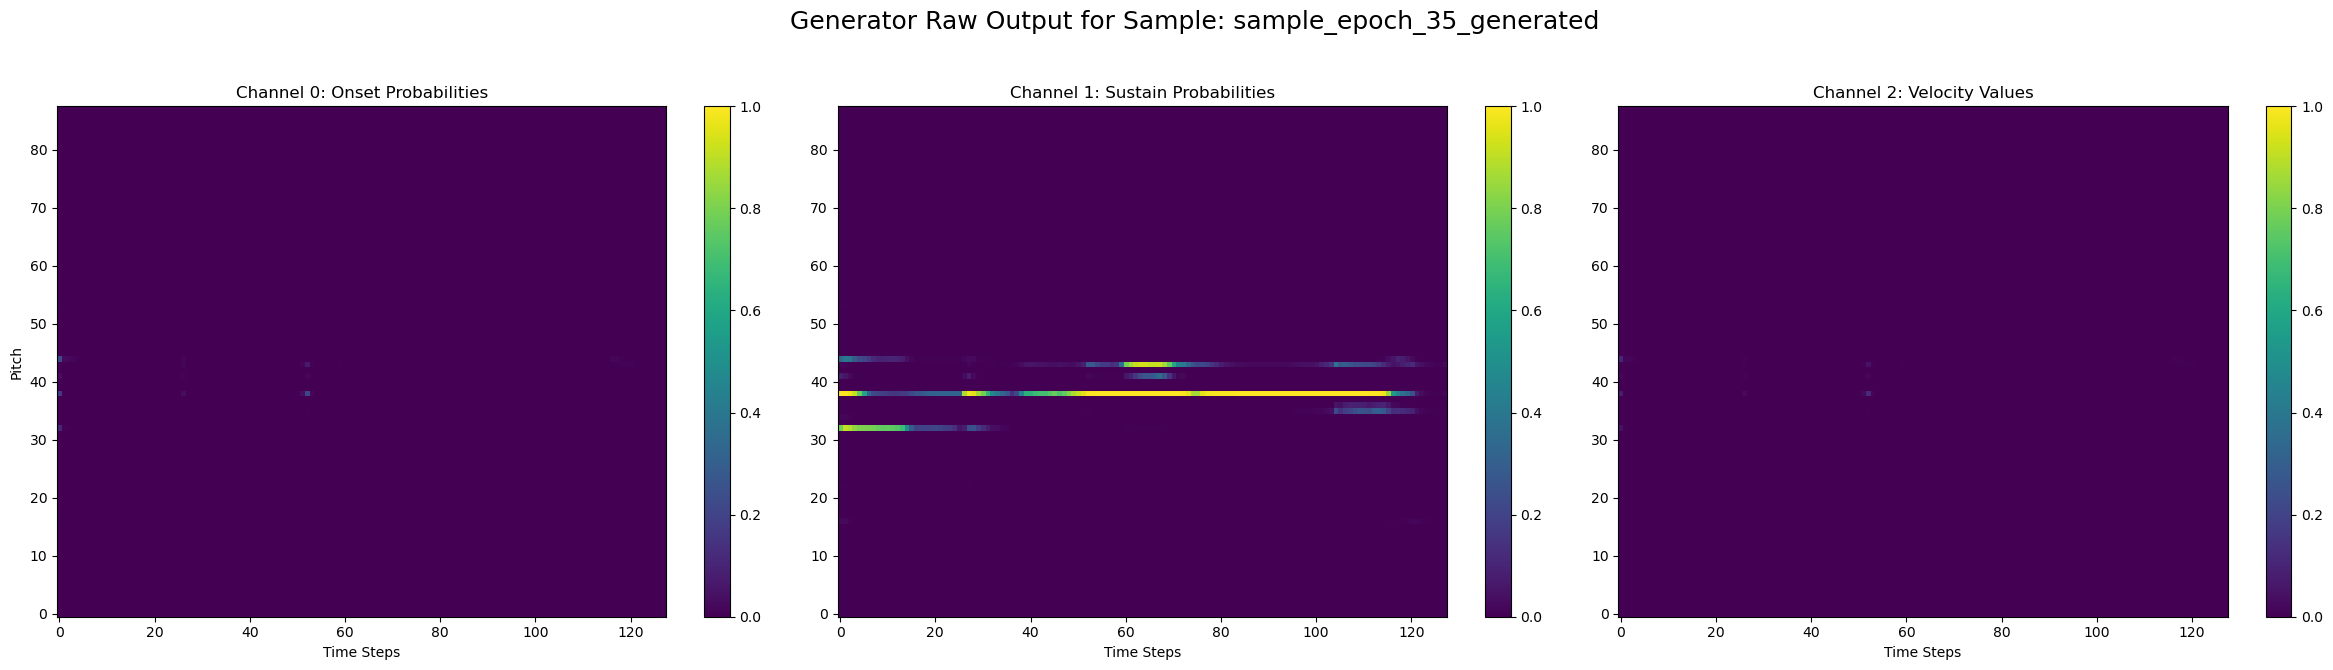

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_35.pth ---


PPO Epoch 36/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.694, R_genre(w=0.65)=0.803, R_recon(w=0.35)=0.490]


Epoch 36 Summary: Avg Reward: 0.5321 | Avg Genre: 0.5257, Avg Recon: 0.5440


PPO Epoch 37/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.588, R_genre(w=0.65)=0.681, R_recon(w=0.35)=0.416]


Epoch 37 Summary: Avg Reward: 0.5330 | Avg Genre: 0.5271, Avg Recon: 0.5439


PPO Epoch 38/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.422, R_genre(w=0.65)=0.318, R_recon(w=0.35)=0.617]


Epoch 38 Summary: Avg Reward: 0.5304 | Avg Genre: 0.5236, Avg Recon: 0.5431


PPO Epoch 39/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.384, R_genre(w=0.65)=0.239, R_recon(w=0.35)=0.653]


Epoch 39 Summary: Avg Reward: 0.5297 | Avg Genre: 0.5214, Avg Recon: 0.5450


PPO Epoch 40/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.548, R_genre(w=0.65)=0.550, R_recon(w=0.35)=0.546]


Epoch 40 Summary: Avg Reward: 0.5288 | Avg Genre: 0.5202, Avg Recon: 0.5448

--- Saving sample for epoch 40 ---
--- Visualizing: Original Content for Epoch 40 Sample ---


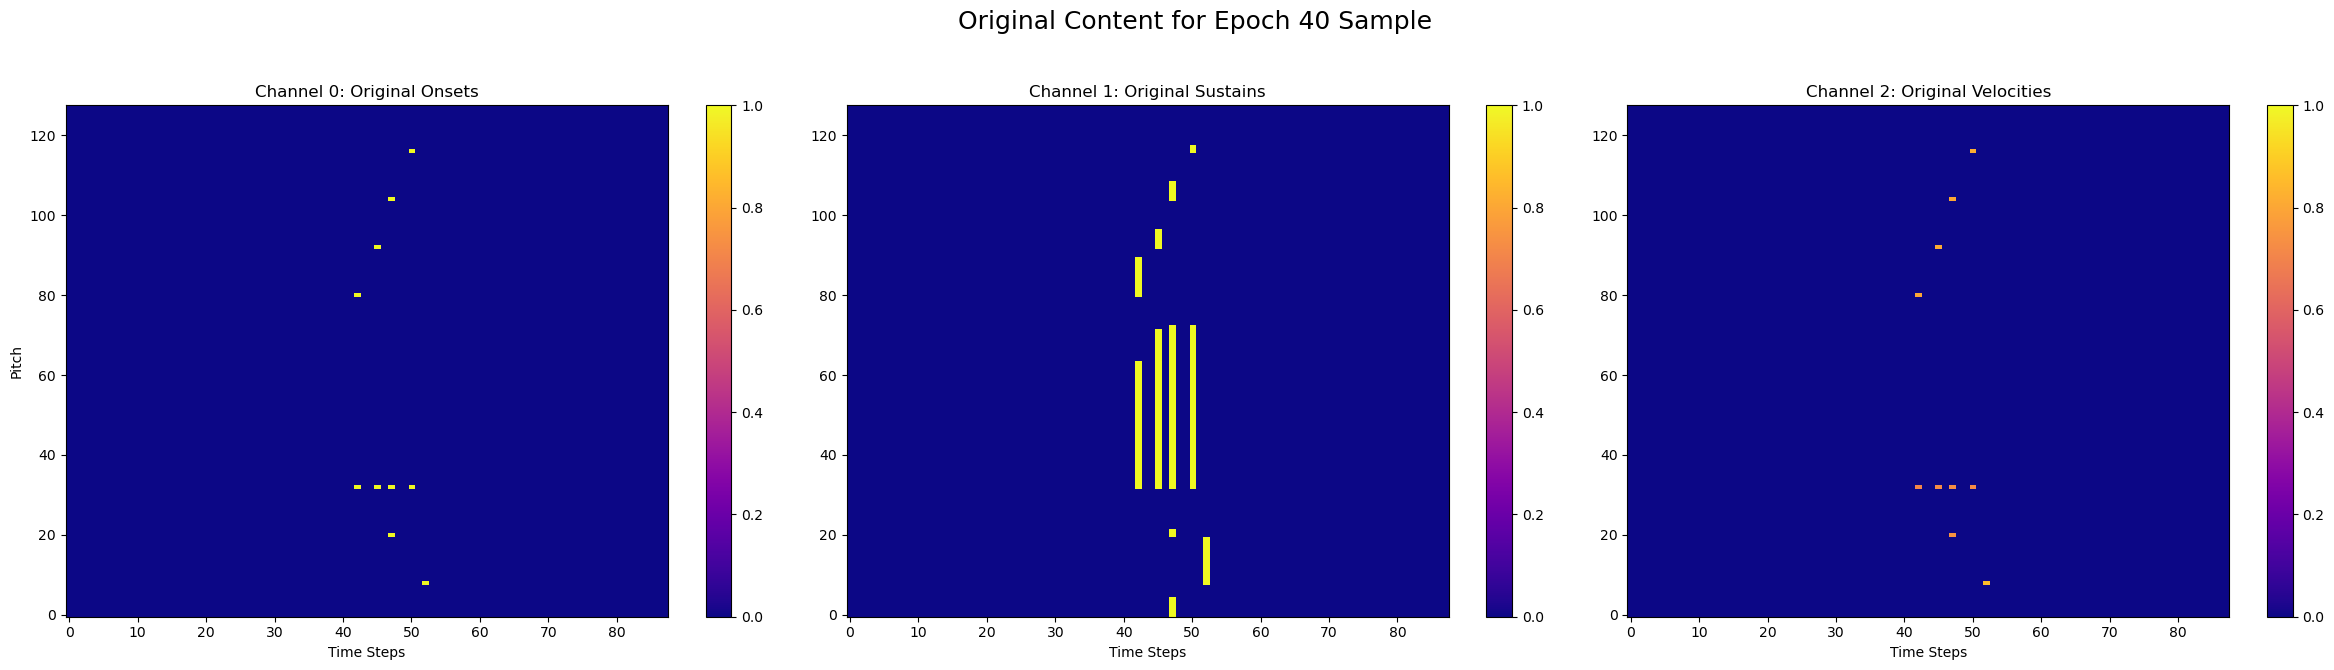

--- Visualizing: Generator Raw Output for Sample: sample_epoch_40_generated ---


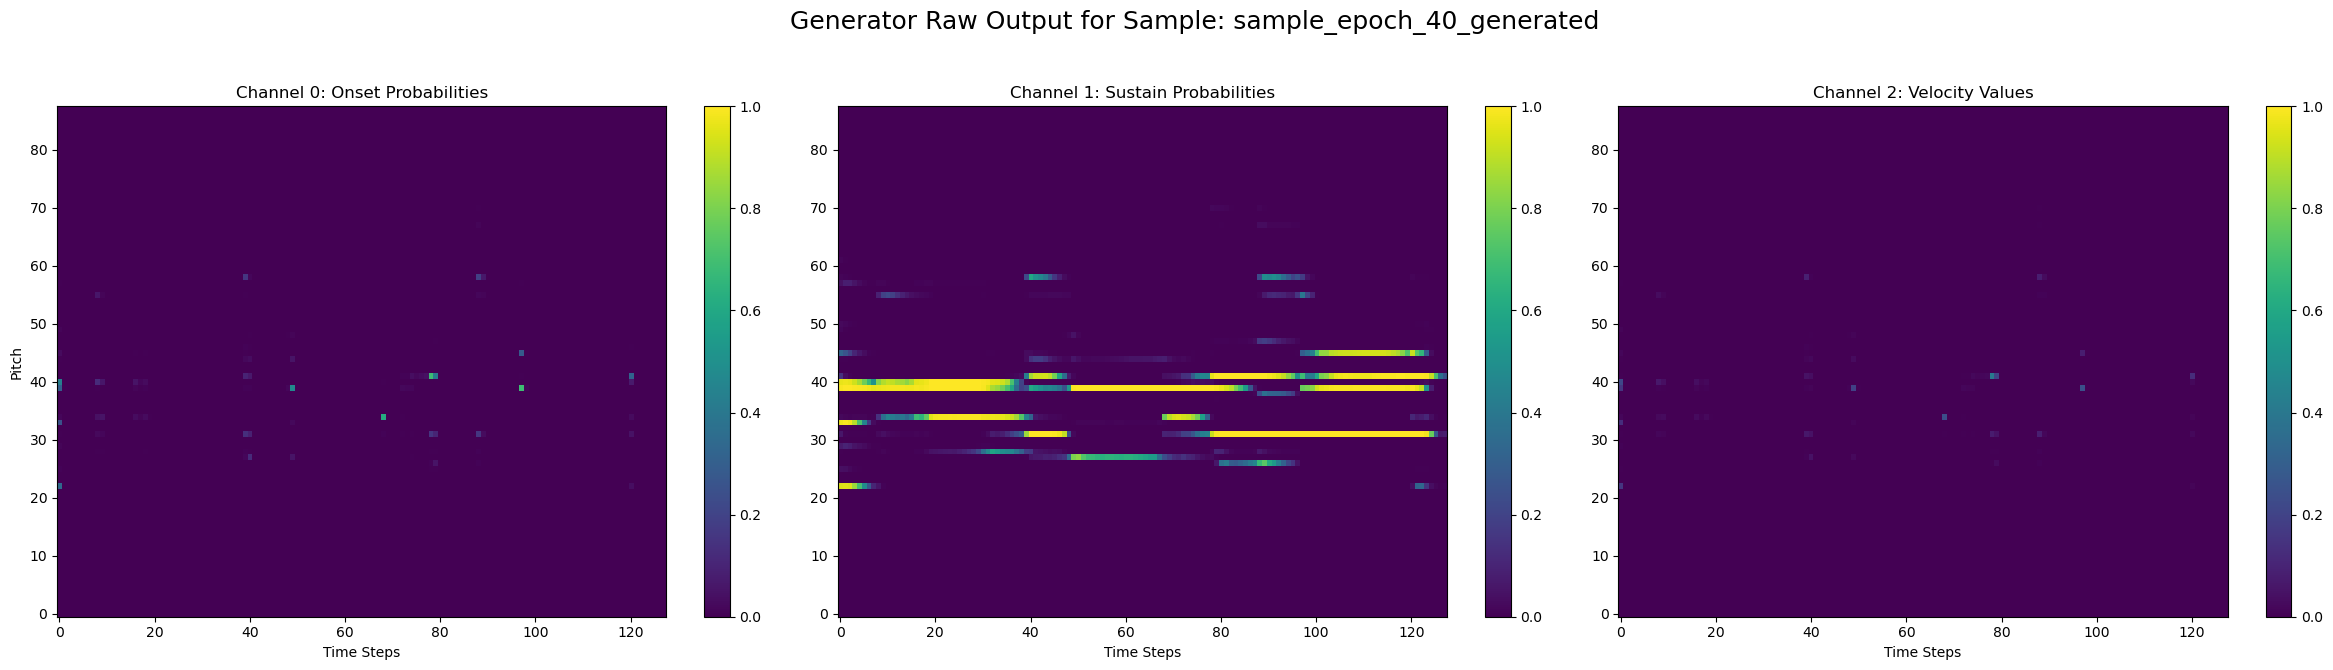

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_40.pth ---


PPO Epoch 41/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.432, R_genre(w=0.65)=0.413, R_recon(w=0.35)=0.466]


Epoch 41 Summary: Avg Reward: 0.5302 | Avg Genre: 0.5232, Avg Recon: 0.5432


PPO Epoch 42/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.514, R_genre(w=0.65)=0.488, R_recon(w=0.35)=0.564]


Epoch 42 Summary: Avg Reward: 0.5278 | Avg Genre: 0.5196, Avg Recon: 0.5432


PPO Epoch 43/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.500, R_genre(w=0.65)=0.489, R_recon(w=0.35)=0.522]


Epoch 43 Summary: Avg Reward: 0.5304 | Avg Genre: 0.5234, Avg Recon: 0.5432


PPO Epoch 44/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.597, R_genre(w=0.65)=0.698, R_recon(w=0.35)=0.409]


Epoch 44 Summary: Avg Reward: 0.5300 | Avg Genre: 0.5227, Avg Recon: 0.5434


PPO Epoch 45/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.484, R_genre(w=0.65)=0.458, R_recon(w=0.35)=0.533]


Epoch 45 Summary: Avg Reward: 0.5307 | Avg Genre: 0.5236, Avg Recon: 0.5440

--- Saving sample for epoch 45 ---
--- Visualizing: Original Content for Epoch 45 Sample ---


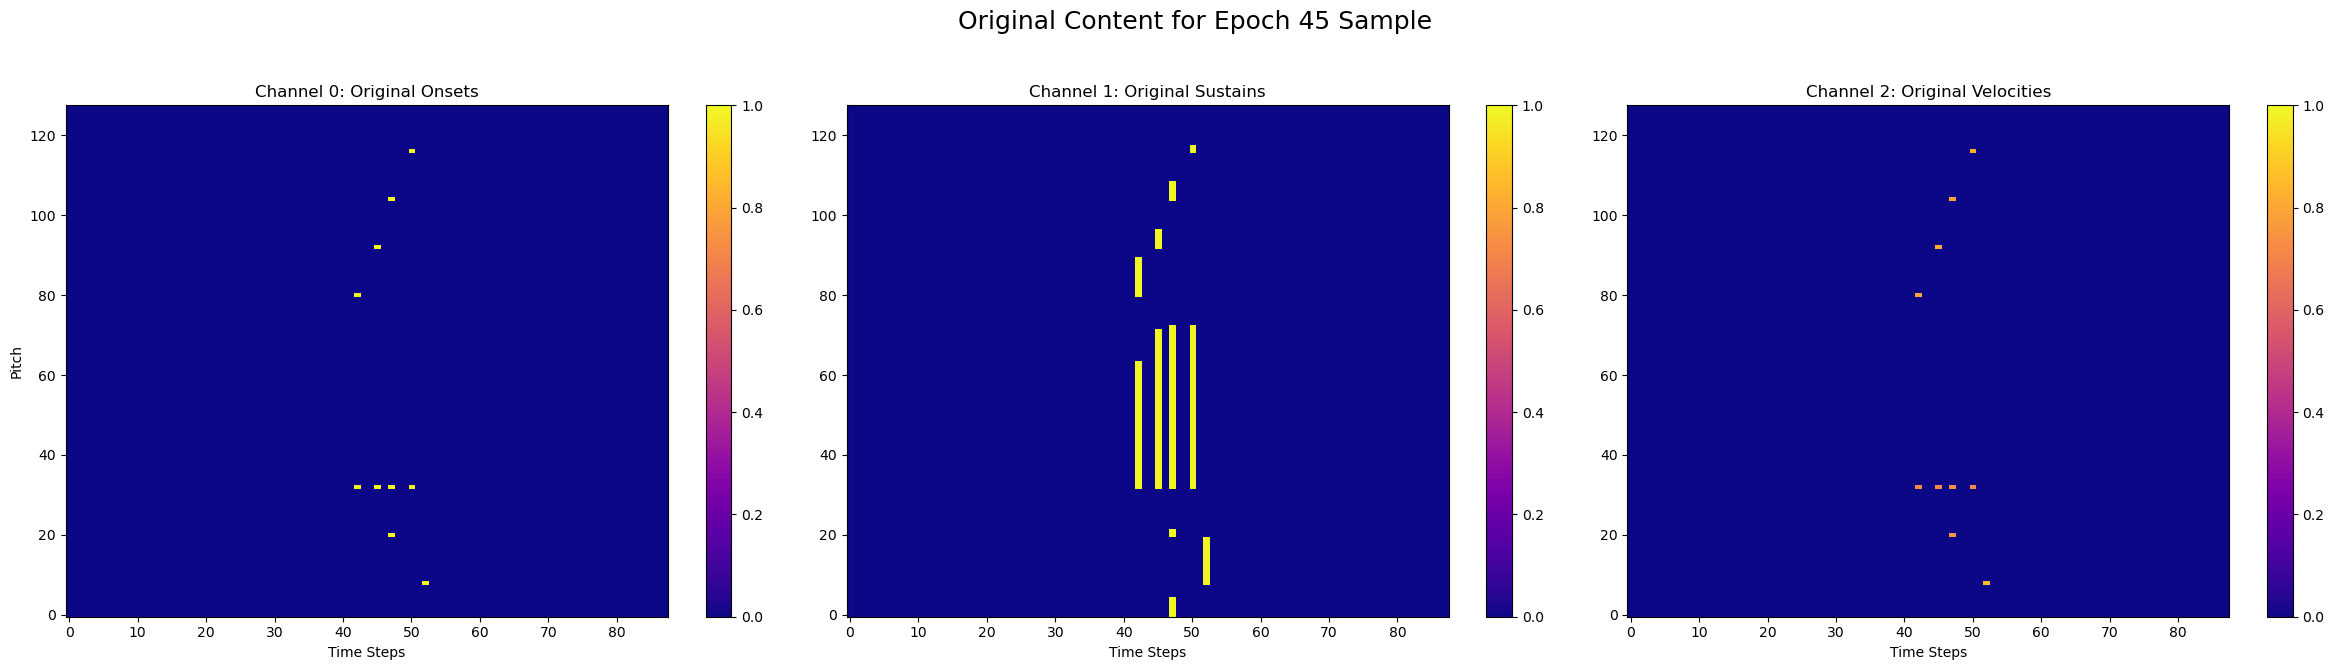

--- Visualizing: Generator Raw Output for Sample: sample_epoch_45_generated ---


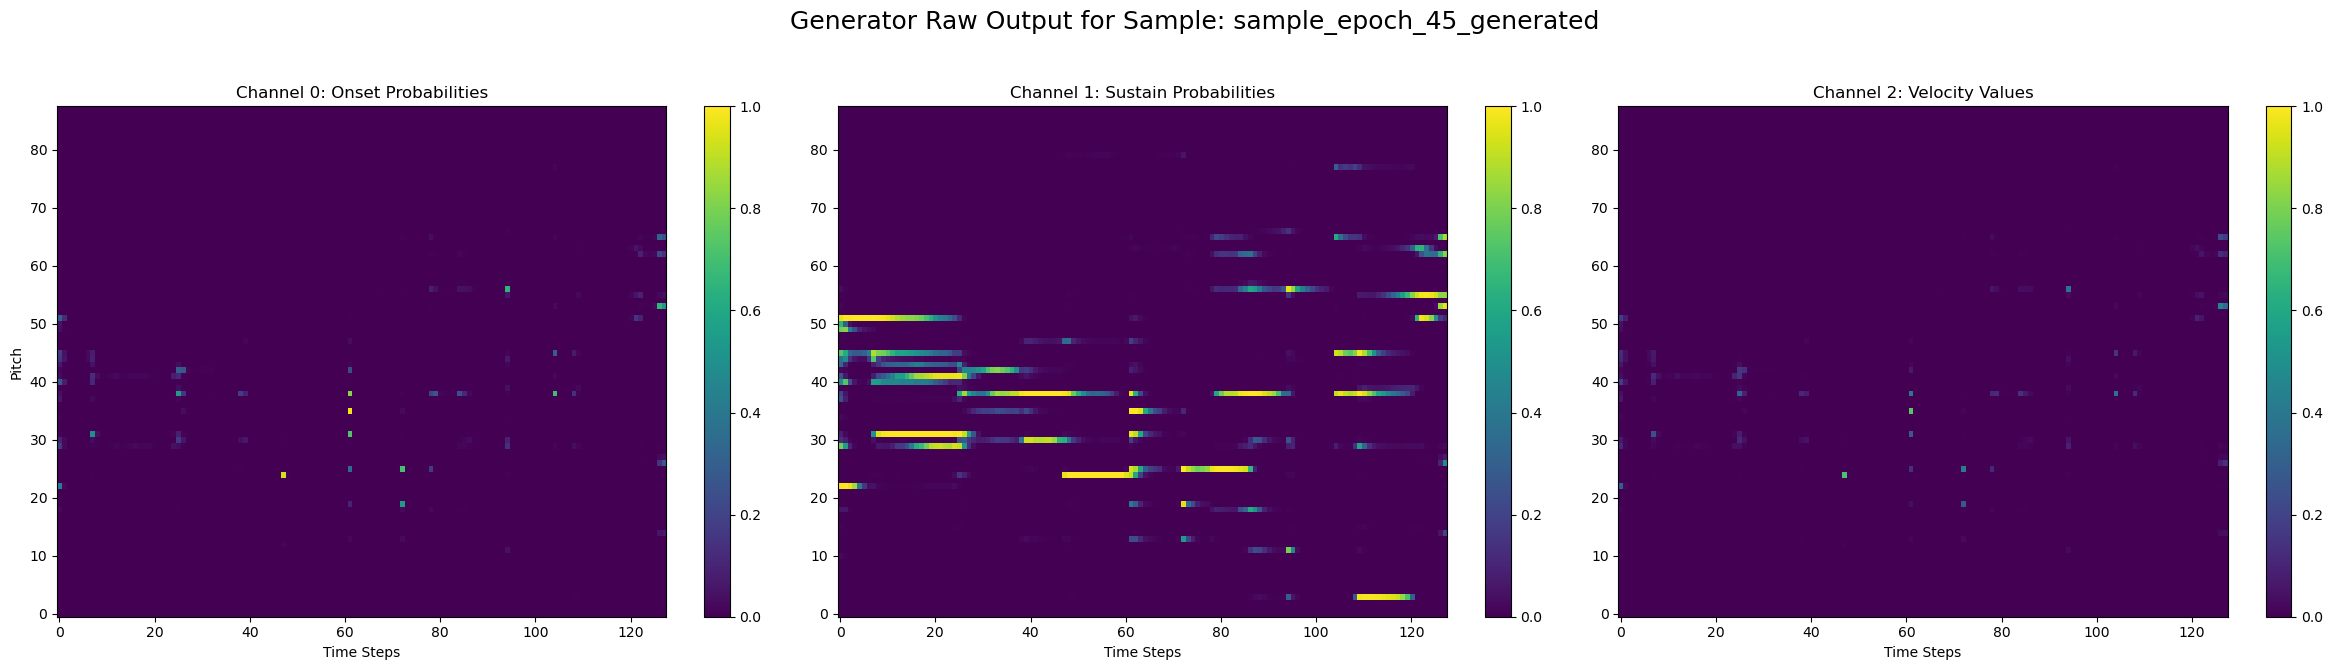

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_45.pth ---


PPO Epoch 46/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.581, R_genre(w=0.65)=0.643, R_recon(w=0.35)=0.466]


Epoch 46 Summary: Avg Reward: 0.5319 | Avg Genre: 0.5257, Avg Recon: 0.5434


PPO Epoch 47/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.629, R_genre(w=0.65)=0.675, R_recon(w=0.35)=0.544]


Epoch 47 Summary: Avg Reward: 0.5292 | Avg Genre: 0.5215, Avg Recon: 0.5436


PPO Epoch 48/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.556, R_genre(w=0.65)=0.580, R_recon(w=0.35)=0.513]


Epoch 48 Summary: Avg Reward: 0.5327 | Avg Genre: 0.5271, Avg Recon: 0.5431


PPO Epoch 49/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.382, R_genre(w=0.65)=0.324, R_recon(w=0.35)=0.490]


Epoch 49 Summary: Avg Reward: 0.5289 | Avg Genre: 0.5203, Avg Recon: 0.5450


PPO Epoch 50/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.505, R_genre(w=0.65)=0.556, R_recon(w=0.35)=0.411]


Epoch 50 Summary: Avg Reward: 0.5329 | Avg Genre: 0.5269, Avg Recon: 0.5441

--- Saving sample for epoch 50 ---
--- Visualizing: Original Content for Epoch 50 Sample ---


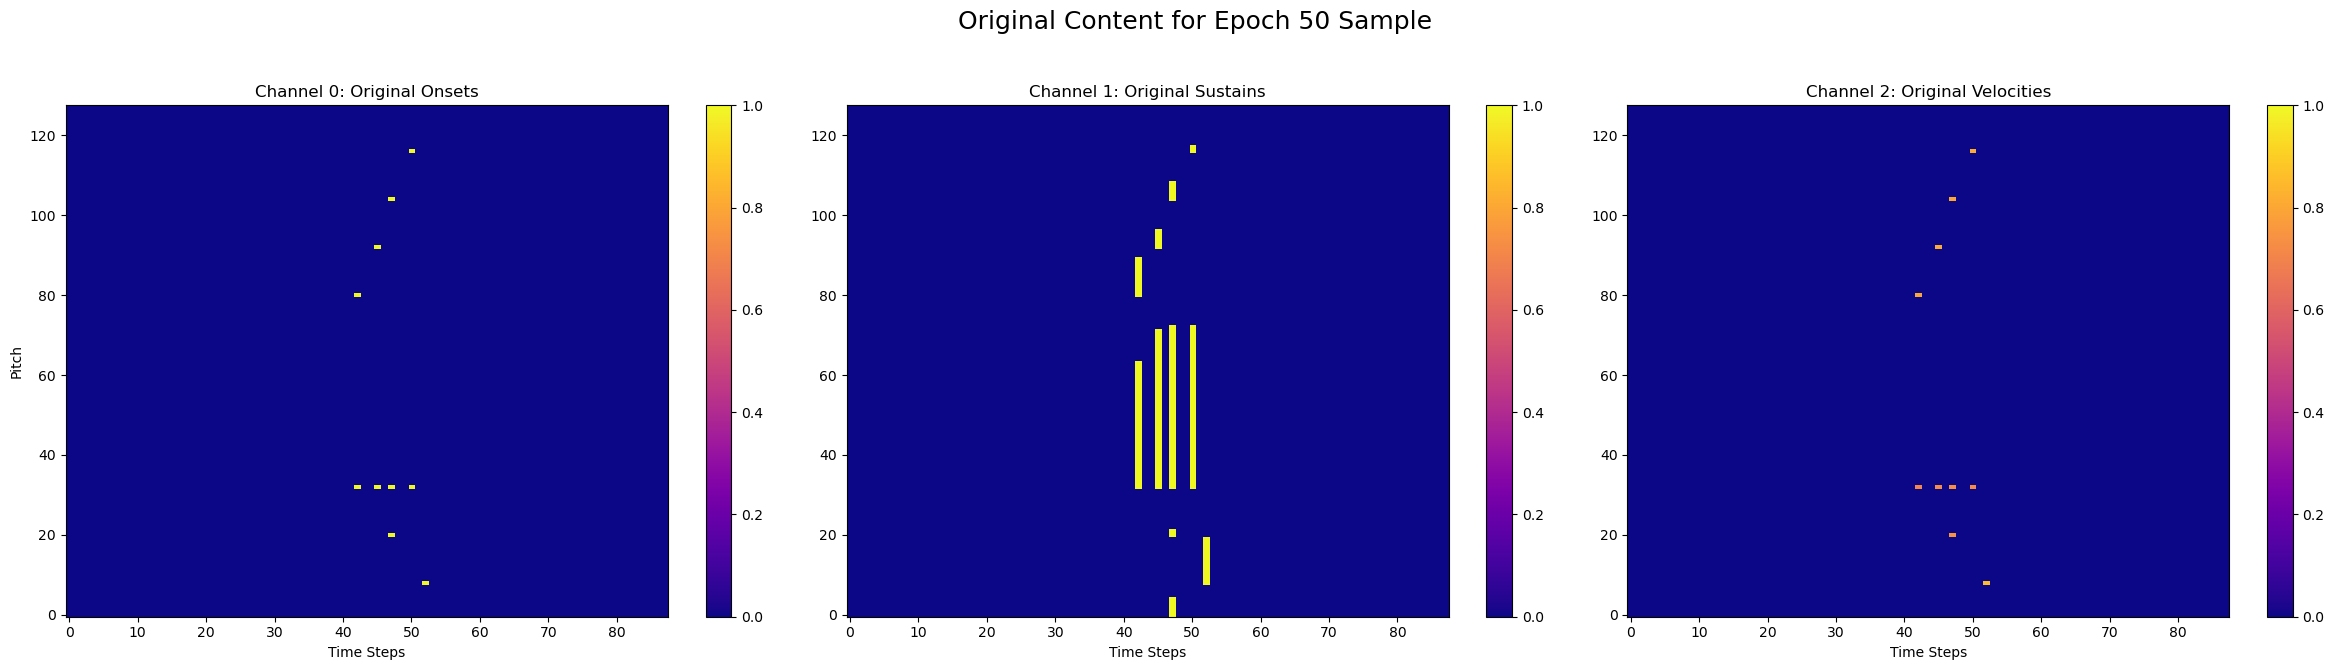

--- Visualizing: Generator Raw Output for Sample: sample_epoch_50_generated ---


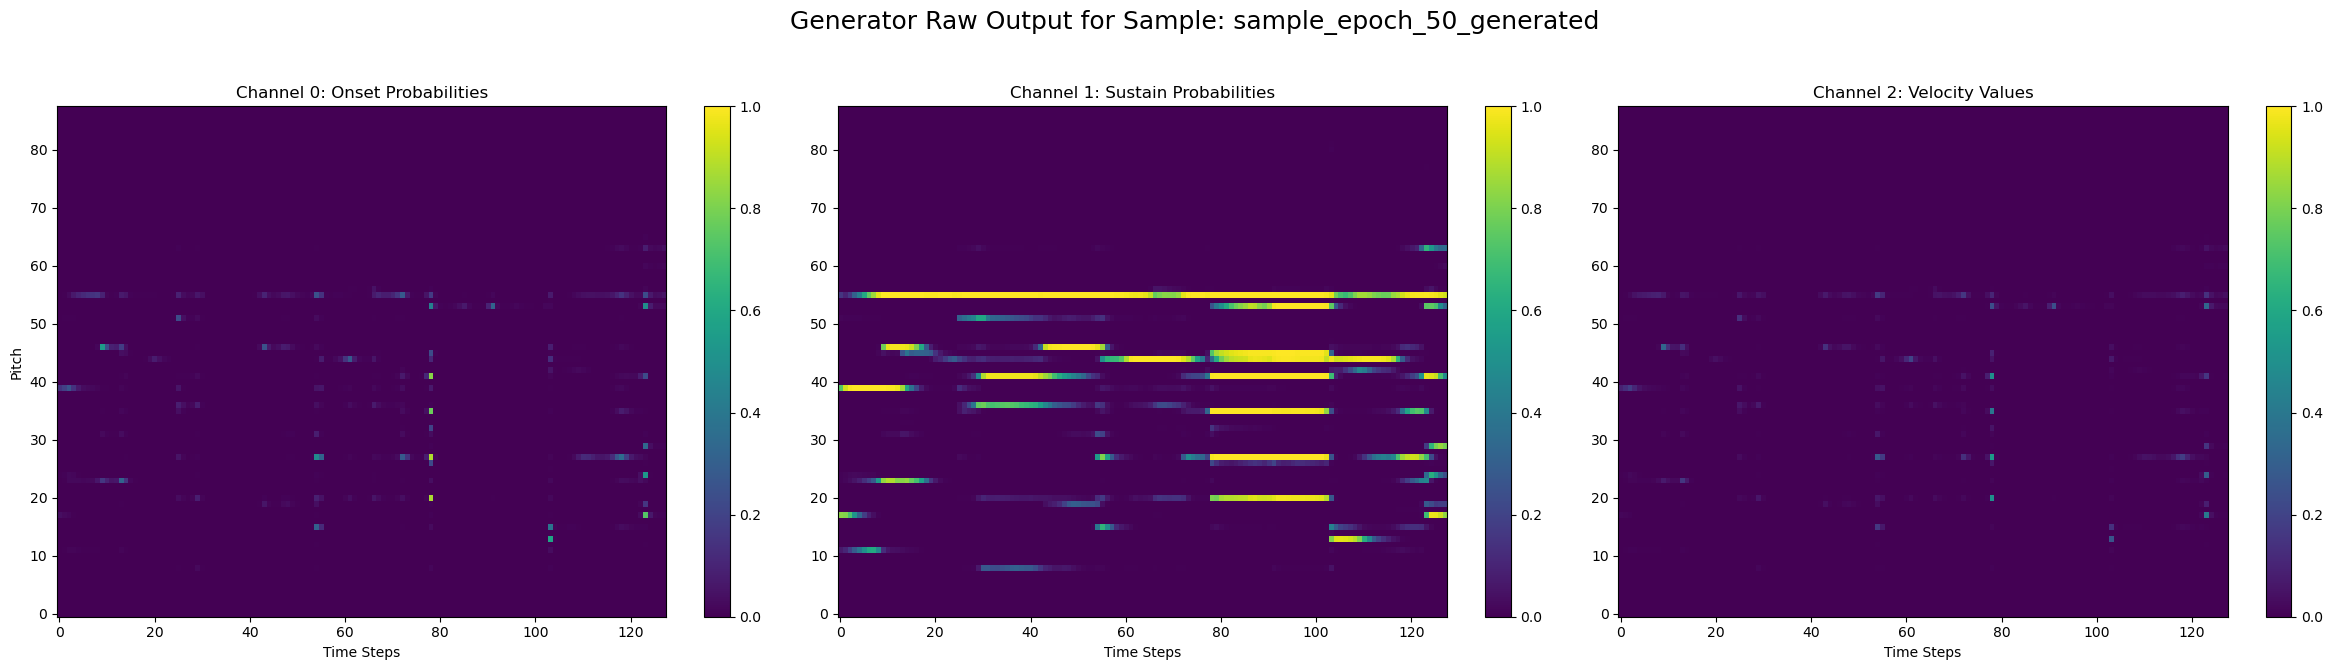

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_50.pth ---


PPO Epoch 51/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.658, R_genre(w=0.65)=0.722, R_recon(w=0.35)=0.537]


Epoch 51 Summary: Avg Reward: 0.5276 | Avg Genre: 0.5184, Avg Recon: 0.5448


PPO Epoch 52/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.591, R_genre(w=0.65)=0.596, R_recon(w=0.35)=0.582]


Epoch 52 Summary: Avg Reward: 0.5329 | Avg Genre: 0.5257, Avg Recon: 0.5462


PPO Epoch 53/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.530, R_genre(w=0.65)=0.486, R_recon(w=0.35)=0.611]


Epoch 53 Summary: Avg Reward: 0.5295 | Avg Genre: 0.5216, Avg Recon: 0.5443


PPO Epoch 54/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.640, R_genre(w=0.65)=0.617, R_recon(w=0.35)=0.682]


Epoch 54 Summary: Avg Reward: 0.5314 | Avg Genre: 0.5244, Avg Recon: 0.5444


PPO Epoch 55/100: 100%|██████████| 194/194 [01:33<00:00,  2.07it/s, R_total=0.606, R_genre(w=0.65)=0.633, R_recon(w=0.35)=0.555]


Epoch 55 Summary: Avg Reward: 0.5283 | Avg Genre: 0.5194, Avg Recon: 0.5450

--- Saving sample for epoch 55 ---
--- Visualizing: Original Content for Epoch 55 Sample ---


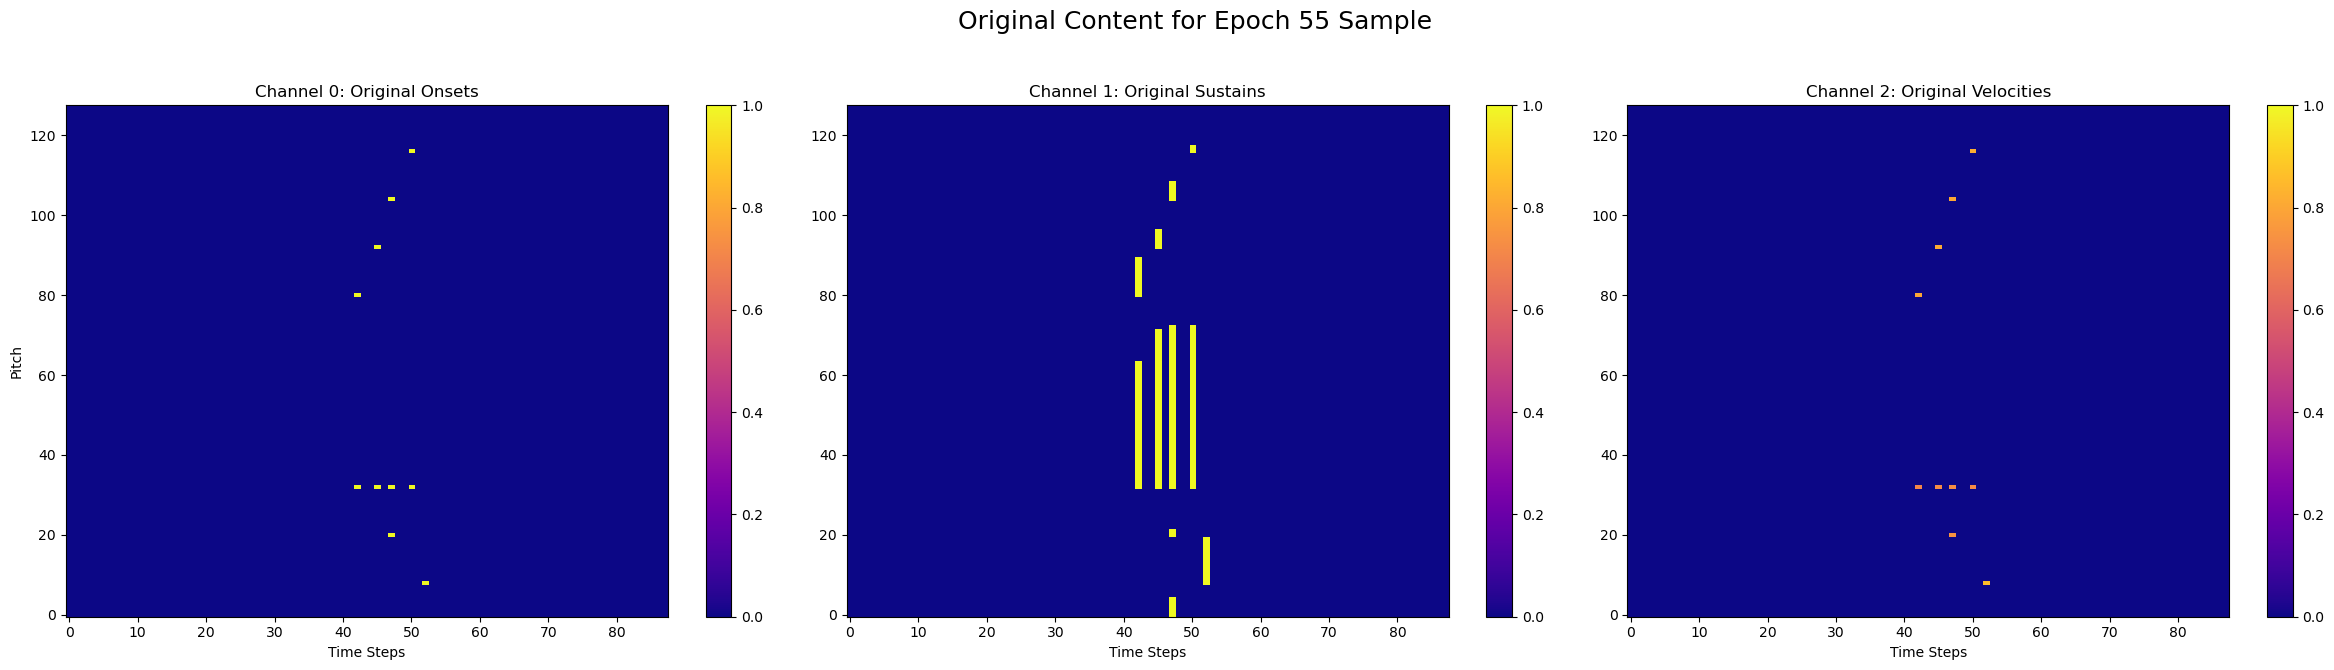

--- Visualizing: Generator Raw Output for Sample: sample_epoch_55_generated ---


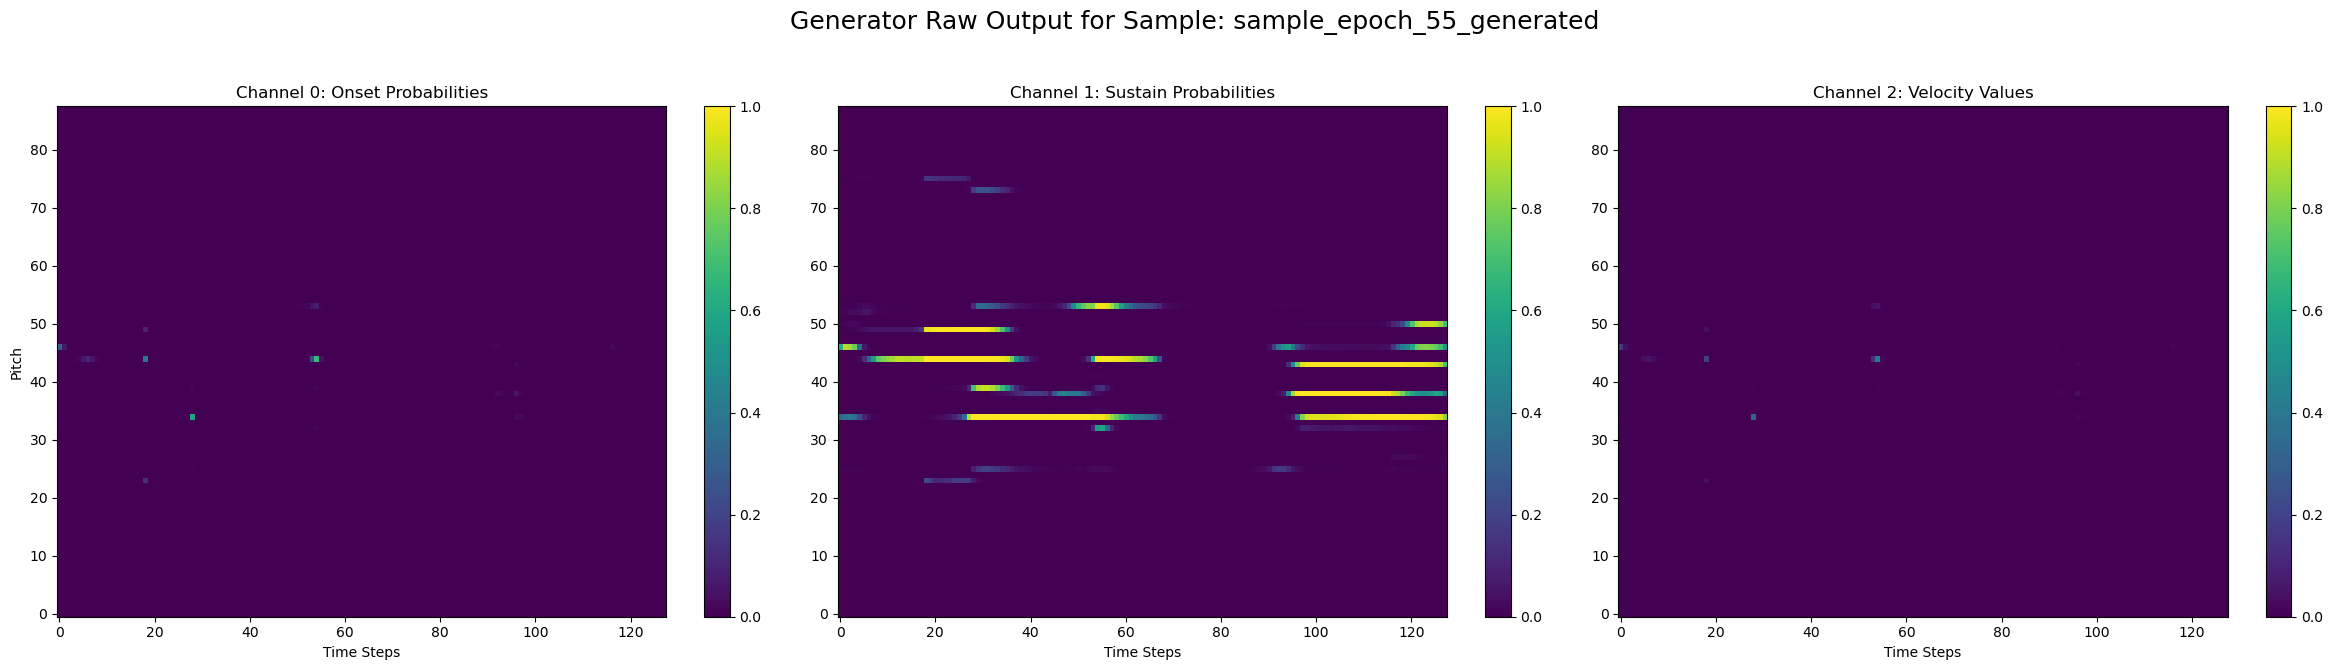

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_55.pth ---


PPO Epoch 56/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.470, R_genre(w=0.65)=0.457, R_recon(w=0.35)=0.494]


Epoch 56 Summary: Avg Reward: 0.5298 | Avg Genre: 0.5210, Avg Recon: 0.5460


PPO Epoch 57/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.457, R_genre(w=0.65)=0.391, R_recon(w=0.35)=0.580]


Epoch 57 Summary: Avg Reward: 0.5288 | Avg Genre: 0.5211, Avg Recon: 0.5430


PPO Epoch 58/100: 100%|██████████| 194/194 [01:34<00:00,  2.05it/s, R_total=0.457, R_genre(w=0.65)=0.477, R_recon(w=0.35)=0.421]


Epoch 58 Summary: Avg Reward: 0.5274 | Avg Genre: 0.5190, Avg Recon: 0.5429


PPO Epoch 59/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.443, R_genre(w=0.65)=0.390, R_recon(w=0.35)=0.542]


Epoch 59 Summary: Avg Reward: 0.5323 | Avg Genre: 0.5263, Avg Recon: 0.5436


PPO Epoch 60/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.561, R_genre(w=0.65)=0.552, R_recon(w=0.35)=0.578]


Epoch 60 Summary: Avg Reward: 0.5342 | Avg Genre: 0.5283, Avg Recon: 0.5453

--- Saving sample for epoch 60 ---
--- Visualizing: Original Content for Epoch 60 Sample ---


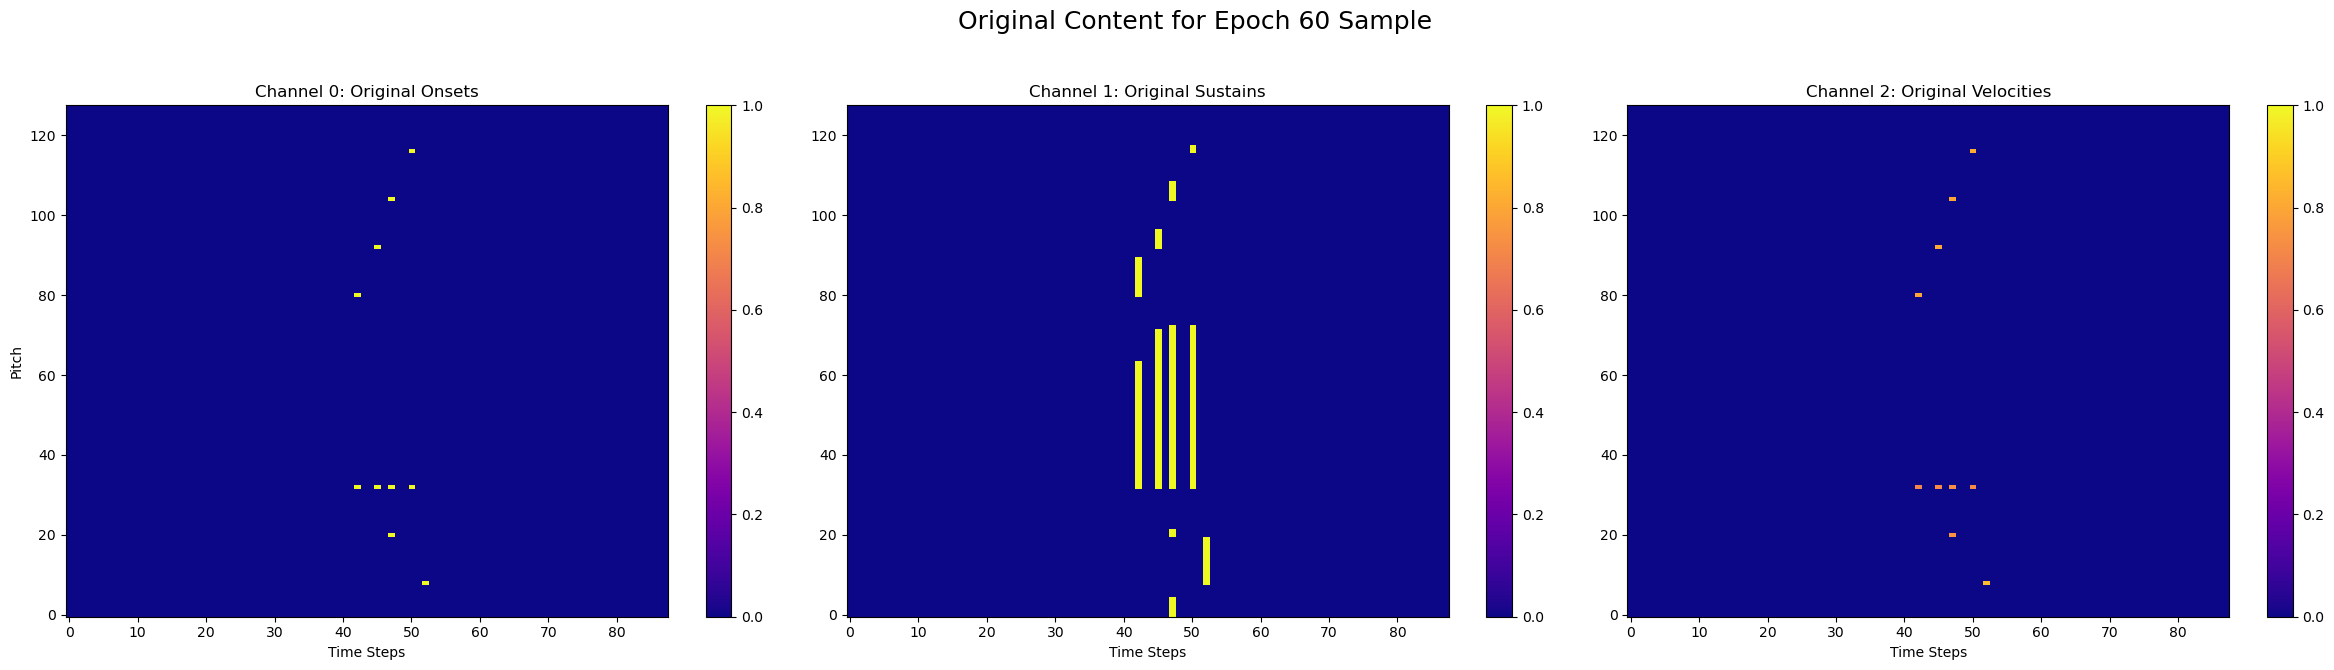

--- Visualizing: Generator Raw Output for Sample: sample_epoch_60_generated ---


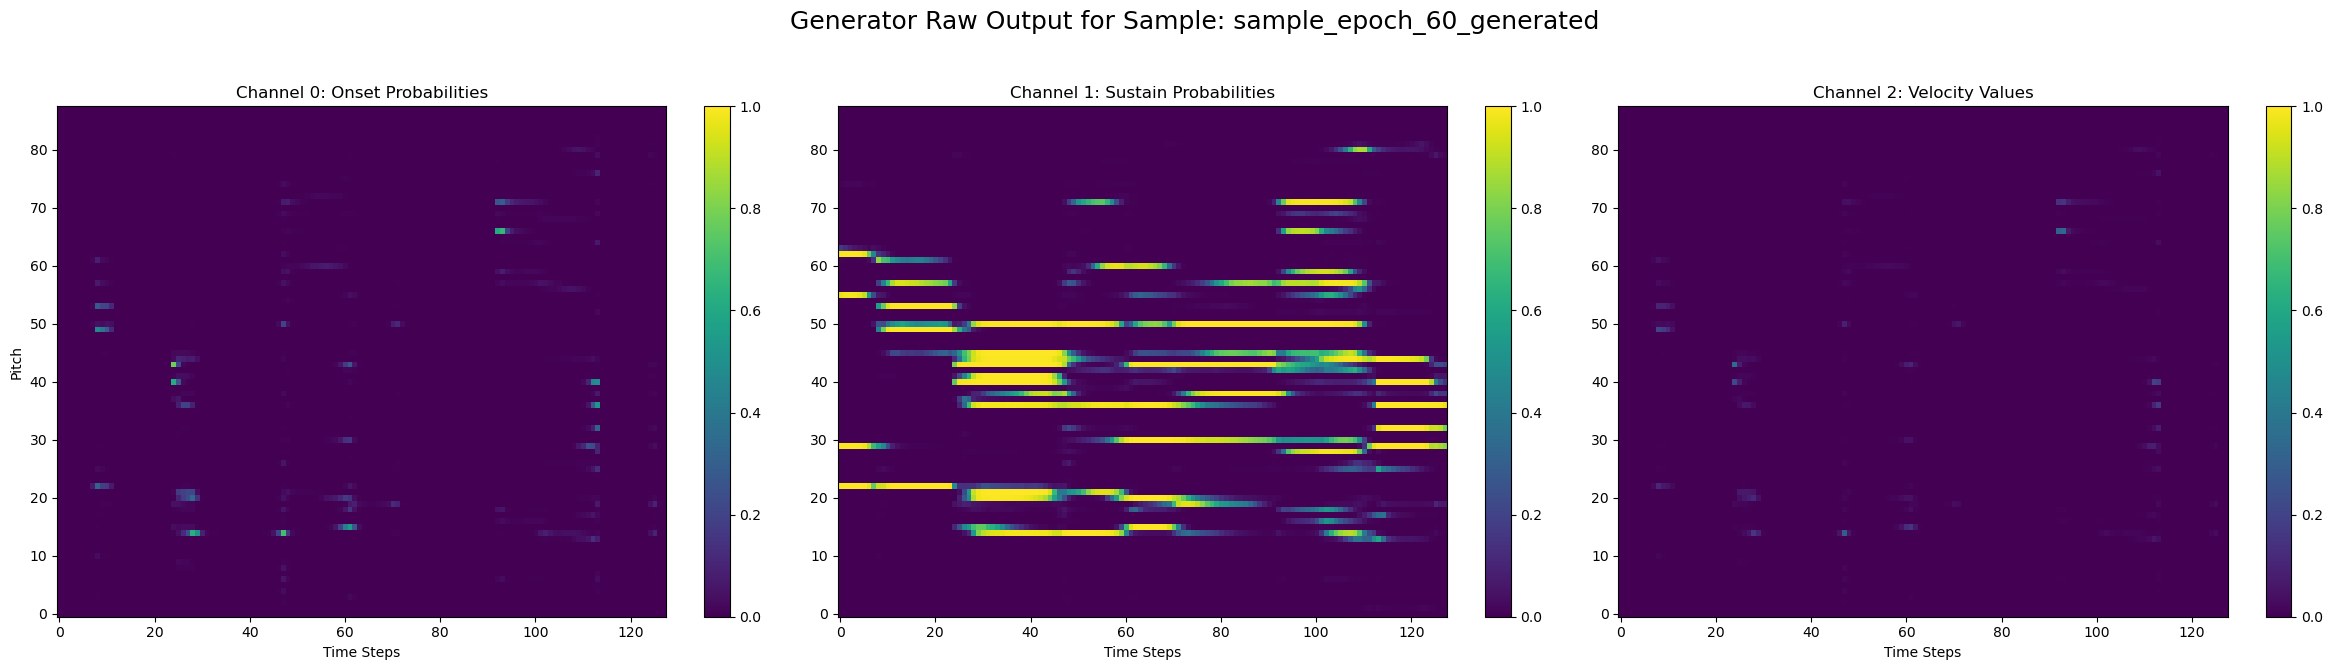

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_60.pth ---


PPO Epoch 61/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.534, R_genre(w=0.65)=0.425, R_recon(w=0.35)=0.736]


Epoch 61 Summary: Avg Reward: 0.5314 | Avg Genre: 0.5237, Avg Recon: 0.5456


PPO Epoch 62/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.502, R_genre(w=0.65)=0.464, R_recon(w=0.35)=0.571]


Epoch 62 Summary: Avg Reward: 0.5288 | Avg Genre: 0.5198, Avg Recon: 0.5456


PPO Epoch 63/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.445, R_genre(w=0.65)=0.356, R_recon(w=0.35)=0.609]


Epoch 63 Summary: Avg Reward: 0.5327 | Avg Genre: 0.5269, Avg Recon: 0.5435


PPO Epoch 64/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.528, R_genre(w=0.65)=0.569, R_recon(w=0.35)=0.451]


Epoch 64 Summary: Avg Reward: 0.5334 | Avg Genre: 0.5270, Avg Recon: 0.5451


PPO Epoch 65/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.589, R_genre(w=0.65)=0.548, R_recon(w=0.35)=0.664]


Epoch 65 Summary: Avg Reward: 0.5323 | Avg Genre: 0.5269, Avg Recon: 0.5423

--- Saving sample for epoch 65 ---
--- Visualizing: Original Content for Epoch 65 Sample ---


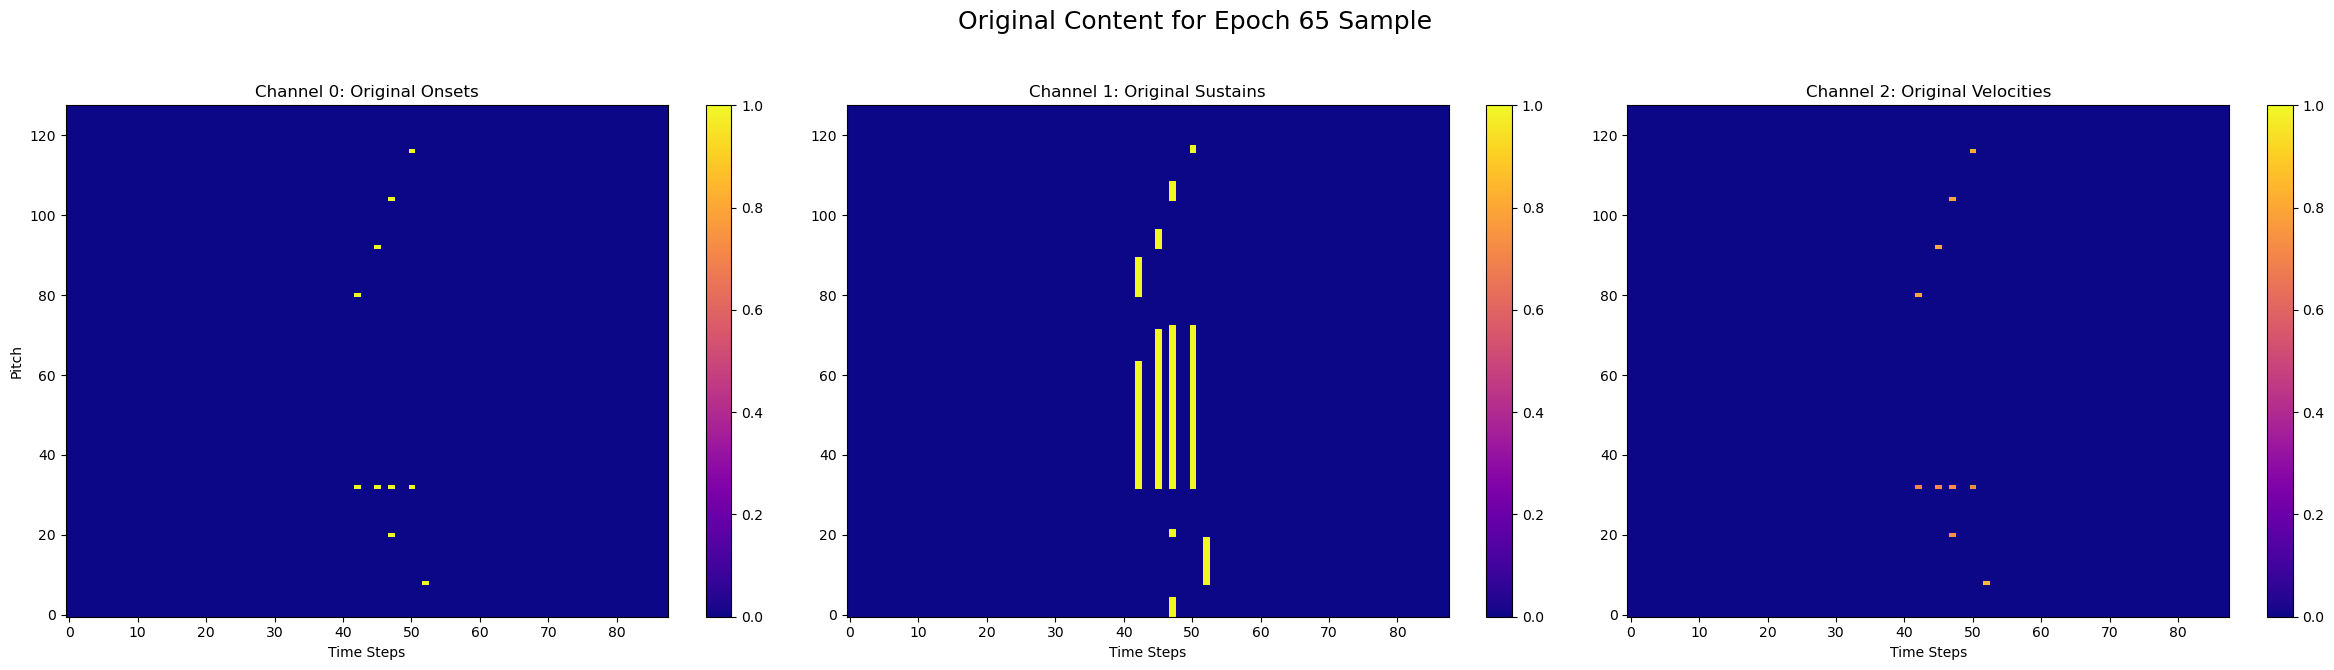

--- Visualizing: Generator Raw Output for Sample: sample_epoch_65_generated ---


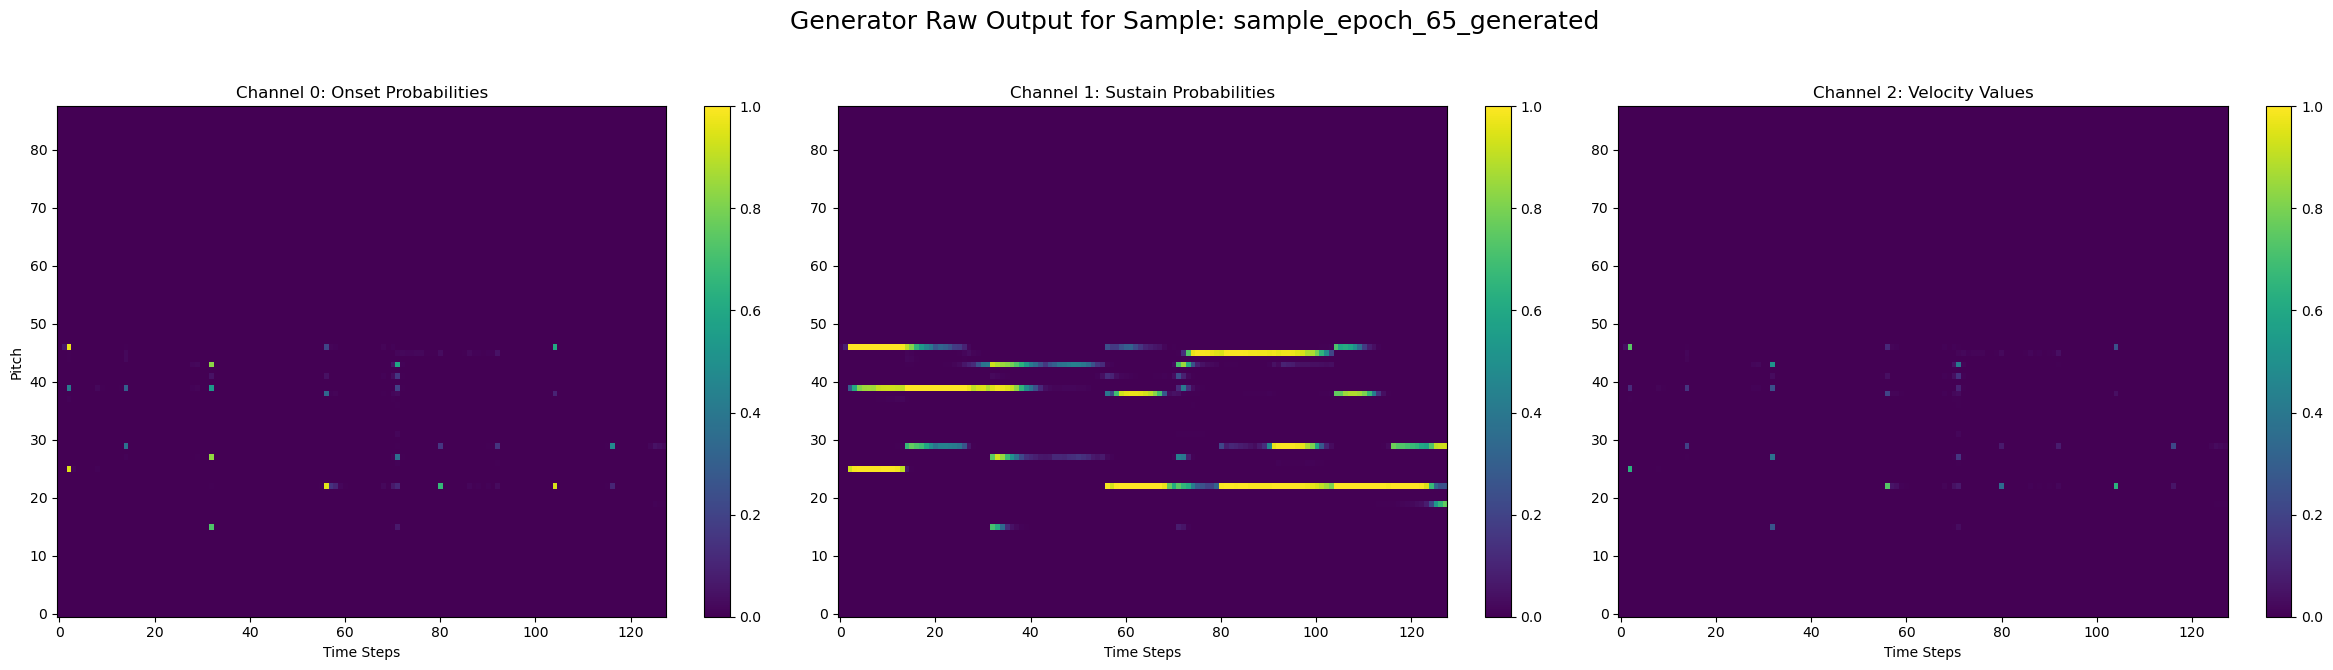

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_65.pth ---


PPO Epoch 66/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.431, R_genre(w=0.65)=0.359, R_recon(w=0.35)=0.564]


Epoch 66 Summary: Avg Reward: 0.5298 | Avg Genre: 0.5225, Avg Recon: 0.5431


PPO Epoch 67/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.454, R_genre(w=0.65)=0.341, R_recon(w=0.35)=0.663]


Epoch 67 Summary: Avg Reward: 0.5308 | Avg Genre: 0.5238, Avg Recon: 0.5440


PPO Epoch 68/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.534, R_genre(w=0.65)=0.568, R_recon(w=0.35)=0.472]


Epoch 68 Summary: Avg Reward: 0.5290 | Avg Genre: 0.5200, Avg Recon: 0.5457


PPO Epoch 69/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.455, R_genre(w=0.65)=0.436, R_recon(w=0.35)=0.490]


Epoch 69 Summary: Avg Reward: 0.5314 | Avg Genre: 0.5245, Avg Recon: 0.5441


PPO Epoch 70/100: 100%|██████████| 194/194 [01:34<00:00,  2.05it/s, R_total=0.490, R_genre(w=0.65)=0.381, R_recon(w=0.35)=0.694]


Epoch 70 Summary: Avg Reward: 0.5319 | Avg Genre: 0.5260, Avg Recon: 0.5427

--- Saving sample for epoch 70 ---
--- Visualizing: Original Content for Epoch 70 Sample ---


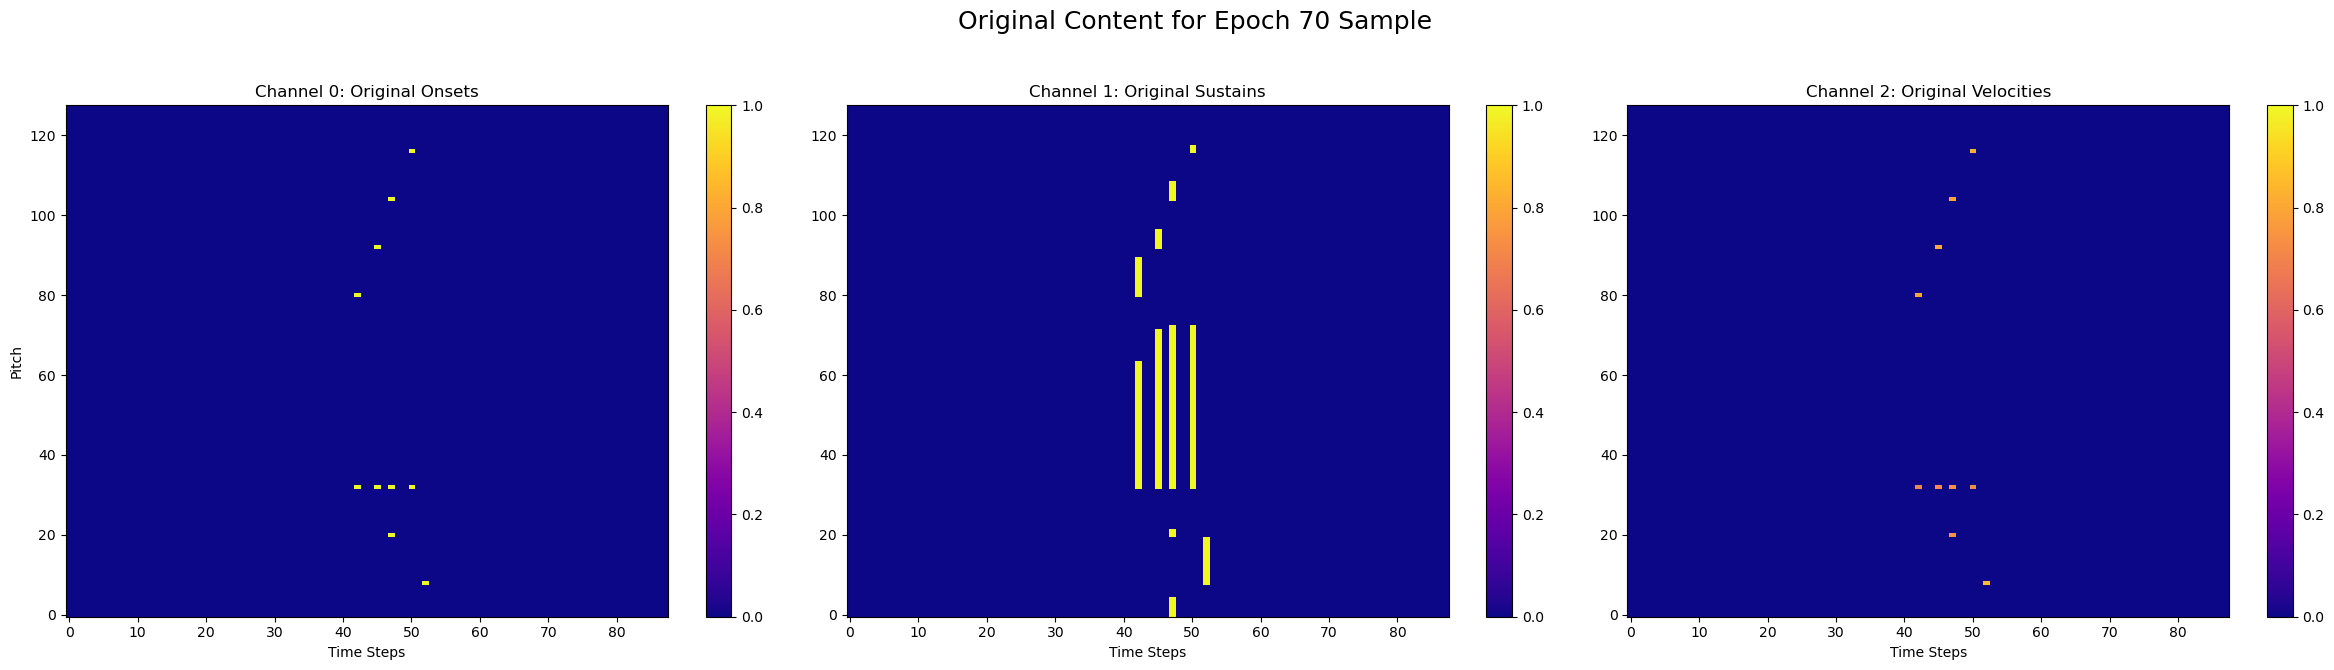

--- Visualizing: Generator Raw Output for Sample: sample_epoch_70_generated ---


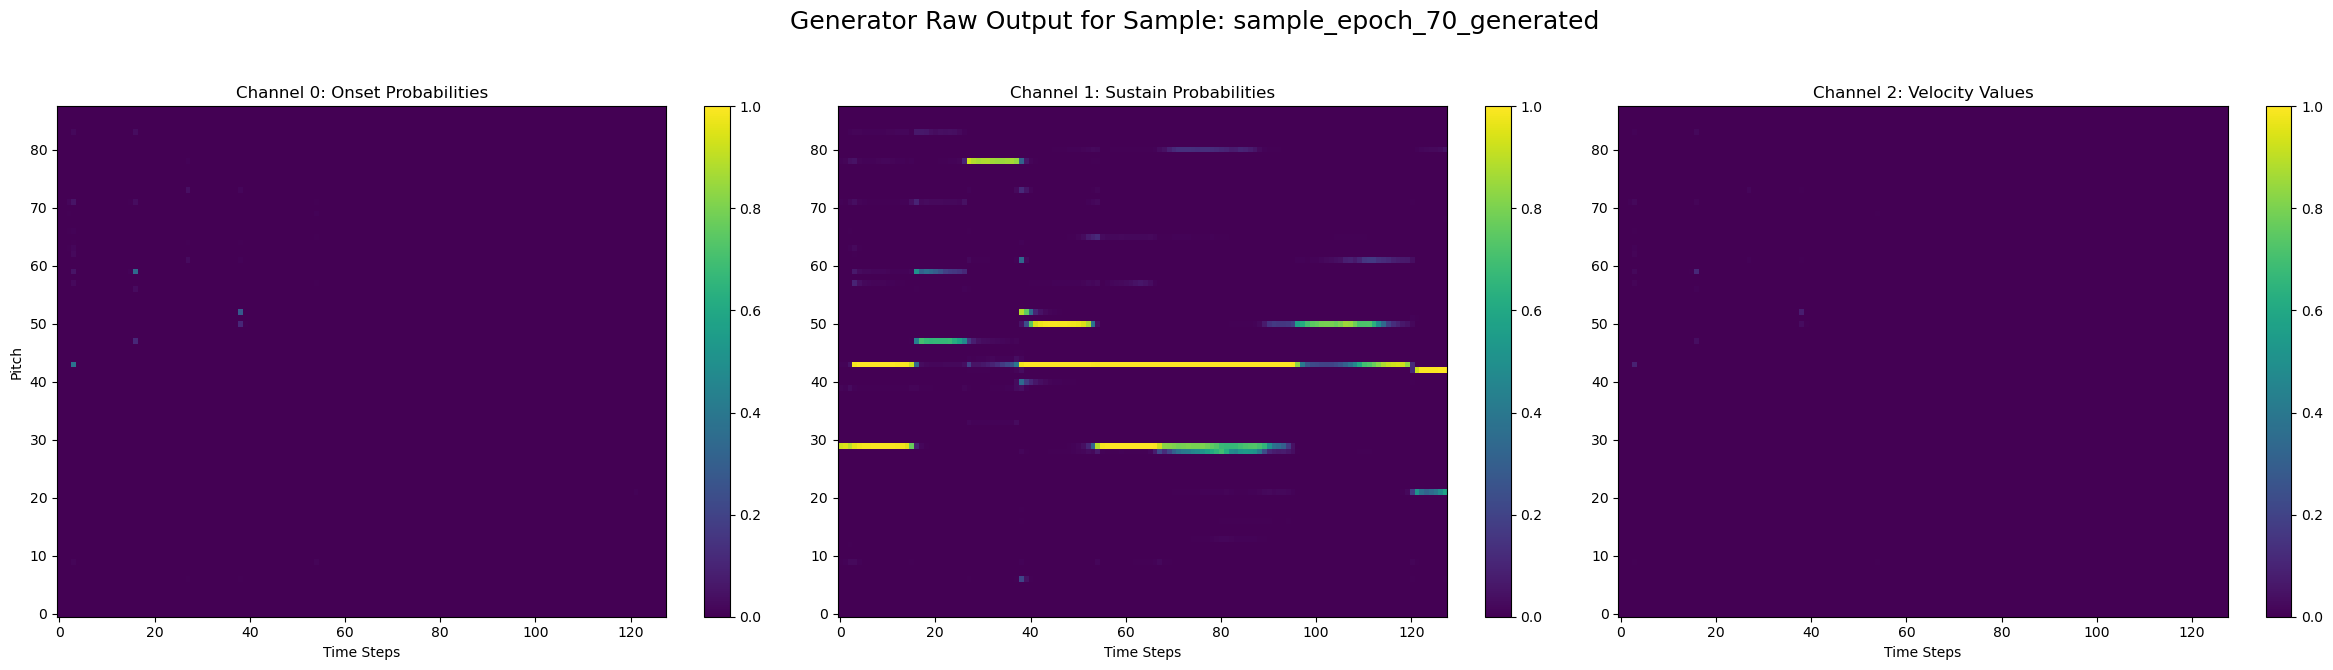

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_70.pth ---


PPO Epoch 71/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.657, R_genre(w=0.65)=0.719, R_recon(w=0.35)=0.542]


Epoch 71 Summary: Avg Reward: 0.5309 | Avg Genre: 0.5240, Avg Recon: 0.5435


PPO Epoch 72/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.632, R_genre(w=0.65)=0.653, R_recon(w=0.35)=0.594]


Epoch 72 Summary: Avg Reward: 0.5285 | Avg Genre: 0.5196, Avg Recon: 0.5451


PPO Epoch 73/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.618, R_genre(w=0.65)=0.589, R_recon(w=0.35)=0.670]


Epoch 73 Summary: Avg Reward: 0.5291 | Avg Genre: 0.5203, Avg Recon: 0.5455


PPO Epoch 74/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.615, R_genre(w=0.65)=0.648, R_recon(w=0.35)=0.553]


Epoch 74 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5255, Avg Recon: 0.5439


PPO Epoch 75/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.517, R_genre(w=0.65)=0.466, R_recon(w=0.35)=0.614]


Epoch 75 Summary: Avg Reward: 0.5317 | Avg Genre: 0.5243, Avg Recon: 0.5453

--- Saving sample for epoch 75 ---
--- Visualizing: Original Content for Epoch 75 Sample ---


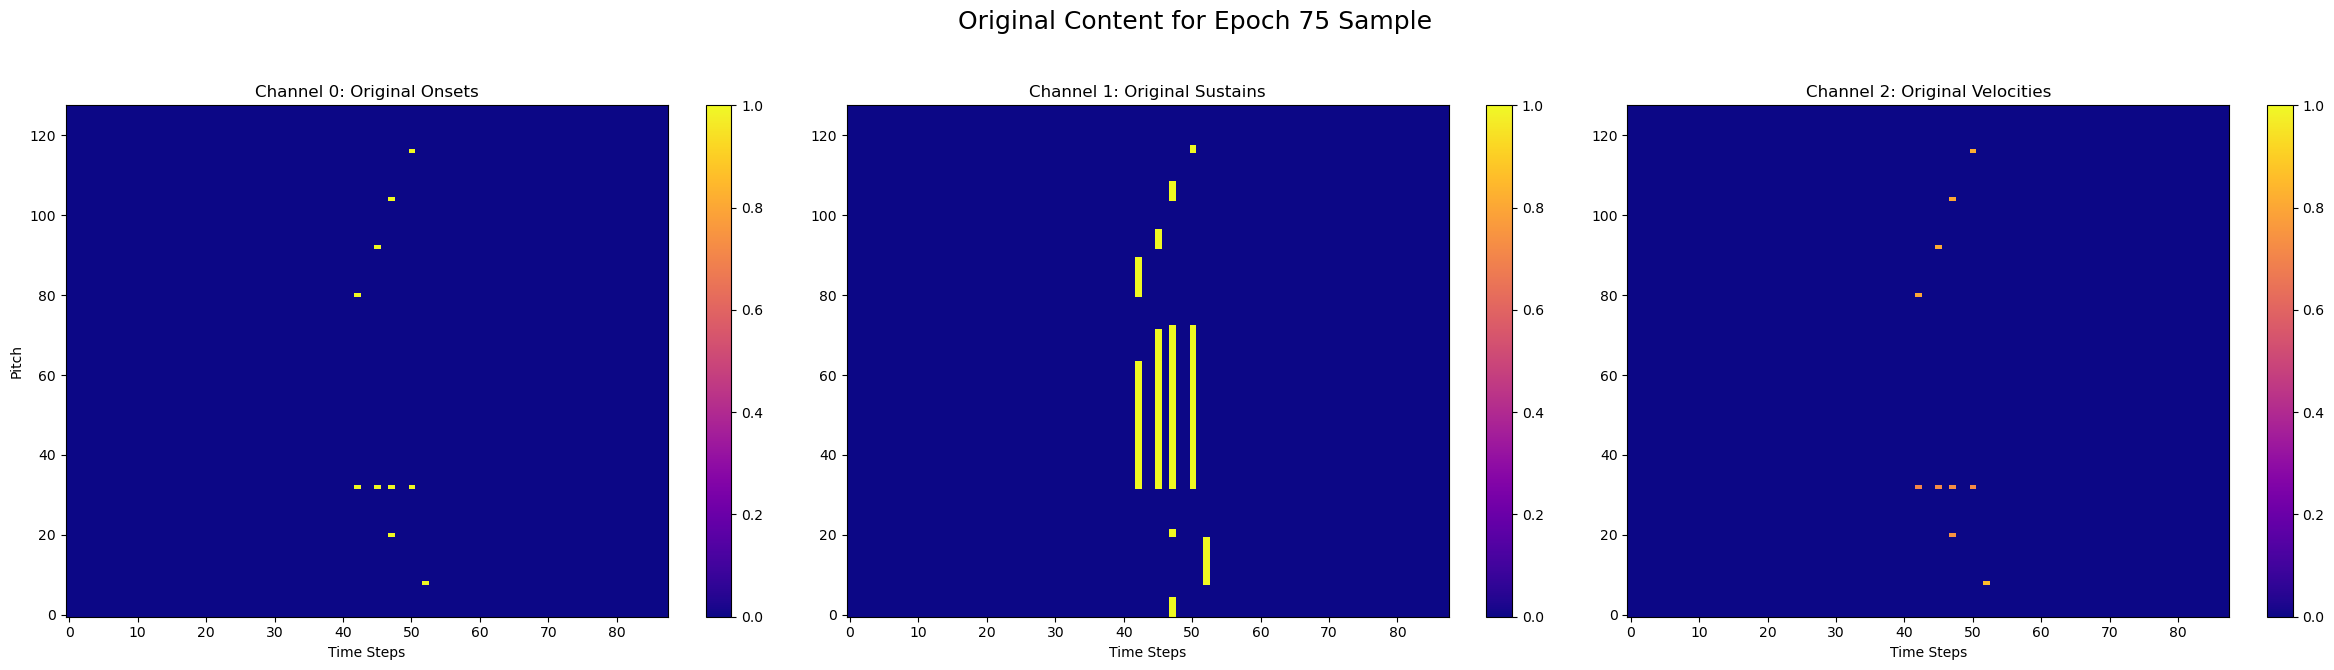

--- Visualizing: Generator Raw Output for Sample: sample_epoch_75_generated ---


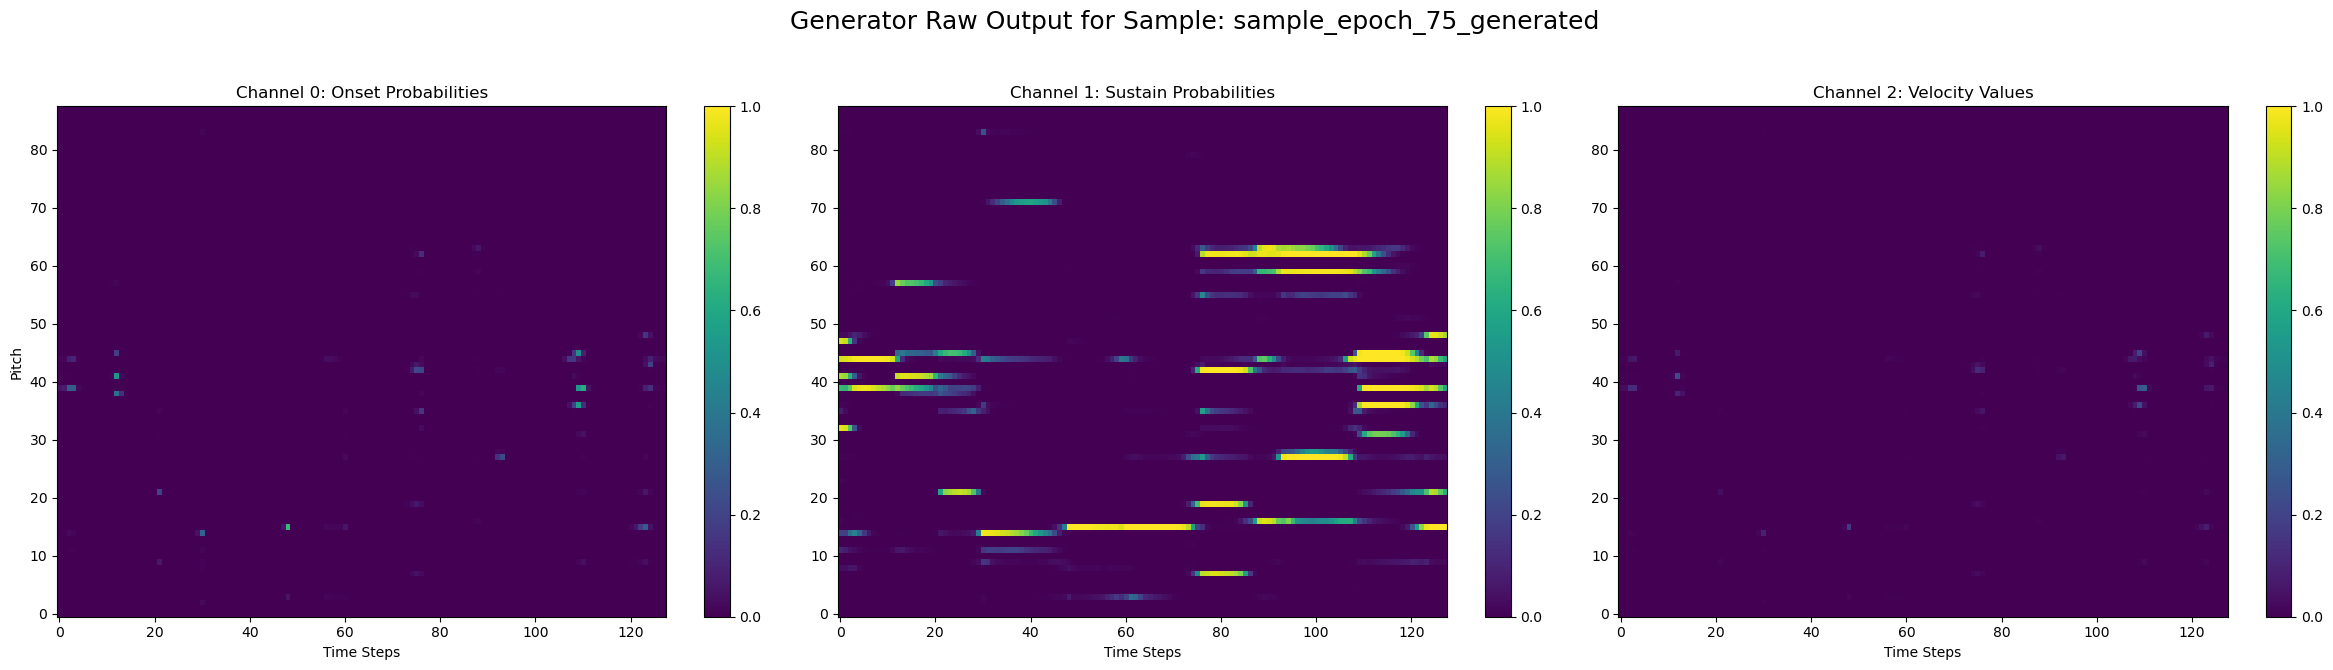

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_75.pth ---


PPO Epoch 76/100: 100%|██████████| 194/194 [01:34<00:00,  2.05it/s, R_total=0.549, R_genre(w=0.65)=0.551, R_recon(w=0.35)=0.545]


Epoch 76 Summary: Avg Reward: 0.5336 | Avg Genre: 0.5281, Avg Recon: 0.5437


PPO Epoch 77/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.406, R_genre(w=0.65)=0.349, R_recon(w=0.35)=0.511]


Epoch 77 Summary: Avg Reward: 0.5318 | Avg Genre: 0.5258, Avg Recon: 0.5428


PPO Epoch 78/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.542, R_genre(w=0.65)=0.482, R_recon(w=0.35)=0.655]


Epoch 78 Summary: Avg Reward: 0.5322 | Avg Genre: 0.5261, Avg Recon: 0.5435


PPO Epoch 79/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.391, R_genre(w=0.65)=0.305, R_recon(w=0.35)=0.551]


Epoch 79 Summary: Avg Reward: 0.5315 | Avg Genre: 0.5241, Avg Recon: 0.5452


PPO Epoch 80/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.676, R_genre(w=0.65)=0.670, R_recon(w=0.35)=0.687]


Epoch 80 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5257, Avg Recon: 0.5437

--- Saving sample for epoch 80 ---
--- Visualizing: Original Content for Epoch 80 Sample ---


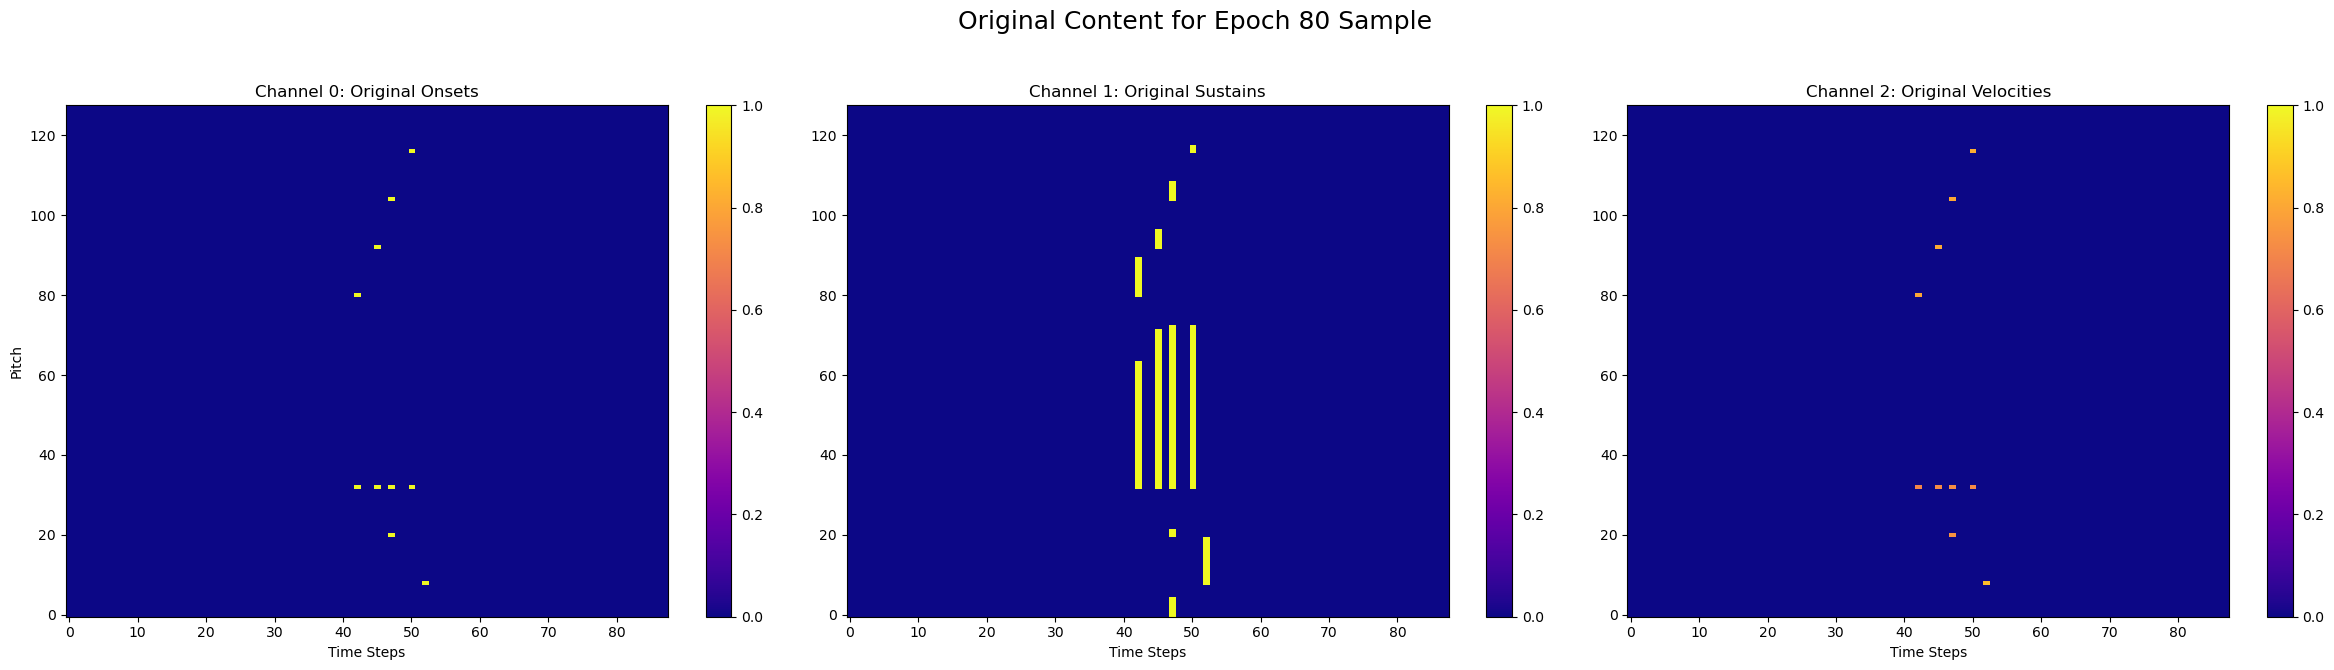

--- Visualizing: Generator Raw Output for Sample: sample_epoch_80_generated ---


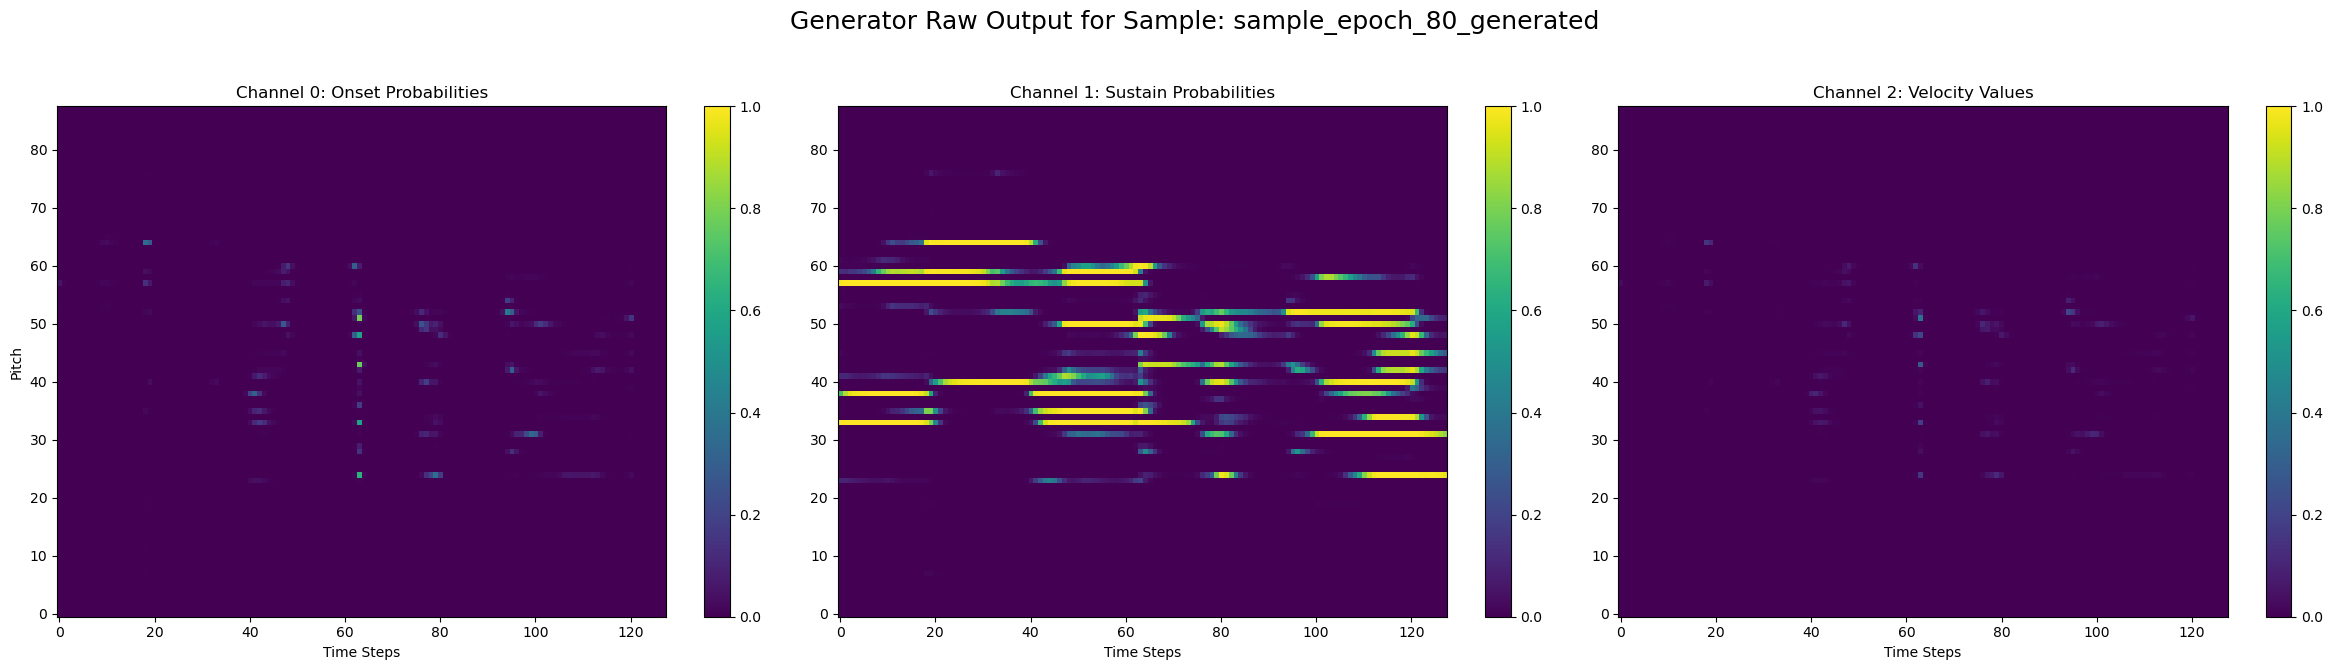

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_80.pth ---


PPO Epoch 81/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.520, R_genre(w=0.65)=0.528, R_recon(w=0.35)=0.505]


Epoch 81 Summary: Avg Reward: 0.5291 | Avg Genre: 0.5208, Avg Recon: 0.5445


PPO Epoch 82/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.627, R_genre(w=0.65)=0.680, R_recon(w=0.35)=0.529]


Epoch 82 Summary: Avg Reward: 0.5310 | Avg Genre: 0.5231, Avg Recon: 0.5458


PPO Epoch 83/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.552, R_genre(w=0.65)=0.511, R_recon(w=0.35)=0.628]


Epoch 83 Summary: Avg Reward: 0.5333 | Avg Genre: 0.5274, Avg Recon: 0.5441


PPO Epoch 84/100: 100%|██████████| 194/194 [01:34<00:00,  2.05it/s, R_total=0.510, R_genre(w=0.65)=0.440, R_recon(w=0.35)=0.639]


Epoch 84 Summary: Avg Reward: 0.5286 | Avg Genre: 0.5198, Avg Recon: 0.5451


PPO Epoch 85/100: 100%|██████████| 194/194 [01:34<00:00,  2.05it/s, R_total=0.500, R_genre(w=0.65)=0.524, R_recon(w=0.35)=0.456]


Epoch 85 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5249, Avg Recon: 0.5451

--- Saving sample for epoch 85 ---
--- Visualizing: Original Content for Epoch 85 Sample ---


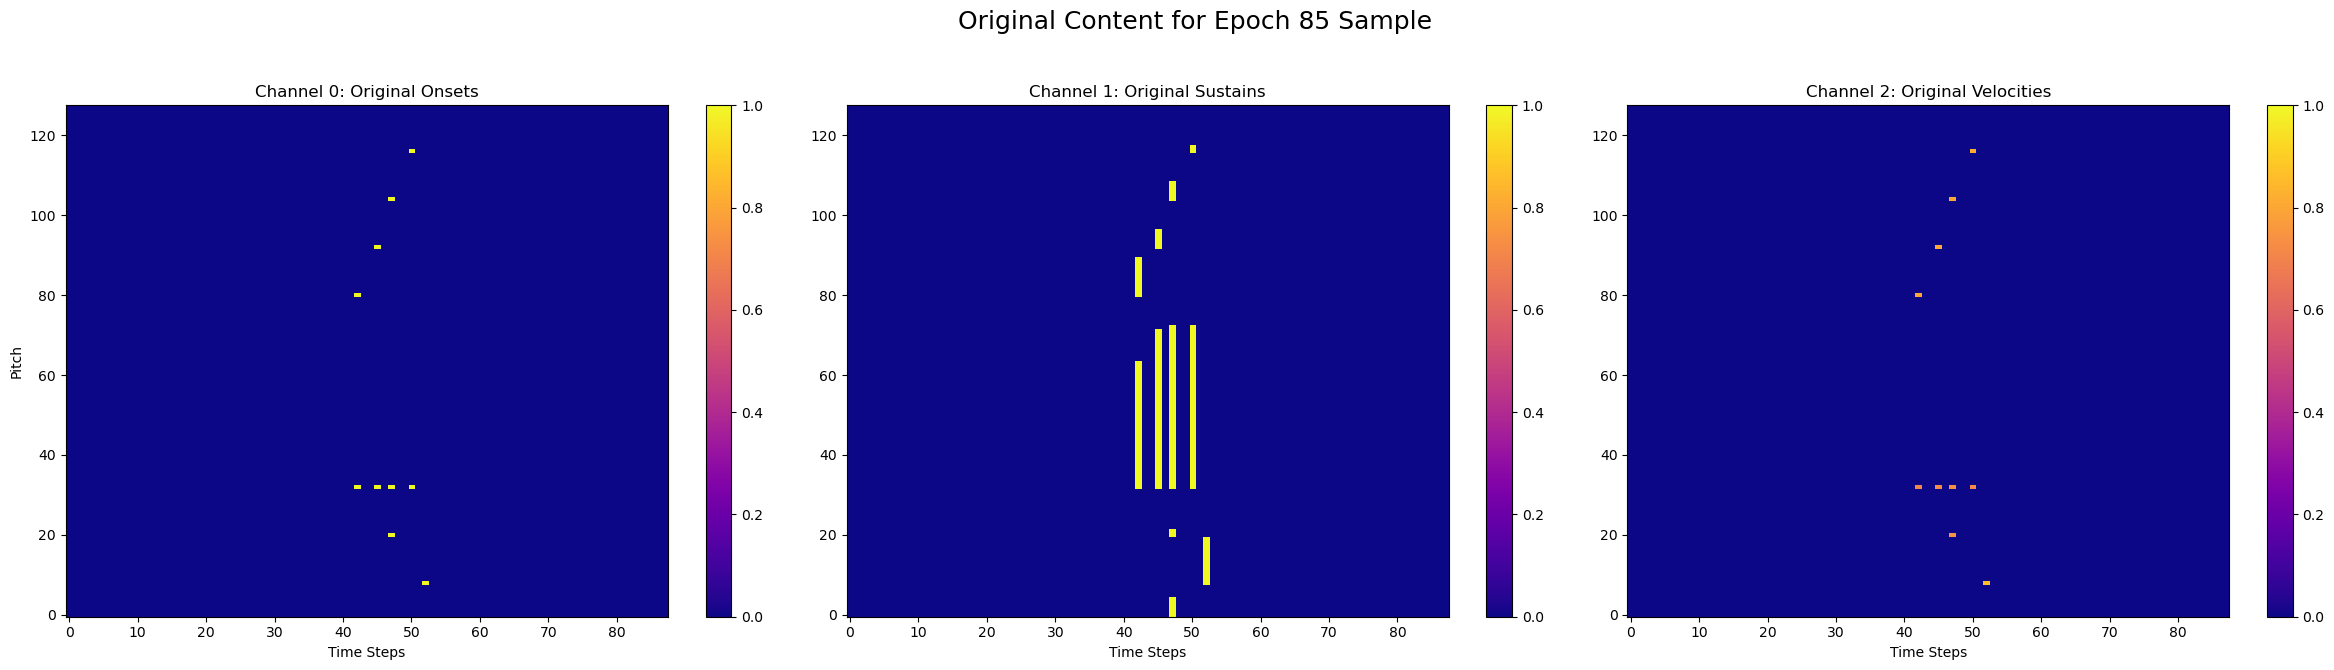

--- Visualizing: Generator Raw Output for Sample: sample_epoch_85_generated ---


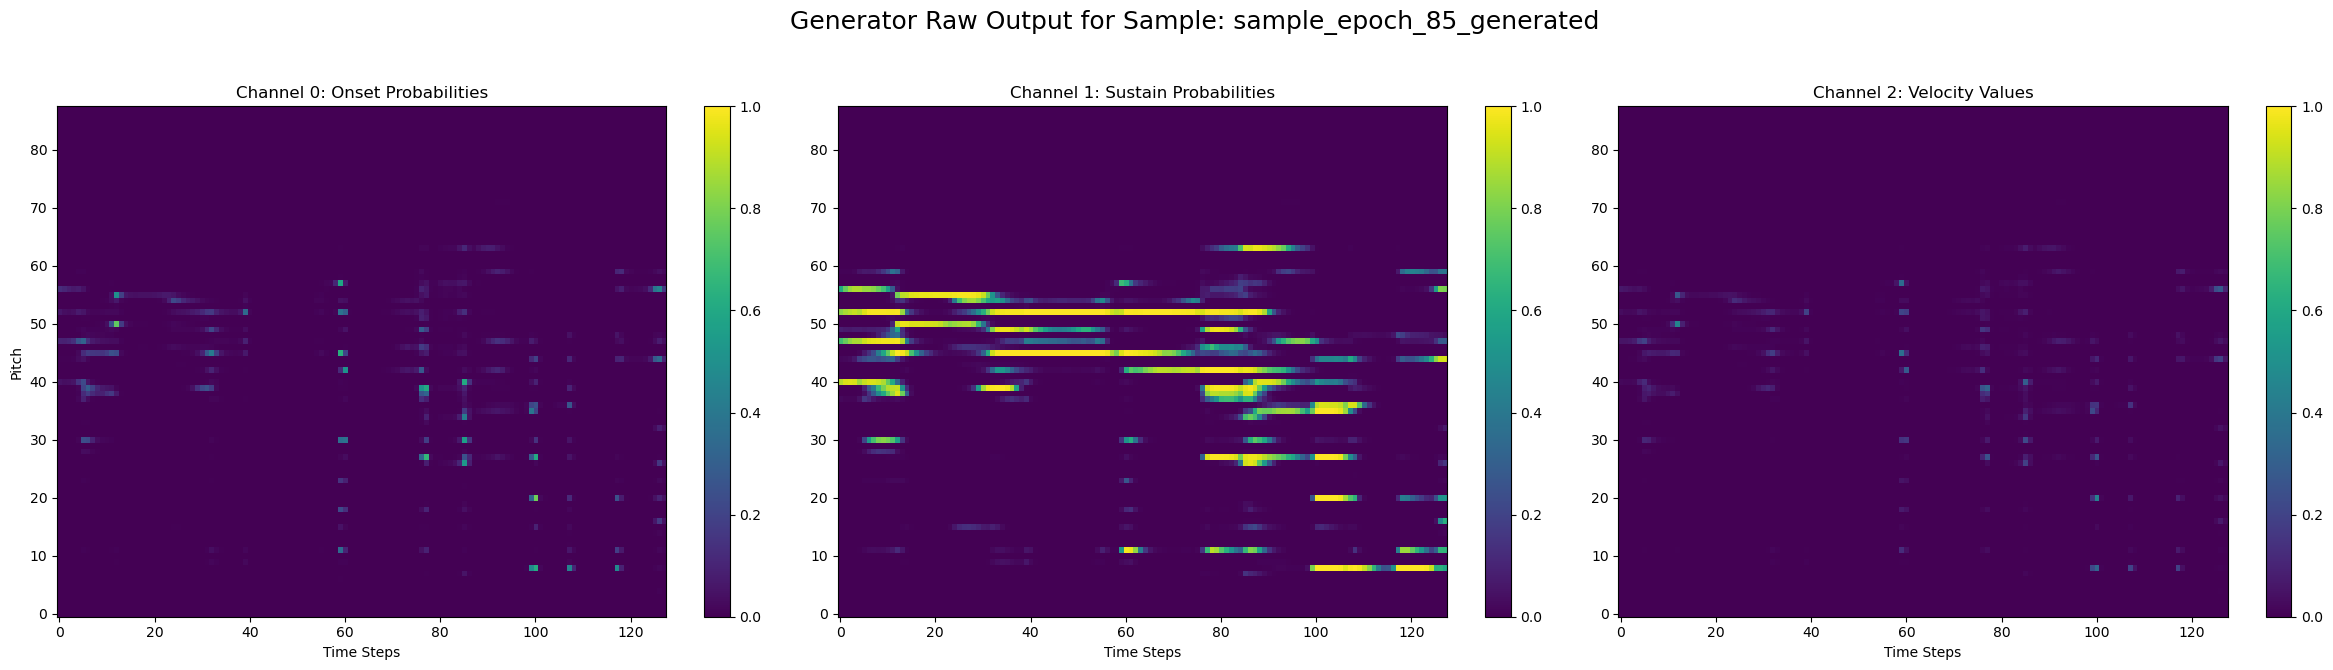

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_85.pth ---


PPO Epoch 86/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.413, R_genre(w=0.65)=0.435, R_recon(w=0.35)=0.371]


Epoch 86 Summary: Avg Reward: 0.5286 | Avg Genre: 0.5208, Avg Recon: 0.5432


PPO Epoch 87/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.493, R_genre(w=0.65)=0.486, R_recon(w=0.35)=0.506]


Epoch 87 Summary: Avg Reward: 0.5295 | Avg Genre: 0.5213, Avg Recon: 0.5449


PPO Epoch 88/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.461, R_genre(w=0.65)=0.472, R_recon(w=0.35)=0.441]


Epoch 88 Summary: Avg Reward: 0.5332 | Avg Genre: 0.5266, Avg Recon: 0.5454


PPO Epoch 89/100: 100%|██████████| 194/194 [01:34<00:00,  2.05it/s, R_total=0.422, R_genre(w=0.65)=0.367, R_recon(w=0.35)=0.525]


Epoch 89 Summary: Avg Reward: 0.5314 | Avg Genre: 0.5240, Avg Recon: 0.5452


PPO Epoch 90/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.524, R_genre(w=0.65)=0.547, R_recon(w=0.35)=0.482]


Epoch 90 Summary: Avg Reward: 0.5314 | Avg Genre: 0.5237, Avg Recon: 0.5457

--- Saving sample for epoch 90 ---
--- Visualizing: Original Content for Epoch 90 Sample ---


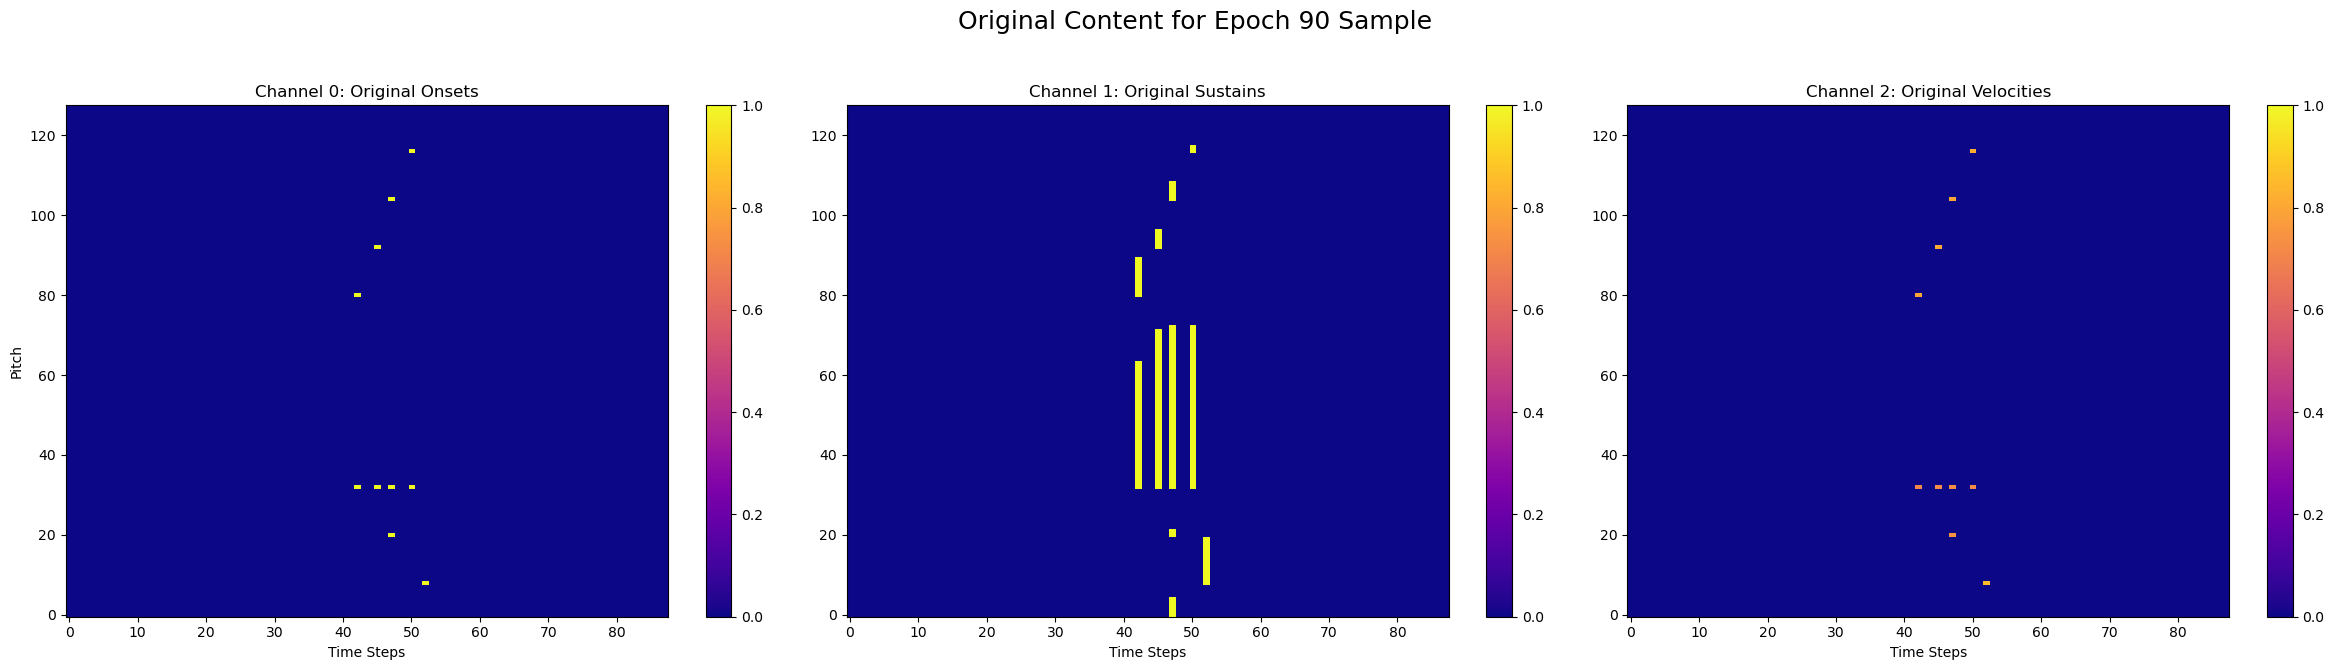

--- Visualizing: Generator Raw Output for Sample: sample_epoch_90_generated ---


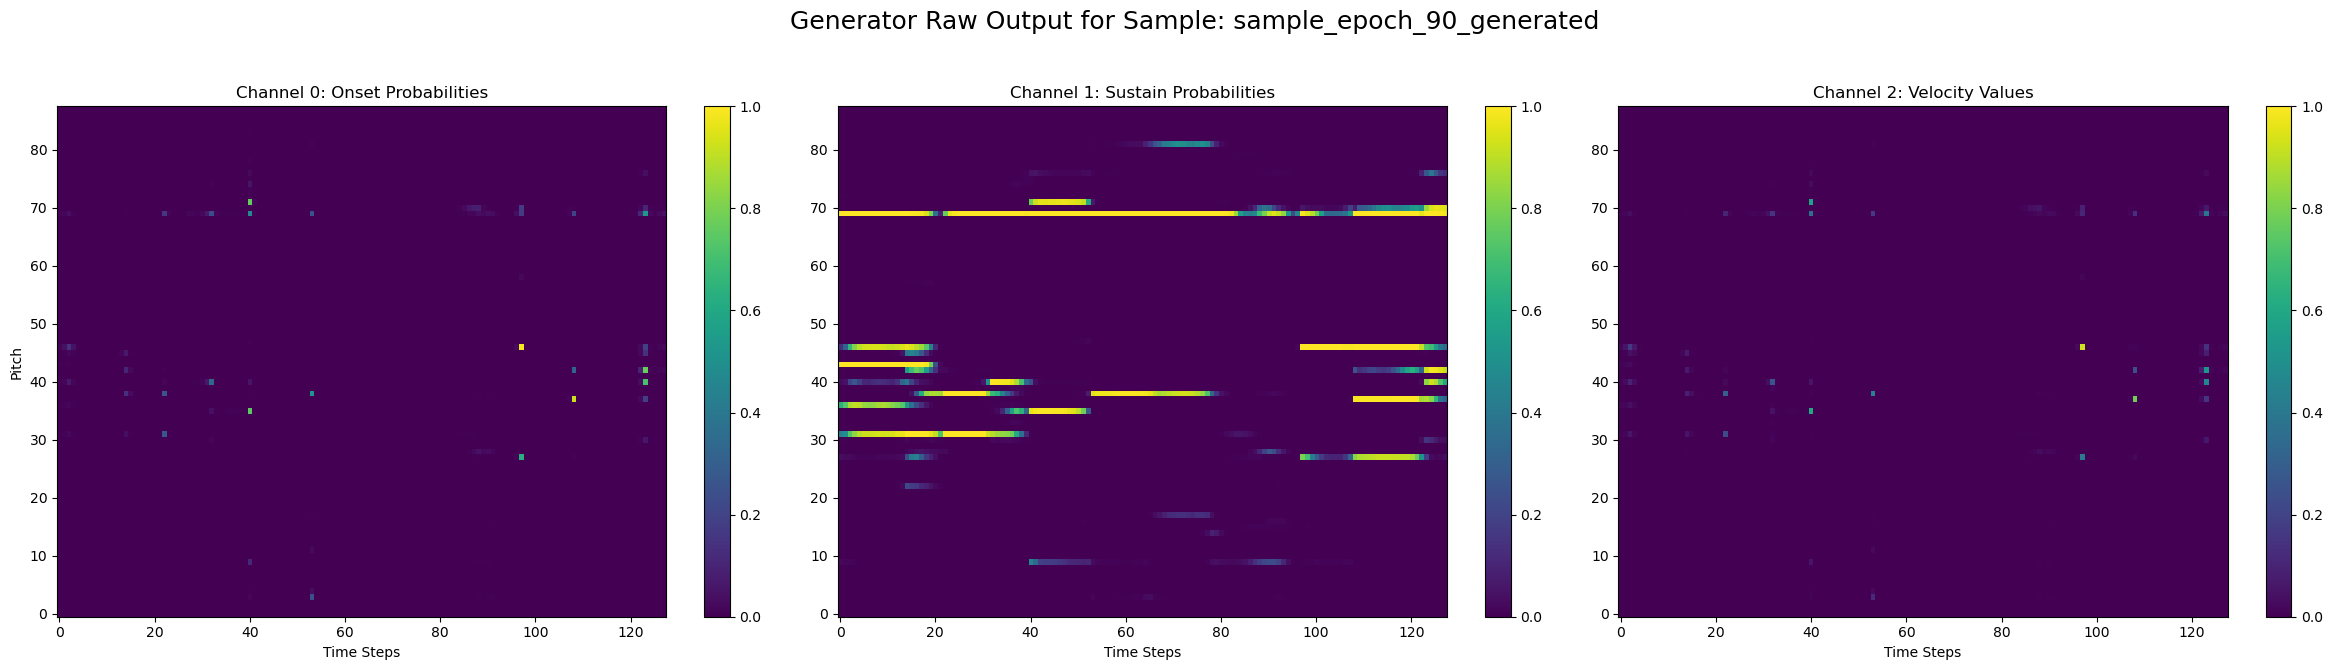

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_90.pth ---


PPO Epoch 91/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.645, R_genre(w=0.65)=0.654, R_recon(w=0.35)=0.629]


Epoch 91 Summary: Avg Reward: 0.5302 | Avg Genre: 0.5231, Avg Recon: 0.5435


PPO Epoch 92/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.441, R_genre(w=0.65)=0.424, R_recon(w=0.35)=0.471]


Epoch 92 Summary: Avg Reward: 0.5304 | Avg Genre: 0.5234, Avg Recon: 0.5435


PPO Epoch 93/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.382, R_genre(w=0.65)=0.234, R_recon(w=0.35)=0.659]


Epoch 93 Summary: Avg Reward: 0.5280 | Avg Genre: 0.5188, Avg Recon: 0.5450


PPO Epoch 94/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.471, R_genre(w=0.65)=0.482, R_recon(w=0.35)=0.449]


Epoch 94 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5250, Avg Recon: 0.5450


PPO Epoch 95/100: 100%|██████████| 194/194 [01:33<00:00,  2.06it/s, R_total=0.421, R_genre(w=0.65)=0.272, R_recon(w=0.35)=0.699]


Epoch 95 Summary: Avg Reward: 0.5242 | Avg Genre: 0.5135, Avg Recon: 0.5441

--- Saving sample for epoch 95 ---
--- Visualizing: Original Content for Epoch 95 Sample ---


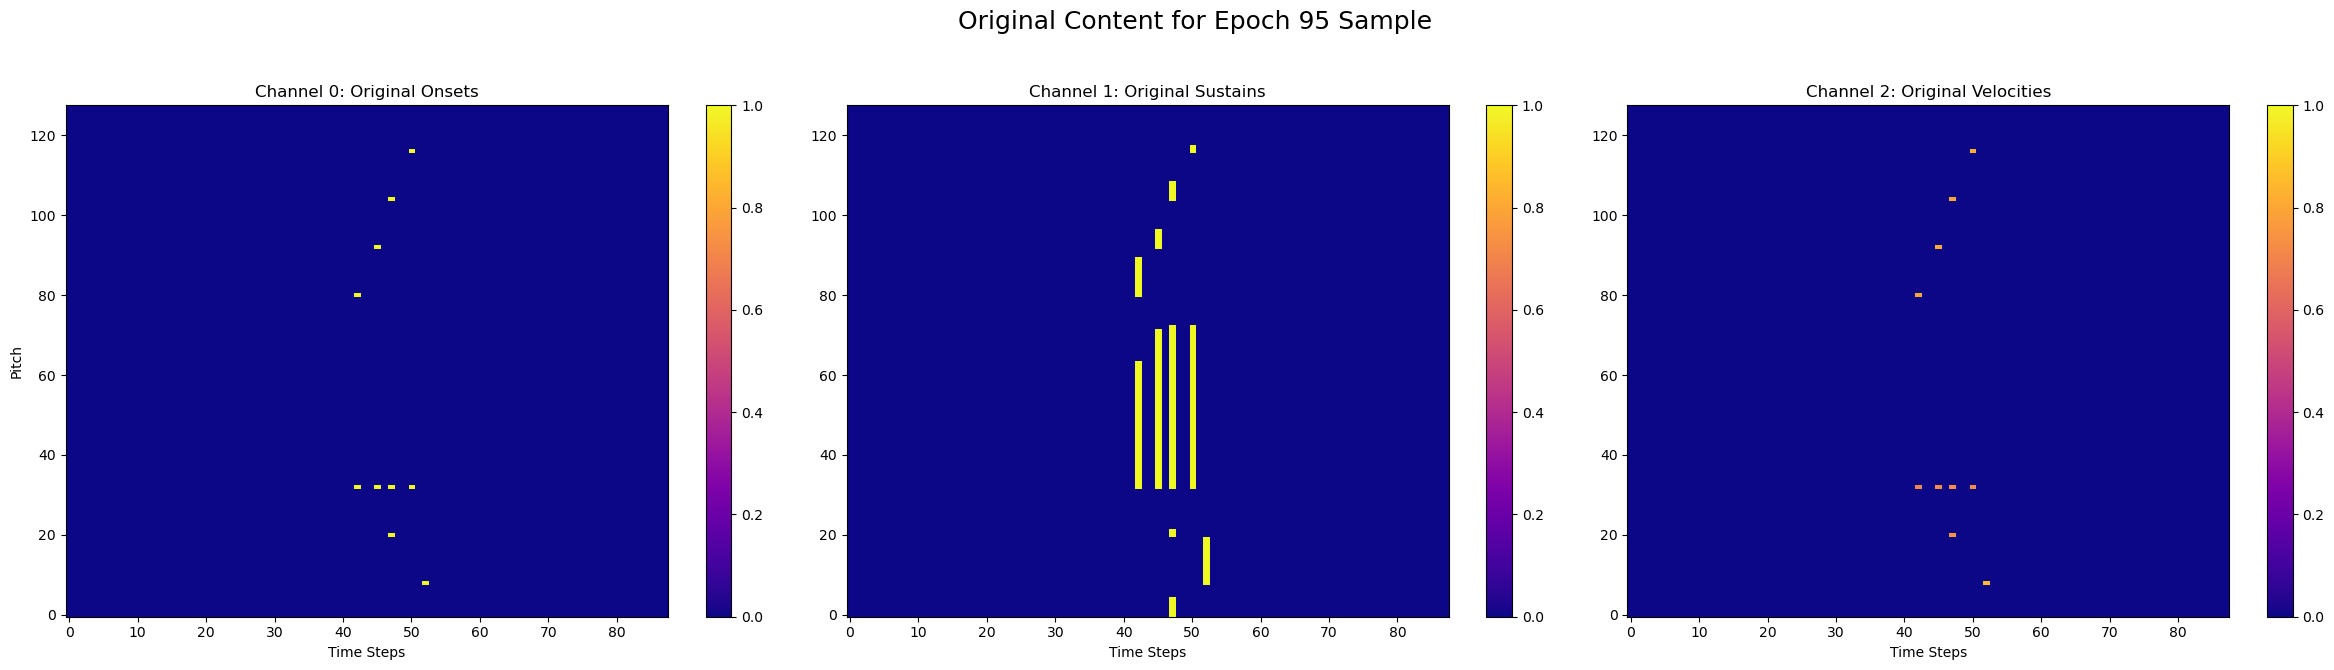

--- Visualizing: Generator Raw Output for Sample: sample_epoch_95_generated ---


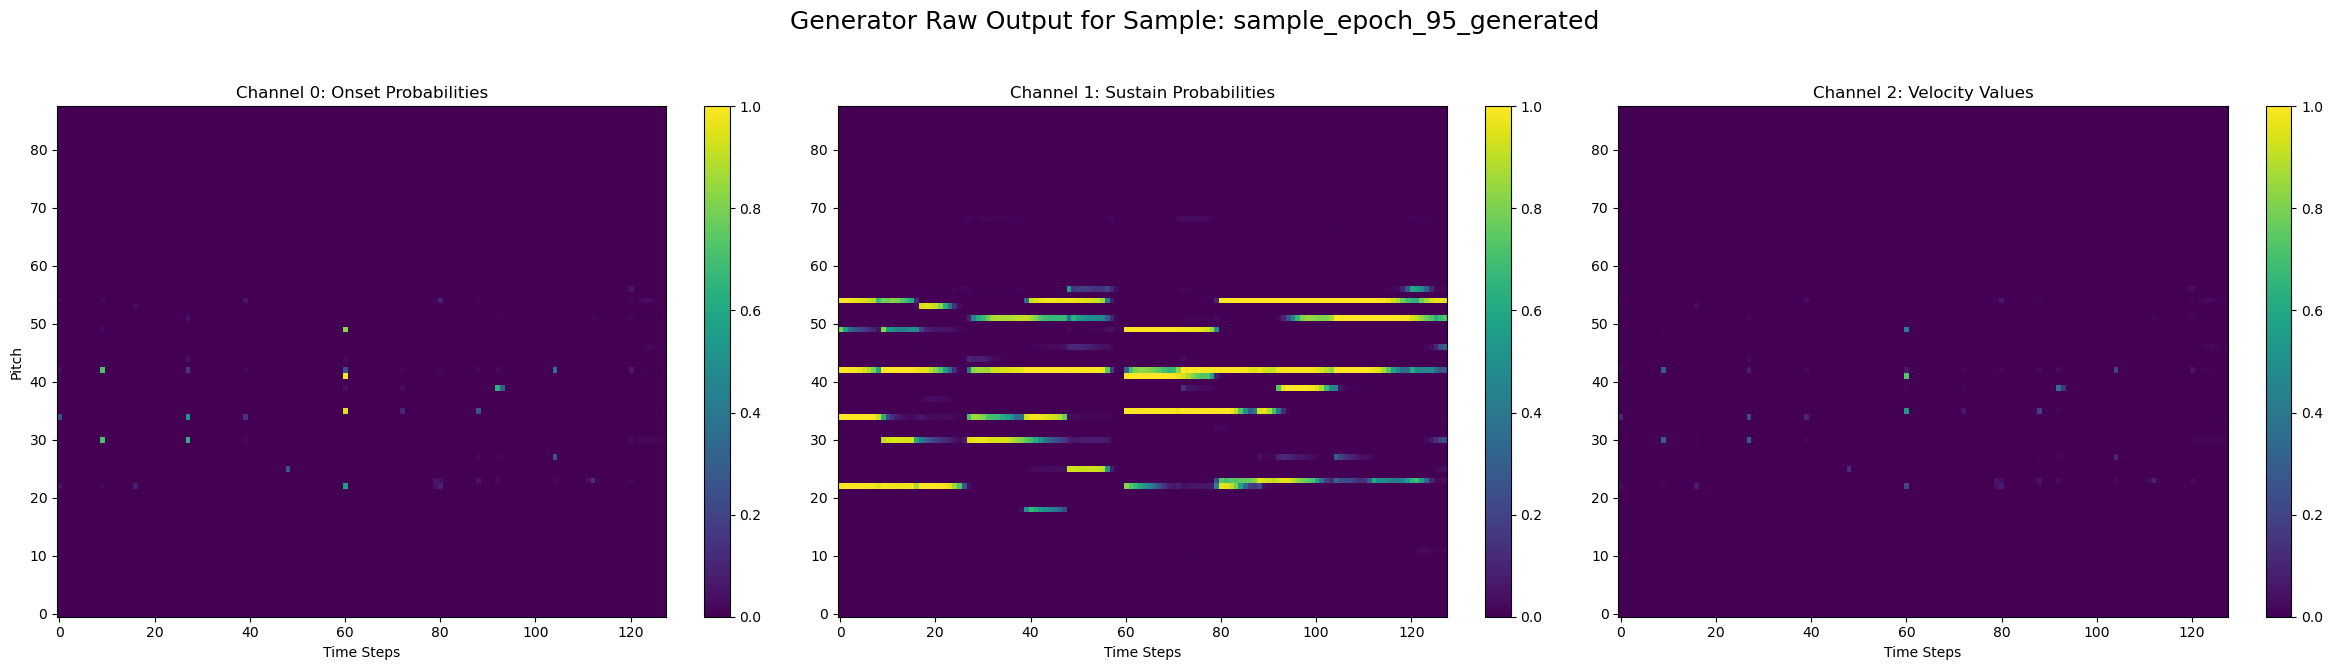

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_95.pth ---


PPO Epoch 96/100: 100%|██████████| 194/194 [01:34<00:00,  2.06it/s, R_total=0.514, R_genre(w=0.65)=0.577, R_recon(w=0.35)=0.395]


Epoch 96 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5250, Avg Recon: 0.5450


PPO Epoch 97/100: 100%|██████████| 194/194 [01:39<00:00,  1.96it/s, R_total=0.609, R_genre(w=0.65)=0.634, R_recon(w=0.35)=0.562]


Epoch 97 Summary: Avg Reward: 0.5300 | Avg Genre: 0.5229, Avg Recon: 0.5433


PPO Epoch 98/100: 100%|██████████| 194/194 [01:36<00:00,  2.00it/s, R_total=0.529, R_genre(w=0.65)=0.516, R_recon(w=0.35)=0.553]


Epoch 98 Summary: Avg Reward: 0.5338 | Avg Genre: 0.5275, Avg Recon: 0.5455


PPO Epoch 99/100: 100%|██████████| 194/194 [01:34<00:00,  2.04it/s, R_total=0.369, R_genre(w=0.65)=0.300, R_recon(w=0.35)=0.495]


Epoch 99 Summary: Avg Reward: 0.5311 | Avg Genre: 0.5245, Avg Recon: 0.5433


PPO Epoch 100/100: 100%|██████████| 194/194 [01:35<00:00,  2.03it/s, R_total=0.501, R_genre(w=0.65)=0.427, R_recon(w=0.35)=0.639]


Epoch 100 Summary: Avg Reward: 0.5320 | Avg Genre: 0.5250, Avg Recon: 0.5451

--- Saving sample for epoch 100 ---
--- Visualizing: Original Content for Epoch 100 Sample ---


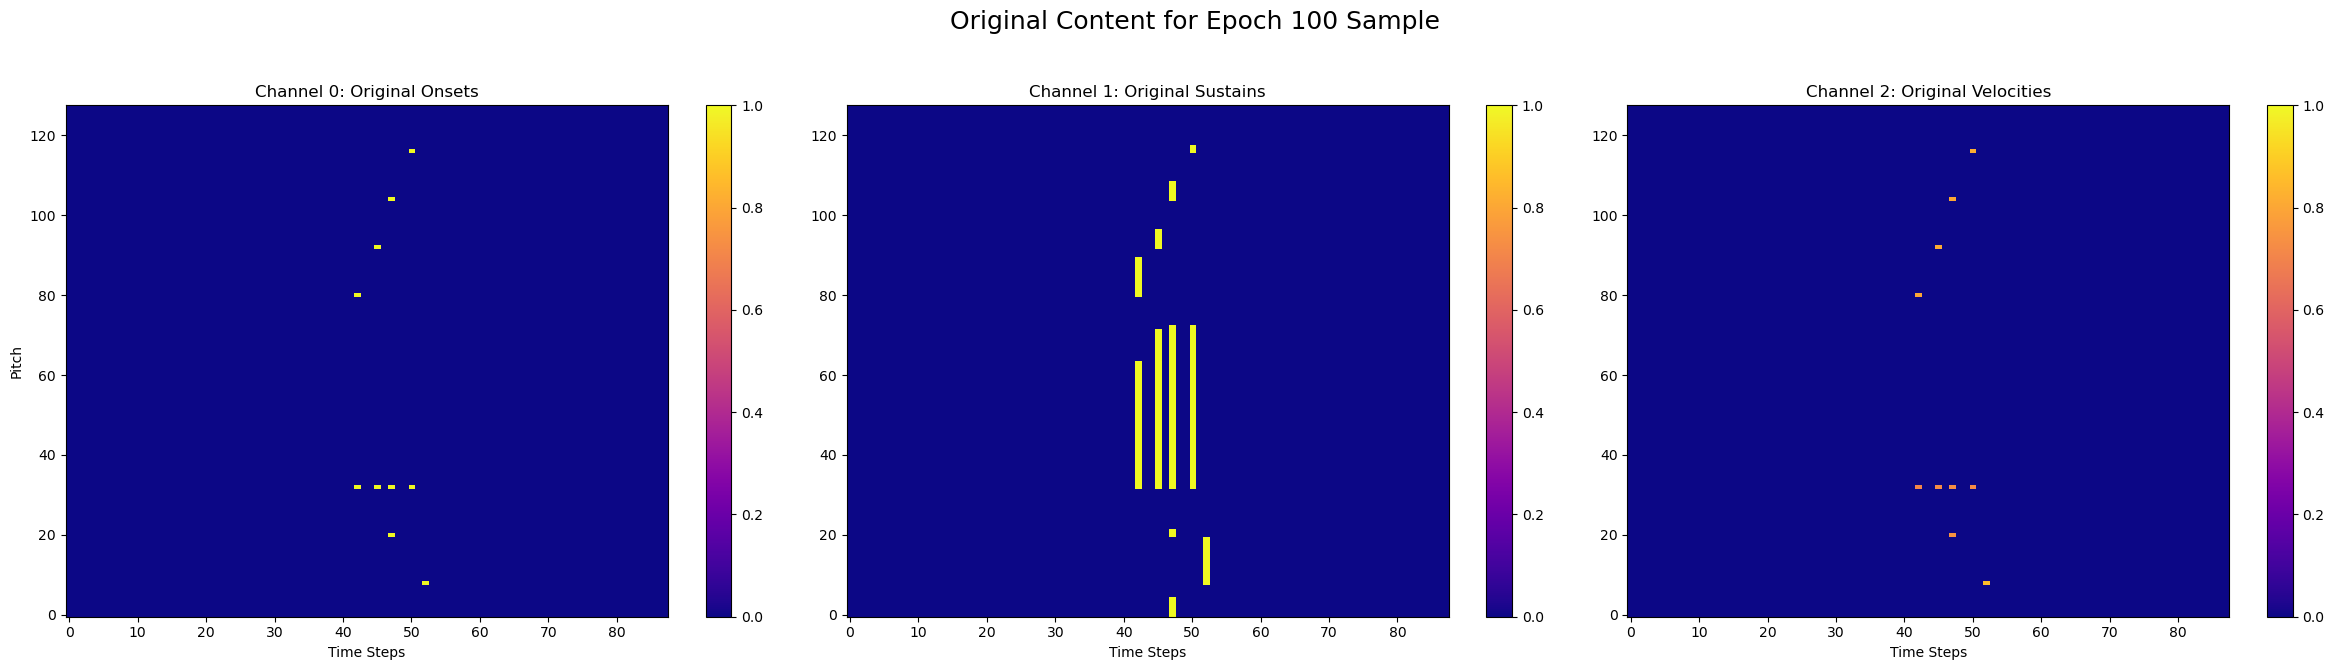

--- Visualizing: Generator Raw Output for Sample: sample_epoch_100_generated ---


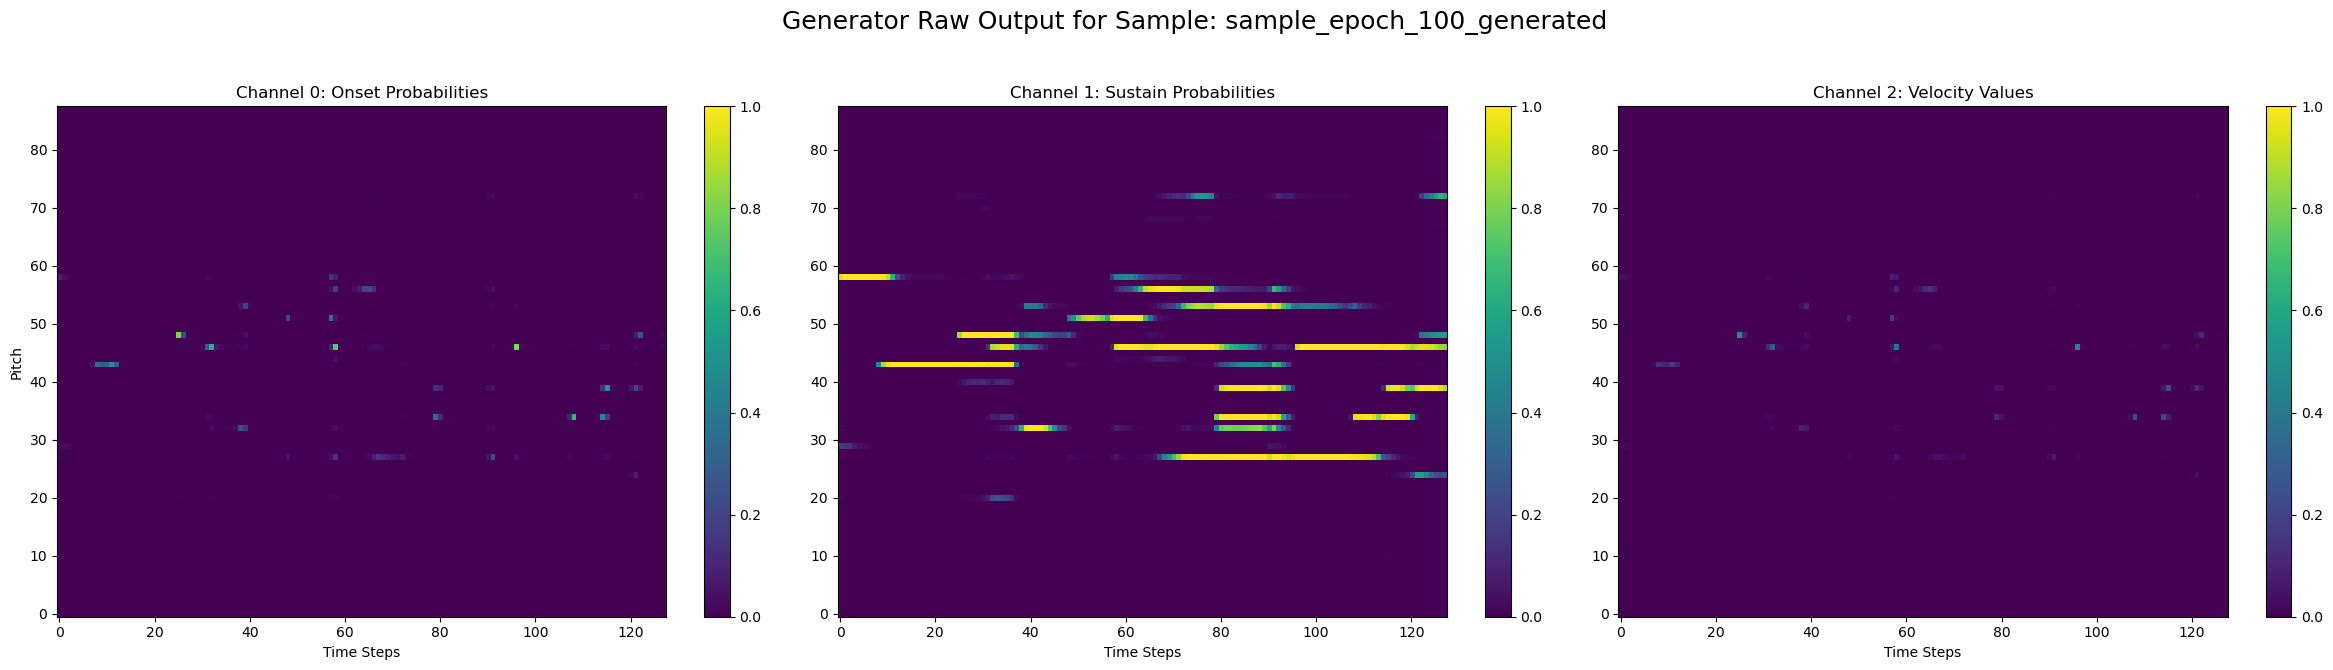

--- Saving periodic checkpoint to C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_BCE\ppo_tuned_VAE_epoch_100.pth ---

--- PPO Training Complete ---

--- Generating Training Plots ---


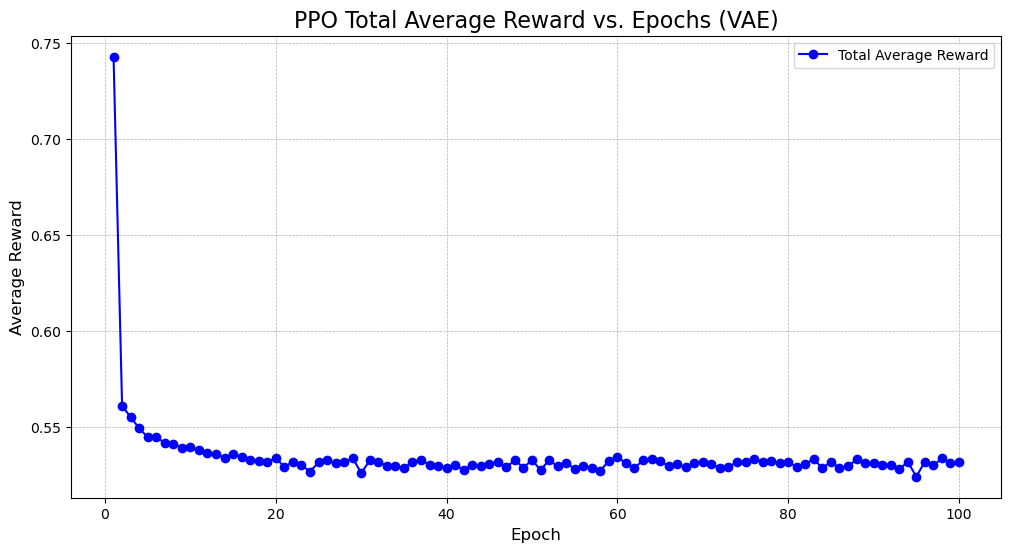

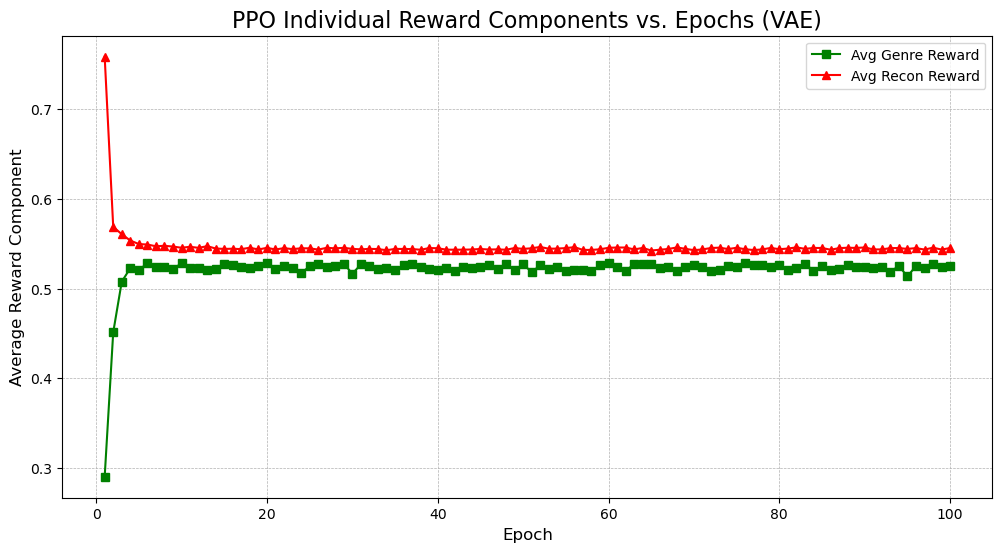

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# --- Local File Imports ---
from DataLoading import MultiChannelEagerDataset
from JazzClassifier import JazzClassifierCNN
from TransformerVAE import TransformerVAE
from Utils import plot_generator_output_matrices, reconstruct_and_save_midi, plot_original_content_matrices

# --- Environment Setup ---
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.empty_cache()

print(f"--- Running with fixed random seed: {SEED} ---")

# ==============================================================================
# SECTION 2: PPO-SPECIFIC CONFIGURATION
# ==============================================================================
class PPOConfig:
    def __init__(self):
        self.MODEL_TYPE = 'VAE'
        
        # --- Core Paths ---
        self.BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
        self.MASTER_LABEL_MAP_FILE = os.path.join(self.BASE_MATRIX_DIR, "master_label_map.json")
        self.PPO_SAVE_DIR = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", f"PPO_Tuned_{self.MODEL_TYPE}_BCE")
        self.SAMPLES_DIR = os.path.join(self.PPO_SAVE_DIR, "samples")
        self.PRETRAINED_CLASSIFIER_PATH = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced.pth"
        self.USED_NON_JAZZ_FOR_PPO_CSV = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", "used_non_jazz_for_ppo_training.csv")
        self.PRETRAINED_POLICY_PATH = r"C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_75.pth"
        self.BEST_MODEL_SAVE_PATH = os.path.join(self.PPO_SAVE_DIR, f"ppo_tuned_{self.MODEL_TYPE}_best.pth")

        # --- Data & Training Parameters ---
        self.NUM_NON_JAZZ_FILES_FOR_PPO = 100
        self.BATCH_SIZE = 32
        self.NUM_WORKERS = 0
        self.PPO_EPOCHS = 100
        self.SAVE_SAMPLE_EVERY_N_EPOCHS = 5
        self.SAVE_MODEL_EVERY_N_EPOCHS = 5
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.CHANNELS = 3

        # --- PPO Hyperparameters ---
        self.PPO_UPDATE_EPOCHS = 4
        self.LR_ACTOR =2e-6
        self.LR_CRITIC = 3e-5
        self.GAMMA = 0.99
        self.EPS_CLIP = 0.2
        self.BETA = 4

        # --- Curriculum & Reward Parameters ---
        self.REWARD_WARMUP_EPOCHS = 20 # Epochs to gradually introduce genre reward
        self.TARGET_REWARD_WEIGHT_GENRE = 0.65
        
        # --- ARCHITECTURAL HYPERPARAMETERS FOR Transformer-VAE ---
        self.PITCHES = 88
        self.TIMESTEPS = 128
        self.LATENT_DIM = 256
        self.EMBED_DIM = 512
        self.NHEAD = 8
        self.NUM_ENCODER_LAYERS = 6
        self.NUM_DECODER_LAYERS = 6
        self.DROPOUT = 0.1
        
        os.makedirs(self.PPO_SAVE_DIR, exist_ok=True)
        os.makedirs(self.SAMPLES_DIR, exist_ok=True)

# ==============================================================================
# SECTION 3: DATA HANDLING
# ==============================================================================
class PPODataHandler:
    def __init__(self, config):
        self.config = config

    def get_unseen_non_jazz_dataloader(self):
        # This function remains the same.
        if os.path.exists(self.config.USED_NON_JAZZ_FOR_PPO_CSV):
            print(f"Found existing PPO file list at: {self.config.USED_NON_JAZZ_FOR_PPO_CSV}")
            ppo_files_df = pd.read_csv(self.config.USED_NON_JAZZ_FOR_PPO_CSV)
            ppo_files_relative = ppo_files_df['filepath'].tolist()
        else:
            print("No existing PPO file list found. Creating a new one...")
            with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
                label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
            used_gan_files_path = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", "used_non_jazz_for_gan_training.csv")
            if not os.path.exists(used_gan_files_path):
                 raise FileNotFoundError(f"Could not find the list of GAN-used files at {used_gan_files_path}")
            used_gan_df = pd.read_csv(used_gan_files_path)
            used_gan_files = set(used_gan_df['filepath'])
            all_non_jazz_relative = {p for p, l in label_map.items() if l == 0}
            unseen_non_jazz_relative = list(all_non_jazz_relative - used_gan_files)
            if not unseen_non_jazz_relative:
                raise ValueError("No unseen non-jazz files are available for PPO training!")
            random.shuffle(unseen_non_jazz_relative)
            num_to_use = min(self.config.NUM_NON_JAZZ_FILES_FOR_PPO, len(unseen_non_jazz_relative))
            ppo_files_relative = unseen_non_jazz_relative[:num_to_use]
            pd.DataFrame(ppo_files_relative, columns=['filepath']).to_csv(self.config.USED_NON_JAZZ_FOR_PPO_CSV, index=False)
            print(f"Created and saved a PPO dataset of {len(ppo_files_relative)} unseen non-jazz files.")

        ppo_full_paths = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in ppo_files_relative]
        dataset = MultiChannelEagerDataset(ppo_full_paths, [0]*len(ppo_full_paths), dataset_name="PPO Non-Jazz Content")
        if len(dataset) == 0:
            raise ValueError("The created PPO dataset has 0 valid segments.")
        dataloader = DataLoader(dataset, batch_size=self.config.BATCH_SIZE, shuffle=True, num_workers=self.config.NUM_WORKERS)
        return dataloader

# ==============================================================================
# SECTION 4: REWARD EVALUATOR
# ==============================================================================
class StyleTransferEvaluator:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        
        self.classifier = JazzClassifierCNN(in_channels=4).to(self.device)
        self.classifier.load_state_dict(torch.load(config.PRETRAINED_CLASSIFIER_PATH, map_location=self.device))
        self.classifier.eval()
        print("Successfully loaded frozen 4-channel Jazz Classifier.")

    def _pad_to_4_channels(self, tensor_3_channels):
        dummy_channel = torch.zeros_like(tensor_3_channels[:, 0:1, :, :])
        return torch.cat([tensor_3_channels, dummy_channel], dim=1)
    
    def compute_reconstruction_reward(self, original_batch, generated_batch):
        """
        [MODIFIED] Calculates a stricter, multiplicative reconstruction reward.
        The model must perform well on ALL three channels (onset, sustain, velocity)
        to receive a high reward.
        """
        original_onsets = original_batch[:, 0, :, :]
        generated_onsets = generated_batch[:, 0, :, :]
        
        original_sustains = original_batch[:, 1, :, :]
        generated_sustains = generated_batch[:, 1, :, :]
        
        original_velocities = original_batch[:, 2, :, :]
        generated_velocities = generated_batch[:, 2, :, :]

        # Calculate BCE loss for each channel individually
        bce_onset = F.binary_cross_entropy(generated_onsets, original_onsets, reduction='none').mean(dim=[1,2])
        bce_sustain = F.binary_cross_entropy(generated_sustains, original_sustains, reduction='none').mean(dim=[1,2])
        bce_velocity = F.binary_cross_entropy(generated_velocities, original_velocities, reduction='none').mean(dim=[1,2])

        # Convert each loss to a similarity score: reward = exp(-loss)
        reward_onset = torch.exp(-bce_onset)
        reward_sustain = torch.exp(-bce_sustain)
        reward_velocity = torch.exp(-bce_velocity)
        
        # Multiply the individual similarity scores to get the final reward
        # This ensures a high reward only if all components are similar.
        multiplicative_recon_reward = reward_onset * reward_sustain * reward_velocity
        
        return multiplicative_recon_reward

    def compute_rewards(self, original_content, generated_style, current_epoch):
        with torch.no_grad():
            # --- 1. Calculate the potential rewards ---
            binary_onsets = (generated_style[:, 0:1, :, :] > 0.5).float()
            binary_sustains = (generated_style[:, 1:2, :, :] > 0.5).float()
            velocity_probs = generated_style[:, 2:3, :, :]
            classifier_input_style = torch.cat([binary_onsets, binary_sustains, velocity_probs], dim=1)
            generated_style_4_chan = self._pad_to_4_channels(classifier_input_style)
            
            genre_reward = torch.sigmoid(self.classifier(generated_style_4_chan)).squeeze(-1)
            recon_reward = self.compute_reconstruction_reward(original_content, generated_style)

            # --- 2. Apply Curriculum Logic for Reward Weights ---
            if current_epoch <= self.config.REWARD_WARMUP_EPOCHS:
                progress = current_epoch / self.config.REWARD_WARMUP_EPOCHS
                w_genre = self.config.TARGET_REWARD_WEIGHT_GENRE * progress
            else:
                w_genre = self.config.TARGET_REWARD_WEIGHT_GENRE

            w_recon = 1.0 - w_genre

            # --- 3. Combine Rewards ---
            total_reward = (w_genre * genre_reward) + (w_recon * recon_reward)
            
            reward_weights = {'genre': w_genre, 'recon': w_recon}
            
            individual_rewards = {
                'genre': genre_reward,
                'recon': recon_reward
            }
            
        return total_reward, individual_rewards, reward_weights

# ==============================================================================
# SECTION 5: THE PPO AGENT AND CRITIC NETWORK
# ==============================================================================
class MlpCritic(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, mu): return self.net(mu)

class PPOAgent:
    def __init__(self, policy_network, critic_network, config):
        self.policy = policy_network
        self.critic = critic_network
        self.config = config
        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=config.LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=config.LR_CRITIC)
        self.mse_loss = nn.MSELoss()

    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward in reversed(memory['rewards']):
            discounted_reward = reward + (self.config.GAMMA * discounted_reward)
            rewards.insert(0, discounted_reward)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.config.DEVICE)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.cat(memory['states'], dim=0).detach().to(self.config.DEVICE)
        old_latent_z = torch.cat(memory['latent_z'], dim=0).detach().to(self.config.DEVICE)
        old_logprobs = torch.cat(memory['logprobs'], dim=0).detach().to(self.config.DEVICE)

        for _ in range(self.config.PPO_UPDATE_EPOCHS):
            logprobs, state_values, dist_entropy, mu, logvar = self.evaluate(old_states, old_latent_z)
            ratios = torch.exp(logprobs - old_logprobs)
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.config.EPS_CLIP, 1 + self.config.EPS_CLIP) * advantages
            
            kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
            policy_loss = -torch.min(surr1, surr2).mean() - 0.01 * dist_entropy.mean() + self.config.BETA * kld_loss
            value_loss = self.mse_loss(state_values, rewards)

            self.optimizer_policy.zero_grad()
            policy_loss.backward(retain_graph=True)
            self.optimizer_policy.step()

            self.optimizer_critic.zero_grad()
            value_loss.backward()
            self.optimizer_critic.step()

    def evaluate(self, state, action_z):
        mu, logvar = self.policy.encode(state)
        state_values = self.critic(mu.detach()).squeeze(-1)
        z_dist = Normal(mu, torch.exp(0.5 * logvar))
        action_logprobs = z_dist.log_prob(action_z).sum(dim=1)
        dist_entropy = z_dist.entropy().sum(dim=1)
        return action_logprobs, state_values, dist_entropy, mu, logvar

# ==============================================================================
# SECTION 6: THE PPO TRAINER CLASS
# ==============================================================================
class PPOTrainer:
    def __init__(self):
        print(f"--- INITIALIZING PPO TRAINER FOR: Transformer-VAE ---")
        self.config = PPOConfig()
        
        self.data_handler = PPODataHandler(self.config)
        self.content_loader = self.data_handler.get_unseen_non_jazz_dataloader()
        self.evaluator = StyleTransferEvaluator(self.config)
        self.device = self.config.DEVICE

        self.policy_net = TransformerVAE(self.config).to(self.config.DEVICE)
        checkpoint_path = self.config.PRETRAINED_POLICY_PATH
        checkpoint = torch.load(checkpoint_path, map_location=self.config.DEVICE)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.policy_net.load_state_dict(checkpoint)
        print(f"Successfully loaded pre-trained Transformer-VAE as PPO policy.")
        
        self.critic_net = MlpCritic(self.config.LATENT_DIM).to(self.config.DEVICE)
        self.agent = PPOAgent(self.policy_net, self.critic_net, self.config)
        
        self.memory = {'states': [], 'latent_z': [], 'logprobs': [], 'rewards': []}
        self.history = {'total_reward': [], 'genre_reward': [], 'recon_reward': []}
        print(f"\n--- Starting PPO Fine-Tuning on device: {self.config.DEVICE} ---")
        self.fixed_content_batch = self._find_musically_active_batch()

    def plot_training_progress(self):
        """
        Plots the training rewards (total and individual components) over epochs.
        """
        print("\n--- Generating Training Plots ---")
        
        epochs = range(1, len(self.history['total_reward']) + 1)
        
        # --- Plot 1: Total Average Reward ---
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, self.history['total_reward'], 'o-', label='Total Average Reward', color='blue')
        plt.title(f'PPO Total Average Reward vs. Epochs ({self.config.MODEL_TYPE})', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Average Reward', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()
        
        # --- Plot 2: Individual Reward Components ---
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, self.history['genre_reward'], 's-', label='Avg Genre Reward', color='green')
        plt.plot(epochs, self.history['recon_reward'], '^-', label='Avg Recon Reward', color='red')
            
        plt.title(f'PPO Individual Reward Components vs. Epochs ({self.config.MODEL_TYPE})', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Average Reward Component', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()


    def _find_musically_active_batch(self):
        print("Searching for a non-silent batch to use for sample generation...")
        for i, (batch_data, _) in enumerate(self.content_loader):
            if torch.sum(batch_data[:, 0, :, :]) > 10:
                print(f"Found a suitable batch for sampling at index {i}.")
                return batch_data[:, :3, :, :].to(self.config.DEVICE)
        print("Warning: Could not find a musically active batch. Using the first batch.")
        return next(iter(self.content_loader))[0][:, :3, :, :].to(self.config.DEVICE)

    def train(self):
        for epoch in range(self.config.PPO_EPOCHS):
            epoch_total_rewards, epoch_genre_rewards, epoch_recon_rewards = [], [], []
            
            pbar = tqdm(self.content_loader, desc=f"PPO Epoch {epoch+1}/{self.config.PPO_EPOCHS}")
            
            for content_batch_4_chan, _ in pbar:
                states = content_batch_4_chan[:, :3, :, :].to(self.config.DEVICE)
                
                with torch.no_grad():
                    mu, logvar = self.policy_net.encode(states)
                    z_dist = Normal(mu, torch.exp(0.5 * logvar))
                    latent_z = z_dist.sample()
                    log_probs = z_dist.log_prob(latent_z).sum(dim=1)
                    actions_decoded = self.policy_net.decode(latent_z)
                    total_rewards, individual_rewards, reward_weights = self.evaluator.compute_rewards(states, actions_decoded, epoch + 1)
                
                epoch_total_rewards.extend(total_rewards.cpu().tolist())
                epoch_genre_rewards.extend(individual_rewards['genre'].cpu().tolist())
                epoch_recon_rewards.extend(individual_rewards['recon'].cpu().tolist())

                self.memory['states'].append(states.cpu())
                self.memory['latent_z'].append(latent_z.cpu())
                self.memory['rewards'].extend(total_rewards.cpu().tolist())
                self.memory['logprobs'].append(log_probs.cpu())

                if len(self.memory['states']) * states.size(0) >= self.config.BATCH_SIZE:
                    self.agent.update(self.memory)
                    self.memory = {'states': [], 'latent_z': [], 'logprobs': [], 'rewards': []}

                pbar.set_postfix({
                    "R_total": f"{total_rewards.mean().item():.3f}",
                    f"R_genre(w={reward_weights['genre']:.2f})": f"{individual_rewards['genre'].mean().item():.3f}",
                    f"R_recon(w={reward_weights['recon']:.2f})": f"{individual_rewards['recon'].mean().item():.3f}"
                })

            avg_epoch_total_reward = np.mean(epoch_total_rewards) if epoch_total_rewards else 0
            avg_epoch_genre = np.mean(epoch_genre_rewards) if epoch_genre_rewards else 0
            avg_epoch_recon = np.mean(epoch_recon_rewards) if epoch_recon_rewards else 0
            
            self.history['total_reward'].append(avg_epoch_total_reward)
            self.history['genre_reward'].append(avg_epoch_genre)
            self.history['recon_reward'].append(avg_epoch_recon)
            
            print(
                f"Epoch {epoch+1} Summary: "
                f"Avg Reward: {avg_epoch_total_reward:.4f} | "
                f"Avg Genre: {avg_epoch_genre:.4f}, Avg Recon: {avg_epoch_recon:.4f}"
            )
            if (epoch + 1) % self.config.SAVE_SAMPLE_EVERY_N_EPOCHS == 0:
                self.save_sample(epoch + 1)
            
            if (epoch + 1) % self.config.SAVE_MODEL_EVERY_N_EPOCHS == 0:
                self.save_checkpoint(epoch_label=epoch + 1)

        print("\n--- PPO Training Complete ---")
        self.plot_training_progress()

    def save_sample(self, epoch):
        print(f"\n--- Saving sample for epoch {epoch} ---")
        plot_original_content_matrices(self.fixed_content_batch[0], title=f"Original Content for Epoch {epoch} Sample")
        
        self.policy_net.eval()
        with torch.no_grad():
            sample_action, _, _ = self.policy_net(self.fixed_content_batch)
        sample_path_prefix = os.path.join(self.config.SAMPLES_DIR, f"sample_epoch_{epoch}_generated")
        sample_to_save = sample_action[0].unsqueeze(0).cpu()
        reconstruct_and_save_midi(sample_to_save, sample_path_prefix, config=self.config)
        self.policy_net.train()

    def save_checkpoint(self, epoch_label=None, is_best=False):
        if is_best:
            path = self.config.BEST_MODEL_SAVE_PATH
            print(f"--- Saving best model checkpoint to {path} ---")
        else:
            filename = f"ppo_tuned_{self.config.MODEL_TYPE}_epoch_{epoch_label}.pth"
            path = os.path.join(self.config.PPO_SAVE_DIR, filename)
            print(f"--- Saving periodic checkpoint to {path} ---")
        
        torch.save(self.policy_net.state_dict(), path)

# ==============================================================================
# SECTION 7: MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == '__main__':
    ppo_trainer = PPOTrainer()
    ppo_trainer.train()

# Convert Samples

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import torch
import numpy as np
import os
import json
import random
import pretty_midi
from fluidsynth import Synth
import wave
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader

# --- Local File Imports ---
from GAN import Generator
from TransformerVAE import TransformerVAE
from DataLoading import MultiChannelEagerDataset

# ==============================================================================
# SECTION 2: INFERENCE CONFIGURATION
# ==============================================================================
class InferenceConfig:
    # --- PATHS ---
    SOUNDFONT_PATH = r"C:\Users\User\Desktop\college\fyp\other\soundfont\GeneralUser GS v1.471.sf2"
    OUTPUT_DIR = r"C:\Users\User\Desktop\college\fyp\converted_samples"

    # Paths to your pre-trained model checkpoints
    GAN_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth"
    RAGAN_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth"
    VAE_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE_Curriculum_BCE\ppo_tuned_VAE_epoch_100.pth"

    # Paths to your dataset files
    BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
    MASTER_LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")
    USED_NON_JAZZ_FOR_PPO_CSV = os.path.join(r"C:\Users\User\Desktop\college\fyp\used_file_train", "used_non_jazz_for_ppo_training.csv")

    # --- MODEL & DATA PARAMETERS (Must match the trained models) ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    PITCHES = 88
    TIMESTEPS = 128
    CHANNELS = 3
    NOISE_DIM = 100

    # VAE-specific parameters
    LATENT_DIM = 256
    EMBED_DIM = 512
    NHEAD = 8
    NUM_ENCODER_LAYERS = 6
    NUM_DECODER_LAYERS = 6
    DROPOUT = 0.1

# ==============================================================================
# SECTION 3: UTILITY FUNCTIONS
# ==============================================================================
def stitch_segments_to_midi(segments_list, output_midi_path, config, bpm=120.0, onset_threshold =0.5):
    # ... (This function is correct and unchanged from the previous version) ...
    print(f"Stitching {len(segments_list)} segments into a single MIDI file...")
    full_pianoroll_tensor = torch.cat(segments_list, dim=2)
    pm = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    instrument = pretty_midi.Instrument(program=0, name='Acoustic Grand Piano')
    onset_probs = full_pianoroll_tensor[0].T.numpy()
    sustain_probs = full_pianoroll_tensor[1].T.numpy()
    velocity_values = full_pianoroll_tensor[2].T.numpy()
    reconstructed_onset = (onset_probs > onset_threshold).astype(int)
    RESOLUTION = 24
    PITCHES_LOW = 21
    tick_duration = 60.0 / (bpm * RESOLUTION)
    active_notes = {}
    total_timesteps = reconstructed_onset.shape[0]

    for t_step in range(total_timesteps):
        for pitch_idx in range(config.PITCHES):
            if pitch_idx not in active_notes and reconstructed_onset[t_step, pitch_idx] == 1:
                start_time = t_step * tick_duration
                velocity = int(velocity_values[t_step, pitch_idx] * 126) + 1
                active_notes[pitch_idx] = (start_time, velocity)
            elif pitch_idx in active_notes and sustain_probs[t_step, pitch_idx] < 0.5:
                start_time, velocity = active_notes.pop(pitch_idx)
                end_time = t_step * tick_duration
                if end_time > start_time:
                    instrument.notes.append(pretty_midi.Note(
                        velocity=max(1, min(127, velocity)), pitch=pitch_idx + PITCHES_LOW,
                        start=start_time, end=end_time))
    for pitch_idx, (start_time, velocity) in active_notes.items():
        end_time = total_timesteps * tick_duration
        if end_time > start_time:
            instrument.notes.append(pretty_midi.Note(
                velocity=max(1, min(127, velocity)), pitch=pitch_idx + PITCHES_LOW,
                start=start_time, end=end_time))
    pm.instruments.append(instrument)
    pm.write(output_midi_path)
    print(f"Successfully saved stitched MIDI to: {output_midi_path}")

def convert_midi_to_wav(midi_path, wav_path, soundfont_path, sample_rate=44100):
    """
    Converts a MIDI file to a WAV file using pyFluidSynth without playing it.
    """
    print(f"Converting {os.path.basename(midi_path)} to WAV...")
    try:
        fs = Synth(samplerate=sample_rate)
        fs.start()
        sfid = fs.sfload(soundfont_path)
        fs.program_select(0, sfid, 0, 0)

        # Use pretty_midi to get audio data
        pm = pretty_midi.PrettyMIDI(midi_path)
        audio_data = pm.fluidsynth(fs=sample_rate)

        # Write to WAV file
        with wave.open(wav_path, 'wb') as wf:
            wf.setnchannels(1)  # Mono
            wf.setsampwidth(2)   # 16-bit
            wf.setframerate(sample_rate)
            wf.writeframes((audio_data * 32767).astype(np.int16).tobytes())

        fs.delete()
        print(f"Saved WAV file to: {wav_path}")
    except Exception as e:
        print(f"  ERROR during WAV conversion: {e}")


# ==============================================================================
# SECTION 4: INFERENCE LOGIC
# ==============================================================================
class StyleTransferInference:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        os.makedirs(config.OUTPUT_DIR, exist_ok=True)
        self.models = {} # Will be populated by model_selector

    def load_selected_model(self, model_name):
        """Loads a single, specified model."""
        print("\n" + "="*50)
        
        if model_name == 'GAN':
            print("Loading GAN model...")
            model = Generator(self.config).to(self.device)
            model.load_state_dict(torch.load(self.config.GAN_MODEL_PATH, map_location=self.device))
        elif model_name == 'RaGAN':
            print("Loading RaGAN model...")
            model = Generator(self.config).to(self.device)
            model.load_state_dict(torch.load(self.config.RAGAN_MODEL_PATH, map_location=self.device))
        elif model_name == 'VAE':
            print("Loading Transformer-VAE model...")
            model = TransformerVAE(self.config).to(self.device)
            model.load_state_dict(torch.load(self.config.VAE_MODEL_PATH, map_location=self.device))
        else:
            raise ValueError(f"Unknown model_name: {model_name}. Choose from 'GAN', 'RaGAN', 'VAE'.")

        model.eval()
        self.models[model_name] = model
        print(f"{model_name} model loaded.")
        print("="*50 + "\n")

    def _get_random_unseen_song(self):
        # ... (This function is correct and unchanged) ...
        print("Selecting a random unseen non-jazz song...")
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        used_ppo_df = pd.read_csv(self.config.USED_NON_JAZZ_FOR_PPO_CSV)
        used_ppo_files = set(used_ppo_df['filepath'])
        all_non_jazz = {p for p, l in label_map.items() if l == 0}
        available_songs = list(all_non_jazz - used_ppo_files)
        if not available_songs:
            raise Exception("No unseen non-jazz songs available for inference!")
        random_song_path = random.choice(available_songs)
        full_path = os.path.join(self.config.BASE_MATRIX_DIR, random_song_path)
        print(f"Selected song: {random_song_path}")
        return full_path, os.path.splitext(os.path.basename(random_song_path))[0]

    def run_inference(self):
        """Main inference loop for the selected model."""
        if not self.models:
            print("ERROR: No model has been loaded. Please call `load_selected_model` first.")
            return

        model_name = list(self.models.keys())[0]
        model = self.models[model_name]

        song_path, song_name = self._get_random_unseen_song()
        
        song_dataset = MultiChannelEagerDataset([song_path], [0], dataset_name="Inference Song")
        song_loader = DataLoader(song_dataset, batch_size=self.config.BATCH_SIZE)

        generated_segments = []
        
        with torch.no_grad():
            for segments_batch, _ in tqdm(song_loader, desc=f"Processing segments with {model_name}"):
                input_segments = segments_batch[:, :3, :, :].to(self.device)
                
                # --- Unified Inference Logic ---
                if model_name in ['GAN', 'RaGAN']:
                    noise = torch.randn(input_segments.size(0), self.config.NOISE_DIM).to(self.device)
                    output = model(input_segments, noise).cpu()
                elif model_name == 'VAE':
                    output, _, _ = model(input_segments)
                    output = output.cpu()
                
                # Unbind the batch into a list of single segments and add to our list
                generated_segments.extend(torch.unbind(output, dim=0))

        # --- Stitch segments and convert to WAV ---
        print(f"\n--- Post-processing for {model_name} ---")
        
        midi_filename = f"{song_name}_{model_name}_output.mid"
        wav_filename = f"{song_name}_{model_name}_output.wav"
        midi_filepath = os.path.join(self.config.OUTPUT_DIR, midi_filename)
        wav_filepath = os.path.join(self.config.OUTPUT_DIR, wav_filename)
        if model_name == 'VAE':
            stitch_segments_to_midi(generated_segments, midi_filepath, self.config, onset_threshold=0.1)
        else:
            stitch_segments_to_midi(generated_segments, midi_filepath, self.config)
        
        convert_midi_to_wav(midi_filepath, wav_filepath, self.config.SOUNDFONT_PATH)

# ==============================================================================
# SECTION 5: MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    # Change this variable to 'GAN', 'RaGAN', or 'VAE' to select the model to run.
    MODEL_TO_RUN = 'RaGAN' 

    inference_config = InferenceConfig()
    inference_runner = StyleTransferInference(inference_config)
    
    # Load only the selected model
    inference_runner.load_selected_model(MODEL_TO_RUN)
    
    # Run the full process
    inference_runner.run_inference()


Loading RaGAN model...


C:\Users\User\AppData\Local\Temp\ipykernel_15976\3102577367.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.config.RAGAN_MODEL_PA

RaGAN model loaded.

Selecting a random unseen non-jazz song...
Selected song: adl/non_jazz/La Bayadère - Variation des Ombres.npz
EAGERLY loading all multi-channel segments for 'Inference Song' into RAM...


Loading files: 100%|██████████| 1/1 [00:00<00:00, 58.10it/s]


Eager loading complete. Total segments: 13. Shape: (13, 4, 88, 128)


Processing segments with RaGAN: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


--- Post-processing for RaGAN ---
Stitching 13 segments into a single MIDI file...
Successfully saved stitched MIDI to: C:\Users\User\Desktop\college\fyp\converted_samples\La Bayadère - Variation des Ombres_RaGAN_output.mid
Converting La Bayadère - Variation des Ombres_RaGAN_output.mid to WAV...


Saved WAV file to: C:\Users\User\Desktop\college\fyp\converted_samples\La Bayadère - Variation des Ombres_RaGAN_output.wav


# Genre and Chroma Evaluation

Loading Jazz Genre Classifier...
Classifier loaded successfully.

--- Loading all models for evaluation ---


C:\Users\User\AppData\Local\Temp\ipykernel_3036\3622401603.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(self.config.PRETRAINED_

Successfully loaded GAN model.
Successfully loaded RaGAN model.


C:\Users\User\AppData\Local\Temp\ipykernel_3036\3622401603.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)


Successfully loaded VAE model.
Loading existing BPM-stratified test song list from: C:\Users\User\Desktop\college\fyp\models\Evaluation_Results\evaluation_test_songs_bpm_stratified.csv

--- Evaluating category: SLOW (300 songs) ---


Processing slow songs: 100%|██████████| 300/300 [04:34<00:00,  1.09it/s]



--- Evaluating category: MEDIUM (300 songs) ---


Processing medium songs: 100%|██████████| 300/300 [03:46<00:00,  1.33it/s]



--- Evaluating category: FAST (300 songs) ---


Processing fast songs:  16%|█▌        | 47/300 [00:39<02:53,  1.46it/s]

  -  Warning: Could not compute structural similarity. Error: width=1 must be at least 1 and at most (data.shape[-1] - 1) // 2=0
  -  Warning: Could not compute structural similarity. Error: width=1 must be at least 1 and at most (data.shape[-1] - 1) // 2=0
  -  Warning: Could not compute structural similarity. Error: width=1 must be at least 1 and at most (data.shape[-1] - 1) // 2=0


Processing fast songs:  18%|█▊        | 54/300 [00:44<03:32,  1.16it/s]

  -  Warning: Could not compute structural similarity. Error: width=1 must be at least 1 and at most (data.shape[-1] - 1) // 2=1
  -  Warning: Could not compute structural similarity. Error: width=1 must be at least 1 and at most (data.shape[-1] - 1) // 2=1
  -  Warning: Could not compute structural similarity. Error: width=1 must be at least 1 and at most (data.shape[-1] - 1) // 2=1


Processing fast songs: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]



Evaluation complete. Full results saved to C:\Users\User\Desktop\college\fyp\models\Evaluation_Results\evaluation_results_bpm_stratified.csv

--- Overall Performance Summary ---
      genre_score         chroma_similarity         syncopation          \
             mean     std              mean     std        mean     std   
model                                                                     
GAN        0.4587  0.1423            0.6001  0.0350      0.7421  0.0196   
RaGAN      0.6172  0.1409            0.5462  0.0351      0.7442  0.0208   
VAE        0.6335  0.0427            0.5180  0.0067      0.7416  0.0633   

      interval_entropy         structural_similarity          
                  mean     std                  mean     std  
model                                                         
GAN             2.8109  0.3901                0.4138  0.1605  
RaGAN           2.7784  0.4389                0.4557  0.1737  
VAE             4.1529  0.2243                0.3314  0

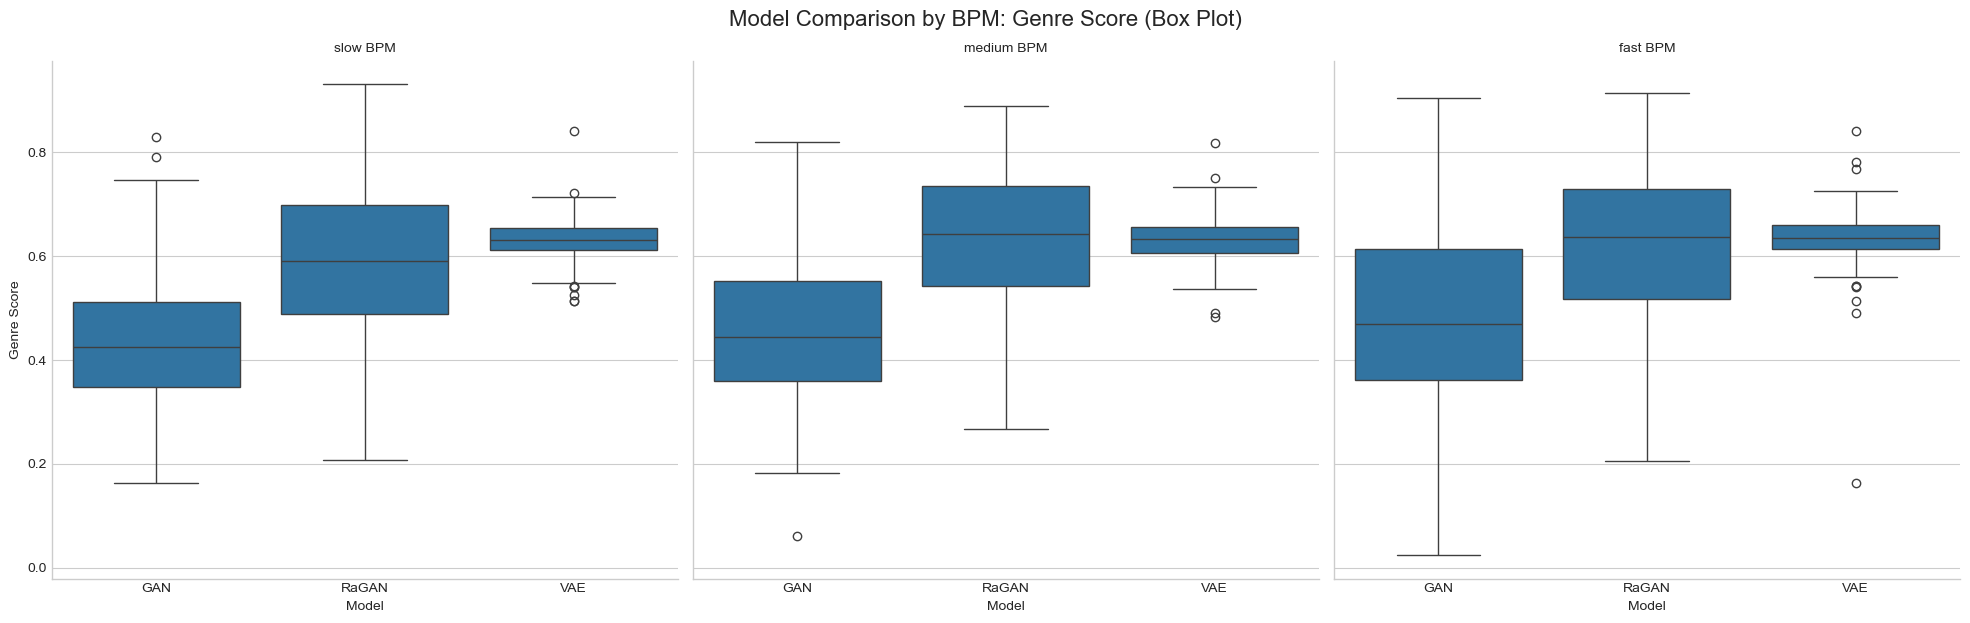

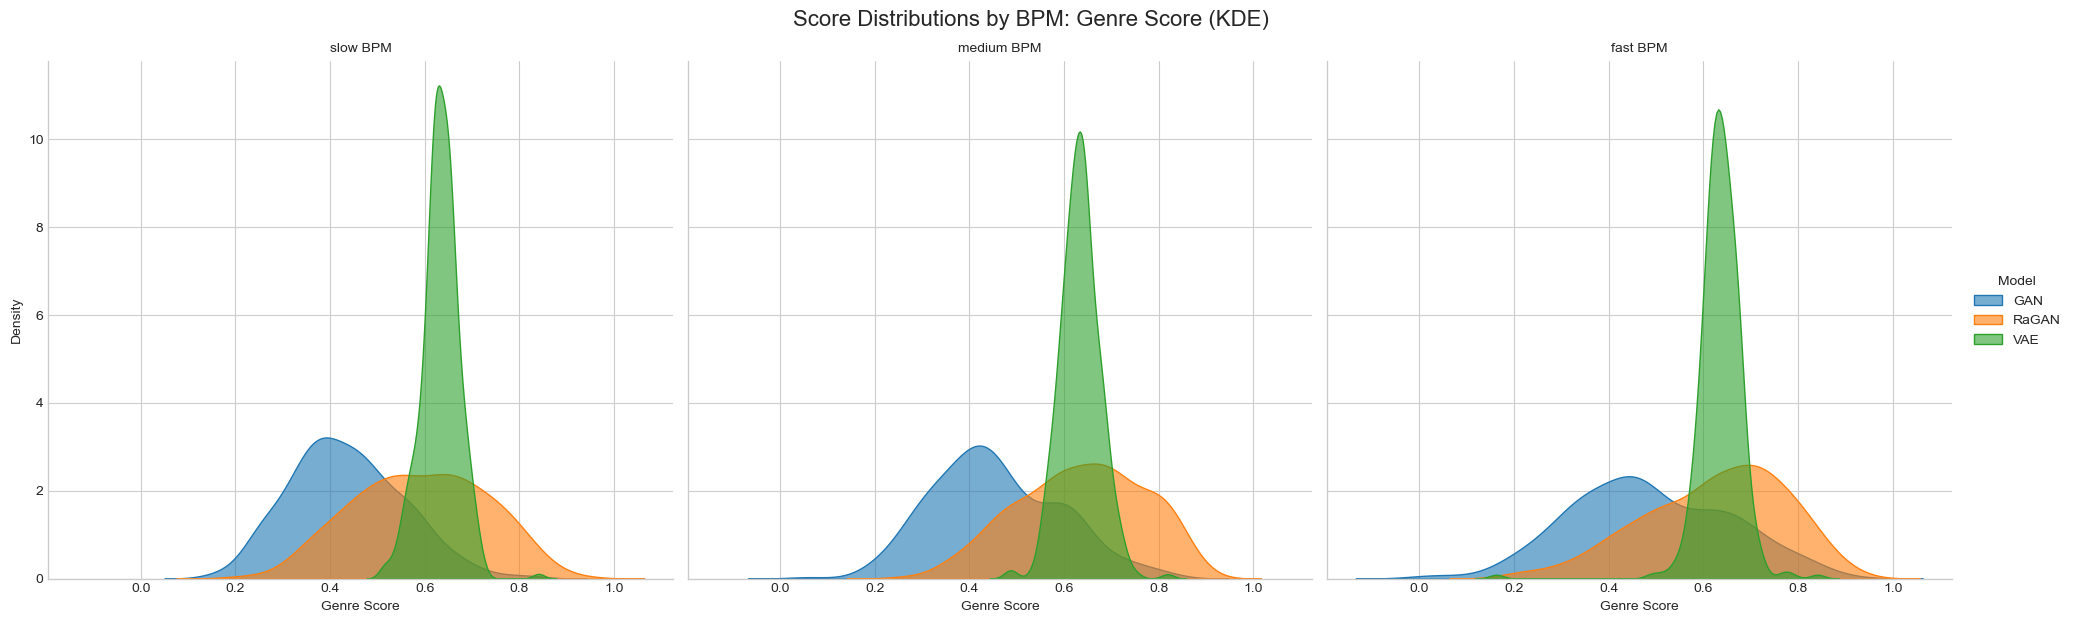

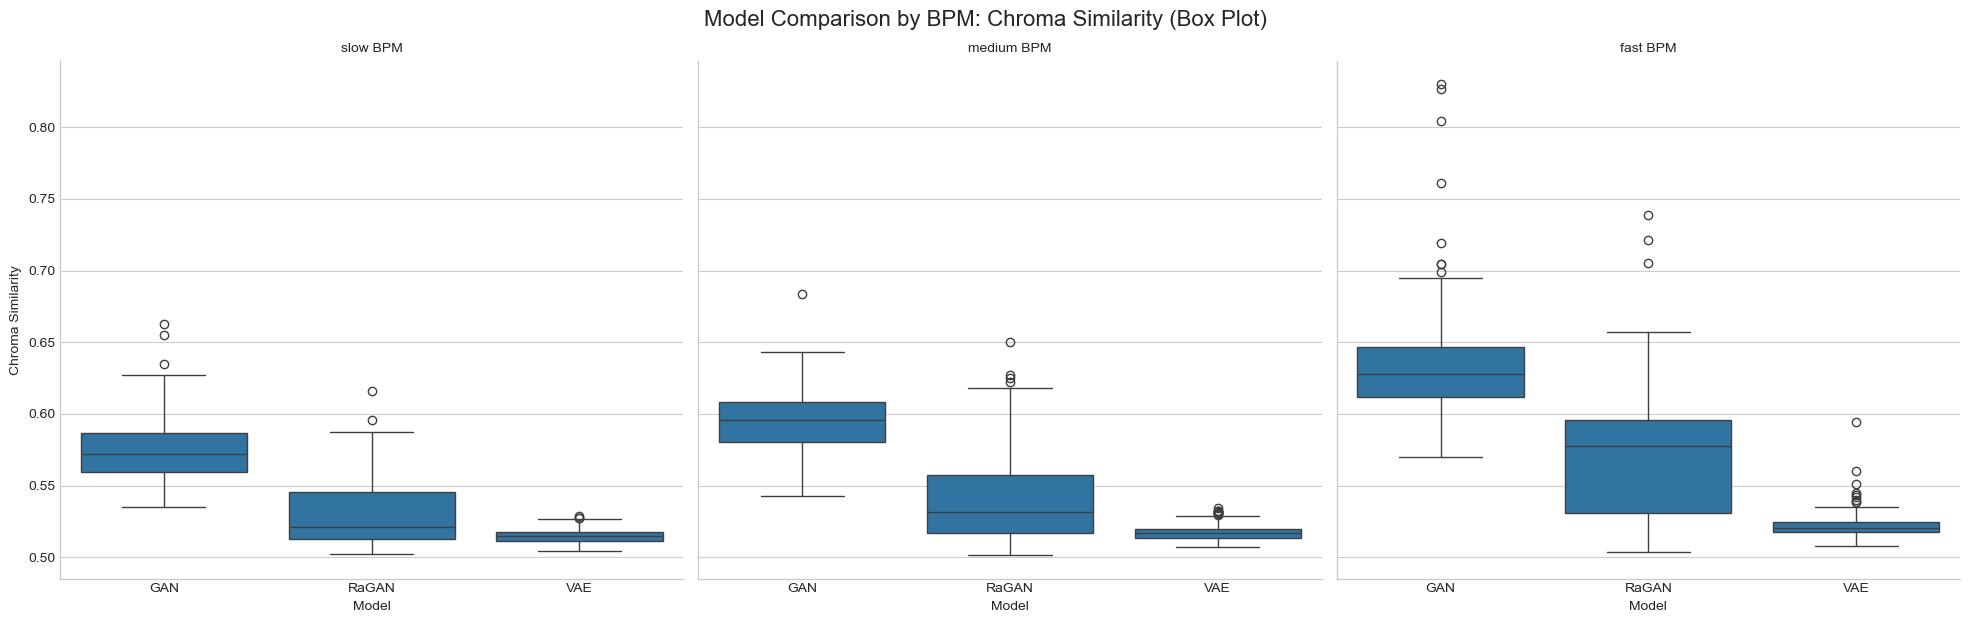

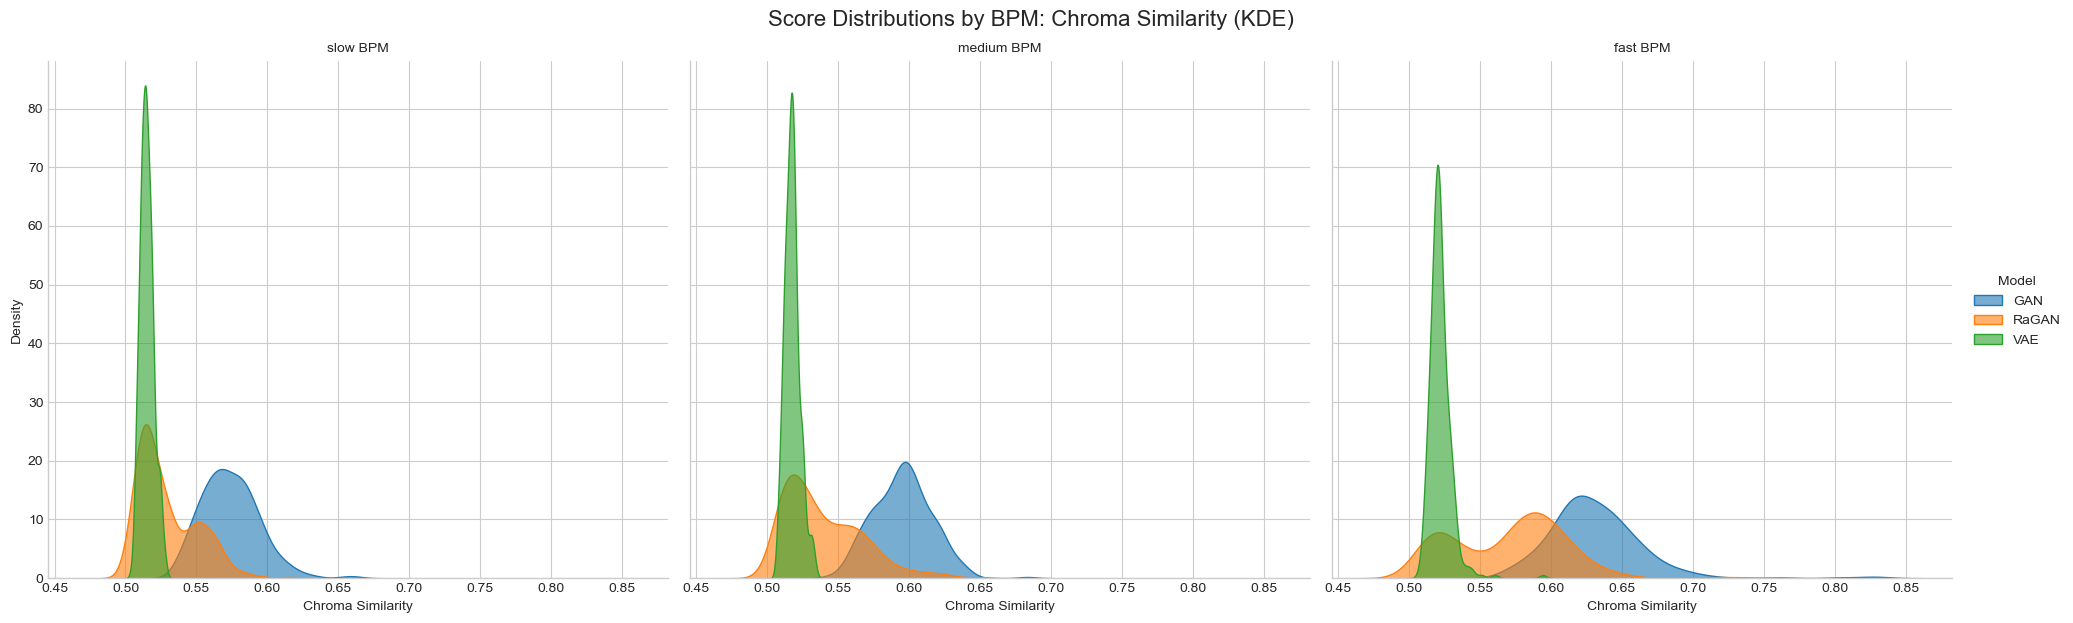

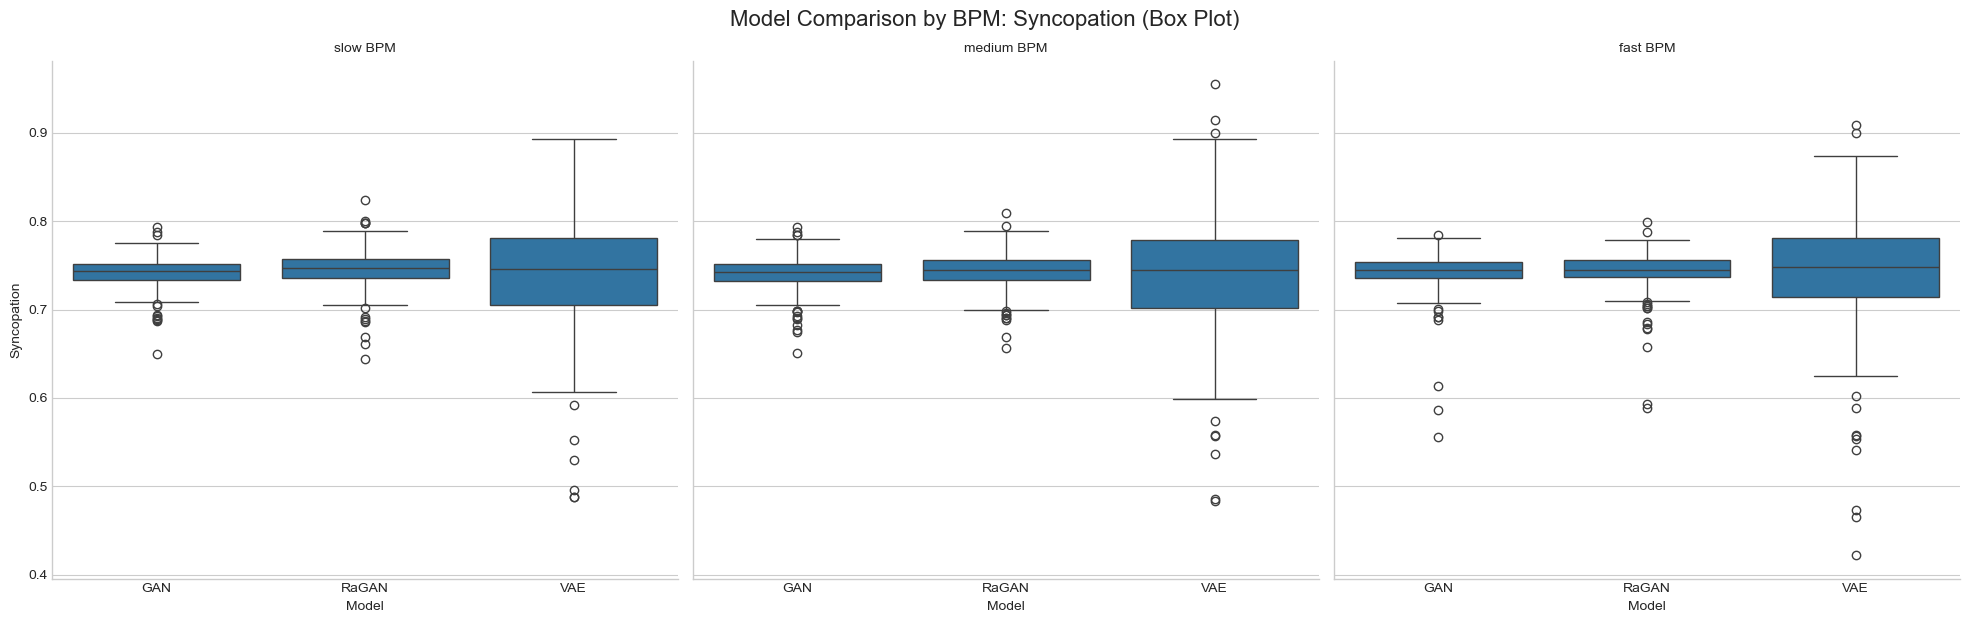

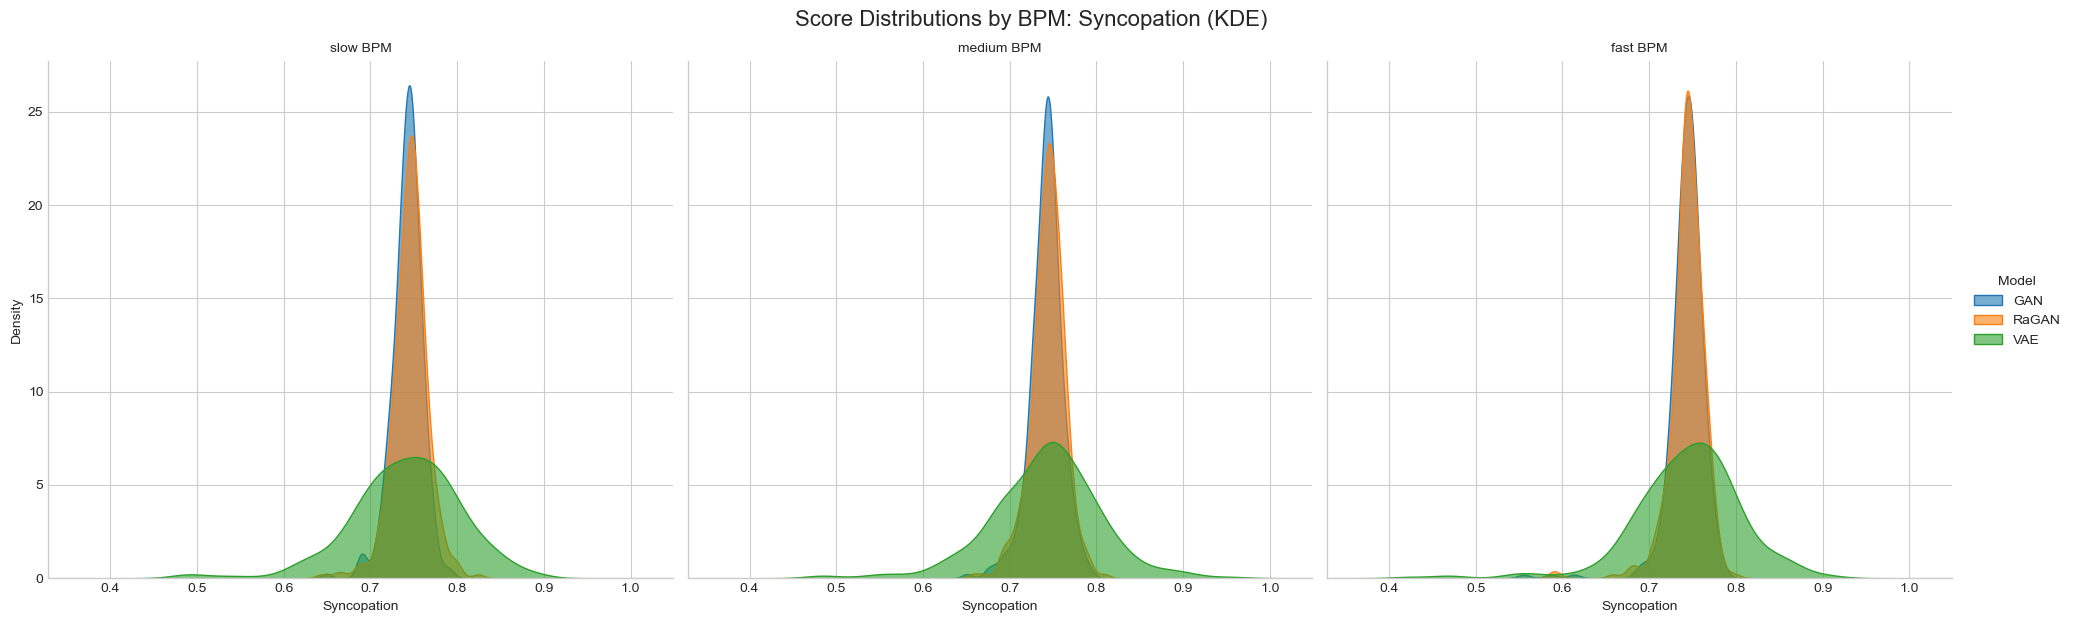

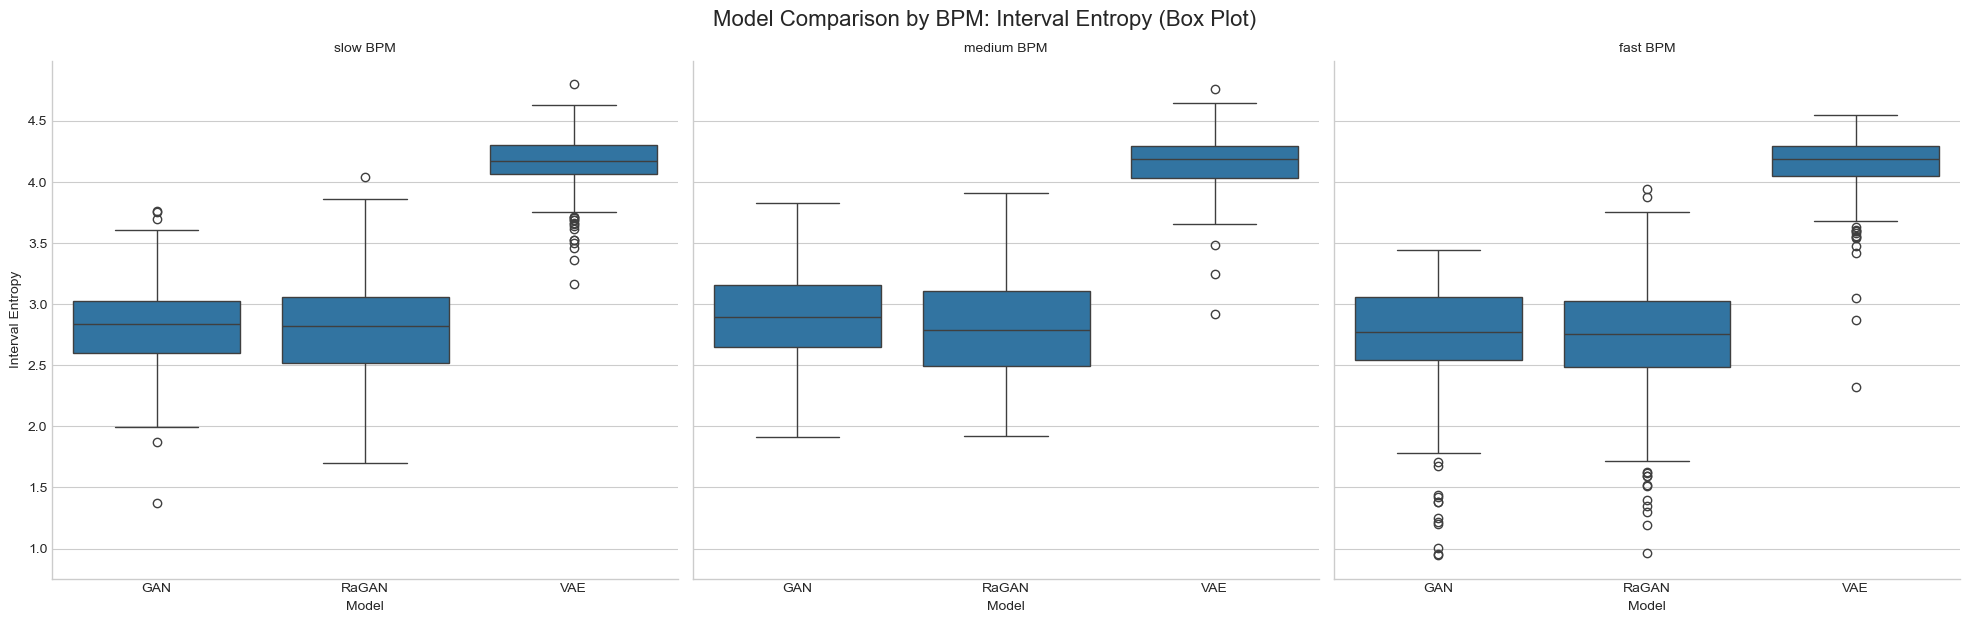

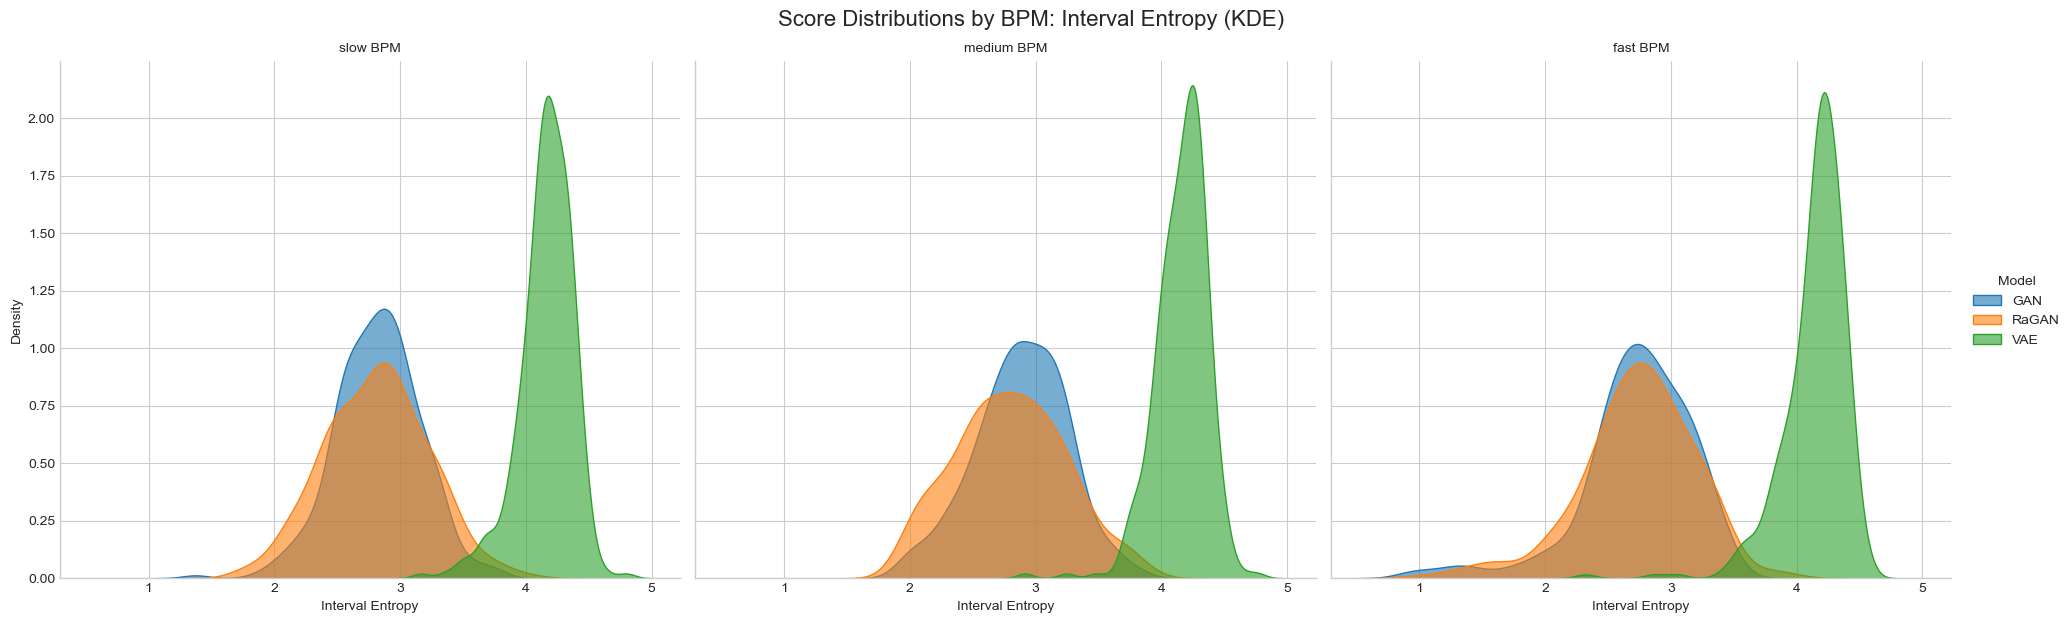

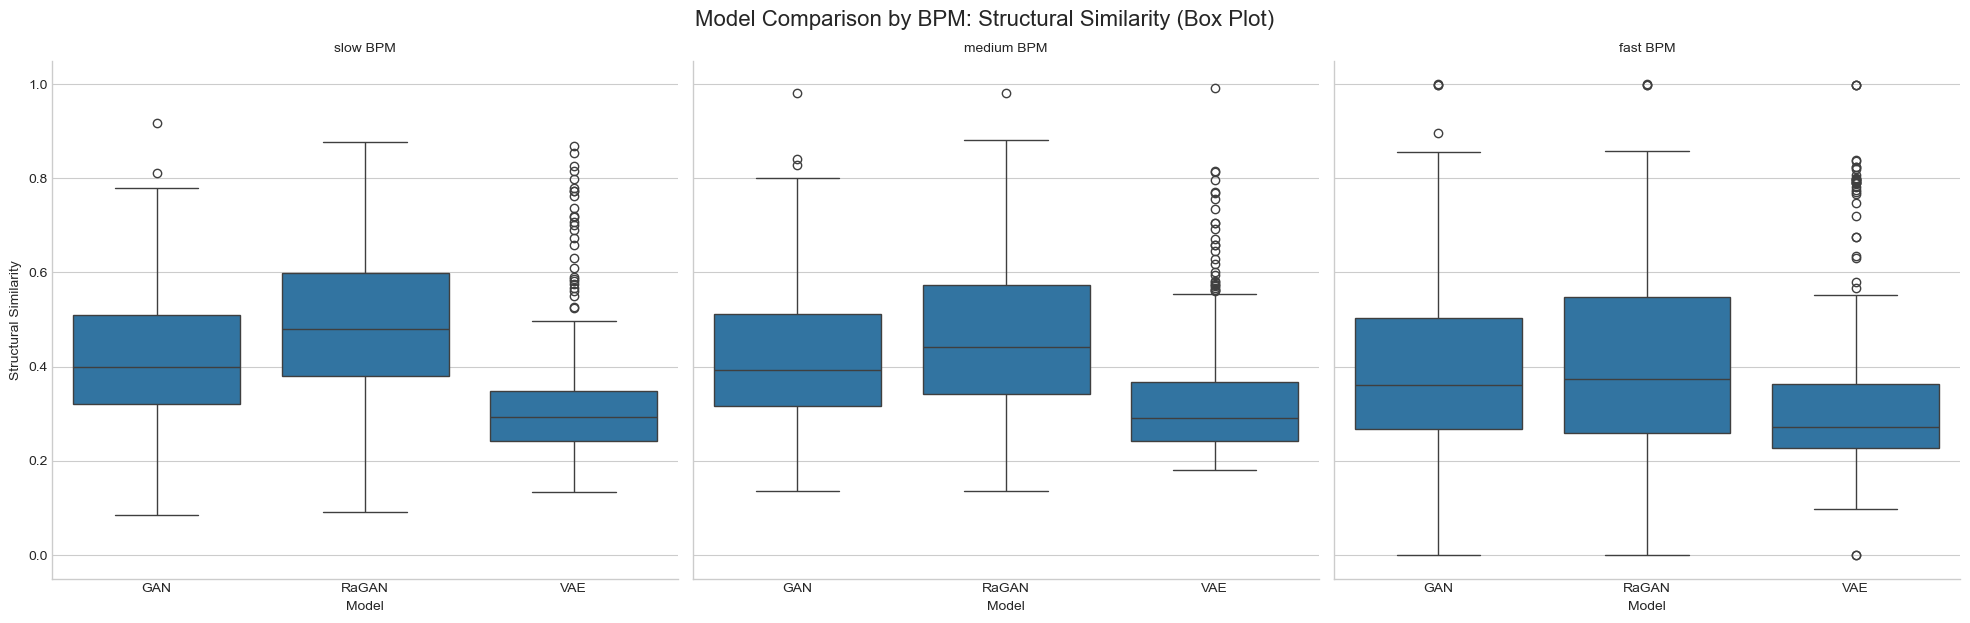

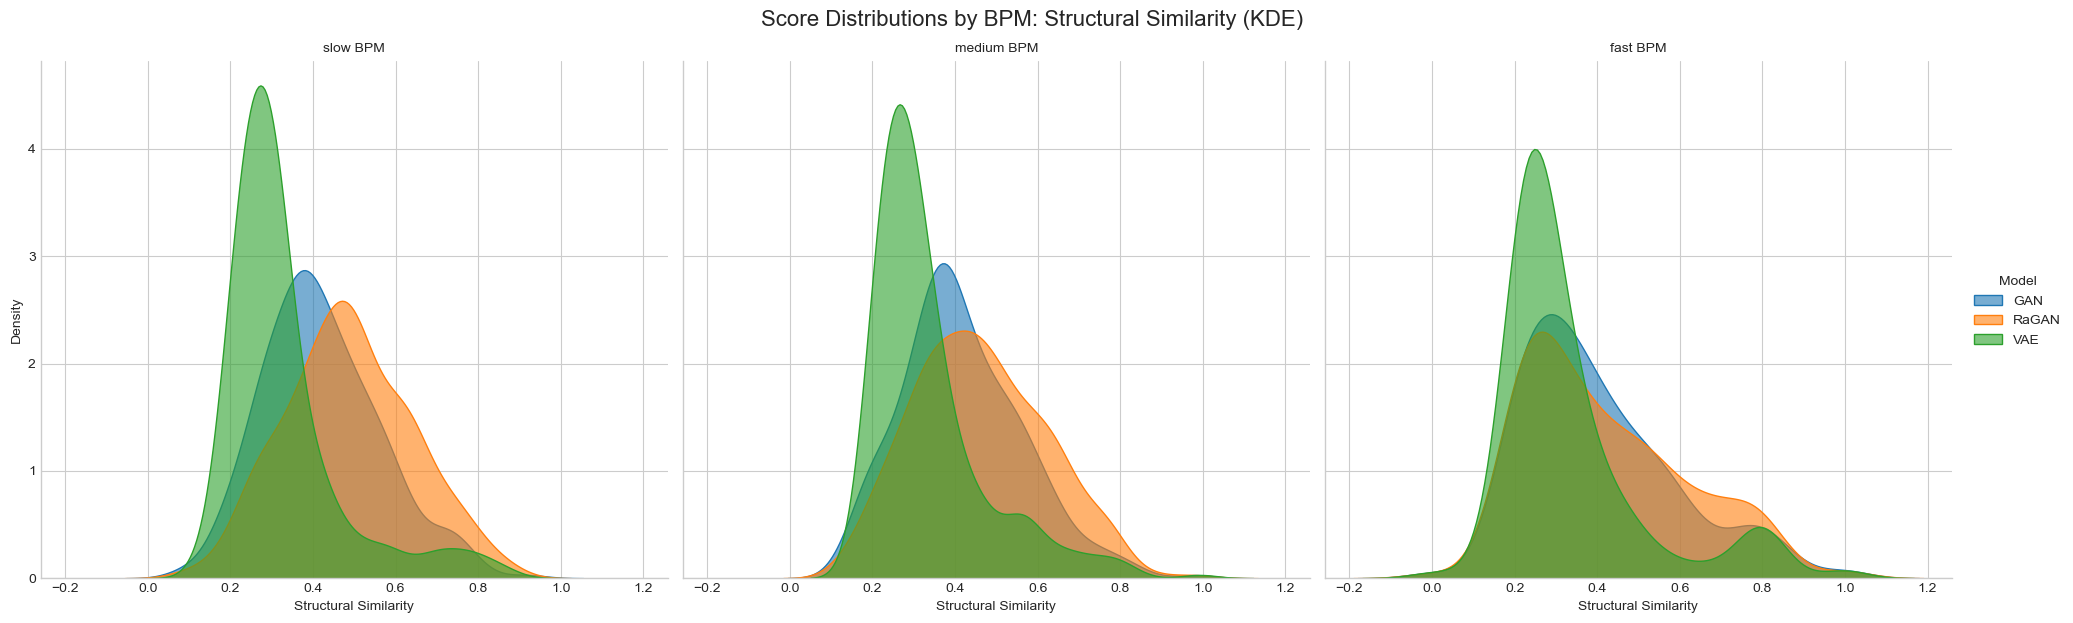

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from scipy.spatial.distance import cosine
import warnings

# --- Local File Imports ---
from DataLoading import MultiChannelEagerDataset
from JazzClassifier import JazzClassifierCNN
from TransformerVAE import TransformerVAE
from GAN import Generator

# ==============================================================================
# SECTION 2: EVALUATION CONFIGURATION
# ==============================================================================
class EvaluationConfig:
    def __init__(self):
        # --- PATHS ---
        self.BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
        self.MASTER_LABEL_MAP_FILE = os.path.join(self.BASE_MATRIX_DIR, "master_label_map.json")
        self.METADATA_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PreprocessedData_Cleaned\metadata"
        
        # --- MODEL CHECKPOINT PATHS ---
        self.GAN_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth"
        self.RAGAN_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth"
        self.VAE_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE\ppo_tuned_VAE_epoch_50.pth"
        self.PRETRAINED_CLASSIFIER_PATH = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced.pth"

        # --- EVALUATION DATA & OUTPUT PATHS ---
        self.EVALUATION_OUTPUT_DIR = r"C:\Users\User\Desktop\college\fyp\models\Evaluation_Results"
        self.EVAL_TEST_FILES_CSV = os.path.join(self.EVALUATION_OUTPUT_DIR, "evaluation_test_songs_bpm_stratified.csv")
        self.EVAL_RESULTS_CSV = os.path.join(self.EVALUATION_OUTPUT_DIR, "evaluation_results_bpm_stratified.csv")

        # --- [NEW] BPM-STRATIFIED EVALUATION PARAMETERS ---
        self.NUM_SONGS_PER_BPM_CATEGORY = 300
        self.BPM_THRESHOLDS = {
            'slow': (0, 100),
            'medium': (100, 140),
            'fast': (140, float('inf'))
        }

        # --- GENERAL EVALUATION PARAMETERS ---
        self.BATCH_SIZE = 32
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.NOTE_ON_THRESHOLD = 0.5

        # --- MODEL ARCHITECTURE PARAMETERS (Must match trained models) ---
        self.PITCHES = 88
        self.TIMESTEPS = 128
        self.CHANNELS = 3
        self.NOISE_DIM = 100
        self.LATENT_DIM = 256
        self.EMBED_DIM = 512
        self.NHEAD = 8
        self.NUM_ENCODER_LAYERS = 6
        self.NUM_DECODER_LAYERS = 6
        self.DROPOUT = 0.1
        
        os.makedirs(self.EVALUATION_OUTPUT_DIR, exist_ok=True)


# ==============================================================================
# SECTION 3: THE MODEL EVALUATOR CLASS (WITH BPM-STRATIFIED ANALYSIS)
# ==============================================================================
class ModelEvaluator:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.models = {}
        self.classifier = self._load_classifier()
        self.pitch_to_chroma_map = self._create_pitch_to_chroma_map().to(self.device)

    def _pad_to_4_channels(self, tensor_3_channels):
        dummy_channel = torch.zeros_like(tensor_3_channels[:, 0:1, :, :])
        return torch.cat([tensor_3_channels, dummy_channel], dim=1)

    def _load_classifier(self):
        print("Loading Jazz Genre Classifier...")
        classifier = JazzClassifierCNN(in_channels=4).to(self.device)
        classifier.load_state_dict(torch.load(self.config.PRETRAINED_CLASSIFIER_PATH, map_location=self.device))
        classifier.eval()
        print("Classifier loaded successfully.")
        return classifier

    def _create_pitch_to_chroma_map(self):
        midi_pitches = torch.arange(21, 21 + self.config.PITCHES)
        chroma_indices = midi_pitches % 12
        pitch_to_chroma_map = torch.zeros(12, self.config.PITCHES)
        for i in range(self.config.PITCHES):
            pitch_to_chroma_map[chroma_indices[i], i] = 1.0
        return pitch_to_chroma_map

    def _load_all_models(self):
        print("\n--- Loading all models for evaluation ---")
        model_paths = {
            'GAN': self.config.GAN_MODEL_PATH,
            'RaGAN': self.config.RAGAN_MODEL_PATH,
            'VAE': self.config.VAE_MODEL_PATH
        }
        for name, path in model_paths.items():
            try:
                if name == 'VAE':
                    model = TransformerVAE(self.config).to(self.device)
                    checkpoint = torch.load(path, map_location=self.device)
                    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['model_state_dict'])
                    else:
                        model.load_state_dict(checkpoint)
                else: 
                    model = Generator(self.config).to(self.device)
                    model.load_state_dict(torch.load(path, map_location=self.device))
                
                model.eval()
                self.models[name] = model
                print(f"Successfully loaded {name} model.")
            except Exception as e:
                print(f"ERROR loading {name} model from {path}: {e}")
        
        if not self.models:
            raise Exception("No models could be loaded. Aborting evaluation.")
        
    def _load_all_non_jazz_metadata(self):
        """[NEW] Helper to load and merge all non-jazz metadata files."""
        all_dfs = []
        print("\n--- Loading all non-jazz metadata for BPM stratification ---")
        for filename in os.listdir(self.config.METADATA_DIR):
            if 'non_jazz' in filename and filename.endswith('.csv'):
                try:
                    path = os.path.join(self.config.METADATA_DIR, filename)
                    df = pd.read_csv(path)
                    
                    # Reconstruct relative path from title and genre info
                    # This logic assumes a consistent naming convention from your previous scripts
                    genre_folder = "non_jazz"
                    source_folder = "unknown"
                    if "adl" in filename: source_folder = "adl"
                    elif "piast_at" in filename: source_folder = "piast/piast_at"
                    elif "piast_yt" in filename: source_folder = "piast/piast_yt"

                    df['filepath'] = df['Title'].apply(lambda title: f"{source_folder}/{genre_folder}/{title}.npz")
                    all_dfs.append(df)
                    print(f"Loaded {len(df)} records from {filename}")
                except Exception as e:
                    print(f"Warning: Could not load or process metadata file {filename}. Error: {e}")
        
        if not all_dfs:
            raise FileNotFoundError("No non-jazz metadata files found. Cannot perform BPM stratification.")
            
        return pd.concat(all_dfs, ignore_index=True)

    def _select_unseen_test_songs(self):
        if os.path.exists(self.config.EVAL_TEST_FILES_CSV):
            print(f"Loading existing BPM-stratified test song list from: {self.config.EVAL_TEST_FILES_CSV}")
            test_files_df = pd.read_csv(self.config.EVAL_TEST_FILES_CSV)
            # Return a dictionary mapping category to list of filepaths
            return {
                category: test_files_df[test_files_df['bpm_category'] == category]['filepath'].tolist()
                for category in self.config.BPM_THRESHOLDS.keys()
            }

        print("Creating a new BPM-stratified unseen non-jazz test set...")
        full_non_jazz_metadata = self._load_all_non_jazz_metadata()
        full_non_jazz_metadata.dropna(subset=['BPM'], inplace=True)

        stratified_songs = []
        for category, (min_bpm, max_bpm) in self.config.BPM_THRESHOLDS.items():
            subset = full_non_jazz_metadata[
                (full_non_jazz_metadata['BPM'] >= min_bpm) & (full_non_jazz_metadata['BPM'] < max_bpm)
            ]
            
            num_available = len(subset)
            num_to_select = min(self.config.NUM_SONGS_PER_BPM_CATEGORY, num_available)

            if num_available < self.config.NUM_SONGS_PER_BPM_CATEGORY:
                print(f"Warning: Only found {num_available} songs for '{category}' BPM category (wanted {self.config.NUM_SONGS_PER_BPM_CATEGORY}). Using all available.")
            
            sampled_df = subset.sample(n=num_to_select, random_state=42)
            sampled_df['bpm_category'] = category
            stratified_songs.append(sampled_df)
        
        final_test_df = pd.concat(stratified_songs, ignore_index=True)
        final_test_df[['filepath', 'bpm_category']].to_csv(self.config.EVAL_TEST_FILES_CSV, index=False)
        print(f"Saved stratified test set of {len(final_test_df)} songs to: {self.config.EVAL_TEST_FILES_CSV}")

        return {
            category: final_test_df[final_test_df['bpm_category'] == category]['filepath'].tolist()
            for category in self.config.BPM_THRESHOLDS.keys()
        }

    def compute_chroma_similarity(self, original_batch, generated_batch):
        original_onsets = (original_batch[:, 0, :, :] > 0.5).float()
        generated_onsets = generated_batch[:, 0, :, :]
        original_onset_chroma = F.normalize(torch.matmul(self.pitch_to_chroma_map, original_onsets), p=1, dim=1)
        generated_onset_chroma = F.normalize(torch.matmul(self.pitch_to_chroma_map, generated_onsets), p=1, dim=1)
        onset_similarity = F.cosine_similarity(original_onset_chroma.flatten(1), generated_onset_chroma.flatten(1), dim=1)
        return (onset_similarity + 1) / 2.0

    # --- [NEW] Advanced Metric Calculations ---
    def compute_syncopation(self, onset_matrix_np, beats_per_bar=4, ticks_per_beat=4):
        onsets = np.where(onset_matrix_np > self.config.NOTE_ON_THRESHOLD)
        if len(onsets[0]) == 0: return 0.0
        
        # Calculate syncopation as the proportion of notes on off-beats
        total_ticks_per_bar = beats_per_bar * ticks_per_beat
        on_beat_ticks = {i for i in range(0, total_ticks_per_bar, ticks_per_beat)}
        
        off_beat_count = sum(1 for t in onsets[0] if (t % total_ticks_per_bar) not in on_beat_ticks)
        return off_beat_count / len(onsets[0]) if len(onsets[0]) > 0 else 0.0

    def compute_pitch_interval_entropy(self, onset_matrix_np):
        pitches = np.where(onset_matrix_np > self.config.NOTE_ON_THRESHOLD)[1]
        if len(pitches) < 2: return 0.0
        
        intervals = np.diff(pitches)
        if len(intervals) == 0: return 0.0

        _, counts = np.unique(intervals, return_counts=True)
        probs = counts / len(intervals)
        entropy = -np.sum(probs * np.log2(probs + 1e-9))
        return entropy
    
    def compute_structural_similarity(self, original_np, generated_np):
        """
        [MODIFIED] Computes structural similarity while gracefully handling potential
        UserWarnings from librosa for silent segments.
        """
        import warnings

        # If an entire piano roll is empty, similarity is undefined. Return 0.
        if np.sum(original_np) == 0 or np.sum(generated_np) == 0:
            return 0.0

        # Temporarily suppress the specific UserWarning from librosa
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning, module='librosa')
            
            try:
                chroma_orig = librosa.feature.chroma_stft(S=original_np.T)
                chroma_gen = librosa.feature.chroma_stft(S=generated_np.T)

                ssm_orig = librosa.segment.recurrence_matrix(chroma_orig, mode='affinity')
                ssm_gen = librosa.segment.recurrence_matrix(chroma_gen, mode='affinity')

                # Handle the case where one of the matrices is all zeros after processing
                if np.all(ssm_orig==0) or np.all(ssm_gen==0):
                    return 0.0

                similarity = 1 - cosine(ssm_orig.flatten(), ssm_gen.flatten())
                # Cosine can return NaN if one vector is all zeros, handle this
                return similarity if not np.isnan(similarity) else 0.0

            except Exception as e:
                # If any other error occurs, log it and return 0
                print(f"  -  Warning: Could not compute structural similarity. Error: {e}")
                return 0.0

    def _generate_and_evaluate_song(self, song_segments_loader, model, model_name):
        generated_segments, original_segments = [], []

        # <<< MODIFIED: Pre-filter silent segments >>>
        for segments_batch, _ in song_segments_loader:
            # Check for note onsets in the batch
            onset_sum_per_segment = torch.sum(segments_batch[:, 0, :, :], dim=(1, 2))
            active_mask = onset_sum_per_segment > 0
            
            # If there are any active segments in the batch, process them
            if active_mask.any():
                active_segments = segments_batch[active_mask]
                input_segments = active_segments[:, :3, :, :].to(self.device)
                original_segments.append(input_segments.cpu())
                
                with torch.no_grad():
                    if model_name in ['GAN', 'RaGAN']:
                        noise = torch.randn(input_segments.size(0), self.config.NOISE_DIM).to(self.device)
                        output = model(input_segments, noise)
                    elif model_name == 'VAE':
                        output, _, _ = model(input_segments)
                
                generated_segments.append(output.cpu())

        # If after checking all batches, no active segments were found, return None
        if not generated_segments:
            return None

        full_generated_tensor = torch.cat(generated_segments, dim=0)
        full_original_tensor = torch.cat(original_segments, dim=0)

        # 1. Genre Classification Score
        binary_onsets = (full_generated_tensor[:, 0:1, :, :] > 0.5).float()
        binary_sustains = (full_generated_tensor[:, 1:2, :, :] > 0.5).float()
        velocity_probs = full_generated_tensor[:, 2:3, :, :]
        classifier_input = torch.cat([binary_onsets, binary_sustains, velocity_probs], dim=1)
        classifier_input_4_chan = self._pad_to_4_channels(classifier_input)
        genre_scores = torch.sigmoid(self.classifier(classifier_input_4_chan.to(self.device)))
        avg_genre_score = genre_scores.mean().item()

        # 2. Chroma Similarity Score
        chroma_scores = self.compute_chroma_similarity(full_original_tensor.to(self.device), full_generated_tensor.to(self.device))
        avg_chroma_score = chroma_scores.mean().item()

        # 3. Advanced Metrics
        original_onsets_np = full_original_tensor[:, 0, :, :].numpy()
        generated_onsets_np = full_generated_tensor[:, 0, :, :].numpy()

        syncopation_score = self.compute_syncopation(generated_onsets_np)
        interval_entropy = self.compute_pitch_interval_entropy(generated_onsets_np)
        structural_sim = self.compute_structural_similarity(original_onsets_np, generated_onsets_np)

        return {
            'genre_score': avg_genre_score,
            'chroma_similarity': avg_chroma_score,
            'syncopation': syncopation_score,
            'interval_entropy': interval_entropy,
            'structural_similarity': structural_sim
        }
        
    def run_evaluation_campaign(self):
        self._load_all_models()
        test_songs_by_category = self._select_unseen_test_songs()

        results = []
        
        for category, song_list in test_songs_by_category.items():
            print(f"\n--- Evaluating category: {category.upper()} ({len(song_list)} songs) ---")
            
            for song_rel_path in tqdm(song_list, desc=f"Processing {category} songs"):
                song_full_path = os.path.join(self.config.BASE_MATRIX_DIR, song_rel_path)
                
                song_dataset = MultiChannelEagerDataset([song_full_path], [0], dataset_name="Single Song", print_statement=False)
                if len(song_dataset) == 0:
                    continue
                
                song_loader = DataLoader(song_dataset, batch_size=self.config.BATCH_SIZE, shuffle=False)
                
                for model_name, model in self.models.items():
                    song_metrics = self._generate_and_evaluate_song(song_loader, model, model_name)
                    if song_metrics is None:
                        continue
                    
                    song_metrics['model'] = model_name
                    song_metrics['song'] = song_rel_path
                    song_metrics['bpm_category'] = category # Add the category to the results
                    results.append(song_metrics)

        if not results:
            print("\n--- No valid songs were evaluated. ---")
            return

        results_df = pd.DataFrame(results)
        results_df.to_csv(self.config.EVAL_RESULTS_CSV, index=False)
        print(f"\nEvaluation complete. Full results saved to {self.config.EVAL_RESULTS_CSV}")

        self._create_summary_and_plots(results_df)

    def _create_summary_and_plots(self, results_df):
        print("\n" + "="*50)
        print("--- Overall Performance Summary ---")
        summary = results_df.groupby('model').agg(
            {'genre_score': ['mean', 'std'], 'chroma_similarity': ['mean', 'std'], 'syncopation': ['mean', 'std'], 'interval_entropy': ['mean', 'std'], 'structural_similarity': ['mean', 'std']}
        ).round(4)
        print(summary)
        
        print("\n" + "="*50)
        print("--- BPM-Stratified Performance Summary ---")
        detailed_summary = results_df.groupby(['bpm_category', 'model']).agg(
            {'genre_score': ['mean', 'std'], 'chroma_similarity': ['mean', 'std'], 'syncopation': ['mean', 'std'], 'interval_entropy': ['mean', 'std'], 'structural_similarity': ['mean', 'std']}
        ).round(4)
        print(detailed_summary)
        print("="*50)

        plt.style.use('seaborn-v0_8-whitegrid')
        metric_cols = ['genre_score', 'chroma_similarity', 'syncopation', 'interval_entropy', 'structural_similarity']
        
        # --- Create separate, faceted plots for each plot type ---
        for metric in metric_cols:
            
            # --- Plot 1: Faceted Box Plots ---
            g_box = sns.FacetGrid(results_df, col="bpm_category", col_order=['slow', 'medium', 'fast'], height=6, aspect=1.1)
            g_box.map_dataframe(sns.boxplot, x='model', y=metric, order=['GAN', 'RaGAN', 'VAE'])
            g_box.set_axis_labels("Model", metric.replace("_", " ").title())
            g_box.set_titles(col_template="{col_name} BPM")
            g_box.fig.suptitle(f'Model Comparison by BPM: {metric.replace("_", " ").title()} (Box Plot)', fontsize=16, y=1.03)
            plt.show()

            # --- Plot 2: Faceted KDE Plots ---
            g_kde = sns.FacetGrid(results_df, col="bpm_category", col_order=['slow', 'medium', 'fast'], hue='model', hue_order=['GAN', 'RaGAN', 'VAE'], height=6, aspect=1.1)
            g_kde.map(sns.kdeplot, metric, fill=True, common_norm=False, alpha=0.6)
            g_kde.set_axis_labels(metric.replace("_", " ").title(), "Density")
            g_kde.set_titles(col_template="{col_name} BPM")
            g_kde.add_legend(title='Model')
            g_kde.fig.suptitle(f'Score Distributions by BPM: {metric.replace("_", " ").title()} (KDE)', fontsize=16, y=1.03)
            plt.show()

# ==============================================================================
# SECTION 5: MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    eval_config = EvaluationConfig()
    evaluator = ModelEvaluator(eval_config)
    evaluator.run_evaluation_campaign()

# Convert Samples for human evaluation

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import torch
import numpy as np
import os
import json
import random
import pretty_midi
from fluidsynth import Synth
import wave
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader

# --- Local File Imports ---
from GAN import Generator
from TransformerVAE import TransformerVAE
from DataLoading import MultiChannelEagerDataset

# ==============================================================================
# SECTION 2: INFERENCE CONFIGURATION
# ==============================================================================
class InferenceConfig:
    # --- PATHS ---
    SOUNDFONT_PATH = r"C:\Users\User\Desktop\college\fyp\other\soundfont\GeneralUser GS v1.471.sf2"
    OUTPUT_DIR = r"C:\Users\User\Desktop\college\fyp\original_and_generated_bpm_specific"

    # Paths to your pre-trained model checkpoints
    GAN_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_GAN\ppo_tuned_GAN_best.pth"
    RAGAN_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_RaGAN\ppo_tuned_RaGAN_best.pth"
    VAE_MODEL_PATH = r"C:\Users\User\Desktop\college\fyp\models\PPO_Tuned_VAE\ppo_tuned_VAE_epoch_50.pth"

    # Paths to your dataset and metadata files
    BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
    MASTER_LABEL_MAP_FILE = os.path.join(BASE_MATRIX_DIR, "master_label_map.json")
    USED_NON_JAZZ_FOR_PPO_CSV = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", "used_non_jazz_for_ppo_training.csv")
    METADATA_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PreprocessedData_Cleaned\metadata"

    # --- [MODIFIED] INFERENCE PARAMETERS FOR BPM-SPECIFIC SAMPLING ---
    # We will now select ONE song per category, so total songs will be 3
    
    # --- BPM CATEGORIES ---
    BPM_THRESHOLDS = {
        'slow': (0, 100),
        'medium': (100, 140),
        'fast': (140, float('inf'))
    }

    # --- MODEL & DATA PARAMETERS ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    PITCHES = 88
    TIMESTEPS = 128
    CHANNELS = 3
    NOISE_DIM = 100

    # VAE-specific parameters
    LATENT_DIM = 256
    EMBED_DIM = 512
    NHEAD = 8
    NUM_ENCODER_LAYERS = 6
    NUM_DECODER_LAYERS = 6
    DROPOUT = 0.1

# ==============================================================================
# SECTION 3: UTILITY FUNCTIONS
# ==============================================================================
def stitch_segments_to_midi(segments_list, output_midi_path, config, bpm=120.0, onset_threshold=0.5):
    print(f"  Stitching {len(segments_list)} segments into MIDI...")
    full_pianoroll_tensor = torch.cat(segments_list, dim=2)
    pm = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    instrument = pretty_midi.Instrument(program=0, name='Acoustic Grand Piano')
    onset_probs = full_pianoroll_tensor[0].T.numpy()
    sustain_probs = full_pianoroll_tensor[1].T.numpy()
    velocity_values = full_pianoroll_tensor[2].T.numpy()
    reconstructed_onset = (onset_probs > onset_threshold).astype(int)
    RESOLUTION = 24
    PITCHES_LOW = 21
    tick_duration = 60.0 / (bpm * RESOLUTION)
    active_notes = {}
    total_timesteps = reconstructed_onset.shape[0]

    for t_step in range(total_timesteps):
        for pitch_idx in range(config.PITCHES):
            if pitch_idx not in active_notes and reconstructed_onset[t_step, pitch_idx] == 1:
                start_time = t_step * tick_duration
                velocity = int(velocity_values[t_step, pitch_idx] * 126) + 1
                active_notes[pitch_idx] = (start_time, velocity)
            elif pitch_idx in active_notes and sustain_probs[t_step, pitch_idx] < 0.5:
                start_time, velocity = active_notes.pop(pitch_idx)
                end_time = t_step * tick_duration
                if end_time > start_time:
                    instrument.notes.append(pretty_midi.Note(
                        velocity=max(1, min(127, velocity)), pitch=pitch_idx + PITCHES_LOW,
                        start=start_time, end=end_time))
    for pitch_idx, (start_time, velocity) in active_notes.items():
        end_time = total_timesteps * tick_duration
        if end_time > start_time:
            instrument.notes.append(pretty_midi.Note(
                velocity=max(1, min(127, velocity)), pitch=pitch_idx + PITCHES_LOW,
                start=start_time, end=end_time))
    pm.instruments.append(instrument)
    pm.write(output_midi_path)
    print(f"  Saved stitched MIDI to: {os.path.basename(output_midi_path)}")

def convert_midi_to_wav(midi_path, wav_path, soundfont_path, sample_rate=44100):
    print(f"  Converting {os.path.basename(midi_path)} to WAV...")
    try:
        fs = Synth(samplerate=sample_rate)
        fs.start()
        sfid = fs.sfload(soundfont_path)
        fs.program_select(0, sfid, 0, 0)
        pm = pretty_midi.PrettyMIDI(midi_path)
        audio_data = pm.fluidsynth(fs=sample_rate)
        with wave.open(wav_path, 'wb') as wf:
            wf.setnchannels(1)
            wf.setsampwidth(2)
            wf.setframerate(sample_rate)
            wf.writeframes((audio_data * 32767).astype(np.int16).tobytes())
        fs.delete()
        print(f"  Saved WAV file to: {os.path.basename(wav_path)}")
    except Exception as e:
        print(f"    ERROR during WAV conversion: {e}")

def convert_npz_to_midi_and_wav(npz_path, output_dir, config):
    """
    Converts an original NPZ file to both MIDI and WAV for comparison.
    """
    print(f"--- Converting original NPZ: {os.path.basename(npz_path)} ---")
    filename_base = os.path.splitext(os.path.basename(npz_path))[0]
    output_midi_path = os.path.join(output_dir, f"{filename_base}_original.mid")
    output_wav_path = os.path.join(output_dir, f"{filename_base}_original.wav")
    
    with np.load(npz_path) as data:
        # Load only the necessary matrices
        data_dict = {key: data[key] for key in ['onset', 'sustain', 'velocity', 'offset']}

    # Convert numpy arrays to a tensor list for the stitching function
    segments_list = [
        torch.from_numpy(np.stack([
            data_dict['onset'].T, 
            data_dict['sustain'].T, 
            data_dict['velocity'].T
        ], axis=0).astype(np.float32))
    ]
    
    stitch_segments_to_midi(segments_list, output_midi_path, config)
    convert_midi_to_wav(output_midi_path, output_wav_path, config.SOUNDFONT_PATH)

# ==============================================================================
# SECTION 4: INFERENCE LOGIC
# ==============================================================================
class StyleTransferInference:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        os.makedirs(config.OUTPUT_DIR, exist_ok=True)
        self.models = {}

    def load_all_models(self):
        """Loads all three models for the campaign."""
        print("\n" + "="*50)
        print("--- Loading all models for inference campaign ---")
        model_paths = {
            'GAN': self.config.GAN_MODEL_PATH,
            'RaGAN': self.config.RAGAN_MODEL_PATH,
            'VAE': self.config.VAE_MODEL_PATH
        }
        for name, path in model_paths.items():
            try:
                if name == 'VAE':
                    model = TransformerVAE(self.config).to(self.device)
                    checkpoint = torch.load(path, map_location=self.device)
                    # Handle both dictionary and raw state_dict checkpoints
                    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                        model.load_state_dict(checkpoint['model_state_dict'])
                    else:
                        model.load_state_dict(checkpoint)
                else:  # GAN or RaGAN
                    model = Generator(self.config).to(self.device)
                    model.load_state_dict(torch.load(path, map_location=self.device))
                
                model.eval()
                self.models[name] = model
                print(f"Successfully loaded {name} model.")
            except Exception as e:
                print(f"ERROR loading {name} model from {path}: {e}")
        
        if not self.models:
            raise Exception("No models could be loaded. Aborting.")
        print("="*50 + "\n")

    def _load_all_non_jazz_metadata(self):
        """Helper to load and merge all non-jazz metadata files."""
        all_dfs = []
        print("\n--- Loading all non-jazz metadata for BPM stratification ---")
        for filename in os.listdir(self.config.METADATA_DIR):
            if 'non_jazz' in filename and filename.endswith('.csv'):
                try:
                    path = os.path.join(self.config.METADATA_DIR, filename)
                    df = pd.read_csv(path)
                    
                    # Reconstruct relative path from title and genre info
                    # This logic assumes a consistent naming convention from your previous scripts
                    genre_folder = "non_jazz"
                    source_folder = "unknown"
                    if "adl" in filename: source_folder = "adl"
                    elif "piast_at" in filename: source_folder = "piast/piast_at"
                    elif "piast_yt" in filename: source_folder = "piast/piast_yt"

                    df['filepath'] = df['Title'].apply(lambda title: f"{source_folder}/{genre_folder}/{title}.npz")
                    all_dfs.append(df)
                    print(f"Loaded {len(df)} records from {filename}")
                except Exception as e:
                    print(f"Warning: Could not load or process metadata file {filename}. Error: {e}")
        
        if not all_dfs:
            raise FileNotFoundError("No non-jazz metadata files found. Cannot perform BPM stratification.")
            
        return pd.concat(all_dfs, ignore_index=True)

    def _get_random_unseen_songs(self, num_songs):
        """Selects a specified number of random unseen songs."""
        print(f"Selecting {num_songs} random unseen non-jazz songs...")
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        used_ppo_df = pd.read_csv(self.config.USED_NON_JAZZ_FOR_PPO_CSV)
        used_ppo_files = set(used_ppo_df['filepath'])
        all_non_jazz = {p for p, l in label_map.items() if l == 0}
        available_songs = list(all_non_jazz - used_ppo_files)

        if len(available_songs) < num_songs:
            raise Exception(f"Not enough unseen songs available! Found {len(available_songs)}, need {num_songs}.")
            
        random_song_paths = random.sample(available_songs, num_songs)
        print("Selected songs:")
        for song in random_song_paths:
            print(f"  - {song}")
        return random_song_paths
    
    def _get_bpm_stratified_unseen_songs(self):
        """
        Selects one random unseen song from each BPM category.
        """
        print(f"Selecting one random unseen song for each BPM category...")
        
        full_non_jazz_metadata = self._load_all_non_jazz_metadata()
        used_ppo_df = pd.read_csv(self.config.USED_NON_JAZZ_FOR_PPO_CSV)
        used_ppo_files = set(used_ppo_df['filepath'])

        # Filter out songs that were used in PPO training
        available_metadata = full_non_jazz_metadata[~full_non_jazz_metadata['filepath'].isin(used_ppo_files)]
        available_metadata.dropna(subset=['BPM'], inplace=True)

        selected_songs = {}
        for category, (min_bpm, max_bpm) in self.config.BPM_THRESHOLDS.items():
            subset = available_metadata[
                (available_metadata['BPM'] >= min_bpm) & (available_metadata['BPM'] < max_bpm)
            ]
            if subset.empty:
                print(f"Warning: No unseen songs found for '{category}' BPM category. Skipping.")
                continue
            
            # Select one random song from this category
            selected_song = subset.sample(n=1, random_state=random.randint(0, 1000))
            selected_songs[category] = selected_song.iloc[0]['filepath']
        
        if not selected_songs:
             raise Exception("Could not find any songs to run inference on after BPM stratification.")

        print("\nSelected songs for inference:")
        for category, song_path in selected_songs.items():
            print(f"  - {category.upper()}: {song_path}")
            
        return selected_songs

    def run_inference_campaign(self):
        """Main loop to run inference for all models on the selected songs."""
        self.load_all_models()
        
        songs_to_process = self._get_bpm_stratified_unseen_songs()
        
        for category, song_rel_path in songs_to_process.items():
            song_full_path = os.path.join(self.config.BASE_MATRIX_DIR, song_rel_path)
            #Add the category to the filename for easy identification
            song_name_base = f"{os.path.splitext(os.path.basename(song_rel_path))[0]}_{category.upper()}"

            print("\n" + "#"*60)
            print(f"# Processing {category.upper()} Song: {song_name_base}")
            print("#"*60)

            # 1. Convert and save the original song
            convert_npz_to_midi_and_wav(song_full_path, self.config.OUTPUT_DIR, self.config)

            # 2. Load the song's data into a DataLoader
            song_dataset = MultiChannelEagerDataset([song_full_path], [0], dataset_name=f"Data for {song_name_base}", print_statement=False)
            if len(song_dataset) == 0:
                print(f"Warning: Skipping song {song_name_base} as it contains no valid segments.")
                continue
            song_loader = DataLoader(song_dataset, batch_size=self.config.BATCH_SIZE, shuffle=False)

            # 3. Process the song with each loaded model
            for model_name, model in self.models.items():
                print(f"\n--- Generating with {model_name} model for song: {song_name_base} ---")
                generated_segments = []
                with torch.no_grad():
                    for segments_batch, _ in song_loader:
                        input_segments = segments_batch[:, :3, :, :].to(self.device)
                        
                        if model_name in ['GAN', 'RaGAN']:
                            noise = torch.randn(input_segments.size(0), self.config.NOISE_DIM).to(self.device)
                            output = model(input_segments, noise).cpu()
                        elif model_name == 'VAE':
                            output, _, _ = model(input_segments)
                            output = output.cpu()
                        
                        generated_segments.extend(torch.unbind(output, dim=0))

                # 4. Stitch and convert the generated output
                midi_filename = f"{song_name_base}_{model_name}_generated.mid"
                wav_filename = f"{song_name_base}_{model_name}_generated.wav"
                midi_filepath = os.path.join(self.config.OUTPUT_DIR, midi_filename)
                wav_filepath = os.path.join(self.config.OUTPUT_DIR, wav_filename)
                
                onset_thresh = 0.1 if model_name == 'VAE' else 0.5
                
                stitch_segments_to_midi(generated_segments, midi_filepath, self.config, onset_threshold=onset_thresh)
                convert_midi_to_wav(midi_filepath, wav_filepath, self.config.SOUNDFONT_PATH)

# ==============================================================================
# SECTION 5: MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    inference_config = InferenceConfig()
    inference_runner = StyleTransferInference(inference_config)
    inference_runner.run_inference_campaign()


--- Loading all models for inference campaign ---


C:\Users\User\AppData\Local\Temp\ipykernel_8260\4145008506.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=self.dev

Successfully loaded GAN model.
Successfully loaded RaGAN model.


C:\Users\User\AppData\Local\Temp\ipykernel_8260\4145008506.py:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)
C:\U

Successfully loaded VAE model.

Selecting one random unseen song for each BPM category...

--- Loading all non-jazz metadata for BPM stratification ---
Loaded 6442 records from adl_non_jazz_metadata.csv
Loaded 810 records from piast_at_non_jazz_metadata.csv
Loaded 3314 records from piast_yt_non_jazz_metadata.csv

Selected songs for inference:
  - SLOW: adl/non_jazz/Your Love Stays With Me.npz
  - MEDIUM: adl/non_jazz/Lascia chio pianga from Rinaldo.npz
  - FAST: adl/non_jazz/A Tale Of Distant Lands.npz

############################################################
# Processing SLOW Song: Your Love Stays With Me_SLOW
############################################################
--- Converting original NPZ: Your Love Stays With Me.npz ---
  Stitching 1 segments into MIDI...
  Saved stitched MIDI to: Your Love Stays With Me_original.mid
  Converting Your Love Stays With Me_original.mid to WAV...
  Saved WAV file to: Your Love Stays With Me_original.wav

--- Generating with GAN model for son

# Human Evaluation

--- Loading and Preparing Survey Data ---
Data loaded and columns renamed successfully.

--- 1. Participant Demographics Analysis ---


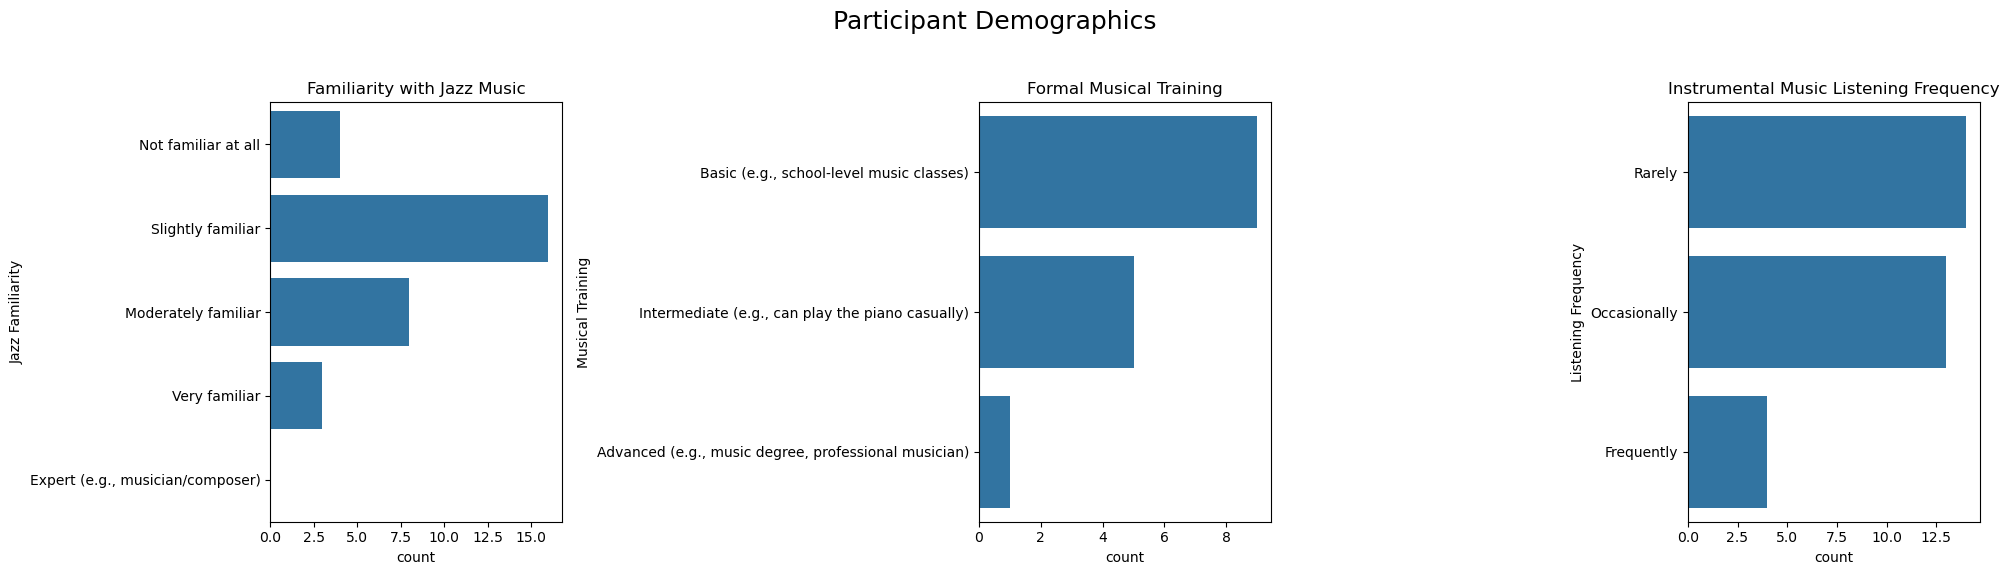


--- 2. Overall Model Performance Analysis ---


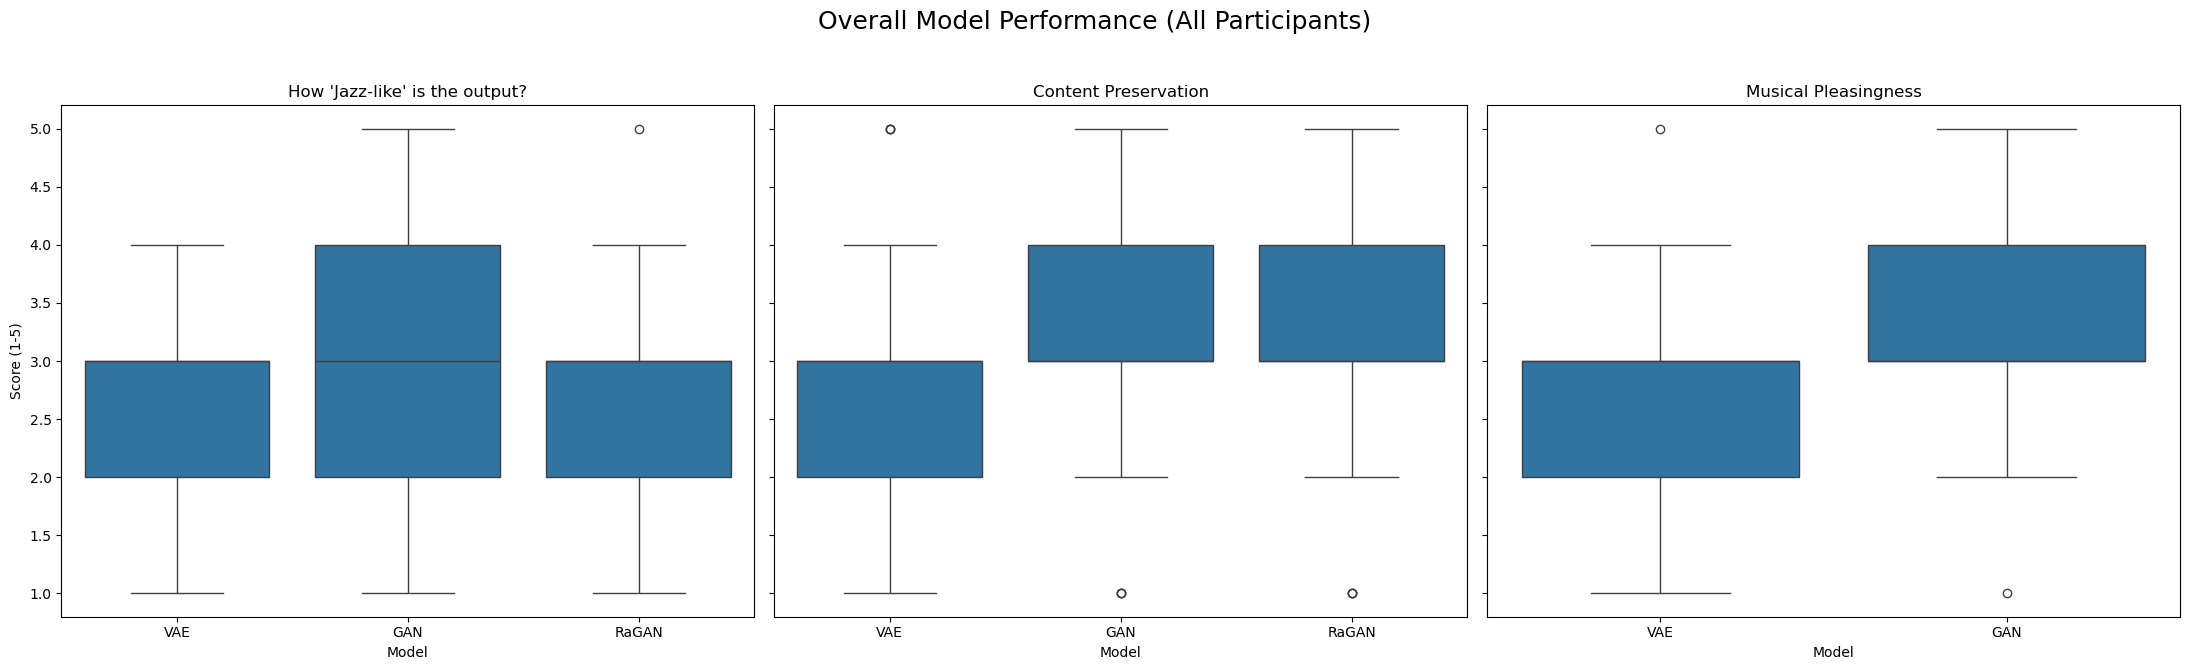


--- Statistical Significance (ANOVA) ---

Analyzing metric: Jazziness
             sum_sq    df        F    PR(>F)
C(Model)   3.247312   2.0  1.92602  0.151686
Residual  75.870968  90.0      NaN       NaN
  -> No significant difference found between models for Jazziness.

Analyzing metric: Content
              sum_sq    df        F    PR(>F)
C(Model)    3.634409   2.0  1.40599  0.250456
Residual  116.322581  90.0      NaN       NaN
  -> No significant difference found between models for Content.

Analyzing metric: Pleasingness
             sum_sq    df         F    PR(>F)
C(Model)   7.112903   1.0  7.221616  0.009307
Residual  59.096774  60.0       NaN       NaN
  -> Significant difference found between models for Pleasingness.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   GAN    VAE  -0.6774 0.0093 -1.1817 -0.1732   True
------------------------------------------------

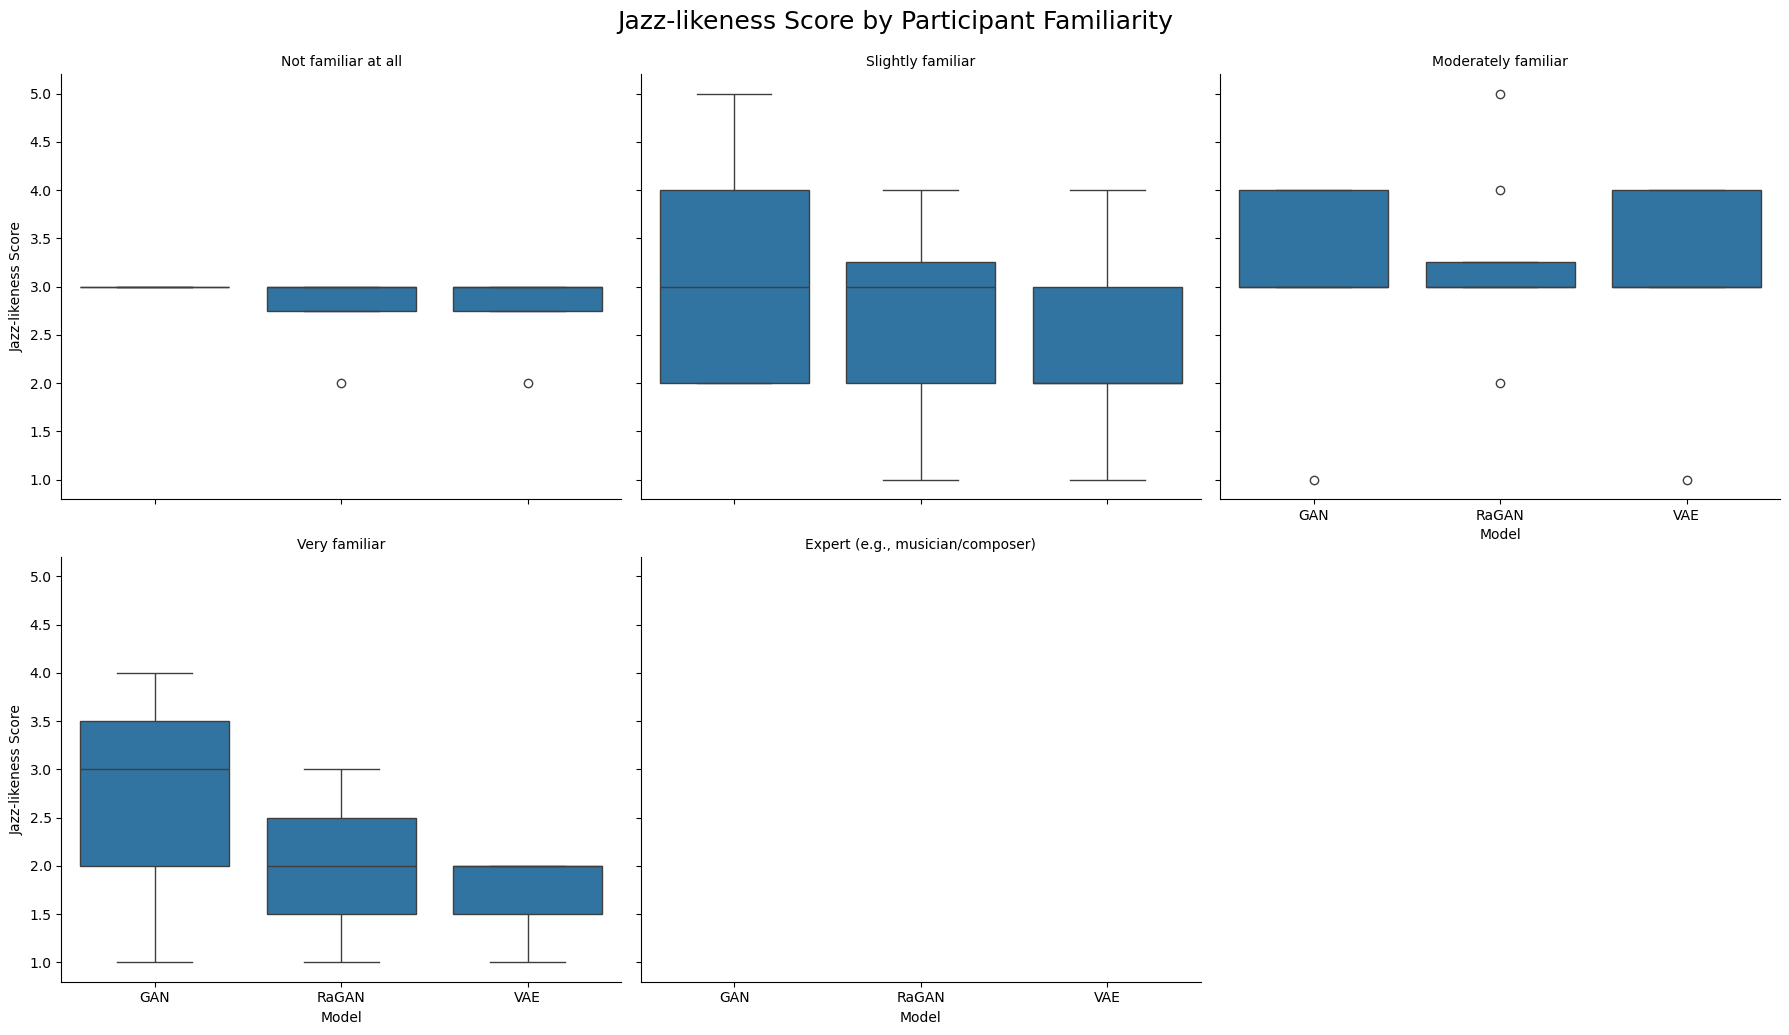

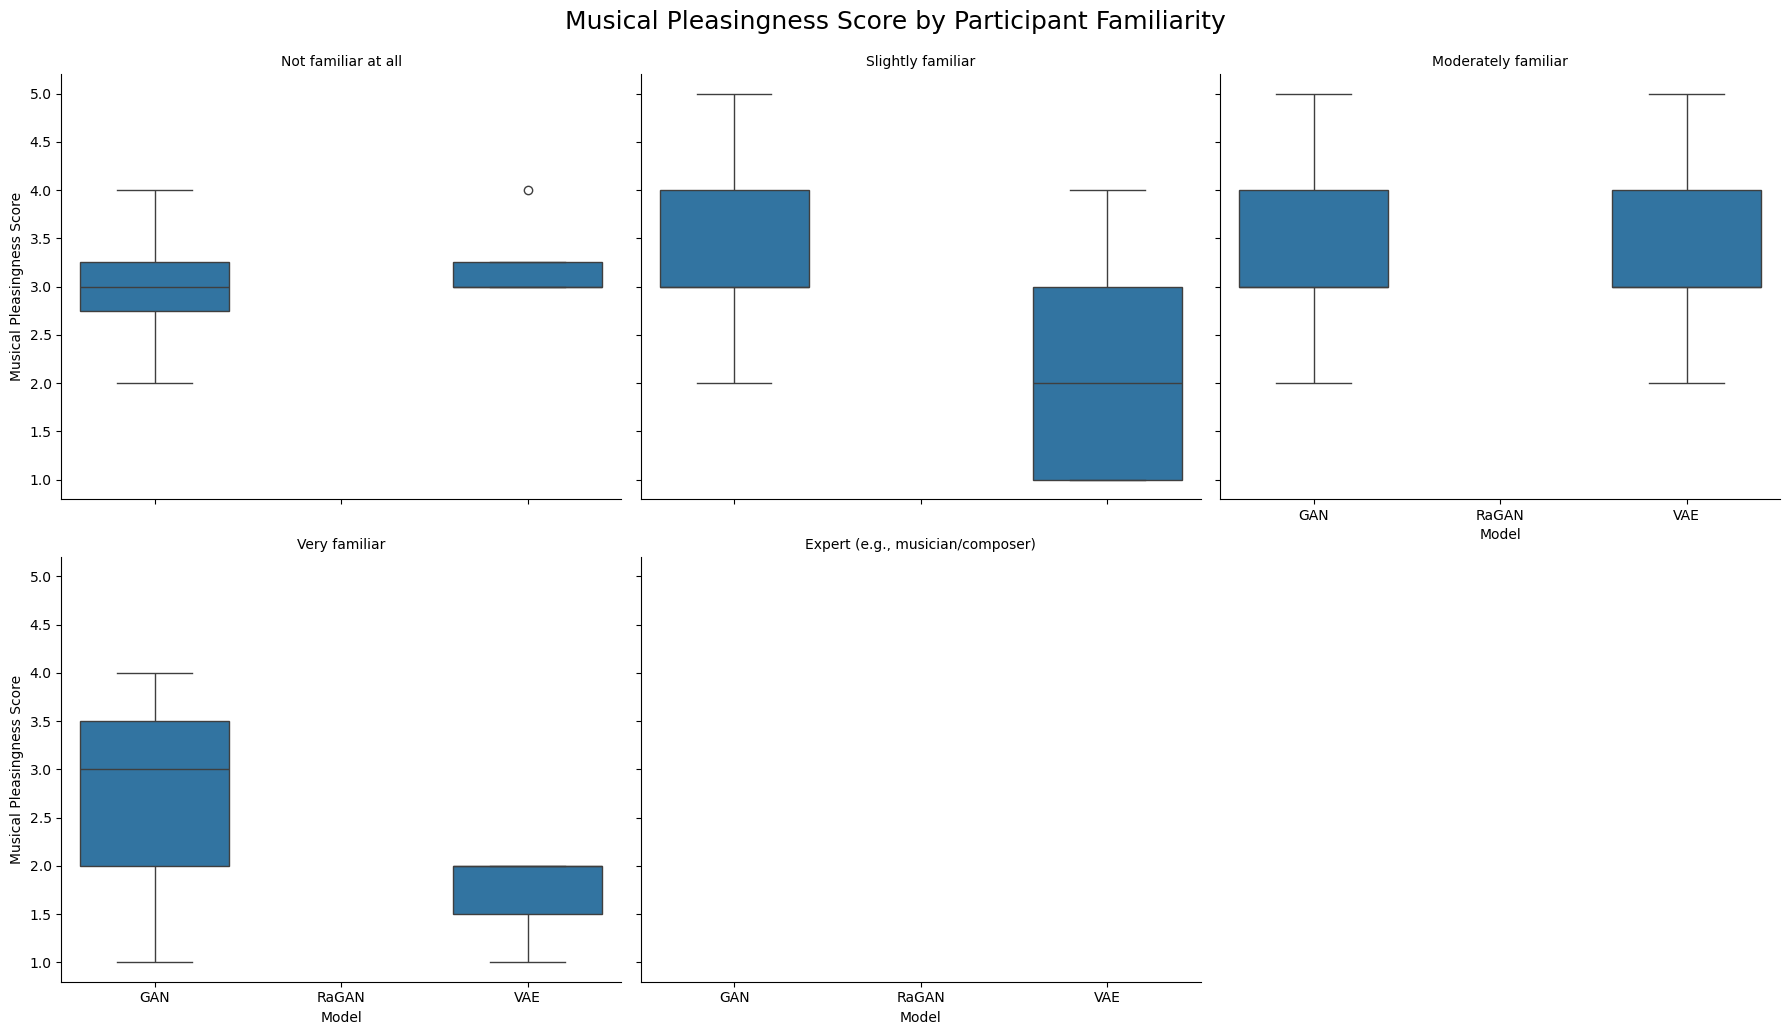


--- 4. Correlation Analysis ---


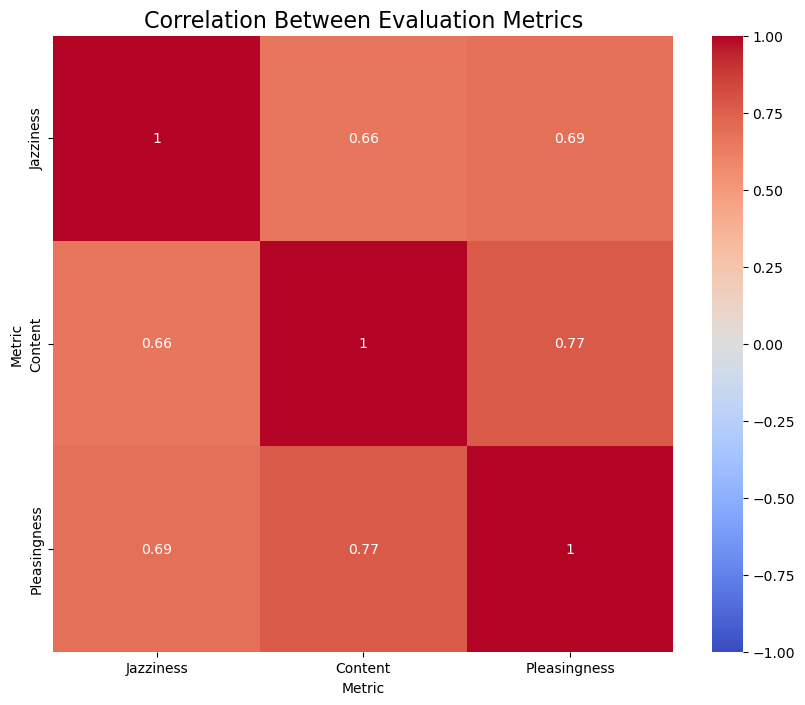

This heatmap shows the relationship between the different rating criteria.
For example, a high positive value between 'Jazziness' and 'Pleasingness' suggests that listeners found the more jazz-like outputs to be more musically pleasing.


In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ==============================================================================
# SECTION 2: DATA LOADING AND PREPARATION
# ==============================================================================
def load_and_prepare_data(csv_path):
    """Loads the CSV and prepares it for analysis."""
    print("--- Loading and Preparing Survey Data ---")
    df = pd.read_csv(csv_path)

    # <<< FIX: Strip whitespace from all column headers >>>
    df.columns = df.columns.str.strip()

    # Define shorter, more usable column names
    column_mapping = {
        'How familiar are you with jazz music?': 'Jazz Familiarity',
        'How often do you listen to piano only instrumental music (e.g., jazz, classical)?': 'Listening Frequency',
        'Do you have any formal piano musical training?': 'Musical Training',
        'What is your age group?': 'Age Group',
        'What is your gender?': 'Gender',
        'How much does Transformer-VAE generated outputs sound like jazz?': 'VAE_Jazziness',
        'How much does GAN generated outputs sound like jazz?': 'GAN_Jazziness',
        'How much does RaGAN generated outputs sound like jazz?': 'RaGAN_Jazziness',
        'How well does Transformer-VAE generated outputs retain the melody/harmony of original songs?': 'VAE_Content',
        'How well does GAN generated outputs retain the melody/harmony of original songs?': 'GAN_Content',
        'How well does RaGAN generated outputs retain the melody/harmony of original songs?': 'RaGAN_Content',
        'How musically pleasing is Transformer-VAE generated outputs?': 'VAE_Pleasingness',
        'How musically pleasing is GAN  generated outputs?': 'GAN_Pleasingness',
        'How musically pleasing is RaGAN generated outputs?': 'RaGAN_Pleasingness'
    }
    
    df.rename(columns=column_mapping, inplace=True)
    
    # Convert categorical data to ordered type for better plotting
    familiarity_order = ['Not familiar at all', 'Slightly familiar', 'Moderately familiar', 'Very familiar', 'Expert (e.g., musician/composer)']
    df['Jazz Familiarity'] = pd.Categorical(df['Jazz Familiarity'], categories=familiarity_order, ordered=True)

    print("Data loaded and columns renamed successfully.")
    return df

# ==============================================================================
# SECTION 3: ANALYSIS FUNCTIONS
# ==============================================================================

def analyze_demographics(df):
    """Analyzes and plots the distribution of survey participants."""
    print("\n" + "="*50)
    print("--- 1. Participant Demographics Analysis ---")
    print("="*50)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("Participant Demographics", fontsize=18)

    sns.countplot(y=df['Jazz Familiarity'], ax=axes[0], order=df['Jazz Familiarity'].cat.categories)
    axes[0].set_title("Familiarity with Jazz Music")

    sns.countplot(y=df['Musical Training'], ax=axes[1])
    axes[1].set_title("Formal Musical Training")

    sns.countplot(y=df['Listening Frequency'], ax=axes[2])
    axes[2].set_title("Instrumental Music Listening Frequency")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def analyze_overall_performance(df_long):
    """Analyzes and plots overall model performance across all participants."""
    print("\n" + "="*50)
    print("--- 2. Overall Model Performance Analysis ---")
    print("="*50)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)
    fig.suptitle("Overall Model Performance (All Participants)", fontsize=18)

    # Filter the DataFrame for each metric and plot the 'Score' column
    sns.boxplot(ax=axes[0], data=df_long[df_long['Metric'] == 'Jazziness'], x='Model', y='Score')
    axes[0].set_title("How 'Jazz-like' is the output?")
    axes[0].set_ylabel("Score (1-5)") # Add a y-label for clarity

    sns.boxplot(ax=axes[1], data=df_long[df_long['Metric'] == 'Content'], x='Model', y='Score')
    axes[1].set_title("Content Preservation")
    axes[1].set_ylabel("") # Hide redundant y-label

    sns.boxplot(ax=axes[2], data=df_long[df_long['Metric'] == 'Pleasingness'], x='Model', y='Score')
    axes[2].set_title("Musical Pleasingness")
    axes[2].set_ylabel("") # Hide redundant y-label
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Statistical Analysis ---
    print("\n--- Statistical Significance (ANOVA) ---")
    for metric in ['Jazziness', 'Content', 'Pleasingness']:
        print(f"\nAnalyzing metric: {metric}")
        
        # Filter the DataFrame for the current metric first
        metric_df = df_long[df_long['Metric'] == metric]
        
        # Use 'Score' as the dependent variable in the formula
        model = ols('Score ~ C(Model)', data=metric_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(anova_table)
        
        # The PR(>F) column name is 'PR(>F)', so we access it directly
        if anova_table['PR(>F)'].iloc[0] < 0.05:
            print(f"  -> Significant difference found between models for {metric}.")
            # Use the filtered DataFrame for the post-hoc test
            tukey = pairwise_tukeyhsd(endog=metric_df['Score'], groups=metric_df['Model'], alpha=0.05)
            print(tukey)
        else:
            print(f"  -> No significant difference found between models for {metric}.")

def analyze_performance_by_familiarity(df_long):
    """Analyzes model performance stratified by user's familiarity with jazz."""
    print("\n" + "="*50)
    print("--- 3. Deep Dive: Performance by Jazz Familiarity ---")
    print("="*50)

    # --- Plot for Jazziness ---
    # Filter the data for the 'Jazziness' metric
    jazziness_df = df_long[df_long['Metric'] == 'Jazziness']
    
    g_jazz = sns.FacetGrid(jazziness_df, col="Jazz Familiarity", col_wrap=3, height=5, aspect=1.2, col_order=jazziness_df['Jazz Familiarity'].cat.categories)
    # Tell the boxplot to use the 'Score' column for the y-axis
    g_jazz.map_dataframe(sns.boxplot, x='Model', y='Score', order=['GAN', 'RaGAN', 'VAE'])
    g_jazz.set_axis_labels("Model", "Jazz-likeness Score")
    g_jazz.set_titles(col_template="{col_name}")
    g_jazz.fig.suptitle("Jazz-likeness Score by Participant Familiarity", fontsize=18, y=1.03)
    plt.show()

    # --- Plot for Pleasingness ---
    # Filter the data for the 'Pleasingness' metric
    pleasingness_df = df_long[df_long['Metric'] == 'Pleasingness']

    g_pleasing = sns.FacetGrid(pleasingness_df, col="Jazz Familiarity", col_wrap=3, height=5, aspect=1.2, col_order=pleasingness_df['Jazz Familiarity'].cat.categories)
    # Tell the boxplot to use the 'Score' column for the y-axis
    g_pleasing.map_dataframe(sns.boxplot, x='Model', y='Score', order=['GAN', 'RaGAN', 'VAE'])
    g_pleasing.set_axis_labels("Model", "Musical Pleasingness Score")
    g_pleasing.set_titles(col_template="{col_name}")
    g_pleasing.fig.suptitle("Musical Pleasingness Score by Participant Familiarity", fontsize=18, y=1.03)
    plt.show()

def analyze_correlations(df_long):
    """Analyzes the correlation between different evaluation metrics."""
    print("\n" + "="*50)
    print("--- 4. Correlation Analysis ---")
    print("="*50)

    # We need to pivot the data back to wide format for this
    df_wide = df_long.pivot_table(index=['Timestamp', 'Model'], columns='Metric', values='Score').reset_index()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df_wide[['Jazziness', 'Content', 'Pleasingness']].corr(),
        annot=True,
        cmap='coolwarm',
        vmin=-1, vmax=1
    )
    plt.title("Correlation Between Evaluation Metrics", fontsize=16)
    plt.show()
    print("This heatmap shows the relationship between the different rating criteria.")
    print("For example, a high positive value between 'Jazziness' and 'Pleasingness' suggests that listeners found the more jazz-like outputs to be more musically pleasing.")


# ==============================================================================
# SECTION 4: MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    # --- 1. Load and Prepare Data ---
    CSV_FILE_PATH = r"C:\Users\User\Desktop\college\fyp\other\AI Jazz Style Transfer (Responses) - Form Responses 1.csv"
    df = load_and_prepare_data(CSV_FILE_PATH)

    # --- 2. Analyze Demographics ---
    analyze_demographics(df)
    
    # --- 3. Reshape data for easier analysis ---
    # Convert the wide format (one column per model/metric) to a long format
    id_vars_to_keep = ['Timestamp', 'Jazz Familiarity', 'Musical Training', 'Age Group', 'Gender', 'Listening Frequency']
    
    # Find all columns that were successfully renamed to our metric format (e.g., 'VAE_Jazziness')
    value_vars_to_melt = [col for col in df.columns if '_' in col and any(model in col for model in ['GAN', 'RaGAN', 'VAE'])]

    df_long = pd.melt(df, 
                      id_vars=id_vars_to_keep,
                      value_vars=value_vars_to_melt,
                      var_name='Metric_Model', 
                      value_name='Score')

    # Split the 'Metric_Model' column into 'Model' and 'Metric'
    df_long[['Model', 'Metric']] = df_long['Metric_Model'].str.split('_', expand=True)

    # --- 4. Run Analysis Functions ---
    analyze_overall_performance(df_long)
    analyze_performance_by_familiarity(df_long)
    analyze_correlations(df_long)